In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Input,InputLayer, Concatenate, concatenate
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from plot_keras_history import show_history, plot_history
import keras
import pydot
import graphviz

In [3]:
df = pd.read_csv('E:\\My files\\Dr Buzna\\trips\\NN\\NN-based_distance\\tripdf_sp_sphs.csv', index_col=0)
print(df.shape)
df.tail()

(16850, 9)


travel time  real travel time  euc_dist   distance  hour of day  \
16845         1136            1140.0  0.092494   8347.999            6   
16846          348             358.0  0.019167   2245.306           20   
16847         1243            1262.0  0.098395  10753.248            0   
16848          125             134.0  0.002981    657.827            2   
16849         1670            1772.0  0.138938  22070.225            5   

           O lat      O lon      D lat      D lon  
16845  49.301228  18.785291  49.261156  18.868654  
16846  49.300316  18.784926  49.309618  18.768167  
16847  49.300295  18.784904  49.332374  18.877923  
16848  49.300220  18.784904  49.297248  18.784668  
16849  49.300252  18.785205  49.438643  18.772888

In [4]:
# df = pd.merge(df0,df3, on = ['travel time','distance','hour of day'])

df = df.drop(['travel time','euc_dist'],axis=1)
df.rename(columns = {'real travel time':'travel time'}, inplace = True)
df = pd.concat([df.iloc[:,-5:].reset_index(drop=True) , df.iloc[:,0:-5].reset_index(drop=True)] , axis=1)
df.head(2)
df.columns

Index(['hour of day', 'O lat', 'O lon', 'D lat', 'D lon', 'travel time',
       'distance'],
      dtype='object')

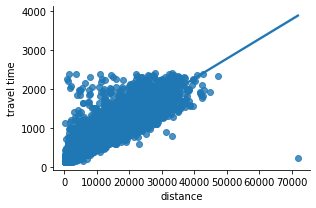

In [5]:
sns.lmplot(x='distance',y='travel time',data=df, height=3, aspect=1.5)

In [6]:
# outlier removal
from scipy import stats
df = df[(np.abs(stats.zscore(df['distance'])) < 3)]

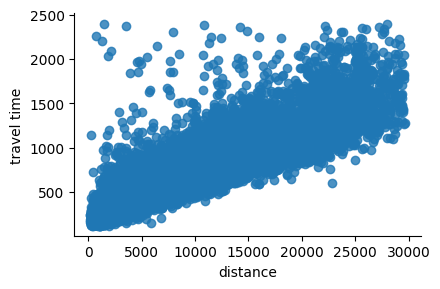

In [7]:
sns.lmplot(x='distance',y='travel time',data=df, height=3, aspect=1.5)

In [8]:
# Normalize using Min/Max Normalization.
normalized_Olat=(df['O lat']-df['O lat'].min())/(df['O lat'].max()-df['O lat'].min())
df['O lat'] = normalized_Olat
normalized_Dlat=(df['D lat']-df['D lat'].min())/(df['D lat'].max()-df['D lat'].min())
df['D lat'] = normalized_Dlat
normalized_Olon=(df['O lon']-df['O lon'].min())/(df['O lon'].max()-df['O lon'].min())
df['O lon'] = normalized_Olon
normalized_Dlon=(df['D lon']-df['D lon'].min())/(df['D lon'].max()-df['D lon'].min())
df['D lon'] = normalized_Dlon
normalized_Dist=(df['distance']-df['distance'].min())/(df['distance'].max()-df['distance'].min())
df['distance'] = normalized_Dist
df['hr_sin'] = np.sin(df['hour of day']*(2.*np.pi/24))
df['hr_cos'] = np.cos(df['hour of day']*(2.*np.pi/24))
df

hour of day     O lat     O lon     D lat     D lon  travel time  \
0               17  0.269710  0.695504  0.273480  0.284582       1945.0   
1               20  0.269801  0.696160  0.496777  0.402786        794.0   
2               18  0.269433  0.696085  0.438261  0.524826        197.0   
3               15  0.269556  0.695774  0.500580  0.397565        552.0   
4               16  0.269647  0.696045  0.504120  0.386613       1032.0   
...            ...       ...       ...       ...       ...          ...   
16845            6  0.605271  0.555598  0.566702  0.532358       1140.0   
16846           20  0.602663  0.554940  0.651312  0.424158        358.0   
16847            0  0.602603  0.554900  0.691042  0.542339       1262.0   
16848            2  0.602388  0.554900  0.629715  0.441925        134.0   
16849            5  0.602480  0.555443  0.876577  0.429241       1772.0   

       distance    hr_sin        hr_cos  
0      0.992498 -0.965926 -2.588190e-01  
1      0.344315 -0.866025  5.000000e-01  
2      0.018713 -1.000000 -1.836970e-16  
3      0.349947 -0.707107 -7.071068e-01  
4      0.385289 -0.866025 -5.000000e-01  
...         ...       ...           ...  
16845  0.277049  1.000000  6.123234e-17  
16846  0.069904 -0.866025  5.000000e-01  
16847  0.358691  0.000000  1.000000e+00  
16848  0.016019  0.500000  8.660254e-01  
16849  0.742826  0.965926  2.588190e-01  

[16658 rows x 9 columns]

In [9]:
# df['distance'] = df['distance']/1000 #in km
# df['travel time'] = df['travel time']/60 #in minutes
# df

# Functional API keras model

In [10]:
np.random.seed(7)

In [11]:
def nnmodel(*num_neuron,num_hlayers,Epoch):

    if num_hlayers == 1:
        first_input  = Input(shape=(4, ))
        first_dense  = Dense(num_neuron[0], activation='relu')(first_input)
        first_dense = Dense(1, activation='relu', name='distance_layer')(first_dense)
        
        second_input = Input(shape=(X_train.shape[1]-4, ))
        
        merge_two = concatenate([first_dense, second_input])
        second_dense = Dense(num_neuron[1], activation='relu')(merge_two)
        second_dense = Dense(1, activation='relu',name='traveltime_layer')(second_dense)
        
        model = Model(inputs=[first_input, second_input], outputs=[first_dense, second_dense])
    elif num_hlayers == 2:
        first_input  = Input(shape=(4, ))
        first_dense  = Dense(num_neuron[0], activation='relu')(first_input)
        first_dense  = Dense(num_neuron[1], activation='relu')(first_dense)
        first_dense = Dense(1, activation='relu', name='distance_layer')(first_dense)
        second_input = Input(shape=(X_train.shape[1]-4, ))
        
        merge_two = concatenate([first_dense, second_input])
        second_dense = Dense(num_neuron[2], activation='relu')(merge_two)
        second_dense = Dense(num_neuron[3], activation='relu')(second_dense)
        second_dense = Dense(1, activation='relu', name='traveltime_layer')(second_dense)
        
        model = Model(inputs=[first_input, second_input], outputs=[first_dense, second_dense])
    else:
        first_input  = Input(shape=(4, ))
        first_dense  = Dense(num_neuron[0], activation='relu')(first_input)
        first_dense  = Dense(num_neuron[1], activation='relu')(first_dense)
        first_dense  = Dense(num_neuron[2], activation='relu')(first_dense)
        first_dense = Dense(1, activation='relu', name='distance_layer')(first_dense)
        second_input = Input(shape=(X_train.shape[1]-4, ))
        
        merge_two = concatenate([first_dense, second_input])
        second_dense = Dense(num_neuron[3], activation='relu')(merge_two)
        second_dense = Dense(num_neuron[4], activation='relu')(second_dense)
        second_dense = Dense(num_neuron[5], activation='relu')(second_dense)
        second_dense = Dense(1, activation='relu', name='traveltime_layer')(second_dense)
        
        model = Model(inputs=[first_input, second_input], outputs=[first_dense, second_dense])        

#     from keras.optimizers import SGD
#     opt = SGD(lr=0.01)
#     model.compile(loss = "categorical_crossentropy", optimizer = opt)       
        
    learning_rate = 0.07
    model.compile(optimizer='adam',
                  loss=[tf.keras.metrics.mean_squared_error,tf.keras.metrics.mean_squared_error],
                  loss_weights=[0.4,0.7],
                  metrics=['mape',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
#     model.compile(optimizer='adam',
#                   loss=tf.keras.metrics.mean_squared_error,
#                   metrics=['mape',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    history = model.fit([X_train[:,0:4],X_train[:,4:]], [y_train[:,0],y_train[:,1]], verbose=1, epochs=Epoch,
                   validation_data=([X_test[:,0:4],X_test[:,4:]], [y_test[:,0],y_test[:,1]]))
    
    print('minimum testing RMSE (distance): ',min(history.history['val_distance_layer_rmse'])/1000)
    print('minimum testing MAPE (distance): ',min(history.history['val_distance_layer_mape'])/100)
    print('-----------------')
    print('minimum testing ravel time): ',min(history.history['val_traveltime_layer_rmse'])/60)
    print('minimum testing MAPE (travel time): ',min(history.history['val_traveltime_layer_mape'])/100)
    
    return history

In [12]:
def plotme(model):
    plt.style.use('fivethirtyeight')
    # Plot the training and validation accuracy and loss at each epoch
    loss1 = [f/60 for f in model.history['traveltime_layer_rmse']]
    val_loss1 = [f/60 for f in model.history['val_traveltime_layer_rmse']]
    loss2 = model.history['traveltime_layer_mape']
    val_loss2 = model.history['val_traveltime_layer_mape']
    val_loss2 = [x+1.8 for x in val_loss2]
    epochs = range(1, len(model.history['loss'])+1)
    plt.figure(figsize=(5, 5))
    plt.plot(epochs, val_loss1, 'r', label='Validation rmse')
    plt.plot(epochs, loss1, 'y', label='Trainnig rmse')
    plt.plot(epochs, val_loss2, 'k', label='Validation mape')
    plt.plot(epochs, loss2, 'b', label='Trainnig mape')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    #plt.xlim(lims)
    yli = max(model.history['val_traveltime_layer_mape'])
    plt.ylim([-1, yli+10])
    plt.legend(loc='upper right')
    plt.show()

## sub-problem 1:     ******* input: [] *********

In [37]:
x = df.loc[:,['O lat','O lon','D lat','D lon']].values
y = df.loc[:,['distance','travel time']].values
# x

In [38]:
#split data into test & train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [39]:
print(X_train.shape)
print(X_test.shape)
# X_train

(11660, 4)
(4998, 4)


In [43]:
# inputs: distance
model1_1 = nnmodel(5,5, num_hlayers=1,Epoch=500)
model1_1

Epoch 1/500
365/365 [==============================] - 1s 1ms/step - loss: 414468.9062 - distance_layer_loss: 9.5557 - traveltime_layer_loss: 592092.5000 - distance_layer_mape: 2605.3721 - distance_layer_rmse: 3.0912 - traveltime_layer_mape: 98.8270 - traveltime_layer_rmse: 769.4755 - val_loss: 390356.5312 - val_distance_layer_loss: 45.9104 - val_traveltime_layer_loss: 557625.8125 - val_distance_layer_mape: 1264773.1250 - val_distance_layer_rmse: 6.7757 - val_traveltime_layer_mape: 95.6583 - val_traveltime_layer_rmse: 746.7435
Epoch 2/500
365/365 [==============================] - 0s 992us/step - loss: 343149.1875 - distance_layer_loss: 276.0350 - traveltime_layer_loss: 490055.4062 - distance_layer_mape: 16154.6895 - distance_layer_rmse: 16.6143 - traveltime_layer_mape: 82.1114 - traveltime_layer_rmse: 700.0396 - val_loss: 251908.9688 - val_distance_layer_loss: 682.3750 - val_traveltime_layer_loss: 359480.0625 - val_distance_layer_mape: 4784760.5000 - val_distance_layer_rmse: 26.1223 -

365/365 [==============================] - 0s 971us/step - loss: 101463.5391 - distance_layer_loss: 2384.2898 - traveltime_layer_loss: 143585.3750 - distance_layer_mape: 50442.4141 - distance_layer_rmse: 48.8292 - traveltime_layer_mape: 62.3278 - traveltime_layer_rmse: 378.9266 - val_loss: 101048.0547 - val_distance_layer_loss: 2331.1228 - val_traveltime_layer_loss: 143022.4375 - val_distance_layer_mape: 8912172.0000 - val_distance_layer_rmse: 48.2817 - val_traveltime_layer_mape: 61.4729 - val_traveltime_layer_rmse: 378.1831
Epoch 17/500
365/365 [==============================] - 0s 967us/step - loss: 101417.3750 - distance_layer_loss: 2351.9119 - traveltime_layer_loss: 143538.0938 - distance_layer_mape: 50080.9531 - distance_layer_rmse: 48.4965 - traveltime_layer_mape: 62.0352 - traveltime_layer_rmse: 378.8642 - val_loss: 101053.6406 - val_distance_layer_loss: 2330.6658 - val_traveltime_layer_loss: 143030.5312 - val_distance_layer_mape: 8917102.0000 - val_distance_layer_rmse: 48.2770 

365/365 [==============================] - 0s 1ms/step - loss: 101051.6562 - distance_layer_loss: 2063.7183 - traveltime_layer_loss: 143180.2969 - distance_layer_mape: 46999.5820 - distance_layer_rmse: 45.4282 - traveltime_layer_mape: 62.4113 - traveltime_layer_rmse: 378.3917 - val_loss: 100620.0234 - val_distance_layer_loss: 2040.0934 - val_traveltime_layer_loss: 142577.2031 - val_distance_layer_mape: 8402892.0000 - val_distance_layer_rmse: 45.1674 - val_traveltime_layer_mape: 62.2885 - val_traveltime_layer_rmse: 377.5940
Epoch 32/500
365/365 [==============================] - 0s 1ms/step - loss: 101014.7656 - distance_layer_loss: 2041.9067 - traveltime_layer_loss: 143140.0781 - distance_layer_mape: 46744.9805 - distance_layer_rmse: 45.1875 - traveltime_layer_mape: 62.3344 - traveltime_layer_rmse: 378.3386 - val_loss: 100558.3906 - val_distance_layer_loss: 2008.8263 - val_traveltime_layer_loss: 142507.0000 - val_distance_layer_mape: 8340964.0000 - val_distance_layer_rmse: 44.8199 - va

365/365 [==============================] - 0s 977us/step - loss: 100766.4922 - distance_layer_loss: 1805.4963 - traveltime_layer_loss: 142920.4844 - distance_layer_mape: 44010.8320 - distance_layer_rmse: 42.4911 - traveltime_layer_mape: 62.3696 - traveltime_layer_rmse: 378.0482 - val_loss: 100233.7578 - val_distance_layer_loss: 1770.8983 - val_traveltime_layer_loss: 142179.1406 - val_distance_layer_mape: 7864837.0000 - val_distance_layer_rmse: 42.0820 - val_traveltime_layer_mape: 61.6491 - val_traveltime_layer_rmse: 377.0665
Epoch 47/500
365/365 [==============================] - 0s 999us/step - loss: 100760.7969 - distance_layer_loss: 1783.5199 - traveltime_layer_loss: 142924.8281 - distance_layer_mape: 43746.6055 - distance_layer_rmse: 42.2317 - traveltime_layer_mape: 62.1217 - traveltime_layer_rmse: 378.0540 - val_loss: 100246.5625 - val_distance_layer_loss: 1769.7965 - val_traveltime_layer_loss: 142198.0781 - val_distance_layer_mape: 7863699.5000 - val_distance_layer_rmse: 42.0690 

365/365 [==============================] - 0s 951us/step - loss: 100529.2266 - distance_layer_loss: 1603.3463 - traveltime_layer_loss: 142696.9844 - distance_layer_mape: 41507.4648 - distance_layer_rmse: 40.0418 - traveltime_layer_mape: 62.5220 - traveltime_layer_rmse: 377.7525 - val_loss: 99974.3984 - val_distance_layer_loss: 1563.3693 - val_traveltime_layer_loss: 141927.2812 - val_distance_layer_mape: 7411012.0000 - val_distance_layer_rmse: 39.5395 - val_traveltime_layer_mape: 61.3947 - val_traveltime_layer_rmse: 376.7324
Epoch 62/500
365/365 [==============================] - 0s 985us/step - loss: 100538.6562 - distance_layer_loss: 1580.3247 - traveltime_layer_loss: 142723.6719 - distance_layer_mape: 41216.7383 - distance_layer_rmse: 39.7533 - traveltime_layer_mape: 62.1215 - traveltime_layer_rmse: 377.7879 - val_loss: 100037.1328 - val_distance_layer_loss: 1579.6815 - val_traveltime_layer_loss: 142007.5156 - val_distance_layer_mape: 7449858.5000 - val_distance_layer_rmse: 39.7452 -

365/365 [==============================] - 0s 999us/step - loss: 100380.9688 - distance_layer_loss: 1438.7039 - traveltime_layer_loss: 142579.1875 - distance_layer_mape: 39344.8242 - distance_layer_rmse: 37.9302 - traveltime_layer_mape: 62.6733 - traveltime_layer_rmse: 377.5966 - val_loss: 99788.4844 - val_distance_layer_loss: 1389.5486 - val_traveltime_layer_loss: 141760.8906 - val_distance_layer_mape: 7000846.5000 - val_distance_layer_rmse: 37.2766 - val_traveltime_layer_mape: 60.9354 - val_traveltime_layer_rmse: 376.5115
Epoch 77/500
365/365 [==============================] - 0s 957us/step - loss: 100380.0703 - distance_layer_loss: 1415.8044 - traveltime_layer_loss: 142591.0000 - distance_layer_mape: 39041.8789 - distance_layer_rmse: 37.6272 - traveltime_layer_mape: 62.1081 - traveltime_layer_rmse: 377.6122 - val_loss: 99907.3906 - val_distance_layer_loss: 1425.8059 - val_traveltime_layer_loss: 141910.0625 - val_distance_layer_mape: 7090708.0000 - val_distance_layer_rmse: 37.7598 - 

365/365 [==============================] - 0s 957us/step - loss: 100194.1172 - distance_layer_loss: 1302.9675 - traveltime_layer_loss: 142389.8750 - distance_layer_mape: 37445.4141 - distance_layer_rmse: 36.0966 - traveltime_layer_mape: 62.6302 - traveltime_layer_rmse: 377.3458 - val_loss: 99645.2969 - val_distance_layer_loss: 1259.8831 - val_traveltime_layer_loss: 141630.5156 - val_distance_layer_mape: 6675350.5000 - val_distance_layer_rmse: 35.4948 - val_traveltime_layer_mape: 60.9775 - val_traveltime_layer_rmse: 376.3383
Epoch 92/500
365/365 [==============================] - 0s 956us/step - loss: 100267.6484 - distance_layer_loss: 1285.8862 - traveltime_layer_loss: 142504.7188 - distance_layer_mape: 37219.6016 - distance_layer_rmse: 35.8593 - traveltime_layer_mape: 62.2395 - traveltime_layer_rmse: 377.4980 - val_loss: 99661.9922 - val_distance_layer_loss: 1275.9371 - val_traveltime_layer_loss: 141645.1875 - val_distance_layer_mape: 6717475.0000 - val_distance_layer_rmse: 35.7203 - 

365/365 [==============================] - 0s 1ms/step - loss: 100180.8359 - distance_layer_loss: 1187.4218 - traveltime_layer_loss: 142436.8594 - distance_layer_mape: 35780.3867 - distance_layer_rmse: 34.4590 - traveltime_layer_mape: 62.4867 - traveltime_layer_rmse: 377.4081 - val_loss: 99622.2031 - val_distance_layer_loss: 1185.0671 - val_traveltime_layer_loss: 141640.2812 - val_distance_layer_mape: 6477143.0000 - val_distance_layer_rmse: 34.4248 - val_traveltime_layer_mape: 62.7298 - val_traveltime_layer_rmse: 376.3513
Epoch 107/500
365/365 [==============================] - 0s 998us/step - loss: 100151.6094 - distance_layer_loss: 1182.6353 - traveltime_layer_loss: 142397.9531 - distance_layer_mape: 35705.4883 - distance_layer_rmse: 34.3895 - traveltime_layer_mape: 62.5676 - traveltime_layer_rmse: 377.3565 - val_loss: 99564.9766 - val_distance_layer_loss: 1169.6602 - val_traveltime_layer_loss: 141567.3438 - val_distance_layer_mape: 6435597.5000 - val_distance_layer_rmse: 34.2003 - v

365/365 [==============================] - 0s 967us/step - loss: 100079.1953 - distance_layer_loss: 1094.4313 - traveltime_layer_loss: 142344.9062 - distance_layer_mape: 34360.2734 - distance_layer_rmse: 33.0822 - traveltime_layer_mape: 62.5018 - traveltime_layer_rmse: 377.2862 - val_loss: 99476.2734 - val_distance_layer_loss: 1081.3630 - val_traveltime_layer_loss: 141490.9844 - val_distance_layer_mape: 6190374.5000 - val_distance_layer_rmse: 32.8841 - val_traveltime_layer_mape: 62.0991 - val_traveltime_layer_rmse: 376.1529
Epoch 122/500
365/365 [==============================] - 0s 954us/step - loss: 100080.0469 - distance_layer_loss: 1090.2858 - traveltime_layer_loss: 142348.5312 - distance_layer_mape: 34303.2500 - distance_layer_rmse: 33.0195 - traveltime_layer_mape: 62.5836 - traveltime_layer_rmse: 377.2910 - val_loss: 99444.6328 - val_distance_layer_loss: 1061.2542 - val_traveltime_layer_loss: 141457.3281 - val_distance_layer_mape: 6133538.0000 - val_distance_layer_rmse: 32.5769 -

365/365 [==============================] - 0s 963us/step - loss: 100006.4688 - distance_layer_loss: 1019.4589 - traveltime_layer_loss: 142283.8438 - distance_layer_mape: 33168.2188 - distance_layer_rmse: 31.9290 - traveltime_layer_mape: 62.7650 - traveltime_layer_rmse: 377.2053 - val_loss: 99394.3281 - val_distance_layer_loss: 997.1443 - val_traveltime_layer_loss: 141422.1094 - val_distance_layer_mape: 5946094.0000 - val_distance_layer_rmse: 31.5776 - val_traveltime_layer_mape: 61.7604 - val_traveltime_layer_rmse: 376.0613
Epoch 137/500
365/365 [==============================] - 0s 977us/step - loss: 100054.1328 - distance_layer_loss: 1006.3097 - traveltime_layer_loss: 142359.5000 - distance_layer_mape: 32954.5312 - distance_layer_rmse: 31.7224 - traveltime_layer_mape: 62.3224 - traveltime_layer_rmse: 377.3056 - val_loss: 99400.6328 - val_distance_layer_loss: 995.8643 - val_traveltime_layer_loss: 141431.8594 - val_distance_layer_mape: 5942112.0000 - val_distance_layer_rmse: 31.5573 - v

365/365 [==============================] - 0s 970us/step - loss: 99962.2500 - distance_layer_loss: 947.1522 - traveltime_layer_loss: 142261.9219 - distance_layer_mape: 31969.5586 - distance_layer_rmse: 30.7758 - traveltime_layer_mape: 62.4541 - traveltime_layer_rmse: 377.1762 - val_loss: 99459.4219 - val_distance_layer_loss: 949.9612 - val_traveltime_layer_loss: 141542.1094 - val_distance_layer_mape: 5803204.5000 - val_distance_layer_rmse: 30.8214 - val_traveltime_layer_mape: 62.9387 - val_traveltime_layer_rmse: 376.2208
Epoch 152/500
365/365 [==============================] - 0s 955us/step - loss: 99973.4375 - distance_layer_loss: 948.6535 - traveltime_layer_loss: 142277.1094 - distance_layer_mape: 32003.8418 - distance_layer_rmse: 30.8002 - traveltime_layer_mape: 62.8216 - traveltime_layer_rmse: 377.1964 - val_loss: 99345.1719 - val_distance_layer_loss: 927.7424 - val_traveltime_layer_loss: 141391.5156 - val_distance_layer_mape: 5735087.5000 - val_distance_layer_rmse: 30.4589 - val_t

365/365 [==============================] - 0s 972us/step - loss: 99951.5469 - distance_layer_loss: 889.2418 - traveltime_layer_loss: 142279.8750 - distance_layer_mape: 30977.9902 - distance_layer_rmse: 29.8202 - traveltime_layer_mape: 62.3699 - traveltime_layer_rmse: 377.2000 - val_loss: 99329.6953 - val_distance_layer_loss: 880.8400 - val_traveltime_layer_loss: 141396.2344 - val_distance_layer_mape: 5588748.0000 - val_distance_layer_rmse: 29.6789 - val_traveltime_layer_mape: 62.0872 - val_traveltime_layer_rmse: 376.0269
Epoch 167/500
365/365 [==============================] - 0s 951us/step - loss: 99918.4219 - distance_layer_loss: 888.0590 - traveltime_layer_loss: 142233.1406 - distance_layer_mape: 30969.7500 - distance_layer_rmse: 29.8003 - traveltime_layer_mape: 62.5166 - traveltime_layer_rmse: 377.1381 - val_loss: 99356.1172 - val_distance_layer_loss: 882.2693 - val_traveltime_layer_loss: 141433.0938 - val_distance_layer_mape: 5592496.0000 - val_distance_layer_rmse: 29.7030 - val_t

365/365 [==============================] - 0s 976us/step - loss: 99893.2188 - distance_layer_loss: 841.9380 - traveltime_layer_loss: 142223.4844 - distance_layer_mape: 30160.6699 - distance_layer_rmse: 29.0162 - traveltime_layer_mape: 62.5195 - traveltime_layer_rmse: 377.1253 - val_loss: 99292.7344 - val_distance_layer_loss: 830.0920 - val_traveltime_layer_loss: 141372.4375 - val_distance_layer_mape: 5424276.5000 - val_distance_layer_rmse: 28.8113 - val_traveltime_layer_mape: 61.9353 - val_traveltime_layer_rmse: 375.9953
Epoch 182/500
365/365 [==============================] - 0s 989us/step - loss: 99909.9297 - distance_layer_loss: 836.9864 - traveltime_layer_loss: 142250.2344 - distance_layer_mape: 30062.0918 - distance_layer_rmse: 28.9307 - traveltime_layer_mape: 62.3765 - traveltime_layer_rmse: 377.1608 - val_loss: 99524.6172 - val_distance_layer_loss: 851.3400 - val_traveltime_layer_loss: 141691.6250 - val_distance_layer_mape: 5491895.5000 - val_distance_layer_rmse: 29.1777 - val_t

365/365 [==============================] - 0s 978us/step - loss: 99884.5938 - distance_layer_loss: 793.3770 - traveltime_layer_loss: 142238.8438 - distance_layer_mape: 29275.1211 - distance_layer_rmse: 28.1669 - traveltime_layer_mape: 62.1371 - traveltime_layer_rmse: 377.1457 - val_loss: 99447.1719 - val_distance_layer_loss: 806.8547 - val_traveltime_layer_loss: 141606.2656 - val_distance_layer_mape: 5346783.5000 - val_distance_layer_rmse: 28.4052 - val_traveltime_layer_mape: 63.3742 - val_traveltime_layer_rmse: 376.3061
Epoch 197/500
365/365 [==============================] - 0s 950us/step - loss: 99871.8828 - distance_layer_loss: 796.3709 - traveltime_layer_loss: 142219.0312 - distance_layer_mape: 29339.2695 - distance_layer_rmse: 28.2200 - traveltime_layer_mape: 62.5576 - traveltime_layer_rmse: 377.1194 - val_loss: 99341.9688 - val_distance_layer_loss: 795.4835 - val_traveltime_layer_loss: 141462.5156 - val_distance_layer_mape: 5309052.5000 - val_distance_layer_rmse: 28.2043 - val_t

365/365 [==============================] - 0s 976us/step - loss: 99901.3750 - distance_layer_loss: 763.2379 - traveltime_layer_loss: 142280.1250 - distance_layer_mape: 28714.4375 - distance_layer_rmse: 27.6268 - traveltime_layer_mape: 62.7129 - traveltime_layer_rmse: 377.2004 - val_loss: 99282.4844 - val_distance_layer_loss: 755.1274 - val_traveltime_layer_loss: 141400.5781 - val_distance_layer_mape: 5172447.5000 - val_distance_layer_rmse: 27.4796 - val_traveltime_layer_mape: 62.3406 - val_traveltime_layer_rmse: 376.0327
Epoch 212/500
365/365 [==============================] - 0s 1ms/step - loss: 99858.0000 - distance_layer_loss: 758.6541 - traveltime_layer_loss: 142220.7812 - distance_layer_mape: 28636.3496 - distance_layer_rmse: 27.5437 - traveltime_layer_mape: 62.5407 - traveltime_layer_rmse: 377.1217 - val_loss: 99241.5312 - val_distance_layer_loss: 745.2019 - val_traveltime_layer_loss: 141347.7969 - val_distance_layer_mape: 5138826.5000 - val_distance_layer_rmse: 27.2984 - val_tra

365/365 [==============================] - 0s 984us/step - loss: 99834.3984 - distance_layer_loss: 727.6005 - traveltime_layer_loss: 142204.8750 - distance_layer_mape: 28041.2246 - distance_layer_rmse: 26.9741 - traveltime_layer_mape: 62.5604 - traveltime_layer_rmse: 377.1006 - val_loss: 99303.5000 - val_distance_layer_loss: 726.1694 - val_traveltime_layer_loss: 141447.2031 - val_distance_layer_mape: 5072290.0000 - val_distance_layer_rmse: 26.9475 - val_traveltime_layer_mape: 62.6693 - val_traveltime_layer_rmse: 376.0947
Epoch 227/500
365/365 [==============================] - 0s 935us/step - loss: 99848.0000 - distance_layer_loss: 727.7827 - traveltime_layer_loss: 142224.1562 - distance_layer_mape: 28044.3848 - distance_layer_rmse: 26.9774 - traveltime_layer_mape: 62.7246 - traveltime_layer_rmse: 377.1262 - val_loss: 99228.2266 - val_distance_layer_loss: 713.0275 - val_traveltime_layer_loss: 141347.1875 - val_distance_layer_mape: 5027078.0000 - val_distance_layer_rmse: 26.7026 - val_t

365/365 [==============================] - 0s 989us/step - loss: 99829.5859 - distance_layer_loss: 694.1212 - traveltime_layer_loss: 142217.1719 - distance_layer_mape: 27394.2402 - distance_layer_rmse: 26.3462 - traveltime_layer_mape: 62.3548 - traveltime_layer_rmse: 377.1169 - val_loss: 99354.4297 - val_distance_layer_loss: 700.9134 - val_traveltime_layer_loss: 141534.3906 - val_distance_layer_mape: 4982610.5000 - val_distance_layer_rmse: 26.4748 - val_traveltime_layer_mape: 63.1148 - val_traveltime_layer_rmse: 376.2106
Epoch 242/500
365/365 [==============================] - 0s 965us/step - loss: 99840.1562 - distance_layer_loss: 696.8916 - traveltime_layer_loss: 142230.5625 - distance_layer_mape: 27452.1094 - distance_layer_rmse: 26.3987 - traveltime_layer_mape: 62.7173 - traveltime_layer_rmse: 377.1347 - val_loss: 99230.2891 - val_distance_layer_loss: 686.4501 - val_traveltime_layer_loss: 141365.3438 - val_distance_layer_mape: 4931587.5000 - val_distance_layer_rmse: 26.2002 - val_t

365/365 [==============================] - 0s 960us/step - loss: 99829.5859 - distance_layer_loss: 669.9662 - traveltime_layer_loss: 142230.8750 - distance_layer_mape: 26910.4297 - distance_layer_rmse: 25.8837 - traveltime_layer_mape: 62.6061 - traveltime_layer_rmse: 377.1351 - val_loss: 99234.2969 - val_distance_layer_loss: 663.5149 - val_traveltime_layer_loss: 141384.1719 - val_distance_layer_mape: 4848540.0000 - val_distance_layer_rmse: 25.7588 - val_traveltime_layer_mape: 62.2623 - val_traveltime_layer_rmse: 376.0109
Epoch 257/500
365/365 [==============================] - 0s 954us/step - loss: 99817.6719 - distance_layer_loss: 665.4167 - traveltime_layer_loss: 142216.5156 - distance_layer_mape: 26822.3887 - distance_layer_rmse: 25.7957 - traveltime_layer_mape: 62.3951 - traveltime_layer_rmse: 377.1161 - val_loss: 99313.7969 - val_distance_layer_loss: 669.5663 - val_traveltime_layer_loss: 141494.2969 - val_distance_layer_mape: 4870200.5000 - val_distance_layer_rmse: 25.8760 - val_t

365/365 [==============================] - 0s 1ms/step - loss: 99794.2578 - distance_layer_loss: 647.1052 - traveltime_layer_loss: 142193.4531 - distance_layer_mape: 26455.8652 - distance_layer_rmse: 25.4383 - traveltime_layer_mape: 62.7521 - traveltime_layer_rmse: 377.0855 - val_loss: 99194.9453 - val_distance_layer_loss: 622.6304 - val_traveltime_layer_loss: 141351.2656 - val_distance_layer_mape: 4698188.5000 - val_distance_layer_rmse: 24.9526 - val_traveltime_layer_mape: 60.8458 - val_traveltime_layer_rmse: 375.9671
Epoch 272/500
365/365 [==============================] - 0s 942us/step - loss: 99814.2344 - distance_layer_loss: 639.7497 - traveltime_layer_loss: 142226.1406 - distance_layer_mape: 26308.6074 - distance_layer_rmse: 25.2933 - traveltime_layer_mape: 62.2579 - traveltime_layer_rmse: 377.1288 - val_loss: 99227.3594 - val_distance_layer_loss: 638.0004 - val_traveltime_layer_loss: 141388.8125 - val_distance_layer_mape: 4754910.0000 - val_distance_layer_rmse: 25.2587 - val_tra

365/365 [==============================] - 0s 979us/step - loss: 99798.7812 - distance_layer_loss: 623.3485 - traveltime_layer_loss: 142213.4844 - distance_layer_mape: 25966.3223 - distance_layer_rmse: 24.9669 - traveltime_layer_mape: 62.6457 - traveltime_layer_rmse: 377.1120 - val_loss: 99222.4766 - val_distance_layer_loss: 617.5181 - val_traveltime_layer_loss: 141393.4844 - val_distance_layer_mape: 4677435.0000 - val_distance_layer_rmse: 24.8499 - val_traveltime_layer_mape: 62.3340 - val_traveltime_layer_rmse: 376.0233
Epoch 287/500
365/365 [==============================] - 0s 986us/step - loss: 99816.2969 - distance_layer_loss: 619.5920 - traveltime_layer_loss: 142240.6875 - distance_layer_mape: 25892.3691 - distance_layer_rmse: 24.8916 - traveltime_layer_mape: 62.4804 - traveltime_layer_rmse: 377.1481 - val_loss: 99198.3516 - val_distance_layer_loss: 613.0045 - val_traveltime_layer_loss: 141361.6250 - val_distance_layer_mape: 4660658.0000 - val_distance_layer_rmse: 24.7589 - val_t

365/365 [==============================] - 0s 948us/step - loss: 99781.0078 - distance_layer_loss: 602.4986 - traveltime_layer_loss: 142200.0469 - distance_layer_mape: 25532.2070 - distance_layer_rmse: 24.5458 - traveltime_layer_mape: 62.6037 - traveltime_layer_rmse: 377.0942 - val_loss: 99209.7734 - val_distance_layer_loss: 596.7198 - val_traveltime_layer_loss: 141387.3438 - val_distance_layer_mape: 4597983.5000 - val_distance_layer_rmse: 24.4279 - val_traveltime_layer_mape: 62.2830 - val_traveltime_layer_rmse: 376.0151
Epoch 302/500
365/365 [==============================] - 0s 972us/step - loss: 99779.7578 - distance_layer_loss: 599.6763 - traveltime_layer_loss: 142199.8125 - distance_layer_mape: 25474.0801 - distance_layer_rmse: 24.4883 - traveltime_layer_mape: 62.4631 - traveltime_layer_rmse: 377.0939 - val_loss: 99184.1953 - val_distance_layer_loss: 591.8701 - val_traveltime_layer_loss: 141353.5000 - val_distance_layer_mape: 4579560.0000 - val_distance_layer_rmse: 24.3284 - val_t

365/365 [==============================] - 0s 961us/step - loss: 99773.2109 - distance_layer_loss: 583.1924 - traveltime_layer_loss: 142199.8594 - distance_layer_mape: 25116.9941 - distance_layer_rmse: 24.1494 - traveltime_layer_mape: 62.6084 - traveltime_layer_rmse: 377.0940 - val_loss: 99160.7422 - val_distance_layer_loss: 565.7161 - val_traveltime_layer_loss: 141334.9375 - val_distance_layer_mape: 4477819.0000 - val_distance_layer_rmse: 23.7848 - val_traveltime_layer_mape: 61.1495 - val_traveltime_layer_rmse: 375.9454
Epoch 317/500
365/365 [==============================] - 0s 961us/step - loss: 99783.4297 - distance_layer_loss: 579.4276 - traveltime_layer_loss: 142216.7031 - distance_layer_mape: 25043.9512 - distance_layer_rmse: 24.0713 - traveltime_layer_mape: 62.3906 - traveltime_layer_rmse: 377.1163 - val_loss: 99168.1875 - val_distance_layer_loss: 571.4376 - val_traveltime_layer_loss: 141342.2812 - val_distance_layer_mape: 4500393.0000 - val_distance_layer_rmse: 23.9048 - val_t

365/365 [==============================] - 0s 958us/step - loss: 99760.2656 - distance_layer_loss: 566.3409 - traveltime_layer_loss: 142191.0781 - distance_layer_mape: 24743.5742 - distance_layer_rmse: 23.7979 - traveltime_layer_mape: 62.6470 - traveltime_layer_rmse: 377.0823 - val_loss: 99152.2500 - val_distance_layer_loss: 550.7454 - val_traveltime_layer_loss: 141331.3750 - val_distance_layer_mape: 4418431.5000 - val_distance_layer_rmse: 23.4680 - val_traveltime_layer_mape: 61.3604 - val_traveltime_layer_rmse: 375.9406
Epoch 332/500
365/365 [==============================] - 0s 974us/step - loss: 99788.4297 - distance_layer_loss: 562.1879 - traveltime_layer_loss: 142233.6406 - distance_layer_mape: 24667.2363 - distance_layer_rmse: 23.7105 - traveltime_layer_mape: 62.4196 - traveltime_layer_rmse: 377.1388 - val_loss: 99182.9062 - val_distance_layer_loss: 557.8030 - val_traveltime_layer_loss: 141371.1562 - val_distance_layer_mape: 4445837.0000 - val_distance_layer_rmse: 23.6179 - val_t

365/365 [==============================] - 0s 987us/step - loss: 99773.2344 - distance_layer_loss: 547.5412 - traveltime_layer_loss: 142220.3750 - distance_layer_mape: 24343.7617 - distance_layer_rmse: 23.3996 - traveltime_layer_mape: 62.4540 - traveltime_layer_rmse: 377.1212 - val_loss: 99187.9062 - val_distance_layer_loss: 543.9965 - val_traveltime_layer_loss: 141386.1094 - val_distance_layer_mape: 4391201.5000 - val_distance_layer_rmse: 23.3237 - val_traveltime_layer_mape: 62.2827 - val_traveltime_layer_rmse: 376.0135
Epoch 347/500
365/365 [==============================] - 0s 947us/step - loss: 99754.1094 - distance_layer_loss: 547.2213 - traveltime_layer_loss: 142193.1719 - distance_layer_mape: 24338.2168 - distance_layer_rmse: 23.3928 - traveltime_layer_mape: 62.5308 - traveltime_layer_rmse: 377.0851 - val_loss: 99144.7969 - val_distance_layer_loss: 534.5621 - val_traveltime_layer_loss: 141329.9531 - val_distance_layer_mape: 4353079.0000 - val_distance_layer_rmse: 23.1206 - val_t

365/365 [==============================] - 0s 946us/step - loss: 99773.8516 - distance_layer_loss: 535.6317 - traveltime_layer_loss: 142228.0156 - distance_layer_mape: 24082.6289 - distance_layer_rmse: 23.1437 - traveltime_layer_mape: 62.7847 - traveltime_layer_rmse: 377.1313 - val_loss: 99173.1016 - val_distance_layer_loss: 527.9647 - val_traveltime_layer_loss: 141374.1875 - val_distance_layer_mape: 4326000.5000 - val_distance_layer_rmse: 22.9775 - val_traveltime_layer_mape: 62.1917 - val_traveltime_layer_rmse: 375.9976
Epoch 362/500
365/365 [==============================] - 0s 972us/step - loss: 99752.6641 - distance_layer_loss: 532.4418 - traveltime_layer_loss: 142199.5469 - distance_layer_mape: 24008.1445 - distance_layer_rmse: 23.0747 - traveltime_layer_mape: 62.5566 - traveltime_layer_rmse: 377.0936 - val_loss: 99137.8828 - val_distance_layer_loss: 517.9871 - val_traveltime_layer_loss: 141329.5781 - val_distance_layer_mape: 4285956.0000 - val_distance_layer_rmse: 22.7593 - val_t

365/365 [==============================] - 0s 977us/step - loss: 99751.3516 - distance_layer_loss: 517.3535 - traveltime_layer_loss: 142206.2656 - distance_layer_mape: 23664.9336 - distance_layer_rmse: 22.7454 - traveltime_layer_mape: 62.3914 - traveltime_layer_rmse: 377.1024 - val_loss: 99388.6484 - val_distance_layer_loss: 527.9374 - val_traveltime_layer_loss: 141682.1094 - val_distance_layer_mape: 4324796.0000 - val_distance_layer_rmse: 22.9769 - val_traveltime_layer_mape: 63.6844 - val_traveltime_layer_rmse: 376.4068
Epoch 377/500
365/365 [==============================] - 0s 982us/step - loss: 99774.3828 - distance_layer_loss: 517.8033 - traveltime_layer_loss: 142239.0312 - distance_layer_mape: 23683.8457 - distance_layer_rmse: 22.7553 - traveltime_layer_mape: 62.5170 - traveltime_layer_rmse: 377.1459 - val_loss: 99342.9844 - val_distance_layer_loss: 524.9326 - val_traveltime_layer_loss: 141618.6094 - val_distance_layer_mape: 4312962.5000 - val_distance_layer_rmse: 22.9114 - val_t

365/365 [==============================] - 0s 977us/step - loss: 99742.5703 - distance_layer_loss: 504.6616 - traveltime_layer_loss: 142201.0625 - distance_layer_mape: 23382.0410 - distance_layer_rmse: 22.4647 - traveltime_layer_mape: 62.4752 - traveltime_layer_rmse: 377.0956 - val_loss: 99165.9922 - val_distance_layer_loss: 500.8471 - val_traveltime_layer_loss: 141379.4844 - val_distance_layer_mape: 4213716.5000 - val_distance_layer_rmse: 22.3796 - val_traveltime_layer_mape: 62.2474 - val_traveltime_layer_rmse: 376.0046
Epoch 392/500
365/365 [==============================] - 0s 934us/step - loss: 99762.2109 - distance_layer_loss: 503.6867 - traveltime_layer_loss: 142229.6875 - distance_layer_mape: 23356.7500 - distance_layer_rmse: 22.4430 - traveltime_layer_mape: 62.4423 - traveltime_layer_rmse: 377.1335 - val_loss: 99192.3672 - val_distance_layer_loss: 502.5809 - val_traveltime_layer_loss: 141416.2656 - val_distance_layer_mape: 4220535.0000 - val_distance_layer_rmse: 22.4183 - val_t

365/365 [==============================] - 0s 963us/step - loss: 99731.7500 - distance_layer_loss: 490.9492 - traveltime_layer_loss: 142193.3906 - distance_layer_mape: 23055.9531 - distance_layer_rmse: 22.1574 - traveltime_layer_mape: 62.3720 - traveltime_layer_rmse: 377.0854 - val_loss: 99294.3594 - val_distance_layer_loss: 497.3872 - val_traveltime_layer_loss: 141564.9219 - val_distance_layer_mape: 4198893.0000 - val_distance_layer_rmse: 22.3022 - val_traveltime_layer_mape: 63.2661 - val_traveltime_layer_rmse: 376.2511
Epoch 407/500
365/365 [==============================] - 0s 943us/step - loss: 99742.6953 - distance_layer_loss: 491.2298 - traveltime_layer_loss: 142208.9219 - distance_layer_mape: 23070.7695 - distance_layer_rmse: 22.1637 - traveltime_layer_mape: 62.4786 - traveltime_layer_rmse: 377.1060 - val_loss: 99283.7812 - val_distance_layer_loss: 496.0450 - val_traveltime_layer_loss: 141550.5312 - val_distance_layer_mape: 4193570.5000 - val_distance_layer_rmse: 22.2721 - val_t

365/365 [==============================] - 0s 979us/step - loss: 99766.6328 - distance_layer_loss: 480.0186 - traveltime_layer_loss: 142249.6094 - distance_layer_mape: 22807.1523 - distance_layer_rmse: 21.9093 - traveltime_layer_mape: 62.5089 - traveltime_layer_rmse: 377.1599 - val_loss: 99162.8047 - val_distance_layer_loss: 476.9992 - val_traveltime_layer_loss: 141388.5938 - val_distance_layer_mape: 4112773.7500 - val_distance_layer_rmse: 21.8403 - val_traveltime_layer_mape: 62.3211 - val_traveltime_layer_rmse: 376.0168
Epoch 422/500
365/365 [==============================] - 0s 967us/step - loss: 99733.1016 - distance_layer_loss: 479.9872 - traveltime_layer_loss: 142201.6406 - distance_layer_mape: 22808.8223 - distance_layer_rmse: 21.9086 - traveltime_layer_mape: 62.5703 - traveltime_layer_rmse: 377.0963 - val_loss: 99217.6562 - val_distance_layer_loss: 480.4975 - val_traveltime_layer_loss: 141464.9375 - val_distance_layer_mape: 4127805.0000 - val_distance_layer_rmse: 21.9203 - val_t

365/365 [==============================] - 0s 947us/step - loss: 99735.9766 - distance_layer_loss: 468.7385 - traveltime_layer_loss: 142212.1719 - distance_layer_mape: 22528.6133 - distance_layer_rmse: 21.6504 - traveltime_layer_mape: 62.4803 - traveltime_layer_rmse: 377.1103 - val_loss: 99113.9844 - val_distance_layer_loss: 458.9965 - val_traveltime_layer_loss: 141329.1562 - val_distance_layer_mape: 4035224.7500 - val_distance_layer_rmse: 21.4242 - val_traveltime_layer_mape: 61.5583 - val_traveltime_layer_rmse: 375.9377
Epoch 437/500
365/365 [==============================] - 0s 978us/step - loss: 99721.2969 - distance_layer_loss: 465.6446 - traveltime_layer_loss: 142192.9219 - distance_layer_mape: 22468.5781 - distance_layer_rmse: 21.5788 - traveltime_layer_mape: 62.2364 - traveltime_layer_rmse: 377.0848 - val_loss: 99250.5625 - val_distance_layer_loss: 471.4128 - val_traveltime_layer_loss: 141517.1562 - val_distance_layer_mape: 4088632.7500 - val_distance_layer_rmse: 21.7120 - val_t

365/365 [==============================] - 0s 970us/step - loss: 99731.4766 - distance_layer_loss: 459.3437 - traveltime_layer_loss: 142211.0156 - distance_layer_mape: 22317.5391 - distance_layer_rmse: 21.4323 - traveltime_layer_mape: 62.7030 - traveltime_layer_rmse: 377.1088 - val_loss: 99168.8594 - val_distance_layer_loss: 456.1316 - val_traveltime_layer_loss: 141409.1562 - val_distance_layer_mape: 4022387.5000 - val_distance_layer_rmse: 21.3572 - val_traveltime_layer_mape: 62.4889 - val_traveltime_layer_rmse: 376.0441
Epoch 452/500
365/365 [==============================] - 0s 1ms/step - loss: 99699.4219 - distance_layer_loss: 453.4014 - traveltime_layer_loss: 142168.7656 - distance_layer_mape: 22168.7246 - distance_layer_rmse: 21.2932 - traveltime_layer_mape: 62.1114 - traveltime_layer_rmse: 377.0527 - val_loss: 99370.2031 - val_distance_layer_loss: 465.7697 - val_traveltime_layer_loss: 141691.3125 - val_distance_layer_mape: 4064012.5000 - val_distance_layer_rmse: 21.5817 - val_tra

365/365 [==============================] - 0s 967us/step - loss: 99733.3281 - distance_layer_loss: 448.1280 - traveltime_layer_loss: 142220.2031 - distance_layer_mape: 22038.5918 - distance_layer_rmse: 21.1690 - traveltime_layer_mape: 62.5882 - traveltime_layer_rmse: 377.1209 - val_loss: 99153.8828 - val_distance_layer_loss: 444.8010 - val_traveltime_layer_loss: 141394.1719 - val_distance_layer_mape: 3972979.0000 - val_distance_layer_rmse: 21.0903 - val_traveltime_layer_mape: 62.3882 - val_traveltime_layer_rmse: 376.0242
Epoch 467/500
365/365 [==============================] - 0s 944us/step - loss: 99730.7812 - distance_layer_loss: 446.6123 - traveltime_layer_loss: 142217.2812 - distance_layer_mape: 22008.1113 - distance_layer_rmse: 21.1332 - traveltime_layer_mape: 62.5143 - traveltime_layer_rmse: 377.1171 - val_loss: 99204.8906 - val_distance_layer_loss: 447.6838 - val_traveltime_layer_loss: 141465.4688 - val_distance_layer_mape: 3985633.2500 - val_distance_layer_rmse: 21.1585 - val_t

365/365 [==============================] - 0s 924us/step - loss: 99737.8672 - distance_layer_loss: 436.7157 - traveltime_layer_loss: 142233.1562 - distance_layer_mape: 21761.2148 - distance_layer_rmse: 20.8977 - traveltime_layer_mape: 62.4596 - traveltime_layer_rmse: 377.1381 - val_loss: 99123.0312 - val_distance_layer_loss: 432.1773 - val_traveltime_layer_loss: 141357.3906 - val_distance_layer_mape: 3916802.0000 - val_distance_layer_rmse: 20.7889 - val_traveltime_layer_mape: 62.0741 - val_traveltime_layer_rmse: 375.9753
Epoch 482/500
365/365 [==============================] - 0s 969us/step - loss: 99702.2656 - distance_layer_loss: 435.6616 - traveltime_layer_loss: 142182.7656 - distance_layer_mape: 21738.0254 - distance_layer_rmse: 20.8725 - traveltime_layer_mape: 62.3751 - traveltime_layer_rmse: 377.0713 - val_loss: 99139.9922 - val_distance_layer_loss: 433.4042 - val_traveltime_layer_loss: 141380.8594 - val_distance_layer_mape: 3922336.2500 - val_distance_layer_rmse: 20.8184 - val_t

365/365 [==============================] - 0s 981us/step - loss: 99714.1406 - distance_layer_loss: 429.0247 - traveltime_layer_loss: 142203.5312 - distance_layer_mape: 21571.0156 - distance_layer_rmse: 20.7129 - traveltime_layer_mape: 62.6237 - traveltime_layer_rmse: 377.0988 - val_loss: 99097.8828 - val_distance_layer_loss: 419.2109 - val_traveltime_layer_loss: 141328.7969 - val_distance_layer_mape: 3858118.0000 - val_distance_layer_rmse: 20.4746 - val_traveltime_layer_mape: 61.5982 - val_traveltime_layer_rmse: 375.9372
Epoch 497/500
365/365 [==============================] - 0s 958us/step - loss: 99722.1094 - distance_layer_loss: 426.6638 - traveltime_layer_loss: 142216.3906 - distance_layer_mape: 21507.3770 - distance_layer_rmse: 20.6558 - traveltime_layer_mape: 62.4505 - traveltime_layer_rmse: 377.1159 - val_loss: 99129.9141 - val_distance_layer_loss: 423.5744 - val_traveltime_layer_loss: 141372.2031 - val_distance_layer_mape: 3877605.2500 - val_distance_layer_rmse: 20.5809 - val_t

In [17]:
# plotme(model1_1)

In [44]:
# inputs: distance
model1_3 = nnmodel(5,10, num_hlayers=1,Epoch=500)
model1_3

Epoch 1/500
365/365 [==============================] - 1s 1ms/step - loss: 416336.8750 - distance_layer_loss: 4.5793 - traveltime_layer_loss: 594764.6875 - distance_layer_mape: 1835.6113 - distance_layer_rmse: 2.1399 - traveltime_layer_mape: 99.2268 - traveltime_layer_rmse: 771.2099 - val_loss: 397183.0938 - val_distance_layer_loss: 21.1068 - val_traveltime_layer_loss: 567392.5000 - val_distance_layer_mape: 882378.4375 - val_distance_layer_rmse: 4.5942 - val_traveltime_layer_mape: 97.1989 - val_traveltime_layer_rmse: 753.2546
Epoch 2/500
365/365 [==============================] - 0s 974us/step - loss: 365595.8750 - distance_layer_loss: 142.2778 - traveltime_layer_loss: 522198.7812 - distance_layer_mape: 11663.4678 - distance_layer_rmse: 11.9280 - traveltime_layer_mape: 87.4366 - traveltime_layer_rmse: 722.6332 - val_loss: 290242.1562 - val_distance_layer_loss: 372.0118 - val_traveltime_layer_loss: 414418.9375 - val_distance_layer_mape: 3546995.7500 - val_distance_layer_rmse: 19.2876 - 

365/365 [==============================] - 0s 976us/step - loss: 101162.2109 - distance_layer_loss: 1916.0203 - traveltime_layer_loss: 143422.6094 - distance_layer_mape: 45252.4883 - distance_layer_rmse: 43.7724 - traveltime_layer_mape: 62.3486 - traveltime_layer_rmse: 378.7118 - val_loss: 100735.0391 - val_distance_layer_loss: 1877.0754 - val_traveltime_layer_loss: 142834.6562 - val_distance_layer_mape: 8007306.5000 - val_distance_layer_rmse: 43.3252 - val_traveltime_layer_mape: 61.5476 - val_traveltime_layer_rmse: 377.9347
Epoch 17/500
365/365 [==============================] - 0s 964us/step - loss: 101135.6797 - distance_layer_loss: 1898.8201 - traveltime_layer_loss: 143394.6094 - distance_layer_mape: 45042.6523 - distance_layer_rmse: 43.5755 - traveltime_layer_mape: 62.2433 - traveltime_layer_rmse: 378.6748 - val_loss: 100716.6250 - val_distance_layer_loss: 1870.3850 - val_traveltime_layer_loss: 142812.1406 - val_distance_layer_mape: 7998789.0000 - val_distance_layer_rmse: 43.2479 

365/365 [==============================] - 0s 970us/step - loss: 100825.6016 - distance_layer_loss: 1706.2184 - traveltime_layer_loss: 143061.6094 - distance_layer_mape: 42763.3438 - distance_layer_rmse: 41.3064 - traveltime_layer_mape: 62.2874 - traveltime_layer_rmse: 378.2349 - val_loss: 100415.7891 - val_distance_layer_loss: 1696.2017 - val_traveltime_layer_loss: 142481.8906 - val_distance_layer_mape: 7670282.0000 - val_distance_layer_rmse: 41.1850 - val_traveltime_layer_mape: 62.4858 - val_traveltime_layer_rmse: 377.4677
Epoch 32/500
365/365 [==============================] - 0s 977us/step - loss: 100803.0000 - distance_layer_loss: 1690.6821 - traveltime_layer_loss: 143038.2188 - distance_layer_mape: 42572.0195 - distance_layer_rmse: 41.1179 - traveltime_layer_mape: 62.1860 - traveltime_layer_rmse: 378.2039 - val_loss: 100523.6484 - val_distance_layer_loss: 1702.8601 - val_traveltime_layer_loss: 142632.1250 - val_distance_layer_mape: 7687689.5000 - val_distance_layer_rmse: 41.2657 

365/365 [==============================] - 0s 953us/step - loss: 100612.7422 - distance_layer_loss: 1533.2590 - traveltime_layer_loss: 142856.2969 - distance_layer_mape: 40579.3086 - distance_layer_rmse: 39.1569 - traveltime_layer_mape: 62.4833 - traveltime_layer_rmse: 377.9633 - val_loss: 100152.1797 - val_distance_layer_loss: 1524.0652 - val_traveltime_layer_loss: 142203.6875 - val_distance_layer_mape: 7301702.5000 - val_distance_layer_rmse: 39.0393 - val_traveltime_layer_mape: 62.6043 - val_traveltime_layer_rmse: 377.0990
Epoch 47/500
365/365 [==============================] - 0s 958us/step - loss: 100610.7344 - distance_layer_loss: 1522.8070 - traveltime_layer_loss: 142859.4062 - distance_layer_mape: 40437.3398 - distance_layer_rmse: 39.0232 - traveltime_layer_mape: 62.4969 - traveltime_layer_rmse: 377.9675 - val_loss: 100057.5469 - val_distance_layer_loss: 1491.6733 - val_traveltime_layer_loss: 142086.9531 - val_distance_layer_mape: 7225964.5000 - val_distance_layer_rmse: 38.6222 

365/365 [==============================] - 0s 980us/step - loss: 100432.3906 - distance_layer_loss: 1384.9482 - traveltime_layer_loss: 142683.3750 - distance_layer_mape: 38589.2305 - distance_layer_rmse: 37.2149 - traveltime_layer_mape: 62.4098 - traveltime_layer_rmse: 377.7345 - val_loss: 99916.0625 - val_distance_layer_loss: 1373.9254 - val_traveltime_layer_loss: 141952.0625 - val_distance_layer_mape: 6951166.0000 - val_distance_layer_rmse: 37.0665 - val_traveltime_layer_mape: 62.3570 - val_traveltime_layer_rmse: 376.7653
Epoch 62/500
365/365 [==============================] - 0s 949us/step - loss: 100432.5234 - distance_layer_loss: 1377.9014 - traveltime_layer_loss: 142687.6094 - distance_layer_mape: 38496.6836 - distance_layer_rmse: 37.1201 - traveltime_layer_mape: 62.5024 - traveltime_layer_rmse: 377.7401 - val_loss: 99853.6562 - val_distance_layer_loss: 1347.0282 - val_traveltime_layer_loss: 141878.3594 - val_distance_layer_mape: 6883665.5000 - val_distance_layer_rmse: 36.7019 - 

365/365 [==============================] - 0s 947us/step - loss: 100294.6562 - distance_layer_loss: 1260.5692 - traveltime_layer_loss: 142557.7656 - distance_layer_mape: 36847.1680 - distance_layer_rmse: 35.5045 - traveltime_layer_mape: 62.3942 - traveltime_layer_rmse: 377.5682 - val_loss: 99923.8828 - val_distance_layer_loss: 1272.1989 - val_traveltime_layer_loss: 142021.4531 - val_distance_layer_mape: 6698950.0000 - val_distance_layer_rmse: 35.6679 - val_traveltime_layer_mape: 63.4909 - val_traveltime_layer_rmse: 376.8573
Epoch 77/500
365/365 [==============================] - 0s 950us/step - loss: 100283.2109 - distance_layer_loss: 1256.7910 - traveltime_layer_loss: 142543.5625 - distance_layer_mape: 36786.9102 - distance_layer_rmse: 35.4512 - traveltime_layer_mape: 62.6075 - traveltime_layer_rmse: 377.5494 - val_loss: 99762.9609 - val_distance_layer_loss: 1246.7087 - val_traveltime_layer_loss: 141806.1250 - val_distance_layer_mape: 6633234.5000 - val_distance_layer_rmse: 35.3088 - 

365/365 [==============================] - 0s 968us/step - loss: 100197.1953 - distance_layer_loss: 1153.6942 - traveltime_layer_loss: 142479.6719 - distance_layer_mape: 35253.6680 - distance_layer_rmse: 33.9661 - traveltime_layer_mape: 62.3134 - traveltime_layer_rmse: 377.4648 - val_loss: 99738.2734 - val_distance_layer_loss: 1161.3344 - val_traveltime_layer_loss: 141819.5781 - val_distance_layer_mape: 6407784.5000 - val_distance_layer_rmse: 34.0784 - val_traveltime_layer_mape: 63.1636 - val_traveltime_layer_rmse: 376.5894
Epoch 92/500
365/365 [==============================] - 0s 951us/step - loss: 100194.5156 - distance_layer_loss: 1151.0864 - traveltime_layer_loss: 142477.2656 - distance_layer_mape: 35221.8633 - distance_layer_rmse: 33.9277 - traveltime_layer_mape: 62.5331 - traveltime_layer_rmse: 377.4616 - val_loss: 99640.8281 - val_distance_layer_loss: 1143.8990 - val_traveltime_layer_loss: 141690.3125 - val_distance_layer_mape: 6360937.0000 - val_distance_layer_rmse: 33.8216 - 

365/365 [==============================] - 0s 960us/step - loss: 100093.1328 - distance_layer_loss: 1072.8649 - traveltime_layer_loss: 142377.2031 - distance_layer_mape: 34020.6250 - distance_layer_rmse: 32.7546 - traveltime_layer_mape: 62.6953 - traveltime_layer_rmse: 377.3290 - val_loss: 99496.0000 - val_distance_layer_loss: 1050.2850 - val_traveltime_layer_loss: 141536.9531 - val_distance_layer_mape: 6099354.0000 - val_distance_layer_rmse: 32.4081 - val_traveltime_layer_mape: 61.7095 - val_traveltime_layer_rmse: 376.2140
Epoch 107/500
365/365 [==============================] - 0s 949us/step - loss: 100106.2344 - distance_layer_loss: 1061.8480 - traveltime_layer_loss: 142402.1719 - distance_layer_mape: 33838.8555 - distance_layer_rmse: 32.5860 - traveltime_layer_mape: 62.3881 - traveltime_layer_rmse: 377.3621 - val_loss: 99594.4688 - val_distance_layer_loss: 1063.9238 - val_traveltime_layer_loss: 141669.9219 - val_distance_layer_mape: 6138031.5000 - val_distance_layer_rmse: 32.6178 -

365/365 [==============================] - 0s 965us/step - loss: 100059.9688 - distance_layer_loss: 996.7161 - traveltime_layer_loss: 142373.2969 - distance_layer_mape: 32795.0625 - distance_layer_rmse: 31.5708 - traveltime_layer_mape: 62.6479 - traveltime_layer_rmse: 377.3239 - val_loss: 99513.6875 - val_distance_layer_loss: 993.3383 - val_traveltime_layer_loss: 141594.7812 - val_distance_layer_mape: 5933215.5000 - val_distance_layer_rmse: 31.5173 - val_traveltime_layer_mape: 62.7757 - val_traveltime_layer_rmse: 376.2908
Epoch 122/500
365/365 [==============================] - 0s 999us/step - loss: 100020.8906 - distance_layer_loss: 992.2454 - traveltime_layer_loss: 142319.9688 - distance_layer_mape: 32725.5820 - distance_layer_rmse: 31.4999 - traveltime_layer_mape: 62.6175 - traveltime_layer_rmse: 377.2532 - val_loss: 99413.6953 - val_distance_layer_loss: 967.9610 - val_traveltime_layer_loss: 141466.4844 - val_distance_layer_mape: 5858418.5000 - val_distance_layer_rmse: 31.1121 - val

365/365 [==============================] - 0s 972us/step - loss: 99992.1328 - distance_layer_loss: 931.9672 - traveltime_layer_loss: 142313.3906 - distance_layer_mape: 31721.7676 - distance_layer_rmse: 30.5281 - traveltime_layer_mape: 62.5400 - traveltime_layer_rmse: 377.2445 - val_loss: 99454.4297 - val_distance_layer_loss: 930.2669 - val_traveltime_layer_loss: 141546.1406 - val_distance_layer_mape: 5743309.0000 - val_distance_layer_rmse: 30.5003 - val_traveltime_layer_mape: 62.7435 - val_traveltime_layer_rmse: 376.2262
Epoch 137/500
365/365 [==============================] - 0s 993us/step - loss: 99988.0000 - distance_layer_loss: 930.0599 - traveltime_layer_loss: 142308.5781 - distance_layer_mape: 31690.1562 - distance_layer_rmse: 30.4969 - traveltime_layer_mape: 62.6652 - traveltime_layer_rmse: 377.2381 - val_loss: 99361.9297 - val_distance_layer_loss: 909.4536 - val_traveltime_layer_loss: 141425.9531 - val_distance_layer_mape: 5679742.0000 - val_distance_layer_rmse: 30.1571 - val_t

365/365 [==============================] - 0s 993us/step - loss: 99937.0000 - distance_layer_loss: 874.9958 - traveltime_layer_loss: 142267.1094 - distance_layer_mape: 30741.6152 - distance_layer_rmse: 29.5803 - traveltime_layer_mape: 62.4717 - traveltime_layer_rmse: 377.1831 - val_loss: 99434.6641 - val_distance_layer_loss: 877.1573 - val_traveltime_layer_loss: 141548.2500 - val_distance_layer_mape: 5577327.5000 - val_distance_layer_rmse: 29.6168 - val_traveltime_layer_mape: 62.9115 - val_traveltime_layer_rmse: 376.2290
Epoch 152/500
365/365 [==============================] - 0s 989us/step - loss: 99956.2969 - distance_layer_loss: 875.0260 - traveltime_layer_loss: 142294.7500 - distance_layer_mape: 30742.2793 - distance_layer_rmse: 29.5808 - traveltime_layer_mape: 62.6817 - traveltime_layer_rmse: 377.2198 - val_loss: 99386.9609 - val_distance_layer_loss: 869.0743 - val_traveltime_layer_loss: 141484.7969 - val_distance_layer_mape: 5551609.0000 - val_distance_layer_rmse: 29.4801 - val_t

365/365 [==============================] - 0s 987us/step - loss: 99918.6406 - distance_layer_loss: 825.7381 - traveltime_layer_loss: 142269.1250 - distance_layer_mape: 29867.0273 - distance_layer_rmse: 28.7357 - traveltime_layer_mape: 62.3740 - traveltime_layer_rmse: 377.1858 - val_loss: 99331.7109 - val_distance_layer_loss: 821.3552 - val_traveltime_layer_loss: 141433.1094 - val_distance_layer_mape: 5397551.5000 - val_distance_layer_rmse: 28.6593 - val_traveltime_layer_mape: 62.3211 - val_traveltime_layer_rmse: 376.0759
Epoch 167/500
365/365 [==============================] - 0s 957us/step - loss: 99894.0859 - distance_layer_loss: 825.2313 - traveltime_layer_loss: 142234.2812 - distance_layer_mape: 29856.7578 - distance_layer_rmse: 28.7268 - traveltime_layer_mape: 62.5503 - traveltime_layer_rmse: 377.1396 - val_loss: 99296.8828 - val_distance_layer_loss: 812.2466 - val_traveltime_layer_loss: 141388.5000 - val_distance_layer_mape: 5367857.0000 - val_distance_layer_rmse: 28.4999 - val_t

365/365 [==============================] - 0s 982us/step - loss: 99893.3281 - distance_layer_loss: 784.2938 - traveltime_layer_loss: 142256.5469 - distance_layer_mape: 29113.3477 - distance_layer_rmse: 28.0052 - traveltime_layer_mape: 62.4978 - traveltime_layer_rmse: 377.1691 - val_loss: 99286.6016 - val_distance_layer_loss: 776.1956 - val_traveltime_layer_loss: 141394.5312 - val_distance_layer_mape: 5246914.5000 - val_distance_layer_rmse: 27.8603 - val_traveltime_layer_mape: 62.1075 - val_traveltime_layer_rmse: 376.0246
Epoch 182/500
365/365 [==============================] - 0s 951us/step - loss: 99875.9766 - distance_layer_loss: 779.2964 - traveltime_layer_loss: 142234.6250 - distance_layer_mape: 29018.6348 - distance_layer_rmse: 27.9159 - traveltime_layer_mape: 62.3058 - traveltime_layer_rmse: 377.1400 - val_loss: 99331.8125 - val_distance_layer_loss: 779.8777 - val_traveltime_layer_loss: 141456.9375 - val_distance_layer_mape: 5259077.5000 - val_distance_layer_rmse: 27.9263 - val_t

365/365 [==============================] - 0s 967us/step - loss: 99850.8359 - distance_layer_loss: 752.5224 - traveltime_layer_loss: 142214.0312 - distance_layer_mape: 28524.6543 - distance_layer_rmse: 27.4321 - traveltime_layer_mape: 62.9171 - traveltime_layer_rmse: 377.1128 - val_loss: 99239.3359 - val_distance_layer_loss: 732.0202 - val_traveltime_layer_loss: 141352.1875 - val_distance_layer_mape: 5095295.5000 - val_distance_layer_rmse: 27.0559 - val_traveltime_layer_mape: 61.5114 - val_traveltime_layer_rmse: 375.9683
Epoch 197/500
365/365 [==============================] - 0s 957us/step - loss: 99865.5234 - distance_layer_loss: 741.5743 - traveltime_layer_loss: 142241.2812 - distance_layer_mape: 28310.9961 - distance_layer_rmse: 27.2319 - traveltime_layer_mape: 62.2603 - traveltime_layer_rmse: 377.1489 - val_loss: 99382.2578 - val_distance_layer_loss: 749.2903 - val_traveltime_layer_loss: 141546.5156 - val_distance_layer_mape: 5153904.5000 - val_distance_layer_rmse: 27.3732 - val_t

365/365 [==============================] - 0s 955us/step - loss: 99830.4297 - distance_layer_loss: 713.5657 - traveltime_layer_loss: 142207.1562 - distance_layer_mape: 27772.3750 - distance_layer_rmse: 26.7127 - traveltime_layer_mape: 62.4258 - traveltime_layer_rmse: 377.1036 - val_loss: 99278.5625 - val_distance_layer_loss: 710.9583 - val_traveltime_layer_loss: 141420.2344 - val_distance_layer_mape: 5021055.0000 - val_distance_layer_rmse: 26.6638 - val_traveltime_layer_mape: 62.4381 - val_traveltime_layer_rmse: 376.0588
Epoch 212/500
365/365 [==============================] - 0s 969us/step - loss: 99830.0469 - distance_layer_loss: 715.1196 - traveltime_layer_loss: 142205.6875 - distance_layer_mape: 27803.3379 - distance_layer_rmse: 26.7417 - traveltime_layer_mape: 62.7124 - traveltime_layer_rmse: 377.1017 - val_loss: 99232.3047 - val_distance_layer_loss: 701.9085 - val_traveltime_layer_loss: 141359.4062 - val_distance_layer_mape: 4989064.0000 - val_distance_layer_rmse: 26.4936 - val_t

365/365 [==============================] - 0s 988us/step - loss: 99833.8672 - distance_layer_loss: 685.2812 - traveltime_layer_loss: 142228.2188 - distance_layer_mape: 27219.2051 - distance_layer_rmse: 26.1779 - traveltime_layer_mape: 62.5234 - traveltime_layer_rmse: 377.1316 - val_loss: 99316.9453 - val_distance_layer_loss: 686.4752 - val_traveltime_layer_loss: 141489.0781 - val_distance_layer_mape: 4932865.5000 - val_distance_layer_rmse: 26.2007 - val_traveltime_layer_mape: 62.8666 - val_traveltime_layer_rmse: 376.1503
Epoch 227/500
365/365 [==============================] - 0s 1ms/step - loss: 99836.7031 - distance_layer_loss: 682.9387 - traveltime_layer_loss: 142233.5938 - distance_layer_mape: 27174.4688 - distance_layer_rmse: 26.1331 - traveltime_layer_mape: 62.5133 - traveltime_layer_rmse: 377.1387 - val_loss: 99296.6719 - val_distance_layer_loss: 682.9418 - val_traveltime_layer_loss: 141462.1406 - val_distance_layer_mape: 4920533.5000 - val_distance_layer_rmse: 26.1332 - val_tra

365/365 [==============================] - 0s 986us/step - loss: 99829.3281 - distance_layer_loss: 655.5273 - traveltime_layer_loss: 142238.6562 - distance_layer_mape: 26625.9844 - distance_layer_rmse: 25.6033 - traveltime_layer_mape: 62.2150 - traveltime_layer_rmse: 377.1454 - val_loss: 99301.3594 - val_distance_layer_loss: 660.1509 - val_traveltime_layer_loss: 141481.8750 - val_distance_layer_mape: 4837608.5000 - val_distance_layer_rmse: 25.6934 - val_traveltime_layer_mape: 62.8472 - val_traveltime_layer_rmse: 376.1408
Epoch 242/500
365/365 [==============================] - 0s 966us/step - loss: 99814.9297 - distance_layer_loss: 659.6293 - traveltime_layer_loss: 142215.8594 - distance_layer_mape: 26701.3105 - distance_layer_rmse: 25.6832 - traveltime_layer_mape: 62.7250 - traveltime_layer_rmse: 377.1152 - val_loss: 99193.3125 - val_distance_layer_loss: 642.8861 - val_traveltime_layer_loss: 141337.4062 - val_distance_layer_mape: 4774877.5000 - val_distance_layer_rmse: 25.3552 - val_t

365/365 [==============================] - 0s 961us/step - loss: 99803.6016 - distance_layer_loss: 636.2197 - traveltime_layer_loss: 142213.0000 - distance_layer_mape: 26235.8613 - distance_layer_rmse: 25.2234 - traveltime_layer_mape: 62.6041 - traveltime_layer_rmse: 377.1114 - val_loss: 99375.8438 - val_distance_layer_loss: 641.9844 - val_traveltime_layer_loss: 141598.6562 - val_distance_layer_mape: 4769612.0000 - val_distance_layer_rmse: 25.3374 - val_traveltime_layer_mape: 63.3644 - val_traveltime_layer_rmse: 376.2960
Epoch 257/500
365/365 [==============================] - 0s 984us/step - loss: 99793.4297 - distance_layer_loss: 634.4015 - traveltime_layer_loss: 142199.4688 - distance_layer_mape: 26194.4707 - distance_layer_rmse: 25.1873 - traveltime_layer_mape: 62.5588 - traveltime_layer_rmse: 377.0934 - val_loss: 99274.5078 - val_distance_layer_loss: 633.7844 - val_traveltime_layer_loss: 141458.5469 - val_distance_layer_mape: 4739120.0000 - val_distance_layer_rmse: 25.1751 - val_t

365/365 [==============================] - 0s 939us/step - loss: 99796.8438 - distance_layer_loss: 613.4072 - traveltime_layer_loss: 142216.3438 - distance_layer_mape: 25765.6309 - distance_layer_rmse: 24.7671 - traveltime_layer_mape: 62.4861 - traveltime_layer_rmse: 377.1158 - val_loss: 99199.8203 - val_distance_layer_loss: 606.9547 - val_traveltime_layer_loss: 141367.2344 - val_distance_layer_mape: 4638298.5000 - val_distance_layer_rmse: 24.6365 - val_traveltime_layer_mape: 62.0724 - val_traveltime_layer_rmse: 375.9883
Epoch 272/500
365/365 [==============================] - 0s 991us/step - loss: 99791.7656 - distance_layer_loss: 612.1589 - traveltime_layer_loss: 142209.8750 - distance_layer_mape: 25734.9004 - distance_layer_rmse: 24.7418 - traveltime_layer_mape: 62.4737 - traveltime_layer_rmse: 377.1072 - val_loss: 99268.5234 - val_distance_layer_loss: 612.7576 - val_traveltime_layer_loss: 141461.9531 - val_distance_layer_mape: 4660255.0000 - val_distance_layer_rmse: 24.7539 - val_t

365/365 [==============================] - 0s 961us/step - loss: 99791.7422 - distance_layer_loss: 594.5734 - traveltime_layer_loss: 142219.8594 - distance_layer_mape: 25368.7715 - distance_layer_rmse: 24.3839 - traveltime_layer_mape: 62.5854 - traveltime_layer_rmse: 377.1205 - val_loss: 99167.3047 - val_distance_layer_loss: 581.4449 - val_traveltime_layer_loss: 141335.2969 - val_distance_layer_mape: 4540591.0000 - val_distance_layer_rmse: 24.1132 - val_traveltime_layer_mape: 61.4864 - val_traveltime_layer_rmse: 375.9459
Epoch 287/500
365/365 [==============================] - 0s 985us/step - loss: 99780.8828 - distance_layer_loss: 591.5217 - traveltime_layer_loss: 142206.0625 - distance_layer_mape: 25298.8203 - distance_layer_rmse: 24.3212 - traveltime_layer_mape: 62.4101 - traveltime_layer_rmse: 377.1022 - val_loss: 99186.7969 - val_distance_layer_loss: 585.5200 - val_traveltime_layer_loss: 141360.8438 - val_distance_layer_mape: 4556184.5000 - val_distance_layer_rmse: 24.1975 - val_t

365/365 [==============================] - 0s 975us/step - loss: 99763.2109 - distance_layer_loss: 574.8270 - traveltime_layer_loss: 142190.2969 - distance_layer_mape: 24943.2949 - distance_layer_rmse: 23.9755 - traveltime_layer_mape: 62.3974 - traveltime_layer_rmse: 377.0813 - val_loss: 99169.3984 - val_distance_layer_loss: 566.7472 - val_traveltime_layer_loss: 141346.6562 - val_distance_layer_mape: 4482984.0000 - val_distance_layer_rmse: 23.8065 - val_traveltime_layer_mape: 61.8275 - val_traveltime_layer_rmse: 375.9610
Epoch 302/500
365/365 [==============================] - 0s 992us/step - loss: 99770.7734 - distance_layer_loss: 576.2626 - traveltime_layer_loss: 142200.4844 - distance_layer_mape: 24976.5645 - distance_layer_rmse: 24.0055 - traveltime_layer_mape: 62.6938 - traveltime_layer_rmse: 377.0948 - val_loss: 99166.8672 - val_distance_layer_loss: 564.9903 - val_traveltime_layer_loss: 141344.1406 - val_distance_layer_mape: 4476098.0000 - val_distance_layer_rmse: 23.7695 - val_t

365/365 [==============================] - 0s 963us/step - loss: 99763.6250 - distance_layer_loss: 559.4884 - traveltime_layer_loss: 142199.8594 - distance_layer_mape: 24607.4668 - distance_layer_rmse: 23.6535 - traveltime_layer_mape: 62.6026 - traveltime_layer_rmse: 377.0940 - val_loss: 99188.7734 - val_distance_layer_loss: 553.8372 - val_traveltime_layer_loss: 141381.7188 - val_distance_layer_mape: 4431640.0000 - val_distance_layer_rmse: 23.5337 - val_traveltime_layer_mape: 62.2252 - val_traveltime_layer_rmse: 376.0076
Epoch 317/500
365/365 [==============================] - 0s 964us/step - loss: 99755.5234 - distance_layer_loss: 557.0266 - traveltime_layer_loss: 142189.5938 - distance_layer_mape: 24549.5254 - distance_layer_rmse: 23.6014 - traveltime_layer_mape: 62.4457 - traveltime_layer_rmse: 377.0804 - val_loss: 99210.9688 - val_distance_layer_loss: 555.0931 - val_traveltime_layer_loss: 141412.7188 - val_distance_layer_mape: 4436292.0000 - val_distance_layer_rmse: 23.5604 - val_t

365/365 [==============================] - 0s 987us/step - loss: 99771.8516 - distance_layer_loss: 542.1054 - traveltime_layer_loss: 142221.4219 - distance_layer_mape: 24227.3340 - distance_layer_rmse: 23.2832 - traveltime_layer_mape: 62.4666 - traveltime_layer_rmse: 377.1226 - val_loss: 99198.6172 - val_distance_layer_loss: 539.8760 - val_traveltime_layer_loss: 141403.8438 - val_distance_layer_mape: 4374874.5000 - val_distance_layer_rmse: 23.2352 - val_traveltime_layer_mape: 62.4003 - val_traveltime_layer_rmse: 376.0370
Epoch 332/500
365/365 [==============================] - 0s 974us/step - loss: 99761.5781 - distance_layer_loss: 541.2982 - traveltime_layer_loss: 142207.2500 - distance_layer_mape: 24207.7227 - distance_layer_rmse: 23.2658 - traveltime_layer_mape: 62.4623 - traveltime_layer_rmse: 377.1038 - val_loss: 99210.8047 - val_distance_layer_loss: 539.9614 - val_traveltime_layer_loss: 141421.1562 - val_distance_layer_mape: 4375383.0000 - val_distance_layer_rmse: 23.2371 - val_t

365/365 [==============================] - 0s 962us/step - loss: 99755.2500 - distance_layer_loss: 526.5721 - traveltime_layer_loss: 142206.6094 - distance_layer_mape: 23878.8008 - distance_layer_rmse: 22.9472 - traveltime_layer_mape: 62.3443 - traveltime_layer_rmse: 377.1029 - val_loss: 99156.9453 - val_distance_layer_loss: 520.9781 - val_traveltime_layer_loss: 141355.0312 - val_distance_layer_mape: 4298431.0000 - val_distance_layer_rmse: 22.8249 - val_traveltime_layer_mape: 61.9510 - val_traveltime_layer_rmse: 375.9721
Epoch 347/500
365/365 [==============================] - 0s 974us/step - loss: 99752.4844 - distance_layer_loss: 526.7916 - traveltime_layer_loss: 142202.5312 - distance_layer_mape: 23883.2734 - distance_layer_rmse: 22.9519 - traveltime_layer_mape: 62.4938 - traveltime_layer_rmse: 377.0975 - val_loss: 99239.5703 - val_distance_layer_loss: 527.8173 - val_traveltime_layer_loss: 141469.2031 - val_distance_layer_mape: 4326093.5000 - val_distance_layer_rmse: 22.9743 - val_t

365/365 [==============================] - 0s 977us/step - loss: 99758.5234 - distance_layer_loss: 515.6249 - traveltime_layer_loss: 142217.5469 - distance_layer_mape: 23629.7441 - distance_layer_rmse: 22.7074 - traveltime_layer_mape: 62.6303 - traveltime_layer_rmse: 377.1174 - val_loss: 99228.9219 - val_distance_layer_loss: 514.8746 - val_traveltime_layer_loss: 141461.3750 - val_distance_layer_mape: 4273011.5000 - val_distance_layer_rmse: 22.6908 - val_traveltime_layer_mape: 62.7538 - val_traveltime_layer_rmse: 376.1135
Epoch 362/500
365/365 [==============================] - 0s 959us/step - loss: 99766.1172 - distance_layer_loss: 513.7621 - traveltime_layer_loss: 142229.4688 - distance_layer_mape: 23594.3164 - distance_layer_rmse: 22.6663 - traveltime_layer_mape: 62.5637 - traveltime_layer_rmse: 377.1332 - val_loss: 99173.3281 - val_distance_layer_loss: 509.4151 - val_traveltime_layer_loss: 141385.1250 - val_distance_layer_mape: 4250534.5000 - val_distance_layer_rmse: 22.5702 - val_t

365/365 [==============================] - 0s 965us/step - loss: 99746.5938 - distance_layer_loss: 499.8873 - traveltime_layer_loss: 142209.4375 - distance_layer_mape: 23274.8438 - distance_layer_rmse: 22.3582 - traveltime_layer_mape: 62.3729 - traveltime_layer_rmse: 377.1067 - val_loss: 99143.3984 - val_distance_layer_loss: 494.3560 - val_traveltime_layer_loss: 141350.9219 - val_distance_layer_mape: 4187186.7500 - val_distance_layer_rmse: 22.2341 - val_traveltime_layer_mape: 61.9170 - val_traveltime_layer_rmse: 375.9666
Epoch 377/500
365/365 [==============================] - 0s 971us/step - loss: 99748.3438 - distance_layer_loss: 499.0367 - traveltime_layer_loss: 142212.5312 - distance_layer_mape: 23256.3984 - distance_layer_rmse: 22.3391 - traveltime_layer_mape: 62.3747 - traveltime_layer_rmse: 377.1108 - val_loss: 99266.5312 - val_distance_layer_loss: 503.5758 - val_traveltime_layer_loss: 141521.5469 - val_distance_layer_mape: 4225488.0000 - val_distance_layer_rmse: 22.4405 - val_t

365/365 [==============================] - 0s 990us/step - loss: 99729.5000 - distance_layer_loss: 489.0634 - traveltime_layer_loss: 142191.2344 - distance_layer_mape: 23019.1758 - distance_layer_rmse: 22.1148 - traveltime_layer_mape: 62.4861 - traveltime_layer_rmse: 377.0825 - val_loss: 99221.2031 - val_distance_layer_loss: 489.9221 - val_traveltime_layer_loss: 141464.6406 - val_distance_layer_mape: 4168508.2500 - val_distance_layer_rmse: 22.1342 - val_traveltime_layer_mape: 62.8003 - val_traveltime_layer_rmse: 376.1179
Epoch 392/500
365/365 [==============================] - 0s 963us/step - loss: 99739.8828 - distance_layer_loss: 489.0886 - traveltime_layer_loss: 142206.0469 - distance_layer_mape: 23018.9727 - distance_layer_rmse: 22.1153 - traveltime_layer_mape: 62.5930 - traveltime_layer_rmse: 377.1022 - val_loss: 99179.0938 - val_distance_layer_loss: 486.1288 - val_traveltime_layer_loss: 141406.5938 - val_distance_layer_mape: 4152126.5000 - val_distance_layer_rmse: 22.0483 - val_t

365/365 [==============================] - 0s 955us/step - loss: 99719.4844 - distance_layer_loss: 479.1989 - traveltime_layer_loss: 142182.6094 - distance_layer_mape: 22785.0176 - distance_layer_rmse: 21.8906 - traveltime_layer_mape: 62.6704 - traveltime_layer_rmse: 377.0711 - val_loss: 99155.0312 - val_distance_layer_loss: 473.7764 - val_traveltime_layer_loss: 141379.3750 - val_distance_layer_mape: 4099801.0000 - val_distance_layer_rmse: 21.7664 - val_traveltime_layer_mape: 62.2368 - val_traveltime_layer_rmse: 376.0045
Epoch 407/500
365/365 [==============================] - 0s 966us/step - loss: 99726.3281 - distance_layer_loss: 475.3369 - traveltime_layer_loss: 142194.5469 - distance_layer_mape: 22698.2402 - distance_layer_rmse: 21.8022 - traveltime_layer_mape: 62.3412 - traveltime_layer_rmse: 377.0869 - val_loss: 99258.0703 - val_distance_layer_loss: 480.0791 - val_traveltime_layer_loss: 141522.9688 - val_distance_layer_mape: 4126306.5000 - val_distance_layer_rmse: 21.9107 - val_t

365/365 [==============================] - 0s 991us/step - loss: 99720.9141 - distance_layer_loss: 464.5253 - traveltime_layer_loss: 142192.9219 - distance_layer_mape: 22437.9766 - distance_layer_rmse: 21.5528 - traveltime_layer_mape: 62.2995 - traveltime_layer_rmse: 377.0848 - val_loss: 99277.8516 - val_distance_layer_loss: 470.8448 - val_traveltime_layer_loss: 141556.4688 - val_distance_layer_mape: 4086859.0000 - val_distance_layer_rmse: 21.6990 - val_traveltime_layer_mape: 63.2299 - val_traveltime_layer_rmse: 376.2399
Epoch 422/500
365/365 [==============================] - 0s 966us/step - loss: 99746.0547 - distance_layer_loss: 467.4037 - traveltime_layer_loss: 142227.2812 - distance_layer_mape: 22511.7051 - distance_layer_rmse: 21.6195 - traveltime_layer_mape: 62.7011 - traveltime_layer_rmse: 377.1303 - val_loss: 99125.5938 - val_distance_layer_loss: 458.9872 - val_traveltime_layer_loss: 141345.7344 - val_distance_layer_mape: 4035802.7500 - val_distance_layer_rmse: 21.4240 - val_t

365/365 [==============================] - 0s 987us/step - loss: 99711.0156 - distance_layer_loss: 457.0320 - traveltime_layer_loss: 142183.1094 - distance_layer_mape: 22256.0762 - distance_layer_rmse: 21.3783 - traveltime_layer_mape: 62.6237 - traveltime_layer_rmse: 377.0717 - val_loss: 99110.7109 - val_distance_layer_loss: 447.1073 - val_traveltime_layer_loss: 141331.2031 - val_distance_layer_mape: 3983898.0000 - val_distance_layer_rmse: 21.1449 - val_traveltime_layer_mape: 61.6122 - val_traveltime_layer_rmse: 375.9404
Epoch 437/500
365/365 [==============================] - 0s 964us/step - loss: 99723.2734 - distance_layer_loss: 455.1945 - traveltime_layer_loss: 142201.7500 - distance_layer_mape: 22215.1250 - distance_layer_rmse: 21.3353 - traveltime_layer_mape: 62.4976 - traveltime_layer_rmse: 377.0965 - val_loss: 99133.1797 - val_distance_layer_loss: 450.4205 - val_traveltime_layer_loss: 141361.4375 - val_distance_layer_mape: 3998425.7500 - val_distance_layer_rmse: 21.2231 - val_t

365/365 [==============================] - 0s 953us/step - loss: 99719.9688 - distance_layer_loss: 446.8391 - traveltime_layer_loss: 142201.8438 - distance_layer_mape: 22011.8242 - distance_layer_rmse: 21.1386 - traveltime_layer_mape: 62.6108 - traveltime_layer_rmse: 377.0966 - val_loss: 99173.1484 - val_distance_layer_loss: 445.1240 - val_traveltime_layer_loss: 141421.6094 - val_distance_layer_mape: 3974917.2500 - val_distance_layer_rmse: 21.0980 - val_traveltime_layer_mape: 62.5565 - val_traveltime_layer_rmse: 376.0606
Epoch 452/500
365/365 [==============================] - 0s 957us/step - loss: 99688.7188 - distance_layer_loss: 442.9419 - traveltime_layer_loss: 142159.4062 - distance_layer_mape: 21909.7930 - distance_layer_rmse: 21.0462 - traveltime_layer_mape: 62.1904 - traveltime_layer_rmse: 377.0403 - val_loss: 99340.9141 - val_distance_layer_loss: 452.8179 - val_traveltime_layer_loss: 141656.7969 - val_distance_layer_mape: 4008476.0000 - val_distance_layer_rmse: 21.2795 - val_t

365/365 [==============================] - 0s 954us/step - loss: 99725.4219 - distance_layer_loss: 434.7789 - traveltime_layer_loss: 142216.4531 - distance_layer_mape: 21716.6680 - distance_layer_rmse: 20.8514 - traveltime_layer_mape: 62.2658 - traveltime_layer_rmse: 377.1160 - val_loss: 99249.1016 - val_distance_layer_loss: 440.2649 - val_traveltime_layer_loss: 141532.8594 - val_distance_layer_mape: 3953128.0000 - val_distance_layer_rmse: 20.9825 - val_traveltime_layer_mape: 63.1322 - val_traveltime_layer_rmse: 376.2085
Epoch 467/500
365/365 [==============================] - 0s 969us/step - loss: 99719.7031 - distance_layer_loss: 436.4651 - traveltime_layer_loss: 142207.2969 - distance_layer_mape: 21755.0742 - distance_layer_rmse: 20.8917 - traveltime_layer_mape: 62.5326 - traveltime_layer_rmse: 377.1038 - val_loss: 99137.6172 - val_distance_layer_loss: 432.7158 - val_traveltime_layer_loss: 141377.8906 - val_distance_layer_mape: 3920106.0000 - val_distance_layer_rmse: 20.8018 - val_t

365/365 [==============================] - 0s 987us/step - loss: 99721.9766 - distance_layer_loss: 427.8484 - traveltime_layer_loss: 142215.4219 - distance_layer_mape: 21541.6348 - distance_layer_rmse: 20.6845 - traveltime_layer_mape: 62.5286 - traveltime_layer_rmse: 377.1146 - val_loss: 99101.0625 - val_distance_layer_loss: 419.8498 - val_traveltime_layer_loss: 141333.0312 - val_distance_layer_mape: 3861463.0000 - val_distance_layer_rmse: 20.4902 - val_traveltime_layer_mape: 61.6703 - val_traveltime_layer_rmse: 375.9429
Epoch 482/500
365/365 [==============================] - 0s 961us/step - loss: 99719.1250 - distance_layer_loss: 426.9536 - traveltime_layer_loss: 142212.0781 - distance_layer_mape: 21520.0996 - distance_layer_rmse: 20.6629 - traveltime_layer_mape: 62.4944 - traveltime_layer_rmse: 377.1102 - val_loss: 99182.5000 - val_distance_layer_loss: 427.3031 - val_traveltime_layer_loss: 141445.1406 - val_distance_layer_mape: 3894897.0000 - val_distance_layer_rmse: 20.6713 - val_t

365/365 [==============================] - 0s 988us/step - loss: 99692.5703 - distance_layer_loss: 418.6525 - traveltime_layer_loss: 142178.6719 - distance_layer_mape: 21311.2344 - distance_layer_rmse: 20.4610 - traveltime_layer_mape: 62.4648 - traveltime_layer_rmse: 377.0659 - val_loss: 99336.0078 - val_distance_layer_loss: 426.2837 - val_traveltime_layer_loss: 141664.9688 - val_distance_layer_mape: 3890285.7500 - val_distance_layer_rmse: 20.6466 - val_traveltime_layer_mape: 63.6470 - val_traveltime_layer_rmse: 376.3841
Epoch 497/500
365/365 [==============================] - 0s 976us/step - loss: 99702.3203 - distance_layer_loss: 418.3148 - traveltime_layer_loss: 142192.7969 - distance_layer_mape: 21299.0938 - distance_layer_rmse: 20.4527 - traveltime_layer_mape: 62.4761 - traveltime_layer_rmse: 377.0846 - val_loss: 99386.7344 - val_distance_layer_loss: 427.4591 - val_traveltime_layer_loss: 141736.7656 - val_distance_layer_mape: 3895252.2500 - val_distance_layer_rmse: 20.6751 - val_t

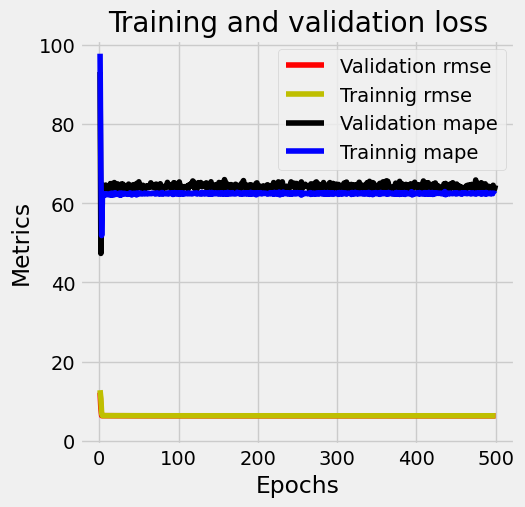

In [94]:
plotme(model1_3)
#val_loss2 = [x+1.8 for x in val_loss2]

In [19]:
# inputs: distance
model1_4 = nnmodel(10,10, num_hlayers=1,Epoch=500)
model1_4

Epoch 1/500
365/365 [==============================] - 1s 1ms/step - loss: 412813.9062 - distance_layer_loss: 22.9858 - traveltime_layer_loss: 589720.8750 - distance_layer_mape: 3907.1785 - distance_layer_rmse: 4.7944 - traveltime_layer_mape: 98.4789 - traveltime_layer_rmse: 767.9329 - val_loss: 383225.7812 - val_distance_layer_loss: 109.9774 - val_traveltime_layer_loss: 547402.5000 - val_distance_layer_mape: 1955290.1250 - val_distance_layer_rmse: 10.4870 - val_traveltime_layer_mape: 94.0220 - val_traveltime_layer_rmse: 739.8665
Epoch 2/500
365/365 [==============================] - 0s 983us/step - loss: 317146.1875 - distance_layer_loss: 621.1293 - traveltime_layer_loss: 452711.2188 - distance_layer_mape: 24571.1953 - distance_layer_rmse: 24.9225 - traveltime_layer_mape: 75.9376 - traveltime_layer_rmse: 672.8382 - val_loss: 207458.0156 - val_distance_layer_loss: 1494.5485 - val_traveltime_layer_loss: 295514.7188 - val_distance_layer_mape: 7091238.0000 - val_distance_layer_rmse: 38.65

365/365 [==============================] - 0s 966us/step - loss: 101842.5938 - distance_layer_loss: 3366.7424 - traveltime_layer_loss: 143565.4062 - distance_layer_mape: 59905.6641 - distance_layer_rmse: 58.0236 - traveltime_layer_mape: 62.1624 - traveltime_layer_rmse: 378.9003 - val_loss: 101446.8047 - val_distance_layer_loss: 3309.3916 - val_traveltime_layer_loss: 143033.0000 - val_distance_layer_mape: 10625605.0000 - val_distance_layer_rmse: 57.5273 - val_traveltime_layer_mape: 61.8810 - val_traveltime_layer_rmse: 378.1971
Epoch 17/500
365/365 [==============================] - 0s 1ms/step - loss: 101807.9297 - distance_layer_loss: 3315.5547 - traveltime_layer_loss: 143545.2812 - distance_layer_mape: 59441.2578 - distance_layer_rmse: 57.5809 - traveltime_layer_mape: 62.1412 - traveltime_layer_rmse: 378.8737 - val_loss: 101391.9062 - val_distance_layer_loss: 3256.6462 - val_traveltime_layer_loss: 142984.6250 - val_distance_layer_mape: 10547729.0000 - val_distance_layer_rmse: 57.0670 

365/365 [==============================] - 0s 1ms/step - loss: 101287.7969 - distance_layer_loss: 2723.5146 - traveltime_layer_loss: 143140.6719 - distance_layer_mape: 53968.0312 - distance_layer_rmse: 52.1873 - traveltime_layer_mape: 62.2282 - traveltime_layer_rmse: 378.3394 - val_loss: 100848.7344 - val_distance_layer_loss: 2695.4282 - val_traveltime_layer_loss: 142529.3594 - val_distance_layer_mape: 9660538.0000 - val_distance_layer_rmse: 51.9175 - val_traveltime_layer_mape: 62.2922 - val_traveltime_layer_rmse: 377.5306
Epoch 32/500
365/365 [==============================] - 0s 992us/step - loss: 101247.6562 - distance_layer_loss: 2690.0471 - traveltime_layer_loss: 143102.3594 - distance_layer_mape: 53629.8164 - distance_layer_rmse: 51.8657 - traveltime_layer_mape: 62.2604 - traveltime_layer_rmse: 378.2887 - val_loss: 100811.8672 - val_distance_layer_loss: 2659.9326 - val_traveltime_layer_loss: 142496.9688 - val_distance_layer_mape: 9600543.0000 - val_distance_layer_rmse: 51.5745 - 

365/365 [==============================] - 0s 987us/step - loss: 100906.8750 - distance_layer_loss: 2268.7119 - traveltime_layer_loss: 142856.1406 - distance_layer_mape: 49315.7227 - distance_layer_rmse: 47.6310 - traveltime_layer_mape: 62.2620 - traveltime_layer_rmse: 377.9631 - val_loss: 100517.0938 - val_distance_layer_loss: 2274.8228 - val_traveltime_layer_loss: 142295.9688 - val_distance_layer_mape: 8914265.0000 - val_distance_layer_rmse: 47.6951 - val_traveltime_layer_mape: 63.1029 - val_traveltime_layer_rmse: 377.2214
Epoch 47/500
365/365 [==============================] - 0s 968us/step - loss: 100893.3359 - distance_layer_loss: 2248.9153 - traveltime_layer_loss: 142848.2031 - distance_layer_mape: 49109.6602 - distance_layer_rmse: 47.4227 - traveltime_layer_mape: 62.3965 - traveltime_layer_rmse: 377.9526 - val_loss: 100446.0469 - val_distance_layer_loss: 2239.9619 - val_traveltime_layer_loss: 142214.3594 - val_distance_layer_mape: 8848322.0000 - val_distance_layer_rmse: 47.3282 

365/365 [==============================] - 0s 964us/step - loss: 100638.4062 - distance_layer_loss: 1934.6890 - traveltime_layer_loss: 142663.6719 - distance_layer_mape: 45599.6641 - distance_layer_rmse: 43.9851 - traveltime_layer_mape: 62.2948 - traveltime_layer_rmse: 377.7084 - val_loss: 100311.5000 - val_distance_layer_loss: 1959.5360 - val_traveltime_layer_loss: 142182.4062 - val_distance_layer_mape: 8296176.0000 - val_distance_layer_rmse: 44.2666 - val_traveltime_layer_mape: 63.6789 - val_traveltime_layer_rmse: 377.0708
Epoch 62/500
365/365 [==============================] - 0s 961us/step - loss: 100662.3203 - distance_layer_loss: 1922.8199 - traveltime_layer_loss: 142704.6562 - distance_layer_mape: 45453.1797 - distance_layer_rmse: 43.8500 - traveltime_layer_mape: 62.5250 - traveltime_layer_rmse: 377.7627 - val_loss: 100084.3281 - val_distance_layer_loss: 1902.7969 - val_traveltime_layer_loss: 141890.3125 - val_distance_layer_mape: 8177656.0000 - val_distance_layer_rmse: 43.6211 

365/365 [==============================] - 0s 979us/step - loss: 100442.3594 - distance_layer_loss: 1694.5073 - traveltime_layer_loss: 142520.6719 - distance_layer_mape: 42697.8594 - distance_layer_rmse: 41.1644 - traveltime_layer_mape: 62.5981 - traveltime_layer_rmse: 377.5191 - val_loss: 99852.6328 - val_distance_layer_loss: 1668.6963 - val_traveltime_layer_loss: 141693.0625 - val_distance_layer_mape: 7672138.5000 - val_distance_layer_rmse: 40.8497 - val_traveltime_layer_mape: 62.1305 - val_traveltime_layer_rmse: 376.4214
Epoch 77/500
365/365 [==============================] - 0s 988us/step - loss: 100430.2734 - distance_layer_loss: 1671.3107 - traveltime_layer_loss: 142516.7656 - distance_layer_mape: 42405.9648 - distance_layer_rmse: 40.8817 - traveltime_layer_mape: 62.2925 - traveltime_layer_rmse: 377.5139 - val_loss: 99957.1406 - val_distance_layer_loss: 1680.1799 - val_traveltime_layer_loss: 141835.7500 - val_distance_layer_mape: 7698214.0000 - val_distance_layer_rmse: 40.9900 - 

365/365 [==============================] - 0s 985us/step - loss: 100297.9375 - distance_layer_loss: 1494.5084 - traveltime_layer_loss: 142428.7656 - distance_layer_mape: 40110.2461 - distance_layer_rmse: 38.6589 - traveltime_layer_mape: 62.2558 - traveltime_layer_rmse: 377.3974 - val_loss: 99665.6953 - val_distance_layer_loss: 1468.8879 - val_traveltime_layer_loss: 141540.2188 - val_distance_layer_mape: 7206370.5000 - val_distance_layer_rmse: 38.3261 - val_traveltime_layer_mape: 61.6274 - val_traveltime_layer_rmse: 376.2183
Epoch 92/500
365/365 [==============================] - 0s 989us/step - loss: 100261.6719 - distance_layer_loss: 1485.1157 - traveltime_layer_loss: 142382.3438 - distance_layer_mape: 39980.2383 - distance_layer_rmse: 38.5372 - traveltime_layer_mape: 62.3353 - traveltime_layer_rmse: 377.3358 - val_loss: 99921.8516 - val_distance_layer_loss: 1508.3795 - val_traveltime_layer_loss: 141883.5625 - val_distance_layer_mape: 7300549.5000 - val_distance_layer_rmse: 38.8379 - 

365/365 [==============================] - 0s 988us/step - loss: 100185.5781 - distance_layer_loss: 1348.1610 - traveltime_layer_loss: 142351.8594 - distance_layer_mape: 38125.4180 - distance_layer_rmse: 36.7173 - traveltime_layer_mape: 62.4647 - traveltime_layer_rmse: 377.2954 - val_loss: 99566.7656 - val_distance_layer_loss: 1328.4869 - val_traveltime_layer_loss: 141479.1562 - val_distance_layer_mape: 6856749.5000 - val_distance_layer_rmse: 36.4484 - val_traveltime_layer_mape: 61.9736 - val_traveltime_layer_rmse: 376.1371
Epoch 107/500
365/365 [==============================] - 0s 998us/step - loss: 100166.9688 - distance_layer_loss: 1337.5120 - traveltime_layer_loss: 142331.3281 - distance_layer_mape: 37963.9805 - distance_layer_rmse: 36.5720 - traveltime_layer_mape: 62.4059 - traveltime_layer_rmse: 377.2682 - val_loss: 99546.0312 - val_distance_layer_loss: 1313.6570 - val_traveltime_layer_loss: 141458.0000 - val_distance_layer_mape: 6818824.5000 - val_distance_layer_rmse: 36.2444 -

365/365 [==============================] - 0s 1ms/step - loss: 100105.0469 - distance_layer_loss: 1226.2285 - traveltime_layer_loss: 142306.5156 - distance_layer_mape: 36359.5117 - distance_layer_rmse: 35.0175 - traveltime_layer_mape: 62.5477 - traveltime_layer_rmse: 377.2354 - val_loss: 99499.1250 - val_distance_layer_loss: 1212.4734 - val_traveltime_layer_loss: 141448.7188 - val_distance_layer_mape: 6551443.5000 - val_distance_layer_rmse: 34.8206 - val_traveltime_layer_mape: 62.2139 - val_traveltime_layer_rmse: 376.0967
Epoch 122/500
365/365 [==============================] - 0s 1ms/step - loss: 100100.8516 - distance_layer_loss: 1217.9714 - traveltime_layer_loss: 142305.3281 - distance_layer_mape: 36240.6406 - distance_layer_rmse: 34.8994 - traveltime_layer_mape: 62.5085 - traveltime_layer_rmse: 377.2338 - val_loss: 99464.1797 - val_distance_layer_loss: 1194.9204 - val_traveltime_layer_loss: 141408.8750 - val_distance_layer_mape: 6504234.0000 - val_distance_layer_rmse: 34.5676 - val

365/365 [==============================] - 0s 976us/step - loss: 100049.2344 - distance_layer_loss: 1121.4073 - traveltime_layer_loss: 142286.6719 - distance_layer_mape: 34782.5117 - distance_layer_rmse: 33.4874 - traveltime_layer_mape: 62.2824 - traveltime_layer_rmse: 377.2090 - val_loss: 99480.7734 - val_distance_layer_loss: 1122.4376 - val_traveltime_layer_loss: 141473.9531 - val_distance_layer_mape: 6303860.0000 - val_distance_layer_rmse: 33.5028 - val_traveltime_layer_mape: 62.6262 - val_traveltime_layer_rmse: 376.1302
Epoch 137/500
365/365 [==============================] - 0s 996us/step - loss: 100048.1406 - distance_layer_loss: 1117.9358 - traveltime_layer_loss: 142286.9688 - distance_layer_mape: 34717.0234 - distance_layer_rmse: 33.4355 - traveltime_layer_mape: 62.4033 - traveltime_layer_rmse: 377.2094 - val_loss: 99620.7031 - val_distance_layer_loss: 1133.3525 - val_traveltime_layer_loss: 141667.6406 - val_distance_layer_mape: 6333778.0000 - val_distance_layer_rmse: 33.6653 -

365/365 [==============================] - 0s 969us/step - loss: 100034.5469 - distance_layer_loss: 1036.6868 - traveltime_layer_loss: 142314.0938 - distance_layer_mape: 33432.5859 - distance_layer_rmse: 32.1976 - traveltime_layer_mape: 62.1106 - traveltime_layer_rmse: 377.2454 - val_loss: 99388.6484 - val_distance_layer_loss: 1032.4415 - val_traveltime_layer_loss: 141393.8438 - val_distance_layer_mape: 6045604.0000 - val_distance_layer_rmse: 32.1316 - val_traveltime_layer_mape: 62.1543 - val_traveltime_layer_rmse: 376.0237
Epoch 152/500
365/365 [==============================] - 0s 973us/step - loss: 99996.2344 - distance_layer_loss: 1041.5525 - traveltime_layer_loss: 142256.6094 - distance_layer_mape: 33523.2344 - distance_layer_rmse: 32.2731 - traveltime_layer_mape: 62.6725 - traveltime_layer_rmse: 377.1692 - val_loss: 99358.3281 - val_distance_layer_loss: 1018.6951 - val_traveltime_layer_loss: 141358.4375 - val_distance_layer_mape: 6005739.0000 - val_distance_layer_rmse: 31.9170 - 

365/365 [==============================] - 0s 993us/step - loss: 99946.4922 - distance_layer_loss: 974.2782 - traveltime_layer_loss: 142224.0000 - distance_layer_mape: 32434.0605 - distance_layer_rmse: 31.2134 - traveltime_layer_mape: 62.4875 - traveltime_layer_rmse: 377.1260 - val_loss: 99440.5156 - val_distance_layer_loss: 977.0141 - val_traveltime_layer_loss: 141499.5625 - val_distance_layer_mape: 5880519.0000 - val_distance_layer_rmse: 31.2572 - val_traveltime_layer_mape: 62.9165 - val_traveltime_layer_rmse: 376.1643
Epoch 167/500
365/365 [==============================] - 0s 976us/step - loss: 99965.9219 - distance_layer_loss: 974.6194 - traveltime_layer_loss: 142251.5000 - distance_layer_mape: 32422.9629 - distance_layer_rmse: 31.2189 - traveltime_layer_mape: 62.7462 - traveltime_layer_rmse: 377.1624 - val_loss: 99320.7422 - val_distance_layer_loss: 949.5714 - val_traveltime_layer_loss: 141344.0938 - val_distance_layer_mape: 5798200.0000 - val_distance_layer_rmse: 30.8151 - val_t

365/365 [==============================] - 0s 965us/step - loss: 99921.2266 - distance_layer_loss: 914.7816 - traveltime_layer_loss: 142221.9219 - distance_layer_mape: 31416.7246 - distance_layer_rmse: 30.2454 - traveltime_layer_mape: 62.4512 - traveltime_layer_rmse: 377.1232 - val_loss: 99472.4219 - val_distance_layer_loss: 923.9218 - val_traveltime_layer_loss: 141575.5312 - val_distance_layer_mape: 5717499.0000 - val_distance_layer_rmse: 30.3961 - val_traveltime_layer_mape: 63.2793 - val_traveltime_layer_rmse: 376.2652
Epoch 182/500
365/365 [==============================] - 0s 975us/step - loss: 99916.8516 - distance_layer_loss: 914.3698 - traveltime_layer_loss: 142215.8438 - distance_layer_mape: 31415.1113 - distance_layer_rmse: 30.2385 - traveltime_layer_mape: 62.6577 - traveltime_layer_rmse: 377.1152 - val_loss: 99328.3516 - val_distance_layer_loss: 903.0980 - val_traveltime_layer_loss: 141381.6094 - val_distance_layer_mape: 5653234.0000 - val_distance_layer_rmse: 30.0516 - val_t

365/365 [==============================] - 0s 987us/step - loss: 99920.2344 - distance_layer_loss: 865.5424 - traveltime_layer_loss: 142248.5312 - distance_layer_mape: 30569.3613 - distance_layer_rmse: 29.4201 - traveltime_layer_mape: 62.5576 - traveltime_layer_rmse: 377.1585 - val_loss: 99359.4531 - val_distance_layer_loss: 863.9173 - val_traveltime_layer_loss: 141448.4844 - val_distance_layer_mape: 5528228.5000 - val_distance_layer_rmse: 29.3925 - val_traveltime_layer_mape: 62.6796 - val_traveltime_layer_rmse: 376.0964
Epoch 197/500
365/365 [==============================] - 0s 983us/step - loss: 99888.3203 - distance_layer_loss: 861.3867 - traveltime_layer_loss: 142205.2969 - distance_layer_mape: 30505.6445 - distance_layer_rmse: 29.3494 - traveltime_layer_mape: 62.5254 - traveltime_layer_rmse: 377.1012 - val_loss: 99289.2266 - val_distance_layer_loss: 849.4848 - val_traveltime_layer_loss: 141356.3438 - val_distance_layer_mape: 5482463.0000 - val_distance_layer_rmse: 29.1459 - val_t

365/365 [==============================] - 0s 989us/step - loss: 99856.4141 - distance_layer_loss: 815.5637 - traveltime_layer_loss: 142186.0625 - distance_layer_mape: 29682.0332 - distance_layer_rmse: 28.5581 - traveltime_layer_mape: 62.2321 - traveltime_layer_rmse: 377.0757 - val_loss: 99655.1094 - val_distance_layer_loss: 841.9872 - val_traveltime_layer_loss: 141883.3281 - val_distance_layer_mape: 5456430.0000 - val_distance_layer_rmse: 29.0170 - val_traveltime_layer_mape: 64.2784 - val_traveltime_layer_rmse: 376.6740
Epoch 212/500
365/365 [==============================] - 0s 993us/step - loss: 99863.3750 - distance_layer_loss: 823.0053 - traveltime_layer_loss: 142191.6406 - distance_layer_mape: 29817.1660 - distance_layer_rmse: 28.6881 - traveltime_layer_mape: 62.9108 - traveltime_layer_rmse: 377.0831 - val_loss: 99255.3984 - val_distance_layer_loss: 791.6276 - val_traveltime_layer_loss: 141341.0625 - val_distance_layer_mape: 5292493.5000 - val_distance_layer_rmse: 28.1359 - val_t

365/365 [==============================] - 0s 993us/step - loss: 99858.7188 - distance_layer_loss: 777.8219 - traveltime_layer_loss: 142210.8750 - distance_layer_mape: 28978.6758 - distance_layer_rmse: 27.8895 - traveltime_layer_mape: 62.3054 - traveltime_layer_rmse: 377.1086 - val_loss: 99385.4922 - val_distance_layer_loss: 785.8739 - val_traveltime_layer_loss: 141530.2188 - val_distance_layer_mape: 5271532.5000 - val_distance_layer_rmse: 28.0334 - val_traveltime_layer_mape: 63.0992 - val_traveltime_layer_rmse: 376.2050
Epoch 227/500
365/365 [==============================] - 0s 974us/step - loss: 99867.3594 - distance_layer_loss: 775.8124 - traveltime_layer_loss: 142224.2969 - distance_layer_mape: 28946.5449 - distance_layer_rmse: 27.8534 - traveltime_layer_mape: 62.3708 - traveltime_layer_rmse: 377.1264 - val_loss: 99528.9766 - val_distance_layer_loss: 793.6833 - val_traveltime_layer_loss: 141730.7656 - val_distance_layer_mape: 5296960.0000 - val_distance_layer_rmse: 28.1724 - val_t

365/365 [==============================] - 0s 984us/step - loss: 99847.2266 - distance_layer_loss: 742.9712 - traveltime_layer_loss: 142214.3594 - distance_layer_mape: 28329.5723 - distance_layer_rmse: 27.2575 - traveltime_layer_mape: 62.3435 - traveltime_layer_rmse: 377.1132 - val_loss: 99294.7266 - val_distance_layer_loss: 743.1529 - val_traveltime_layer_loss: 141424.9688 - val_distance_layer_mape: 5126594.0000 - val_distance_layer_rmse: 27.2608 - val_traveltime_layer_mape: 62.5532 - val_traveltime_layer_rmse: 376.0651
Epoch 242/500
365/365 [==============================] - 0s 986us/step - loss: 99835.7500 - distance_layer_loss: 745.0337 - traveltime_layer_loss: 142196.8125 - distance_layer_mape: 28373.3438 - distance_layer_rmse: 27.2953 - traveltime_layer_mape: 62.6591 - traveltime_layer_rmse: 377.0899 - val_loss: 99222.2812 - val_distance_layer_loss: 725.1135 - val_traveltime_layer_loss: 141331.8281 - val_distance_layer_mape: 5065687.5000 - val_distance_layer_rmse: 26.9279 - val_t

365/365 [==============================] - 0s 985us/step - loss: 99846.0156 - distance_layer_loss: 716.9487 - traveltime_layer_loss: 142227.4219 - distance_layer_mape: 27833.7422 - distance_layer_rmse: 26.7759 - traveltime_layer_mape: 62.7255 - traveltime_layer_rmse: 377.1305 - val_loss: 99226.5078 - val_distance_layer_loss: 703.5245 - val_traveltime_layer_loss: 141350.1250 - val_distance_layer_mape: 4988882.5000 - val_distance_layer_rmse: 26.5240 - val_traveltime_layer_mape: 61.9129 - val_traveltime_layer_rmse: 375.9656
Epoch 257/500
365/365 [==============================] - 0s 988us/step - loss: 99806.0469 - distance_layer_loss: 713.6086 - traveltime_layer_loss: 142172.3906 - distance_layer_mape: 27758.9902 - distance_layer_rmse: 26.7135 - traveltime_layer_mape: 62.6383 - traveltime_layer_rmse: 377.0576 - val_loss: 99209.3281 - val_distance_layer_loss: 693.8918 - val_traveltime_layer_loss: 141331.1250 - val_distance_layer_mape: 4955309.5000 - val_distance_layer_rmse: 26.3418 - val_t

365/365 [==============================] - 0s 993us/step - loss: 99823.2188 - distance_layer_loss: 686.0388 - traveltime_layer_loss: 142212.5938 - distance_layer_mape: 27232.7031 - distance_layer_rmse: 26.1923 - traveltime_layer_mape: 62.5102 - traveltime_layer_rmse: 377.1108 - val_loss: 99216.7266 - val_distance_layer_loss: 675.9432 - val_traveltime_layer_loss: 141351.8906 - val_distance_layer_mape: 4890235.5000 - val_distance_layer_rmse: 25.9989 - val_traveltime_layer_mape: 61.9370 - val_traveltime_layer_rmse: 375.9679
Epoch 272/500
365/365 [==============================] - 0s 990us/step - loss: 99814.6953 - distance_layer_loss: 681.8471 - traveltime_layer_loss: 142202.7188 - distance_layer_mape: 27150.8555 - distance_layer_rmse: 26.1122 - traveltime_layer_mape: 62.3632 - traveltime_layer_rmse: 377.0977 - val_loss: 99254.3672 - val_distance_layer_loss: 680.1846 - val_traveltime_layer_loss: 141403.3281 - val_distance_layer_mape: 4905812.5000 - val_distance_layer_rmse: 26.0803 - val_t

365/365 [==============================] - 0s 966us/step - loss: 99758.4062 - distance_layer_loss: 656.8260 - traveltime_layer_loss: 142136.7031 - distance_layer_mape: 26651.8887 - distance_layer_rmse: 25.6286 - traveltime_layer_mape: 62.2625 - traveltime_layer_rmse: 377.0102 - val_loss: 99518.5312 - val_distance_layer_loss: 675.4544 - val_traveltime_layer_loss: 141783.3594 - val_distance_layer_mape: 4887446.5000 - val_distance_layer_rmse: 25.9895 - val_traveltime_layer_mape: 63.9953 - val_traveltime_layer_rmse: 376.5413
Epoch 287/500
365/365 [==============================] - 0s 965us/step - loss: 99815.8125 - distance_layer_loss: 658.9294 - traveltime_layer_loss: 142217.4062 - distance_layer_mape: 26700.5781 - distance_layer_rmse: 25.6696 - traveltime_layer_mape: 62.5780 - traveltime_layer_rmse: 377.1172 - val_loss: 99364.6328 - val_distance_layer_loss: 664.9299 - val_traveltime_layer_loss: 141569.5781 - val_distance_layer_mape: 4849504.0000 - val_distance_layer_rmse: 25.7862 - val_t

365/365 [==============================] - 0s 981us/step - loss: 99815.0391 - distance_layer_loss: 633.5447 - traveltime_layer_loss: 142230.8906 - distance_layer_mape: 26174.9375 - distance_layer_rmse: 25.1703 - traveltime_layer_mape: 62.3304 - traveltime_layer_rmse: 377.1351 - val_loss: 99213.7656 - val_distance_layer_loss: 629.7792 - val_traveltime_layer_loss: 141374.0625 - val_distance_layer_mape: 4720843.0000 - val_distance_layer_rmse: 25.0954 - val_traveltime_layer_mape: 62.1819 - val_traveltime_layer_rmse: 375.9974
Epoch 302/500
365/365 [==============================] - 0s 974us/step - loss: 99822.7891 - distance_layer_loss: 633.1163 - traveltime_layer_loss: 142242.2344 - distance_layer_mape: 26163.5273 - distance_layer_rmse: 25.1618 - traveltime_layer_mape: 62.4072 - traveltime_layer_rmse: 377.1501 - val_loss: 99251.8984 - val_distance_layer_loss: 632.8669 - val_traveltime_layer_loss: 141426.7500 - val_distance_layer_mape: 4731644.0000 - val_distance_layer_rmse: 25.1568 - val_t

365/365 [==============================] - 0s 976us/step - loss: 99813.8047 - distance_layer_loss: 615.5287 - traveltime_layer_loss: 142239.4062 - distance_layer_mape: 25799.0723 - distance_layer_rmse: 24.8099 - traveltime_layer_mape: 62.6589 - traveltime_layer_rmse: 377.1464 - val_loss: 99241.6641 - val_distance_layer_loss: 612.2834 - val_traveltime_layer_loss: 141423.9219 - val_distance_layer_mape: 4654806.5000 - val_distance_layer_rmse: 24.7444 - val_traveltime_layer_mape: 62.5599 - val_traveltime_layer_rmse: 376.0637
Epoch 317/500
365/365 [==============================] - 0s 994us/step - loss: 99763.6250 - distance_layer_loss: 615.1262 - traveltime_layer_loss: 142167.9688 - distance_layer_mape: 25800.7930 - distance_layer_rmse: 24.8017 - traveltime_layer_mape: 62.7437 - traveltime_layer_rmse: 377.0517 - val_loss: 99195.5391 - val_distance_layer_loss: 588.1754 - val_traveltime_layer_loss: 141371.8906 - val_distance_layer_mape: 4564238.5000 - val_distance_layer_rmse: 24.2523 - val_t

365/365 [==============================] - 0s 970us/step - loss: 99787.2734 - distance_layer_loss: 595.1614 - traveltime_layer_loss: 142213.0938 - distance_layer_mape: 25379.8125 - distance_layer_rmse: 24.3959 - traveltime_layer_mape: 62.6823 - traveltime_layer_rmse: 377.1115 - val_loss: 99200.2031 - val_distance_layer_loss: 588.2474 - val_traveltime_layer_loss: 141378.4062 - val_distance_layer_mape: 4563586.5000 - val_distance_layer_rmse: 24.2538 - val_traveltime_layer_mape: 62.2430 - val_traveltime_layer_rmse: 376.0032
Epoch 332/500
365/365 [==============================] - 0s 969us/step - loss: 99786.3516 - distance_layer_loss: 592.4846 - traveltime_layer_loss: 142213.4219 - distance_layer_mape: 25318.4336 - distance_layer_rmse: 24.3410 - traveltime_layer_mape: 62.5256 - traveltime_layer_rmse: 377.1119 - val_loss: 99163.7500 - val_distance_layer_loss: 574.4539 - val_traveltime_layer_loss: 141334.2656 - val_distance_layer_mape: 4510822.5000 - val_distance_layer_rmse: 23.9678 - val_t

365/365 [==============================] - 0s 998us/step - loss: 99793.7109 - distance_layer_loss: 575.1127 - traveltime_layer_loss: 142233.8281 - distance_layer_mape: 24949.0391 - distance_layer_rmse: 23.9815 - traveltime_layer_mape: 62.5525 - traveltime_layer_rmse: 377.1390 - val_loss: 99192.2891 - val_distance_layer_loss: 569.7462 - val_traveltime_layer_loss: 141377.6719 - val_distance_layer_mape: 4491876.0000 - val_distance_layer_rmse: 23.8694 - val_traveltime_layer_mape: 62.2464 - val_traveltime_layer_rmse: 376.0022
Epoch 347/500
365/365 [==============================] - 0s 973us/step - loss: 99778.4297 - distance_layer_loss: 573.9926 - traveltime_layer_loss: 142212.5938 - distance_layer_mape: 24924.3203 - distance_layer_rmse: 23.9581 - traveltime_layer_mape: 62.5517 - traveltime_layer_rmse: 377.1108 - val_loss: 99164.1719 - val_distance_layer_loss: 563.9800 - val_traveltime_layer_loss: 141340.8750 - val_distance_layer_mape: 4469600.5000 - val_distance_layer_rmse: 23.7483 - val_t

365/365 [==============================] - 0s 964us/step - loss: 99777.1562 - distance_layer_loss: 554.4420 - traveltime_layer_loss: 142221.9844 - distance_layer_mape: 24503.1816 - distance_layer_rmse: 23.5466 - traveltime_layer_mape: 62.2694 - traveltime_layer_rmse: 377.1233 - val_loss: 99306.2188 - val_distance_layer_loss: 562.3464 - val_traveltime_layer_loss: 141544.6875 - val_distance_layer_mape: 4461825.0000 - val_distance_layer_rmse: 23.7138 - val_traveltime_layer_mape: 63.1815 - val_traveltime_layer_rmse: 376.2242
Epoch 362/500
365/365 [==============================] - 0s 963us/step - loss: 99787.8125 - distance_layer_loss: 556.4766 - traveltime_layer_loss: 142236.0312 - distance_layer_mape: 24547.2246 - distance_layer_rmse: 23.5898 - traveltime_layer_mape: 62.5615 - traveltime_layer_rmse: 377.1419 - val_loss: 99202.3125 - val_distance_layer_loss: 553.2250 - val_traveltime_layer_loss: 141401.4375 - val_distance_layer_mape: 4426313.5000 - val_distance_layer_rmse: 23.5207 - val_t

365/365 [==============================] - 0s 970us/step - loss: 99758.0547 - distance_layer_loss: 538.5067 - traveltime_layer_loss: 142203.7812 - distance_layer_mape: 24140.3008 - distance_layer_rmse: 23.2057 - traveltime_layer_mape: 62.2981 - traveltime_layer_rmse: 377.0992 - val_loss: 99346.9766 - val_distance_layer_loss: 548.5508 - val_traveltime_layer_loss: 141610.7969 - val_distance_layer_mape: 4406823.0000 - val_distance_layer_rmse: 23.4212 - val_traveltime_layer_mape: 63.4454 - val_traveltime_layer_rmse: 376.3121
Epoch 377/500
365/365 [==============================] - 0s 978us/step - loss: 99768.9844 - distance_layer_loss: 540.2377 - traveltime_layer_loss: 142218.5000 - distance_layer_mape: 24180.6797 - distance_layer_rmse: 23.2430 - traveltime_layer_mape: 62.5722 - traveltime_layer_rmse: 377.1187 - val_loss: 99214.3047 - val_distance_layer_loss: 538.7410 - val_traveltime_layer_loss: 141426.8438 - val_distance_layer_mape: 4368057.0000 - val_distance_layer_rmse: 23.2108 - val_t

365/365 [==============================] - 0s 967us/step - loss: 99759.2891 - distance_layer_loss: 524.7662 - traveltime_layer_loss: 142213.4219 - distance_layer_mape: 23837.2012 - distance_layer_rmse: 22.9078 - traveltime_layer_mape: 62.4329 - traveltime_layer_rmse: 377.1119 - val_loss: 99183.8438 - val_distance_layer_loss: 522.3641 - val_traveltime_layer_loss: 141392.7188 - val_distance_layer_mape: 4301692.0000 - val_distance_layer_rmse: 22.8553 - val_traveltime_layer_mape: 62.3669 - val_traveltime_layer_rmse: 376.0222
Epoch 392/500
365/365 [==============================] - 0s 978us/step - loss: 99748.6641 - distance_layer_loss: 523.3815 - traveltime_layer_loss: 142199.0312 - distance_layer_mape: 23808.9219 - distance_layer_rmse: 22.8775 - traveltime_layer_mape: 62.4108 - traveltime_layer_rmse: 377.0929 - val_loss: 99336.9375 - val_distance_layer_loss: 531.9968 - val_traveltime_layer_loss: 141605.9531 - val_distance_layer_mape: 4340386.5000 - val_distance_layer_rmse: 23.0651 - val_t

365/365 [==============================] - 0s 972us/step - loss: 99777.4375 - distance_layer_loss: 510.8782 - traveltime_layer_loss: 142247.2812 - distance_layer_mape: 23522.6328 - distance_layer_rmse: 22.6026 - traveltime_layer_mape: 62.4797 - traveltime_layer_rmse: 377.1568 - val_loss: 99244.3828 - val_distance_layer_loss: 513.5663 - val_traveltime_layer_loss: 141484.1875 - val_distance_layer_mape: 4265366.5000 - val_distance_layer_rmse: 22.6620 - val_traveltime_layer_mape: 62.9106 - val_traveltime_layer_rmse: 376.1438
Epoch 407/500
365/365 [==============================] - 0s 996us/step - loss: 99739.3594 - distance_layer_loss: 509.8044 - traveltime_layer_loss: 142193.4844 - distance_layer_mape: 23494.0566 - distance_layer_rmse: 22.5788 - traveltime_layer_mape: 62.4417 - traveltime_layer_rmse: 377.0855 - val_loss: 99297.3281 - val_distance_layer_loss: 515.8851 - val_traveltime_layer_loss: 141558.6562 - val_distance_layer_mape: 4274386.5000 - val_distance_layer_rmse: 22.7131 - val_t

365/365 [==============================] - 0s 971us/step - loss: 99769.6328 - distance_layer_loss: 497.8624 - traveltime_layer_loss: 142243.5625 - distance_layer_mape: 23225.4902 - distance_layer_rmse: 22.3128 - traveltime_layer_mape: 62.5819 - traveltime_layer_rmse: 377.1519 - val_loss: 99172.4531 - val_distance_layer_loss: 494.6636 - val_traveltime_layer_loss: 141392.2500 - val_distance_layer_mape: 4187010.2500 - val_distance_layer_rmse: 22.2410 - val_traveltime_layer_mape: 62.3801 - val_traveltime_layer_rmse: 376.0216
Epoch 422/500
365/365 [==============================] - 0s 982us/step - loss: 99764.2109 - distance_layer_loss: 495.0252 - traveltime_layer_loss: 142237.3281 - distance_layer_mape: 23157.8066 - distance_layer_rmse: 22.2492 - traveltime_layer_mape: 62.3642 - traveltime_layer_rmse: 377.1436 - val_loss: 99138.7188 - val_distance_layer_loss: 489.7075 - val_traveltime_layer_loss: 141346.7969 - val_distance_layer_mape: 4166448.7500 - val_distance_layer_rmse: 22.1293 - val_t

365/365 [==============================] - 0s 972us/step - loss: 99744.0625 - distance_layer_loss: 486.1061 - traveltime_layer_loss: 142213.8125 - distance_layer_mape: 22953.5527 - distance_layer_rmse: 22.0478 - traveltime_layer_mape: 62.6526 - traveltime_layer_rmse: 377.1125 - val_loss: 99188.7734 - val_distance_layer_loss: 483.8370 - val_traveltime_layer_loss: 141421.7500 - val_distance_layer_mape: 4141313.2500 - val_distance_layer_rmse: 21.9963 - val_traveltime_layer_mape: 62.5894 - val_traveltime_layer_rmse: 376.0608
Epoch 437/500
365/365 [==============================] - 0s 985us/step - loss: 99744.6016 - distance_layer_loss: 484.1697 - traveltime_layer_loss: 142215.5312 - distance_layer_mape: 22905.8906 - distance_layer_rmse: 22.0039 - traveltime_layer_mape: 62.5608 - traveltime_layer_rmse: 377.1147 - val_loss: 99138.7734 - val_distance_layer_loss: 477.7427 - val_traveltime_layer_loss: 141353.7656 - val_distance_layer_mape: 4115342.5000 - val_distance_layer_rmse: 21.8573 - val_t

365/365 [==============================] - 0s 983us/step - loss: 99780.9844 - distance_layer_loss: 470.5642 - traveltime_layer_loss: 142275.3125 - distance_layer_mape: 22590.0176 - distance_layer_rmse: 21.6925 - traveltime_layer_mape: 62.3299 - traveltime_layer_rmse: 377.1940 - val_loss: 99206.9375 - val_distance_layer_loss: 473.2529 - val_traveltime_layer_loss: 141453.7812 - val_distance_layer_mape: 4096472.7500 - val_distance_layer_rmse: 21.7544 - val_traveltime_layer_mape: 62.7677 - val_traveltime_layer_rmse: 376.1034
Epoch 452/500
365/365 [==============================] - 0s 978us/step - loss: 99745.2188 - distance_layer_loss: 474.8515 - traveltime_layer_loss: 142221.8906 - distance_layer_mape: 22681.5352 - distance_layer_rmse: 21.7911 - traveltime_layer_mape: 62.8323 - traveltime_layer_rmse: 377.1232 - val_loss: 99112.6484 - val_distance_layer_loss: 460.7596 - val_traveltime_layer_loss: 141326.2188 - val_distance_layer_mape: 4042534.7500 - val_distance_layer_rmse: 21.4653 - val_t

365/365 [==============================] - 0s 970us/step - loss: 99746.6250 - distance_layer_loss: 459.5121 - traveltime_layer_loss: 142232.5312 - distance_layer_mape: 22311.9492 - distance_layer_rmse: 21.4362 - traveltime_layer_mape: 62.3362 - traveltime_layer_rmse: 377.1373 - val_loss: 99123.3750 - val_distance_layer_loss: 454.1548 - val_traveltime_layer_loss: 141345.2969 - val_distance_layer_mape: 4013653.7500 - val_distance_layer_rmse: 21.3109 - val_traveltime_layer_mape: 61.9210 - val_traveltime_layer_rmse: 375.9592
Epoch 467/500
365/365 [==============================] - 0s 968us/step - loss: 99726.8438 - distance_layer_loss: 458.8991 - traveltime_layer_loss: 142204.5625 - distance_layer_mape: 22306.1172 - distance_layer_rmse: 21.4219 - traveltime_layer_mape: 62.3777 - traveltime_layer_rmse: 377.1002 - val_loss: 99373.0469 - val_distance_layer_loss: 469.7473 - val_traveltime_layer_loss: 141693.0938 - val_distance_layer_mape: 4080706.7500 - val_distance_layer_rmse: 21.6737 - val_t

365/365 [==============================] - 0s 978us/step - loss: 99738.7656 - distance_layer_loss: 450.6185 - traveltime_layer_loss: 142226.4062 - distance_layer_mape: 22101.8066 - distance_layer_rmse: 21.2278 - traveltime_layer_mape: 62.5501 - traveltime_layer_rmse: 377.1292 - val_loss: 99226.8359 - val_distance_layer_loss: 452.9274 - val_traveltime_layer_loss: 141493.8125 - val_distance_layer_mape: 4007045.5000 - val_distance_layer_rmse: 21.2821 - val_traveltime_layer_mape: 62.9714 - val_traveltime_layer_rmse: 376.1566
Epoch 482/500
365/365 [==============================] - 0s 1ms/step - loss: 99716.6250 - distance_layer_loss: 448.8421 - traveltime_layer_loss: 142195.8438 - distance_layer_mape: 22059.4082 - distance_layer_rmse: 21.1859 - traveltime_layer_mape: 62.4174 - traveltime_layer_rmse: 377.0887 - val_loss: 99354.1875 - val_distance_layer_loss: 458.3938 - val_traveltime_layer_loss: 141672.6094 - val_distance_layer_mape: 4030746.0000 - val_distance_layer_rmse: 21.4101 - val_tra

365/365 [==============================] - 0s 961us/step - loss: 99736.1094 - distance_layer_loss: 439.9344 - traveltime_layer_loss: 142228.7969 - distance_layer_mape: 21839.0430 - distance_layer_rmse: 20.9746 - traveltime_layer_mape: 62.5227 - traveltime_layer_rmse: 377.1323 - val_loss: 99144.7500 - val_distance_layer_loss: 437.0008 - val_traveltime_layer_loss: 141385.5938 - val_distance_layer_mape: 3937058.2500 - val_distance_layer_rmse: 20.9046 - val_traveltime_layer_mape: 62.3324 - val_traveltime_layer_rmse: 376.0128
Epoch 497/500
365/365 [==============================] - 0s 976us/step - loss: 99731.4766 - distance_layer_loss: 439.4726 - traveltime_layer_loss: 142222.3750 - distance_layer_mape: 21824.6074 - distance_layer_rmse: 20.9636 - traveltime_layer_mape: 62.5408 - traveltime_layer_rmse: 377.1238 - val_loss: 99119.0938 - val_distance_layer_loss: 433.4133 - val_traveltime_layer_loss: 141350.9844 - val_distance_layer_mape: 3920965.7500 - val_distance_layer_rmse: 20.8186 - val_t

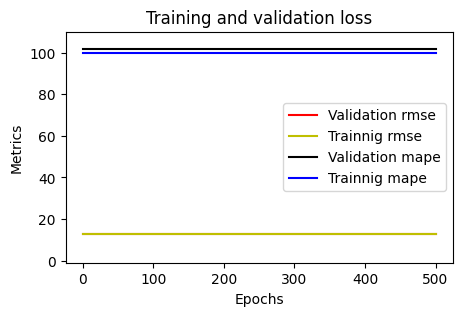

In [35]:
plotme(model1_4)

In [20]:
# inputs: distance
model1_5 = nnmodel(20,30, num_hlayers=1,Epoch=500)
model1_5

Epoch 1/500
365/365 [==============================] - 1s 1ms/step - loss: 393749.6875 - distance_layer_loss: 66.4404 - traveltime_layer_loss: 562461.3750 - distance_layer_mape: 6371.0605 - distance_layer_rmse: 8.1511 - traveltime_layer_mape: 94.1377 - traveltime_layer_rmse: 749.9742 - val_loss: 298163.1250 - val_distance_layer_loss: 317.5102 - val_traveltime_layer_loss: 425765.8125 - val_distance_layer_mape: 3285489.0000 - val_distance_layer_rmse: 17.8188 - val_traveltime_layer_mape: 72.8095 - val_traveltime_layer_rmse: 652.5073
Epoch 2/500
365/365 [==============================] - 0s 1000us/step - loss: 158063.5625 - distance_layer_loss: 1098.6819 - traveltime_layer_loss: 225177.2031 - distance_layer_mape: 33630.8047 - distance_layer_rmse: 33.1464 - traveltime_layer_mape: 55.0065 - traveltime_layer_rmse: 474.5284 - val_loss: 101163.0859 - val_distance_layer_loss: 1608.8091 - val_traveltime_layer_loss: 143599.4375 - val_distance_layer_mape: 7351299.0000 - val_distance_layer_rmse: 40.

365/365 [==============================] - 0s 999us/step - loss: 100906.3750 - distance_layer_loss: 1409.7717 - traveltime_layer_loss: 143346.4219 - distance_layer_mape: 38846.4648 - distance_layer_rmse: 37.5469 - traveltime_layer_mape: 62.5096 - traveltime_layer_rmse: 378.6112 - val_loss: 100426.7344 - val_distance_layer_loss: 1366.0690 - val_traveltime_layer_loss: 142686.1250 - val_distance_layer_mape: 6870410.0000 - val_distance_layer_rmse: 36.9604 - val_traveltime_layer_mape: 60.9837 - val_traveltime_layer_rmse: 377.7382
Epoch 17/500
365/365 [==============================] - 0s 985us/step - loss: 100892.7734 - distance_layer_loss: 1384.6680 - traveltime_layer_loss: 143341.3281 - distance_layer_mape: 38499.8242 - distance_layer_rmse: 37.2111 - traveltime_layer_mape: 62.1041 - traveltime_layer_rmse: 378.6045 - val_loss: 100397.8984 - val_distance_layer_loss: 1364.1462 - val_traveltime_layer_loss: 142646.0938 - val_distance_layer_mape: 6870214.0000 - val_distance_layer_rmse: 36.9343 

365/365 [==============================] - 0s 970us/step - loss: 100510.7578 - distance_layer_loss: 1170.5472 - traveltime_layer_loss: 142917.8906 - distance_layer_mape: 35473.4258 - distance_layer_rmse: 34.2133 - traveltime_layer_mape: 62.1846 - traveltime_layer_rmse: 378.0448 - val_loss: 100120.9219 - val_distance_layer_loss: 1176.7131 - val_traveltime_layer_loss: 142357.4844 - val_distance_layer_mape: 6422671.5000 - val_distance_layer_rmse: 34.3033 - val_traveltime_layer_mape: 63.3272 - val_traveltime_layer_rmse: 377.3029
Epoch 32/500
365/365 [==============================] - 0s 989us/step - loss: 100476.2344 - distance_layer_loss: 1162.3579 - traveltime_layer_loss: 142873.1562 - distance_layer_mape: 35353.5312 - distance_layer_rmse: 34.0934 - traveltime_layer_mape: 62.4952 - traveltime_layer_rmse: 377.9857 - val_loss: 100023.3281 - val_distance_layer_loss: 1156.6569 - val_traveltime_layer_loss: 142229.4688 - val_distance_layer_mape: 6370032.0000 - val_distance_layer_rmse: 34.0097 

365/365 [==============================] - 0s 987us/step - loss: 100225.3359 - distance_layer_loss: 997.7517 - traveltime_layer_loss: 142608.9531 - distance_layer_mape: 32791.6719 - distance_layer_rmse: 31.5872 - traveltime_layer_mape: 62.5314 - traveltime_layer_rmse: 377.6360 - val_loss: 99637.8047 - val_distance_layer_loss: 965.4581 - val_traveltime_layer_loss: 141788.0312 - val_distance_layer_mape: 5840291.5000 - val_distance_layer_rmse: 31.0718 - val_traveltime_layer_mape: 60.8354 - val_traveltime_layer_rmse: 376.5475
Epoch 47/500
365/365 [==============================] - 0s 1ms/step - loss: 100223.2734 - distance_layer_loss: 983.2288 - traveltime_layer_loss: 142614.3125 - distance_layer_mape: 32564.8984 - distance_layer_rmse: 31.3565 - traveltime_layer_mape: 62.2352 - traveltime_layer_rmse: 377.6431 - val_loss: 99857.3516 - val_distance_layer_loss: 994.3017 - val_traveltime_layer_loss: 142085.1406 - val_distance_layer_mape: 5925692.0000 - val_distance_layer_rmse: 31.5325 - val_tr

365/365 [==============================] - 0s 989us/step - loss: 100047.2500 - distance_layer_loss: 863.5803 - traveltime_layer_loss: 142431.2500 - distance_layer_mape: 30530.1211 - distance_layer_rmse: 29.3867 - traveltime_layer_mape: 62.4984 - traveltime_layer_rmse: 377.4006 - val_loss: 99455.0938 - val_distance_layer_loss: 851.2663 - val_traveltime_layer_loss: 141592.2812 - val_distance_layer_mape: 5493822.0000 - val_distance_layer_rmse: 29.1765 - val_traveltime_layer_mape: 62.0289 - val_traveltime_layer_rmse: 376.2875
Epoch 62/500
365/365 [==============================] - 0s 983us/step - loss: 100064.7344 - distance_layer_loss: 854.4619 - traveltime_layer_loss: 142461.3594 - distance_layer_mape: 30379.4531 - distance_layer_rmse: 29.2312 - traveltime_layer_mape: 62.3984 - traveltime_layer_rmse: 377.4406 - val_loss: 99528.3281 - val_distance_layer_loss: 853.5840 - val_traveltime_layer_loss: 141695.6094 - val_distance_layer_mape: 5500711.0000 - val_distance_layer_rmse: 29.2162 - val_

365/365 [==============================] - 0s 984us/step - loss: 99977.1094 - distance_layer_loss: 763.1116 - traveltime_layer_loss: 142388.4062 - distance_layer_mape: 28708.6348 - distance_layer_rmse: 27.6245 - traveltime_layer_mape: 62.5631 - traveltime_layer_rmse: 377.3439 - val_loss: 99482.7109 - val_distance_layer_loss: 765.4200 - val_traveltime_layer_loss: 141680.7812 - val_distance_layer_mape: 5211938.5000 - val_distance_layer_rmse: 27.6662 - val_traveltime_layer_mape: 63.2442 - val_traveltime_layer_rmse: 376.4051
Epoch 77/500
365/365 [==============================] - 0s 994us/step - loss: 99964.1172 - distance_layer_loss: 755.8512 - traveltime_layer_loss: 142373.9531 - distance_layer_mape: 28579.7910 - distance_layer_rmse: 27.4927 - traveltime_layer_mape: 62.4229 - traveltime_layer_rmse: 377.3247 - val_loss: 99367.8516 - val_distance_layer_loss: 750.9384 - val_traveltime_layer_loss: 141524.9688 - val_distance_layer_mape: 5163622.0000 - val_distance_layer_rmse: 27.4033 - val_tr

365/365 [==============================] - 0s 987us/step - loss: 99912.2891 - distance_layer_loss: 687.7219 - traveltime_layer_loss: 142338.9219 - distance_layer_mape: 27267.4141 - distance_layer_rmse: 26.2245 - traveltime_layer_mape: 62.6931 - traveltime_layer_rmse: 377.2783 - val_loss: 99446.8750 - val_distance_layer_loss: 691.2848 - val_traveltime_layer_loss: 141671.9219 - val_distance_layer_mape: 4954585.0000 - val_distance_layer_rmse: 26.2923 - val_traveltime_layer_mape: 63.4433 - val_traveltime_layer_rmse: 376.3933
Epoch 92/500
365/365 [==============================] - 0s 987us/step - loss: 99901.7422 - distance_layer_loss: 682.0005 - traveltime_layer_loss: 142327.0625 - distance_layer_mape: 27163.1699 - distance_layer_rmse: 26.1151 - traveltime_layer_mape: 62.5322 - traveltime_layer_rmse: 377.2626 - val_loss: 99252.1328 - val_distance_layer_loss: 670.6071 - val_traveltime_layer_loss: 141405.5625 - val_distance_layer_mape: 4881570.5000 - val_distance_layer_rmse: 25.8961 - val_tr

365/365 [==============================] - 0s 989us/step - loss: 99868.9609 - distance_layer_loss: 627.1251 - traveltime_layer_loss: 142311.6562 - distance_layer_mape: 26051.8418 - distance_layer_rmse: 25.0425 - traveltime_layer_mape: 62.6475 - traveltime_layer_rmse: 377.2422 - val_loss: 99240.5625 - val_distance_layer_loss: 619.7619 - val_traveltime_layer_loss: 141418.1250 - val_distance_layer_mape: 4692806.0000 - val_distance_layer_rmse: 24.8950 - val_traveltime_layer_mape: 62.2949 - val_traveltime_layer_rmse: 376.0560
Epoch 107/500
365/365 [==============================] - 0s 992us/step - loss: 99827.6172 - distance_layer_loss: 622.0992 - traveltime_layer_loss: 142255.3906 - distance_layer_mape: 25940.2520 - distance_layer_rmse: 24.9419 - traveltime_layer_mape: 62.5582 - traveltime_layer_rmse: 377.1676 - val_loss: 99198.6719 - val_distance_layer_loss: 609.3145 - val_traveltime_layer_loss: 141364.2500 - val_distance_layer_mape: 4653535.0000 - val_distance_layer_rmse: 24.6843 - val_t

365/365 [==============================] - 0s 993us/step - loss: 99814.5391 - distance_layer_loss: 575.9296 - traveltime_layer_loss: 142263.0938 - distance_layer_mape: 24967.7480 - distance_layer_rmse: 23.9985 - traveltime_layer_mape: 62.4024 - traveltime_layer_rmse: 377.1778 - val_loss: 99213.9531 - val_distance_layer_loss: 572.4799 - val_traveltime_layer_loss: 141407.1406 - val_distance_layer_mape: 4509928.0000 - val_distance_layer_rmse: 23.9266 - val_traveltime_layer_mape: 62.3239 - val_traveltime_layer_rmse: 376.0414
Epoch 122/500
365/365 [==============================] - 0s 992us/step - loss: 99809.0859 - distance_layer_loss: 574.2265 - traveltime_layer_loss: 142256.2656 - distance_layer_mape: 24929.8203 - distance_layer_rmse: 23.9630 - traveltime_layer_mape: 62.5454 - traveltime_layer_rmse: 377.1688 - val_loss: 99208.4219 - val_distance_layer_loss: 569.0626 - val_traveltime_layer_loss: 141401.1406 - val_distance_layer_mape: 4496050.0000 - val_distance_layer_rmse: 23.8550 - val_t

365/365 [==============================] - 0s 994us/step - loss: 99793.2812 - distance_layer_loss: 538.4067 - traveltime_layer_loss: 142254.2031 - distance_layer_mape: 24142.6270 - distance_layer_rmse: 23.2036 - traveltime_layer_mape: 62.5541 - traveltime_layer_rmse: 377.1660 - val_loss: 99166.4531 - val_distance_layer_loss: 530.4017 - val_traveltime_layer_loss: 141363.3125 - val_distance_layer_mape: 4340439.0000 - val_distance_layer_rmse: 23.0305 - val_traveltime_layer_mape: 61.9488 - val_traveltime_layer_rmse: 375.9831
Epoch 137/500
365/365 [==============================] - 0s 1ms/step - loss: 99808.0312 - distance_layer_loss: 535.6342 - traveltime_layer_loss: 142276.8594 - distance_layer_mape: 24078.2500 - distance_layer_rmse: 23.1438 - traveltime_layer_mape: 62.5328 - traveltime_layer_rmse: 377.1960 - val_loss: 99197.8906 - val_distance_layer_loss: 531.8782 - val_traveltime_layer_loss: 141407.3281 - val_distance_layer_mape: 4345855.0000 - val_distance_layer_rmse: 23.0625 - val_tra

365/365 [==============================] - 0s 992us/step - loss: 99807.8594 - distance_layer_loss: 504.3849 - traveltime_layer_loss: 142294.4219 - distance_layer_mape: 23377.0176 - distance_layer_rmse: 22.4585 - traveltime_layer_mape: 62.4208 - traveltime_layer_rmse: 377.2193 - val_loss: 99210.7344 - val_distance_layer_loss: 504.0286 - val_traveltime_layer_loss: 141441.6562 - val_distance_layer_mape: 4230037.0000 - val_distance_layer_rmse: 22.4506 - val_traveltime_layer_mape: 62.6241 - val_traveltime_layer_rmse: 376.0873
Epoch 152/500
365/365 [==============================] - 0s 978us/step - loss: 99768.9375 - distance_layer_loss: 503.4002 - traveltime_layer_loss: 142239.3750 - distance_layer_mape: 23356.4570 - distance_layer_rmse: 22.4366 - traveltime_layer_mape: 62.5093 - traveltime_layer_rmse: 377.1464 - val_loss: 99282.3750 - val_distance_layer_loss: 506.0453 - val_traveltime_layer_loss: 141542.7812 - val_distance_layer_mape: 4238374.0000 - val_distance_layer_rmse: 22.4954 - val_t

365/365 [==============================] - 0s 991us/step - loss: 99784.4219 - distance_layer_loss: 477.1693 - traveltime_layer_loss: 142276.5312 - distance_layer_mape: 22738.5957 - distance_layer_rmse: 21.8442 - traveltime_layer_mape: 62.5599 - traveltime_layer_rmse: 377.1956 - val_loss: 99130.3281 - val_distance_layer_loss: 469.6975 - val_traveltime_layer_loss: 141346.3438 - val_distance_layer_mape: 4083845.2500 - val_distance_layer_rmse: 21.6725 - val_traveltime_layer_mape: 61.7781 - val_traveltime_layer_rmse: 375.9606
Epoch 167/500
365/365 [==============================] - 0s 984us/step - loss: 99780.1250 - distance_layer_loss: 473.5589 - traveltime_layer_loss: 142272.3906 - distance_layer_mape: 22657.9766 - distance_layer_rmse: 21.7614 - traveltime_layer_mape: 62.2867 - traveltime_layer_rmse: 377.1901 - val_loss: 99185.1562 - val_distance_layer_loss: 473.7305 - val_traveltime_layer_loss: 141422.3594 - val_distance_layer_mape: 4101036.5000 - val_distance_layer_rmse: 21.7654 - val_t

365/365 [==============================] - 0s 983us/step - loss: 99751.5781 - distance_layer_loss: 452.7675 - traveltime_layer_loss: 142243.4844 - distance_layer_mape: 22157.1582 - distance_layer_rmse: 21.2783 - traveltime_layer_mape: 62.4675 - traveltime_layer_rmse: 377.1518 - val_loss: 99133.6406 - val_distance_layer_loss: 448.0833 - val_traveltime_layer_loss: 141363.4844 - val_distance_layer_mape: 3988785.7500 - val_distance_layer_rmse: 21.1680 - val_traveltime_layer_mape: 62.0621 - val_traveltime_layer_rmse: 375.9834
Epoch 182/500
365/365 [==============================] - 0s 986us/step - loss: 99724.3203 - distance_layer_loss: 451.2594 - traveltime_layer_loss: 142205.3438 - distance_layer_mape: 22111.2383 - distance_layer_rmse: 21.2429 - traveltime_layer_mape: 62.4595 - traveltime_layer_rmse: 377.1012 - val_loss: 99127.4375 - val_distance_layer_loss: 445.9609 - val_traveltime_layer_loss: 141355.7969 - val_distance_layer_mape: 3979432.0000 - val_distance_layer_rmse: 21.1178 - val_t

365/365 [==============================] - 0s 994us/step - loss: 99763.9453 - distance_layer_loss: 433.8568 - traveltime_layer_loss: 142271.9844 - distance_layer_mape: 21684.8965 - distance_layer_rmse: 20.8292 - traveltime_layer_mape: 62.7120 - traveltime_layer_rmse: 377.1896 - val_loss: 99101.4453 - val_distance_layer_loss: 421.2470 - val_traveltime_layer_loss: 141332.7656 - val_distance_layer_mape: 3868900.2500 - val_distance_layer_rmse: 20.5243 - val_traveltime_layer_mape: 61.2247 - val_traveltime_layer_rmse: 375.9425
Epoch 197/500
365/365 [==============================] - 0s 995us/step - loss: 99749.4219 - distance_layer_loss: 431.2801 - traveltime_layer_loss: 142252.7344 - distance_layer_mape: 21627.3203 - distance_layer_rmse: 20.7673 - traveltime_layer_mape: 62.5362 - traveltime_layer_rmse: 377.1641 - val_loss: 99103.3438 - val_distance_layer_loss: 422.7841 - val_traveltime_layer_loss: 141334.6562 - val_distance_layer_mape: 3875568.0000 - val_distance_layer_rmse: 20.5617 - val_t

365/365 [==============================] - 0s 1ms/step - loss: 99737.1953 - distance_layer_loss: 412.1440 - traveltime_layer_loss: 142246.2188 - distance_layer_mape: 21143.6426 - distance_layer_rmse: 20.3013 - traveltime_layer_mape: 62.3127 - traveltime_layer_rmse: 377.1554 - val_loss: 99327.9219 - val_distance_layer_loss: 419.0782 - val_traveltime_layer_loss: 141657.5781 - val_distance_layer_mape: 3858141.5000 - val_distance_layer_rmse: 20.4714 - val_traveltime_layer_mape: 63.6017 - val_traveltime_layer_rmse: 376.3743
Epoch 212/500
365/365 [==============================] - 0s 1ms/step - loss: 99699.2109 - distance_layer_loss: 413.1501 - traveltime_layer_loss: 142191.4219 - distance_layer_mape: 21173.4414 - distance_layer_rmse: 20.3261 - traveltime_layer_mape: 62.6598 - traveltime_layer_rmse: 377.0828 - val_loss: 99127.1250 - val_distance_layer_loss: 408.4082 - val_traveltime_layer_loss: 141376.7500 - val_distance_layer_mape: 3808931.0000 - val_distance_layer_rmse: 20.2091 - val_trave

365/365 [==============================] - 0s 988us/step - loss: 99743.8125 - distance_layer_loss: 395.7190 - traveltime_layer_loss: 142265.0469 - distance_layer_mape: 20720.3477 - distance_layer_rmse: 19.8927 - traveltime_layer_mape: 62.3913 - traveltime_layer_rmse: 377.1804 - val_loss: 99225.3203 - val_distance_layer_loss: 398.5979 - val_traveltime_layer_loss: 141522.6562 - val_distance_layer_mape: 3762589.5000 - val_distance_layer_rmse: 19.9649 - val_traveltime_layer_mape: 63.0831 - val_traveltime_layer_rmse: 376.1950
Epoch 227/500
365/365 [==============================] - 0s 1ms/step - loss: 99770.8281 - distance_layer_loss: 395.8783 - traveltime_layer_loss: 142303.5781 - distance_layer_mape: 20725.6797 - distance_layer_rmse: 19.8967 - traveltime_layer_mape: 62.6144 - traveltime_layer_rmse: 377.2315 - val_loss: 99292.4688 - val_distance_layer_loss: 399.9413 - val_traveltime_layer_loss: 141617.8594 - val_distance_layer_mape: 3768688.5000 - val_distance_layer_rmse: 19.9985 - val_tra

365/365 [==============================] - 0s 990us/step - loss: 99727.7891 - distance_layer_loss: 381.1869 - traveltime_layer_loss: 142250.4531 - distance_layer_mape: 20344.9004 - distance_layer_rmse: 19.5240 - traveltime_layer_mape: 62.5132 - traveltime_layer_rmse: 377.1610 - val_loss: 99121.1172 - val_distance_layer_loss: 378.1592 - val_traveltime_layer_loss: 141385.4375 - val_distance_layer_mape: 3666629.0000 - val_distance_layer_rmse: 19.4463 - val_traveltime_layer_mape: 62.2705 - val_traveltime_layer_rmse: 376.0125
Epoch 242/500
365/365 [==============================] - 0s 995us/step - loss: 99720.1328 - distance_layer_loss: 380.3481 - traveltime_layer_loss: 142240.0469 - distance_layer_mape: 20318.2012 - distance_layer_rmse: 19.5025 - traveltime_layer_mape: 62.5529 - traveltime_layer_rmse: 377.1472 - val_loss: 99110.3750 - val_distance_layer_loss: 376.4157 - val_traveltime_layer_loss: 141371.1406 - val_distance_layer_mape: 3658237.2500 - val_distance_layer_rmse: 19.4014 - val_t

365/365 [==============================] - 0s 992us/step - loss: 99715.1250 - distance_layer_loss: 365.4831 - traveltime_layer_loss: 142241.3125 - distance_layer_mape: 19915.0469 - distance_layer_rmse: 19.1176 - traveltime_layer_mape: 62.2956 - traveltime_layer_rmse: 377.1489 - val_loss: 99410.7422 - val_distance_layer_loss: 375.1317 - val_traveltime_layer_loss: 141801.0156 - val_distance_layer_mape: 3650583.7500 - val_distance_layer_rmse: 19.3683 - val_traveltime_layer_mape: 64.0581 - val_traveltime_layer_rmse: 376.5648
Epoch 257/500
365/365 [==============================] - 0s 1ms/step - loss: 99757.8203 - distance_layer_loss: 367.4860 - traveltime_layer_loss: 142301.1719 - distance_layer_mape: 19971.8262 - distance_layer_rmse: 19.1699 - traveltime_layer_mape: 62.6940 - traveltime_layer_rmse: 377.2283 - val_loss: 99152.7109 - val_distance_layer_loss: 365.7953 - val_traveltime_layer_loss: 141437.7188 - val_distance_layer_mape: 3605845.2500 - val_distance_layer_rmse: 19.1258 - val_tra

365/365 [==============================] - 0s 983us/step - loss: 99697.7422 - distance_layer_loss: 354.2994 - traveltime_layer_loss: 142222.8438 - distance_layer_mape: 19615.1895 - distance_layer_rmse: 18.8228 - traveltime_layer_mape: 62.5660 - traveltime_layer_rmse: 377.1245 - val_loss: 99113.0625 - val_distance_layer_loss: 351.5192 - val_traveltime_layer_loss: 141389.2344 - val_distance_layer_mape: 3535749.5000 - val_distance_layer_rmse: 18.7488 - val_traveltime_layer_mape: 62.3327 - val_traveltime_layer_rmse: 376.0176
Epoch 272/500
365/365 [==============================] - 0s 1ms/step - loss: 99786.5625 - distance_layer_loss: 352.9973 - traveltime_layer_loss: 142350.5312 - distance_layer_mape: 19584.5469 - distance_layer_rmse: 18.7882 - traveltime_layer_mape: 62.5383 - traveltime_layer_rmse: 377.2937 - val_loss: 99165.6406 - val_distance_layer_loss: 353.4938 - val_traveltime_layer_loss: 141463.2344 - val_distance_layer_mape: 3545230.5000 - val_distance_layer_rmse: 18.8014 - val_tra

365/365 [==============================] - 0s 993us/step - loss: 99698.6641 - distance_layer_loss: 342.9333 - traveltime_layer_loss: 142230.7656 - distance_layer_mape: 19298.3594 - distance_layer_rmse: 18.5185 - traveltime_layer_mape: 62.6505 - traveltime_layer_rmse: 377.1349 - val_loss: 99062.7266 - val_distance_layer_loss: 333.9221 - val_traveltime_layer_loss: 141327.3125 - val_distance_layer_mape: 3447240.5000 - val_distance_layer_rmse: 18.2735 - val_traveltime_layer_mape: 61.3425 - val_traveltime_layer_rmse: 375.9352
Epoch 287/500
365/365 [==============================] - 0s 1ms/step - loss: 99699.9141 - distance_layer_loss: 340.4054 - traveltime_layer_loss: 142233.9219 - distance_layer_mape: 19233.1758 - distance_layer_rmse: 18.4501 - traveltime_layer_mape: 62.4035 - traveltime_layer_rmse: 377.1391 - val_loss: 99120.5469 - val_distance_layer_loss: 339.7856 - val_traveltime_layer_loss: 141406.5469 - val_distance_layer_mape: 3476745.0000 - val_distance_layer_rmse: 18.4333 - val_tra

365/365 [==============================] - 0s 991us/step - loss: 99678.9141 - distance_layer_loss: 330.1004 - traveltime_layer_loss: 142209.7969 - distance_layer_mape: 18939.4805 - distance_layer_rmse: 18.1687 - traveltime_layer_mape: 62.3683 - traveltime_layer_rmse: 377.1071 - val_loss: 99205.8672 - val_distance_layer_loss: 333.4204 - val_traveltime_layer_loss: 141532.1250 - val_distance_layer_mape: 3443685.0000 - val_distance_layer_rmse: 18.2598 - val_traveltime_layer_mape: 63.1403 - val_traveltime_layer_rmse: 376.2076
Epoch 302/500
365/365 [==============================] - 0s 1000us/step - loss: 99702.5234 - distance_layer_loss: 330.1643 - traveltime_layer_loss: 142243.5312 - distance_layer_mape: 18946.0547 - distance_layer_rmse: 18.1704 - traveltime_layer_mape: 62.5198 - traveltime_layer_rmse: 377.1519 - val_loss: 99103.7344 - val_distance_layer_loss: 328.0716 - val_traveltime_layer_loss: 141389.2969 - val_distance_layer_mape: 3416804.0000 - val_distance_layer_rmse: 18.1127 - val_

365/365 [==============================] - 0s 986us/step - loss: 99721.4297 - distance_layer_loss: 319.9769 - traveltime_layer_loss: 142276.3438 - distance_layer_mape: 18650.0410 - distance_layer_rmse: 17.8879 - traveltime_layer_mape: 62.3815 - traveltime_layer_rmse: 377.1954 - val_loss: 99187.8984 - val_distance_layer_loss: 322.5762 - val_traveltime_layer_loss: 141512.6875 - val_distance_layer_mape: 3387414.7500 - val_distance_layer_rmse: 17.9604 - val_traveltime_layer_mape: 63.0434 - val_traveltime_layer_rmse: 376.1817
Epoch 317/500
365/365 [==============================] - 0s 980us/step - loss: 99670.8359 - distance_layer_loss: 319.5422 - traveltime_layer_loss: 142204.2344 - distance_layer_mape: 18637.2500 - distance_layer_rmse: 17.8757 - traveltime_layer_mape: 62.4211 - traveltime_layer_rmse: 377.0998 - val_loss: 99378.1094 - val_distance_layer_loss: 327.1646 - val_traveltime_layer_loss: 141781.7969 - val_distance_layer_mape: 3411142.0000 - val_distance_layer_rmse: 18.0877 - val_t

365/365 [==============================] - 0s 1ms/step - loss: 99675.2812 - distance_layer_loss: 310.9417 - traveltime_layer_loss: 142215.5781 - distance_layer_mape: 18389.2344 - distance_layer_rmse: 17.6335 - traveltime_layer_mape: 62.4375 - traveltime_layer_rmse: 377.1148 - val_loss: 99418.4297 - val_distance_layer_loss: 319.2079 - val_traveltime_layer_loss: 141843.9062 - val_distance_layer_mape: 3369381.7500 - val_distance_layer_rmse: 17.8664 - val_traveltime_layer_mape: 64.1838 - val_traveltime_layer_rmse: 376.6217
Epoch 332/500
365/365 [==============================] - 0s 988us/step - loss: 99715.3906 - distance_layer_loss: 311.6580 - traveltime_layer_loss: 142272.4062 - distance_layer_mape: 18415.5859 - distance_layer_rmse: 17.6538 - traveltime_layer_mape: 62.7011 - traveltime_layer_rmse: 377.1902 - val_loss: 99050.7422 - val_distance_layer_loss: 303.2462 - val_traveltime_layer_loss: 141327.7812 - val_distance_layer_mape: 3285439.7500 - val_distance_layer_rmse: 17.4140 - val_tra

365/365 [==============================] - 0s 988us/step - loss: 99691.0859 - distance_layer_loss: 302.4814 - traveltime_layer_loss: 142243.1094 - distance_layer_mape: 18138.8711 - distance_layer_rmse: 17.3920 - traveltime_layer_mape: 62.5525 - traveltime_layer_rmse: 377.1513 - val_loss: 99086.4297 - val_distance_layer_loss: 300.0561 - val_traveltime_layer_loss: 141380.6250 - val_distance_layer_mape: 3268378.0000 - val_distance_layer_rmse: 17.3221 - val_traveltime_layer_mape: 62.2684 - val_traveltime_layer_rmse: 376.0062
Epoch 347/500
365/365 [==============================] - 0s 995us/step - loss: 99671.1094 - distance_layer_loss: 302.5355 - traveltime_layer_loss: 142214.3906 - distance_layer_mape: 18141.6680 - distance_layer_rmse: 17.3935 - traveltime_layer_mape: 62.6381 - traveltime_layer_rmse: 377.1132 - val_loss: 99066.9766 - val_distance_layer_loss: 291.5757 - val_traveltime_layer_loss: 141357.5938 - val_distance_layer_mape: 3222782.5000 - val_distance_layer_rmse: 17.0756 - val_t

365/365 [==============================] - 0s 988us/step - loss: 99681.5391 - distance_layer_loss: 294.0473 - traveltime_layer_loss: 142234.1094 - distance_layer_mape: 17884.7363 - distance_layer_rmse: 17.1478 - traveltime_layer_mape: 62.5253 - traveltime_layer_rmse: 377.1394 - val_loss: 99417.5625 - val_distance_layer_loss: 301.5295 - val_traveltime_layer_loss: 141852.7500 - val_distance_layer_mape: 3275896.2500 - val_distance_layer_rmse: 17.3646 - val_traveltime_layer_mape: 64.2189 - val_traveltime_layer_rmse: 376.6335
Epoch 362/500
365/365 [==============================] - 0s 1ms/step - loss: 99695.1406 - distance_layer_loss: 293.4789 - traveltime_layer_loss: 142254.0000 - distance_layer_mape: 17861.8262 - distance_layer_rmse: 17.1312 - traveltime_layer_mape: 62.5577 - traveltime_layer_rmse: 377.1657 - val_loss: 99059.9297 - val_distance_layer_loss: 289.6404 - val_traveltime_layer_loss: 141348.7188 - val_distance_layer_mape: 3211597.2500 - val_distance_layer_rmse: 17.0188 - val_tra

365/365 [==============================] - 0s 990us/step - loss: 99666.3984 - distance_layer_loss: 286.3151 - traveltime_layer_loss: 142216.9062 - distance_layer_mape: 17650.0332 - distance_layer_rmse: 16.9208 - traveltime_layer_mape: 62.6000 - traveltime_layer_rmse: 377.1166 - val_loss: 99043.2109 - val_distance_layer_loss: 280.3047 - val_traveltime_layer_loss: 141330.2031 - val_distance_layer_mape: 3160221.2500 - val_distance_layer_rmse: 16.7423 - val_traveltime_layer_mape: 61.6006 - val_traveltime_layer_rmse: 375.9391
Epoch 377/500
365/365 [==============================] - 0s 983us/step - loss: 99669.8594 - distance_layer_loss: 285.5549 - traveltime_layer_loss: 142222.3750 - distance_layer_mape: 17628.5723 - distance_layer_rmse: 16.8984 - traveltime_layer_mape: 62.5157 - traveltime_layer_rmse: 377.1238 - val_loss: 99097.0625 - val_distance_layer_loss: 284.2605 - val_traveltime_layer_loss: 141404.7969 - val_distance_layer_mape: 3182047.7500 - val_distance_layer_rmse: 16.8600 - val_t

365/365 [==============================] - 0s 989us/step - loss: 99683.8438 - distance_layer_loss: 277.5695 - traveltime_layer_loss: 142246.9219 - distance_layer_mape: 17381.5391 - distance_layer_rmse: 16.6604 - traveltime_layer_mape: 62.3740 - traveltime_layer_rmse: 377.1564 - val_loss: 99070.9922 - val_distance_layer_loss: 275.9813 - val_traveltime_layer_loss: 141372.3594 - val_distance_layer_mape: 3135102.5000 - val_distance_layer_rmse: 16.6127 - val_traveltime_layer_mape: 62.1895 - val_traveltime_layer_rmse: 375.9951
Epoch 392/500
365/365 [==============================] - 0s 1ms/step - loss: 99675.6172 - distance_layer_loss: 277.8964 - traveltime_layer_loss: 142235.0312 - distance_layer_mape: 17392.1680 - distance_layer_rmse: 16.6702 - traveltime_layer_mape: 62.5098 - traveltime_layer_rmse: 377.1406 - val_loss: 99042.0625 - val_distance_layer_loss: 269.9514 - val_traveltime_layer_loss: 141334.3906 - val_distance_layer_mape: 3102114.2500 - val_distance_layer_rmse: 16.4302 - val_tra

365/365 [==============================] - 0s 986us/step - loss: 99685.8281 - distance_layer_loss: 271.6190 - traveltime_layer_loss: 142253.1562 - distance_layer_mape: 17199.9707 - distance_layer_rmse: 16.4809 - traveltime_layer_mape: 62.5563 - traveltime_layer_rmse: 377.1646 - val_loss: 99035.4141 - val_distance_layer_loss: 265.2585 - val_traveltime_layer_loss: 141327.5312 - val_distance_layer_mape: 3074866.5000 - val_distance_layer_rmse: 16.2868 - val_traveltime_layer_mape: 61.4062 - val_traveltime_layer_rmse: 375.9355
Epoch 407/500
365/365 [==============================] - 0s 994us/step - loss: 99687.8828 - distance_layer_loss: 270.5812 - traveltime_layer_loss: 142256.6094 - distance_layer_mape: 17164.6309 - distance_layer_rmse: 16.4494 - traveltime_layer_mape: 62.3911 - traveltime_layer_rmse: 377.1692 - val_loss: 99084.3047 - val_distance_layer_loss: 269.6317 - val_traveltime_layer_loss: 141394.9219 - val_distance_layer_mape: 3100157.5000 - val_distance_layer_rmse: 16.4205 - val_t

365/365 [==============================] - 0s 994us/step - loss: 99680.7109 - distance_layer_loss: 265.3051 - traveltime_layer_loss: 142249.3594 - distance_layer_mape: 17000.5234 - distance_layer_rmse: 16.2882 - traveltime_layer_mape: 62.6116 - traveltime_layer_rmse: 377.1596 - val_loss: 99051.5859 - val_distance_layer_loss: 261.3079 - val_traveltime_layer_loss: 141352.9531 - val_distance_layer_mape: 3052587.5000 - val_distance_layer_rmse: 16.1650 - val_traveltime_layer_mape: 62.0045 - val_traveltime_layer_rmse: 375.9694
Epoch 422/500
365/365 [==============================] - 0s 994us/step - loss: 99660.2656 - distance_layer_loss: 263.6555 - traveltime_layer_loss: 142221.1250 - distance_layer_mape: 16944.8906 - distance_layer_rmse: 16.2375 - traveltime_layer_mape: 62.3927 - traveltime_layer_rmse: 377.1222 - val_loss: 99122.2422 - val_distance_layer_loss: 264.4694 - val_traveltime_layer_loss: 141452.0938 - val_distance_layer_mape: 3070242.2500 - val_distance_layer_rmse: 16.2625 - val_t

365/365 [==============================] - 0s 994us/step - loss: 99672.1953 - distance_layer_loss: 259.0063 - traveltime_layer_loss: 142240.9219 - distance_layer_mape: 16796.7734 - distance_layer_rmse: 16.0937 - traveltime_layer_mape: 62.6715 - traveltime_layer_rmse: 377.1484 - val_loss: 99040.5234 - val_distance_layer_loss: 254.3511 - val_traveltime_layer_loss: 141341.1250 - val_distance_layer_mape: 3012000.5000 - val_distance_layer_rmse: 15.9484 - val_traveltime_layer_mape: 61.8835 - val_traveltime_layer_rmse: 375.9536
Epoch 437/500
365/365 [==============================] - 0s 985us/step - loss: 99650.7891 - distance_layer_loss: 256.9694 - traveltime_layer_loss: 142211.5469 - distance_layer_mape: 16731.9512 - distance_layer_rmse: 16.0303 - traveltime_layer_mape: 62.3666 - traveltime_layer_rmse: 377.1095 - val_loss: 99241.1406 - val_distance_layer_loss: 261.3943 - val_traveltime_layer_loss: 141623.7344 - val_distance_layer_mape: 3052427.7500 - val_distance_layer_rmse: 16.1677 - val_t

365/365 [==============================] - 0s 986us/step - loss: 99636.7578 - distance_layer_loss: 252.1153 - traveltime_layer_loss: 142194.1562 - distance_layer_mape: 16572.8418 - distance_layer_rmse: 15.8781 - traveltime_layer_mape: 62.4950 - traveltime_layer_rmse: 377.0864 - val_loss: 99271.8750 - val_distance_layer_loss: 256.5066 - val_traveltime_layer_loss: 141670.4688 - val_distance_layer_mape: 3023607.7500 - val_distance_layer_rmse: 16.0158 - val_traveltime_layer_mape: 63.6576 - val_traveltime_layer_rmse: 376.3914
Epoch 452/500
365/365 [==============================] - 0s 986us/step - loss: 99654.2891 - distance_layer_loss: 251.6938 - traveltime_layer_loss: 142219.4219 - distance_layer_mape: 16563.3008 - distance_layer_rmse: 15.8649 - traveltime_layer_mape: 62.5293 - traveltime_layer_rmse: 377.1199 - val_loss: 99266.7656 - val_distance_layer_loss: 255.9220 - val_traveltime_layer_loss: 141663.4219 - val_distance_layer_mape: 3020703.2500 - val_distance_layer_rmse: 15.9976 - val_t

365/365 [==============================] - 0s 1ms/step - loss: 99689.0859 - distance_layer_loss: 245.7715 - traveltime_layer_loss: 142272.5781 - distance_layer_mape: 16370.7432 - distance_layer_rmse: 15.6771 - traveltime_layer_mape: 62.4361 - traveltime_layer_rmse: 377.1904 - val_loss: 99024.0547 - val_distance_layer_loss: 240.4696 - val_traveltime_layer_loss: 141325.5156 - val_distance_layer_mape: 2929337.5000 - val_distance_layer_rmse: 15.5071 - val_traveltime_layer_mape: 61.3993 - val_traveltime_layer_rmse: 375.9329
Epoch 467/500
365/365 [==============================] - 0s 992us/step - loss: 99644.4766 - distance_layer_loss: 245.7308 - traveltime_layer_loss: 142208.8281 - distance_layer_mape: 16362.3428 - distance_layer_rmse: 15.6758 - traveltime_layer_mape: 62.4535 - traveltime_layer_rmse: 377.1059 - val_loss: 99038.9141 - val_distance_layer_loss: 242.5723 - val_traveltime_layer_loss: 141345.5312 - val_distance_layer_mape: 2942040.0000 - val_distance_layer_rmse: 15.5747 - val_tra

365/365 [==============================] - 0s 1ms/step - loss: 99688.4531 - distance_layer_loss: 240.3374 - traveltime_layer_loss: 142274.7344 - distance_layer_mape: 16174.1816 - distance_layer_rmse: 15.5028 - traveltime_layer_mape: 62.4320 - traveltime_layer_rmse: 377.1932 - val_loss: 99199.3828 - val_distance_layer_loss: 243.6879 - val_traveltime_layer_loss: 141574.1406 - val_distance_layer_mape: 2948573.7500 - val_distance_layer_rmse: 15.6105 - val_traveltime_layer_mape: 63.3154 - val_traveltime_layer_rmse: 376.2634
Epoch 482/500
365/365 [==============================] - 0s 1ms/step - loss: 99639.6562 - distance_layer_loss: 240.4447 - traveltime_layer_loss: 142204.9062 - distance_layer_mape: 16190.7920 - distance_layer_rmse: 15.5063 - traveltime_layer_mape: 62.4958 - traveltime_layer_rmse: 377.1006 - val_loss: 99195.1797 - val_distance_layer_loss: 243.2304 - val_traveltime_layer_loss: 141568.4688 - val_distance_layer_mape: 2945402.0000 - val_distance_layer_rmse: 15.5958 - val_trave

365/365 [==============================] - 0s 994us/step - loss: 99644.7812 - distance_layer_loss: 234.8433 - traveltime_layer_loss: 142215.4688 - distance_layer_mape: 15996.5361 - distance_layer_rmse: 15.3246 - traveltime_layer_mape: 62.3346 - traveltime_layer_rmse: 377.1147 - val_loss: 99174.8281 - val_distance_layer_loss: 237.7320 - val_traveltime_layer_loss: 141542.5000 - val_distance_layer_mape: 2912448.7500 - val_distance_layer_rmse: 15.4186 - val_traveltime_layer_mape: 63.1995 - val_traveltime_layer_rmse: 376.2213
Epoch 497/500
365/365 [==============================] - 0s 987us/step - loss: 99652.1406 - distance_layer_loss: 236.0124 - traveltime_layer_loss: 142225.3438 - distance_layer_mape: 16049.6797 - distance_layer_rmse: 15.3627 - traveltime_layer_mape: 62.6871 - traveltime_layer_rmse: 377.1277 - val_loss: 99031.1016 - val_distance_layer_loss: 231.7041 - val_traveltime_layer_loss: 141340.5781 - val_distance_layer_mape: 2876211.5000 - val_distance_layer_rmse: 15.2218 - val_t

In [21]:
# inputs: distance
model1_10 = nnmodel(5,10,10,15, num_hlayers=2,Epoch=500)
model1_10

Epoch 1/500
365/365 [==============================] - 1s 1ms/step - loss: 357648.4375 - distance_layer_loss: 71.9298 - traveltime_layer_loss: 510885.3750 - distance_layer_mape: 6221.7573 - distance_layer_rmse: 8.4811 - traveltime_layer_mape: 86.1981 - traveltime_layer_rmse: 714.7625 - val_loss: 121963.7812 - val_distance_layer_loss: 445.8929 - val_traveltime_layer_loss: 173979.1719 - val_distance_layer_mape: 3897732.7500 - val_distance_layer_rmse: 21.1162 - val_traveltime_layer_mape: 46.4328 - val_traveltime_layer_rmse: 417.1081
Epoch 2/500
365/365 [==============================] - 0s 1ms/step - loss: 101941.8750 - distance_layer_loss: 609.4927 - traveltime_layer_loss: 145283.0156 - distance_layer_mape: 25564.0312 - distance_layer_rmse: 24.6879 - traveltime_layer_mape: 61.2328 - traveltime_layer_rmse: 381.1601 - val_loss: 100508.4062 - val_distance_layer_loss: 612.6411 - val_traveltime_layer_loss: 143233.3594 - val_distance_layer_mape: 4570452.0000 - val_distance_layer_rmse: 24.7516 

365/365 [==============================] - 0s 1ms/step - loss: 100416.1172 - distance_layer_loss: 532.7502 - traveltime_layer_loss: 143147.1719 - distance_layer_mape: 24000.3672 - distance_layer_rmse: 23.0814 - traveltime_layer_mape: 62.5377 - traveltime_layer_rmse: 378.3480 - val_loss: 99966.2031 - val_distance_layer_loss: 534.9682 - val_traveltime_layer_loss: 142503.1562 - val_distance_layer_mape: 4349299.0000 - val_distance_layer_rmse: 23.1294 - val_traveltime_layer_mape: 63.6252 - val_traveltime_layer_rmse: 377.4959
Epoch 17/500
365/365 [==============================] - 0s 1ms/step - loss: 100373.3281 - distance_layer_loss: 526.9838 - traveltime_layer_loss: 143089.3594 - distance_layer_mape: 23868.2812 - distance_layer_rmse: 22.9561 - traveltime_layer_mape: 62.4816 - traveltime_layer_rmse: 378.2715 - val_loss: 99745.7891 - val_distance_layer_loss: 520.2092 - val_traveltime_layer_loss: 142196.7344 - val_distance_layer_mape: 4291154.5000 - val_distance_layer_rmse: 22.8081 - val_trav

365/365 [==============================] - 0s 1ms/step - loss: 100182.2266 - distance_layer_loss: 457.5864 - traveltime_layer_loss: 142856.0000 - distance_layer_mape: 22279.1309 - distance_layer_rmse: 21.3913 - traveltime_layer_mape: 62.6404 - traveltime_layer_rmse: 377.9630 - val_loss: 99476.7344 - val_distance_layer_loss: 450.0756 - val_traveltime_layer_loss: 141852.5000 - val_distance_layer_mape: 4008212.2500 - val_distance_layer_rmse: 21.2150 - val_traveltime_layer_mape: 61.9898 - val_traveltime_layer_rmse: 376.6331
Epoch 32/500
365/365 [==============================] - 0s 1ms/step - loss: 100180.6250 - distance_layer_loss: 453.3135 - traveltime_layer_loss: 142856.0938 - distance_layer_mape: 22163.2246 - distance_layer_rmse: 21.2912 - traveltime_layer_mape: 62.6073 - traveltime_layer_rmse: 377.9631 - val_loss: 99449.5156 - val_distance_layer_loss: 442.1948 - val_traveltime_layer_loss: 141818.0312 - val_distance_layer_mape: 3973648.2500 - val_distance_layer_rmse: 21.0284 - val_trav

365/365 [==============================] - 0s 1ms/step - loss: 100001.4141 - distance_layer_loss: 399.9162 - traveltime_layer_loss: 142630.6250 - distance_layer_mape: 20830.7324 - distance_layer_rmse: 19.9979 - traveltime_layer_mape: 62.5833 - traveltime_layer_rmse: 377.6647 - val_loss: 99550.2656 - val_distance_layer_loss: 402.8095 - val_traveltime_layer_loss: 141984.4844 - val_distance_layer_mape: 3795830.0000 - val_distance_layer_rmse: 20.0701 - val_traveltime_layer_mape: 63.7409 - val_traveltime_layer_rmse: 376.8083
Epoch 47/500
365/365 [==============================] - 0s 1ms/step - loss: 99978.4531 - distance_layer_loss: 396.4142 - traveltime_layer_loss: 142599.8906 - distance_layer_mape: 20748.8359 - distance_layer_rmse: 19.9102 - traveltime_layer_mape: 62.5584 - traveltime_layer_rmse: 377.6240 - val_loss: 99516.1484 - val_distance_layer_loss: 398.8464 - val_traveltime_layer_loss: 141938.0469 - val_distance_layer_mape: 3778072.7500 - val_distance_layer_rmse: 19.9711 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 99926.5391 - distance_layer_loss: 355.2892 - traveltime_layer_loss: 142549.1719 - distance_layer_mape: 19653.6230 - distance_layer_rmse: 18.8491 - traveltime_layer_mape: 62.4177 - traveltime_layer_rmse: 377.5569 - val_loss: 99310.3750 - val_distance_layer_loss: 355.1585 - val_traveltime_layer_loss: 141669.0469 - val_distance_layer_mape: 3565794.5000 - val_distance_layer_rmse: 18.8456 - val_traveltime_layer_mape: 62.9388 - val_traveltime_layer_rmse: 376.3895
Epoch 62/500
365/365 [==============================] - 0s 1ms/step - loss: 99931.3047 - distance_layer_loss: 353.6239 - traveltime_layer_loss: 142556.9531 - distance_layer_mape: 19612.8203 - distance_layer_rmse: 18.8049 - traveltime_layer_mape: 62.6625 - traveltime_layer_rmse: 377.5671 - val_loss: 99286.7266 - val_distance_layer_loss: 339.4892 - val_traveltime_layer_loss: 141644.2188 - val_distance_layer_mape: 3487617.7500 - val_distance_layer_rmse: 18.4252 - val_travel

365/365 [==============================] - 0s 1ms/step - loss: 99844.3125 - distance_layer_loss: 321.2776 - traveltime_layer_loss: 142451.0469 - distance_layer_mape: 18692.9961 - distance_layer_rmse: 17.9242 - traveltime_layer_mape: 62.5905 - traveltime_layer_rmse: 377.4269 - val_loss: 99187.2109 - val_distance_layer_loss: 318.5345 - val_traveltime_layer_loss: 141513.9688 - val_distance_layer_mape: 3377466.0000 - val_distance_layer_rmse: 17.8475 - val_traveltime_layer_mape: 62.4264 - val_traveltime_layer_rmse: 376.1834
Epoch 77/500
365/365 [==============================] - 0s 1ms/step - loss: 99846.7422 - distance_layer_loss: 318.8359 - traveltime_layer_loss: 142455.9219 - distance_layer_mape: 18627.8438 - distance_layer_rmse: 17.8560 - traveltime_layer_mape: 62.5803 - traveltime_layer_rmse: 377.4333 - val_loss: 99154.9922 - val_distance_layer_loss: 314.8562 - val_traveltime_layer_loss: 141470.0781 - val_distance_layer_mape: 3357381.5000 - val_distance_layer_rmse: 17.7442 - val_travel

365/365 [==============================] - 0s 1ms/step - loss: 99772.9844 - distance_layer_loss: 293.4227 - traveltime_layer_loss: 142365.2188 - distance_layer_mape: 17869.0312 - distance_layer_rmse: 17.1296 - traveltime_layer_mape: 62.6646 - traveltime_layer_rmse: 377.3132 - val_loss: 99164.1484 - val_distance_layer_loss: 291.4391 - val_traveltime_layer_loss: 141496.5938 - val_distance_layer_mape: 3229144.2500 - val_distance_layer_rmse: 17.0716 - val_traveltime_layer_mape: 62.6020 - val_traveltime_layer_rmse: 376.1603
Epoch 92/500
365/365 [==============================] - 0s 1ms/step - loss: 99789.3828 - distance_layer_loss: 291.0941 - traveltime_layer_loss: 142390.0156 - distance_layer_mape: 17798.2305 - distance_layer_rmse: 17.0615 - traveltime_layer_mape: 62.5412 - traveltime_layer_rmse: 377.3460 - val_loss: 99156.2422 - val_distance_layer_loss: 289.6050 - val_traveltime_layer_loss: 141486.2500 - val_distance_layer_mape: 3218964.7500 - val_distance_layer_rmse: 17.0178 - val_travel

365/365 [==============================] - 0s 1ms/step - loss: 99716.5547 - distance_layer_loss: 270.1501 - traveltime_layer_loss: 142297.8594 - distance_layer_mape: 17156.7207 - distance_layer_rmse: 16.4362 - traveltime_layer_mape: 62.6477 - traveltime_layer_rmse: 377.2239 - val_loss: 99077.4922 - val_distance_layer_loss: 262.6472 - val_traveltime_layer_loss: 141389.2031 - val_distance_layer_mape: 3065953.5000 - val_distance_layer_rmse: 16.2064 - val_traveltime_layer_mape: 60.9705 - val_traveltime_layer_rmse: 376.0175
Epoch 107/500
365/365 [==============================] - 0s 1ms/step - loss: 99761.8281 - distance_layer_loss: 267.9354 - traveltime_layer_loss: 142363.6562 - distance_layer_mape: 17087.5918 - distance_layer_rmse: 16.3687 - traveltime_layer_mape: 62.4197 - traveltime_layer_rmse: 377.3111 - val_loss: 99288.7969 - val_distance_layer_loss: 270.9182 - val_traveltime_layer_loss: 141686.2500 - val_distance_layer_mape: 3112478.5000 - val_distance_layer_rmse: 16.4596 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 99717.2109 - distance_layer_loss: 250.1952 - traveltime_layer_loss: 142310.2656 - distance_layer_mape: 16508.8184 - distance_layer_rmse: 15.8176 - traveltime_layer_mape: 62.3728 - traveltime_layer_rmse: 377.2403 - val_loss: 99223.6875 - val_distance_layer_loss: 252.2471 - val_traveltime_layer_loss: 141603.9688 - val_distance_layer_mape: 3003996.7500 - val_distance_layer_rmse: 15.8823 - val_traveltime_layer_mape: 63.3316 - val_traveltime_layer_rmse: 376.3030
Epoch 122/500
365/365 [==============================] - 0s 1ms/step - loss: 99758.5156 - distance_layer_loss: 250.0172 - traveltime_layer_loss: 142369.2031 - distance_layer_mape: 16509.1973 - distance_layer_rmse: 15.8119 - traveltime_layer_mape: 62.6883 - traveltime_layer_rmse: 377.3185 - val_loss: 99091.9766 - val_distance_layer_loss: 247.8361 - val_traveltime_layer_loss: 141418.3906 - val_distance_layer_mape: 2977835.7500 - val_distance_layer_rmse: 15.7428 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 99681.0391 - distance_layer_loss: 234.3762 - traveltime_layer_loss: 142267.6406 - distance_layer_mape: 15994.2871 - distance_layer_rmse: 15.3093 - traveltime_layer_mape: 62.4438 - traveltime_layer_rmse: 377.1838 - val_loss: 99516.1406 - val_distance_layer_loss: 240.6160 - val_traveltime_layer_loss: 142028.4531 - val_distance_layer_mape: 2932827.2500 - val_distance_layer_rmse: 15.5118 - val_traveltime_layer_mape: 64.6241 - val_traveltime_layer_rmse: 376.8666
Epoch 137/500
365/365 [==============================] - 0s 1ms/step - loss: 99769.2500 - distance_layer_loss: 234.0864 - traveltime_layer_loss: 142393.6719 - distance_layer_mape: 15983.5430 - distance_layer_rmse: 15.2999 - traveltime_layer_mape: 62.6587 - traveltime_layer_rmse: 377.3509 - val_loss: 99285.3047 - val_distance_layer_loss: 236.6506 - val_traveltime_layer_loss: 141700.9062 - val_distance_layer_mape: 2909178.0000 - val_distance_layer_rmse: 15.3835 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 99665.8047 - distance_layer_loss: 221.9151 - traveltime_layer_loss: 142252.9062 - distance_layer_mape: 15556.6602 - distance_layer_rmse: 14.8968 - traveltime_layer_mape: 62.7193 - traveltime_layer_rmse: 377.1643 - val_loss: 99031.2891 - val_distance_layer_loss: 215.3403 - val_traveltime_layer_loss: 141350.2500 - val_distance_layer_mape: 2776991.2500 - val_distance_layer_rmse: 14.6745 - val_traveltime_layer_mape: 60.9698 - val_traveltime_layer_rmse: 375.9658
Epoch 152/500
365/365 [==============================] - 0s 1ms/step - loss: 99656.4453 - distance_layer_loss: 219.8974 - traveltime_layer_loss: 142240.6875 - distance_layer_mape: 15490.5986 - distance_layer_rmse: 14.8289 - traveltime_layer_mape: 62.3217 - traveltime_layer_rmse: 377.1481 - val_loss: 99747.9688 - val_distance_layer_loss: 228.2321 - val_traveltime_layer_loss: 142366.7188 - val_distance_layer_mape: 2856586.0000 - val_distance_layer_rmse: 15.1074 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 99660.9062 - distance_layer_loss: 210.0565 - traveltime_layer_loss: 142252.6719 - distance_layer_mape: 15146.5850 - distance_layer_rmse: 14.4933 - traveltime_layer_mape: 62.7118 - traveltime_layer_rmse: 377.1640 - val_loss: 99057.9844 - val_distance_layer_loss: 202.4585 - val_traveltime_layer_loss: 141395.6719 - val_distance_layer_mape: 2692575.5000 - val_distance_layer_rmse: 14.2288 - val_traveltime_layer_mape: 60.4861 - val_traveltime_layer_rmse: 376.0262
Epoch 167/500
365/365 [==============================] - 0s 1ms/step - loss: 99736.2734 - distance_layer_loss: 208.7689 - traveltime_layer_loss: 142361.1094 - distance_layer_mape: 15099.3662 - distance_layer_rmse: 14.4488 - traveltime_layer_mape: 62.5454 - traveltime_layer_rmse: 377.3077 - val_loss: 99026.3203 - val_distance_layer_loss: 205.8938 - val_traveltime_layer_loss: 141348.5156 - val_distance_layer_mape: 2715005.7500 - val_distance_layer_rmse: 14.3490 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 99694.0156 - distance_layer_loss: 199.7292 - traveltime_layer_loss: 142305.8594 - distance_layer_mape: 14770.1602 - distance_layer_rmse: 14.1326 - traveltime_layer_mape: 62.5782 - traveltime_layer_rmse: 377.2345 - val_loss: 99164.2188 - val_distance_layer_loss: 200.5703 - val_traveltime_layer_loss: 141548.6406 - val_distance_layer_mape: 2679067.5000 - val_distance_layer_rmse: 14.1623 - val_traveltime_layer_mape: 63.1865 - val_traveltime_layer_rmse: 376.2295
Epoch 182/500
365/365 [==============================] - 0s 1ms/step - loss: 99704.4141 - distance_layer_loss: 199.4545 - traveltime_layer_loss: 142320.8750 - distance_layer_mape: 14757.9043 - distance_layer_rmse: 14.1228 - traveltime_layer_mape: 62.6891 - traveltime_layer_rmse: 377.2544 - val_loss: 99012.8984 - val_distance_layer_loss: 194.2551 - val_traveltime_layer_loss: 141336.0312 - val_distance_layer_mape: 2637290.2500 - val_distance_layer_rmse: 13.9375 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 99660.3359 - distance_layer_loss: 191.2169 - traveltime_layer_loss: 142262.5625 - distance_layer_mape: 14458.0430 - distance_layer_rmse: 13.8281 - traveltime_layer_mape: 62.7441 - traveltime_layer_rmse: 377.1771 - val_loss: 99015.7812 - val_distance_layer_loss: 185.2530 - val_traveltime_layer_loss: 141345.2500 - val_distance_layer_mape: 2576781.0000 - val_distance_layer_rmse: 13.6108 - val_traveltime_layer_mape: 60.9238 - val_traveltime_layer_rmse: 375.9591
Epoch 197/500
365/365 [==============================] - 0s 1ms/step - loss: 99722.7812 - distance_layer_loss: 189.4951 - traveltime_layer_loss: 142352.7500 - distance_layer_mape: 14388.9004 - distance_layer_rmse: 13.7657 - traveltime_layer_mape: 62.3125 - traveltime_layer_rmse: 377.2966 - val_loss: 99019.5547 - val_distance_layer_loss: 187.6048 - val_traveltime_layer_loss: 141349.2969 - val_distance_layer_mape: 2592471.2500 - val_distance_layer_rmse: 13.6969 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 99674.4531 - distance_layer_loss: 182.7261 - traveltime_layer_loss: 142287.8125 - distance_layer_mape: 14127.9590 - distance_layer_rmse: 13.5176 - traveltime_layer_mape: 62.6966 - traveltime_layer_rmse: 377.2106 - val_loss: 99093.9453 - val_distance_layer_loss: 174.6821 - val_traveltime_layer_loss: 141462.9531 - val_distance_layer_mape: 2502955.5000 - val_distance_layer_rmse: 13.2167 - val_traveltime_layer_mape: 60.0242 - val_traveltime_layer_rmse: 376.1156
Epoch 212/500
365/365 [==============================] - 0s 1ms/step - loss: 99721.6953 - distance_layer_loss: 181.5549 - traveltime_layer_loss: 142355.7969 - distance_layer_mape: 14089.5303 - distance_layer_rmse: 13.4742 - traveltime_layer_mape: 62.4893 - traveltime_layer_rmse: 377.3007 - val_loss: 99002.8047 - val_distance_layer_loss: 177.4831 - val_traveltime_layer_loss: 141331.1562 - val_distance_layer_mape: 2522252.5000 - val_distance_layer_rmse: 13.3223 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 89199.4453 - distance_layer_loss: 128.1257 - traveltime_layer_loss: 127354.5625 - distance_layer_mape: 11424.9912 - distance_layer_rmse: 11.3193 - traveltime_layer_mape: 59.1527 - traveltime_layer_rmse: 356.8677 - val_loss: 87267.3750 - val_distance_layer_loss: 121.7778 - val_traveltime_layer_loss: 124598.0859 - val_distance_layer_mape: 1963163.5000 - val_distance_layer_rmse: 11.0353 - val_traveltime_layer_mape: 57.8950 - val_traveltime_layer_rmse: 352.9845
Epoch 227/500
365/365 [==============================] - 0s 1ms/step - loss: 87175.7031 - distance_layer_loss: 117.5347 - traveltime_layer_loss: 124469.5703 - distance_layer_mape: 10832.6357 - distance_layer_rmse: 10.8413 - traveltime_layer_mape: 58.2619 - traveltime_layer_rmse: 352.8025 - val_loss: 85224.7656 - val_distance_layer_loss: 110.9814 - val_traveltime_layer_loss: 121686.2188 - val_distance_layer_mape: 1870230.1250 - val_distance_layer_rmse: 10.5348 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 77409.2031 - distance_layer_loss: 70.5064 - traveltime_layer_loss: 110544.2578 - distance_layer_mape: 7767.5278 - distance_layer_rmse: 8.3968 - traveltime_layer_mape: 52.7773 - traveltime_layer_rmse: 332.4820 - val_loss: 75535.5781 - val_distance_layer_loss: 68.5638 - val_traveltime_layer_loss: 107868.8359 - val_distance_layer_mape: 1326556.5000 - val_distance_layer_rmse: 8.2803 - val_traveltime_layer_mape: 51.8968 - val_traveltime_layer_rmse: 328.4339
Epoch 242/500
365/365 [==============================] - 0s 1ms/step - loss: 77147.5859 - distance_layer_loss: 70.0949 - traveltime_layer_loss: 110170.7969 - distance_layer_mape: 7750.0728 - distance_layer_rmse: 8.3723 - traveltime_layer_mape: 52.7613 - traveltime_layer_rmse: 331.9199 - val_loss: 75290.6562 - val_distance_layer_loss: 68.9827 - val_traveltime_layer_loss: 107518.7031 - val_distance_layer_mape: 1324275.2500 - val_distance_layer_rmse: 8.3056 - val_traveltime_laye

365/365 [==============================] - 0s 1ms/step - loss: 73175.5312 - distance_layer_loss: 64.1922 - traveltime_layer_loss: 104499.8281 - distance_layer_mape: 7318.8398 - distance_layer_rmse: 8.0120 - traveltime_layer_mape: 51.4976 - traveltime_layer_rmse: 323.2643 - val_loss: 71313.3203 - val_distance_layer_loss: 63.1846 - val_traveltime_layer_loss: 101840.0547 - val_distance_layer_mape: 1195040.8750 - val_distance_layer_rmse: 7.9489 - val_traveltime_layer_mape: 50.2031 - val_traveltime_layer_rmse: 319.1239
Epoch 257/500
365/365 [==============================] - 0s 1ms/step - loss: 72818.9844 - distance_layer_loss: 62.9969 - traveltime_layer_loss: 103991.0234 - distance_layer_mape: 7236.8403 - distance_layer_rmse: 7.9371 - traveltime_layer_mape: 51.1195 - traveltime_layer_rmse: 322.4764 - val_loss: 70838.1562 - val_distance_layer_loss: 61.3564 - val_traveltime_layer_loss: 101162.3359 - val_distance_layer_mape: 1197006.1250 - val_distance_layer_rmse: 7.8330 - val_traveltime_laye

365/365 [==============================] - 0s 1ms/step - loss: 57542.1914 - distance_layer_loss: 24.9752 - traveltime_layer_loss: 82188.8828 - distance_layer_mape: 4238.6719 - distance_layer_rmse: 4.9975 - traveltime_layer_mape: 44.1904 - traveltime_layer_rmse: 286.6860 - val_loss: 54137.0977 - val_distance_layer_loss: 21.3258 - val_traveltime_layer_loss: 77326.5078 - val_distance_layer_mape: 624109.1250 - val_distance_layer_rmse: 4.6180 - val_traveltime_layer_mape: 40.5814 - val_traveltime_layer_rmse: 278.0764
Epoch 272/500
365/365 [==============================] - 0s 1ms/step - loss: 55327.0508 - distance_layer_loss: 21.6134 - traveltime_layer_loss: 79026.3594 - distance_layer_mape: 3877.5735 - distance_layer_rmse: 4.6490 - traveltime_layer_mape: 42.9356 - traveltime_layer_rmse: 281.1163 - val_loss: 51445.5430 - val_distance_layer_loss: 19.3029 - val_traveltime_layer_loss: 73482.6172 - val_distance_layer_mape: 577987.2500 - val_distance_layer_rmse: 4.3935 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 47839.9141 - distance_layer_loss: 11.9398 - traveltime_layer_loss: 68335.8984 - distance_layer_mape: 2548.0732 - distance_layer_rmse: 3.4554 - traveltime_layer_mape: 35.9997 - traveltime_layer_rmse: 261.4113 - val_loss: 45153.9414 - val_distance_layer_loss: 11.6644 - val_traveltime_layer_loss: 64498.9531 - val_distance_layer_mape: 389016.7188 - val_distance_layer_rmse: 3.4153 - val_traveltime_layer_mape: 34.8399 - val_traveltime_layer_rmse: 253.9664
Epoch 287/500
365/365 [==============================] - 0s 1ms/step - loss: 47629.8047 - distance_layer_loss: 11.8722 - traveltime_layer_loss: 68035.7578 - distance_layer_mape: 2532.5027 - distance_layer_rmse: 3.4456 - traveltime_layer_mape: 35.9045 - traveltime_layer_rmse: 260.8366 - val_loss: 45448.1562 - val_distance_layer_loss: 11.0033 - val_traveltime_layer_loss: 64919.6328 - val_distance_layer_mape: 373670.1562 - val_distance_layer_rmse: 3.3171 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 47467.7969 - distance_layer_loss: 11.0847 - traveltime_layer_loss: 67804.7812 - distance_layer_mape: 2426.1836 - distance_layer_rmse: 3.3294 - traveltime_layer_mape: 35.5901 - traveltime_layer_rmse: 260.3935 - val_loss: 45266.9609 - val_distance_layer_loss: 11.5126 - val_traveltime_layer_loss: 64660.5391 - val_distance_layer_mape: 395192.2188 - val_distance_layer_rmse: 3.3930 - val_traveltime_layer_mape: 37.1862 - val_traveltime_layer_rmse: 254.2844
Epoch 302/500
365/365 [==============================] - 0s 1ms/step - loss: 47500.1211 - distance_layer_loss: 11.0106 - traveltime_layer_loss: 67851.0391 - distance_layer_mape: 2419.0876 - distance_layer_rmse: 3.3182 - traveltime_layer_mape: 35.5945 - traveltime_layer_rmse: 260.4823 - val_loss: 46282.1914 - val_distance_layer_loss: 12.0732 - val_traveltime_layer_loss: 66110.5156 - val_distance_layer_mape: 405920.0938 - val_distance_layer_rmse: 3.4747 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 47427.2109 - distance_layer_loss: 10.7081 - traveltime_layer_loss: 67746.9922 - distance_layer_mape: 2372.1929 - distance_layer_rmse: 3.2723 - traveltime_layer_mape: 35.4117 - traveltime_layer_rmse: 260.2825 - val_loss: 45028.1055 - val_distance_layer_loss: 11.0613 - val_traveltime_layer_loss: 64319.5273 - val_distance_layer_mape: 389774.7188 - val_distance_layer_rmse: 3.3258 - val_traveltime_layer_mape: 36.4959 - val_traveltime_layer_rmse: 253.6129
Epoch 317/500
365/365 [==============================] - 0s 1ms/step - loss: 47282.0859 - distance_layer_loss: 10.8077 - traveltime_layer_loss: 67539.6641 - distance_layer_mape: 2393.7793 - distance_layer_rmse: 3.2875 - traveltime_layer_mape: 35.5560 - traveltime_layer_rmse: 259.8839 - val_loss: 45392.7812 - val_distance_layer_loss: 11.1960 - val_traveltime_layer_loss: 64840.4258 - val_distance_layer_mape: 381598.9375 - val_distance_layer_rmse: 3.3460 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 47217.7734 - distance_layer_loss: 10.7065 - traveltime_layer_loss: 67447.8359 - distance_layer_mape: 2367.4529 - distance_layer_rmse: 3.2721 - traveltime_layer_mape: 35.3133 - traveltime_layer_rmse: 259.7072 - val_loss: 45109.5781 - val_distance_layer_loss: 10.9934 - val_traveltime_layer_loss: 64435.9961 - val_distance_layer_mape: 384039.3750 - val_distance_layer_rmse: 3.3156 - val_traveltime_layer_mape: 36.6183 - val_traveltime_layer_rmse: 253.8425
Epoch 332/500
365/365 [==============================] - 0s 1ms/step - loss: 47259.1250 - distance_layer_loss: 10.7433 - traveltime_layer_loss: 67506.9062 - distance_layer_mape: 2383.5037 - distance_layer_rmse: 3.2777 - traveltime_layer_mape: 35.5282 - traveltime_layer_rmse: 259.8209 - val_loss: 45075.1758 - val_distance_layer_loss: 10.9943 - val_traveltime_layer_loss: 64386.8242 - val_distance_layer_mape: 385399.1875 - val_distance_layer_rmse: 3.3158 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 47268.3125 - distance_layer_loss: 10.6771 - traveltime_layer_loss: 67520.0625 - distance_layer_mape: 2363.1348 - distance_layer_rmse: 3.2676 - traveltime_layer_mape: 35.5213 - traveltime_layer_rmse: 259.8462 - val_loss: 44726.3047 - val_distance_layer_loss: 10.2852 - val_traveltime_layer_loss: 63888.8438 - val_distance_layer_mape: 371891.9375 - val_distance_layer_rmse: 3.2071 - val_traveltime_layer_mape: 34.4876 - val_traveltime_layer_rmse: 252.7624
Epoch 347/500
365/365 [==============================] - 0s 1ms/step - loss: 47166.9062 - distance_layer_loss: 10.5534 - traveltime_layer_loss: 67375.2344 - distance_layer_mape: 2350.0706 - distance_layer_rmse: 3.2486 - traveltime_layer_mape: 35.3677 - traveltime_layer_rmse: 259.5674 - val_loss: 45870.2461 - val_distance_layer_loss: 11.2454 - val_traveltime_layer_loss: 65522.4922 - val_distance_layer_mape: 374912.0625 - val_distance_layer_rmse: 3.3534 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 47231.9961 - distance_layer_loss: 10.5940 - traveltime_layer_loss: 67468.2422 - distance_layer_mape: 2360.7581 - distance_layer_rmse: 3.2548 - traveltime_layer_mape: 35.6265 - traveltime_layer_rmse: 259.7465 - val_loss: 44818.2422 - val_distance_layer_loss: 10.0728 - val_traveltime_layer_loss: 64020.3203 - val_distance_layer_mape: 365189.0938 - val_distance_layer_rmse: 3.1738 - val_traveltime_layer_mape: 33.7160 - val_traveltime_layer_rmse: 253.0224
Epoch 362/500
365/365 [==============================] - 0s 1ms/step - loss: 47262.5898 - distance_layer_loss: 10.5388 - traveltime_layer_loss: 67511.9453 - distance_layer_mape: 2349.0498 - distance_layer_rmse: 3.2464 - traveltime_layer_mape: 35.4938 - traveltime_layer_rmse: 259.8306 - val_loss: 44783.4570 - val_distance_layer_loss: 10.4450 - val_traveltime_layer_loss: 63970.4062 - val_distance_layer_mape: 374190.6250 - val_distance_layer_rmse: 3.2319 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 47204.6992 - distance_layer_loss: 10.5371 - traveltime_layer_loss: 67429.2656 - distance_layer_mape: 2352.6746 - distance_layer_rmse: 3.2461 - traveltime_layer_mape: 35.5287 - traveltime_layer_rmse: 259.6714 - val_loss: 44828.6328 - val_distance_layer_loss: 10.5626 - val_traveltime_layer_loss: 64034.8672 - val_distance_layer_mape: 377084.5938 - val_distance_layer_rmse: 3.2500 - val_traveltime_layer_mape: 35.7756 - val_traveltime_layer_rmse: 253.0511
Epoch 377/500
365/365 [==============================] - 0s 1ms/step - loss: 47140.7305 - distance_layer_loss: 10.4549 - traveltime_layer_loss: 67337.9062 - distance_layer_mape: 2340.6431 - distance_layer_rmse: 3.2334 - traveltime_layer_mape: 35.4493 - traveltime_layer_rmse: 259.4955 - val_loss: 45787.7148 - val_distance_layer_loss: 11.2761 - val_traveltime_layer_loss: 65404.5742 - val_distance_layer_mape: 387660.8438 - val_distance_layer_rmse: 3.3580 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 47268.1367 - distance_layer_loss: 10.4020 - traveltime_layer_loss: 67519.9453 - distance_layer_mape: 2331.3447 - distance_layer_rmse: 3.2252 - traveltime_layer_mape: 35.5505 - traveltime_layer_rmse: 259.8460 - val_loss: 45005.3320 - val_distance_layer_loss: 10.5797 - val_traveltime_layer_loss: 64287.2891 - val_distance_layer_mape: 372080.6562 - val_distance_layer_rmse: 3.2527 - val_traveltime_layer_mape: 36.0080 - val_traveltime_layer_rmse: 253.5494
Epoch 392/500
365/365 [==============================] - 0s 1ms/step - loss: 47204.8594 - distance_layer_loss: 10.4843 - traveltime_layer_loss: 67429.5234 - distance_layer_mape: 2343.1541 - distance_layer_rmse: 3.2380 - traveltime_layer_mape: 35.5027 - traveltime_layer_rmse: 259.6720 - val_loss: 44772.8164 - val_distance_layer_loss: 9.9069 - val_traveltime_layer_loss: 63955.5195 - val_distance_layer_mape: 365315.1562 - val_distance_layer_rmse: 3.1475 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 47070.8633 - distance_layer_loss: 10.3340 - traveltime_layer_loss: 67238.2188 - distance_layer_mape: 2326.6416 - distance_layer_rmse: 3.2147 - traveltime_layer_mape: 35.4076 - traveltime_layer_rmse: 259.3033 - val_loss: 44808.8594 - val_distance_layer_loss: 9.7168 - val_traveltime_layer_loss: 64007.0625 - val_distance_layer_mape: 362945.1250 - val_distance_layer_rmse: 3.1172 - val_traveltime_layer_mape: 33.4269 - val_traveltime_layer_rmse: 252.9962
Epoch 407/500
365/365 [==============================] - 0s 1ms/step - loss: 47096.4141 - distance_layer_loss: 10.3036 - traveltime_layer_loss: 67274.6953 - distance_layer_mape: 2319.6487 - distance_layer_rmse: 3.2099 - traveltime_layer_mape: 35.4460 - traveltime_layer_rmse: 259.3737 - val_loss: 45202.8477 - val_distance_layer_loss: 10.5666 - val_traveltime_layer_loss: 64569.4492 - val_distance_layer_mape: 365414.4062 - val_distance_layer_rmse: 3.2506 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 47155.5859 - distance_layer_loss: 10.2836 - traveltime_layer_loss: 67359.2266 - distance_layer_mape: 2312.8918 - distance_layer_rmse: 3.2068 - traveltime_layer_mape: 35.4301 - traveltime_layer_rmse: 259.5366 - val_loss: 44945.8047 - val_distance_layer_loss: 10.4041 - val_traveltime_layer_loss: 64202.3516 - val_distance_layer_mape: 370107.8750 - val_distance_layer_rmse: 3.2255 - val_traveltime_layer_mape: 36.0574 - val_traveltime_layer_rmse: 253.3818
Epoch 422/500
365/365 [==============================] - 0s 1ms/step - loss: 47151.0664 - distance_layer_loss: 10.3303 - traveltime_layer_loss: 67352.7344 - distance_layer_mape: 2331.3538 - distance_layer_rmse: 3.2141 - traveltime_layer_mape: 35.7369 - traveltime_layer_rmse: 259.5240 - val_loss: 44926.5039 - val_distance_layer_loss: 10.1505 - val_traveltime_layer_loss: 64174.9180 - val_distance_layer_mape: 358665.8750 - val_distance_layer_rmse: 3.1860 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 47191.2891 - distance_layer_loss: 10.2739 - traveltime_layer_loss: 67410.2812 - distance_layer_mape: 2324.8413 - distance_layer_rmse: 3.2053 - traveltime_layer_mape: 35.6441 - traveltime_layer_rmse: 259.6349 - val_loss: 45048.1016 - val_distance_layer_loss: 9.4284 - val_traveltime_layer_loss: 64349.0352 - val_distance_layer_mape: 354179.3125 - val_distance_layer_rmse: 3.0706 - val_traveltime_layer_mape: 32.6116 - val_traveltime_layer_rmse: 253.6711
Epoch 437/500
365/365 [==============================] - 0s 1ms/step - loss: 47218.3047 - distance_layer_loss: 10.2852 - traveltime_layer_loss: 67448.8516 - distance_layer_mape: 2317.5857 - distance_layer_rmse: 3.2071 - traveltime_layer_mape: 35.4908 - traveltime_layer_rmse: 259.7092 - val_loss: 44848.9766 - val_distance_layer_loss: 10.1874 - val_traveltime_layer_loss: 64064.1523 - val_distance_layer_mape: 361191.5000 - val_distance_layer_rmse: 3.1918 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 47169.4336 - distance_layer_loss: 10.2409 - traveltime_layer_loss: 67379.0625 - distance_layer_mape: 2310.0090 - distance_layer_rmse: 3.2001 - traveltime_layer_mape: 35.5819 - traveltime_layer_rmse: 259.5748 - val_loss: 44663.7773 - val_distance_layer_loss: 9.8676 - val_traveltime_layer_loss: 63799.7461 - val_distance_layer_mape: 367157.7188 - val_distance_layer_rmse: 3.1413 - val_traveltime_layer_mape: 34.3714 - val_traveltime_layer_rmse: 252.5861
Epoch 452/500
365/365 [==============================] - 0s 1ms/step - loss: 47108.5273 - distance_layer_loss: 10.1837 - traveltime_layer_loss: 67292.0234 - distance_layer_mape: 2303.3435 - distance_layer_rmse: 3.1912 - traveltime_layer_mape: 35.4433 - traveltime_layer_rmse: 259.4071 - val_loss: 44962.7422 - val_distance_layer_loss: 10.4464 - val_traveltime_layer_loss: 64226.5117 - val_distance_layer_mape: 373693.2188 - val_distance_layer_rmse: 3.2321 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 47155.8320 - distance_layer_loss: 10.1496 - traveltime_layer_loss: 67359.6953 - distance_layer_mape: 2302.9553 - distance_layer_rmse: 3.1858 - traveltime_layer_mape: 35.4940 - traveltime_layer_rmse: 259.5375 - val_loss: 44742.9766 - val_distance_layer_loss: 9.7205 - val_traveltime_layer_loss: 63913.0156 - val_distance_layer_mape: 359691.2812 - val_distance_layer_rmse: 3.1178 - val_traveltime_layer_mape: 34.0213 - val_traveltime_layer_rmse: 252.8102
Epoch 467/500
365/365 [==============================] - 0s 1ms/step - loss: 47097.6211 - distance_layer_loss: 10.1178 - traveltime_layer_loss: 67276.5391 - distance_layer_mape: 2293.4297 - distance_layer_rmse: 3.1809 - traveltime_layer_mape: 35.4548 - traveltime_layer_rmse: 259.3772 - val_loss: 44677.0703 - val_distance_layer_loss: 9.9276 - val_traveltime_layer_loss: 63818.6992 - val_distance_layer_mape: 366616.5938 - val_distance_layer_rmse: 3.1508 - val_traveltime_layer_mape: 

365/365 [==============================] - 0s 1ms/step - loss: 47166.2227 - distance_layer_loss: 10.0819 - traveltime_layer_loss: 67374.5547 - distance_layer_mape: 2286.5183 - distance_layer_rmse: 3.1752 - traveltime_layer_mape: 35.4768 - traveltime_layer_rmse: 259.5661 - val_loss: 44714.8281 - val_distance_layer_loss: 10.0118 - val_traveltime_layer_loss: 63872.5820 - val_distance_layer_mape: 368216.8125 - val_distance_layer_rmse: 3.1641 - val_traveltime_layer_mape: 35.3293 - val_traveltime_layer_rmse: 252.7303
Epoch 482/500
365/365 [==============================] - 0s 1ms/step - loss: 47124.2656 - distance_layer_loss: 10.0853 - traveltime_layer_loss: 67314.6406 - distance_layer_mape: 2289.2395 - distance_layer_rmse: 3.1757 - traveltime_layer_mape: 35.4646 - traveltime_layer_rmse: 259.4507 - val_loss: 44856.0625 - val_distance_layer_loss: 9.4685 - val_traveltime_layer_loss: 64074.6523 - val_distance_layer_mape: 348721.8438 - val_distance_layer_rmse: 3.0771 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 47130.2812 - distance_layer_loss: 10.0311 - traveltime_layer_loss: 67323.2578 - distance_layer_mape: 2282.6631 - distance_layer_rmse: 3.1672 - traveltime_layer_mape: 35.4147 - traveltime_layer_rmse: 259.4673 - val_loss: 44664.6484 - val_distance_layer_loss: 9.7227 - val_traveltime_layer_loss: 63801.0898 - val_distance_layer_mape: 365725.6250 - val_distance_layer_rmse: 3.1181 - val_traveltime_layer_mape: 34.6873 - val_traveltime_layer_rmse: 252.5888
Epoch 497/500
365/365 [==============================] - 0s 1ms/step - loss: 46946.8281 - distance_layer_loss: 10.0172 - traveltime_layer_loss: 67061.1797 - distance_layer_mape: 2281.3203 - distance_layer_rmse: 3.1650 - traveltime_layer_mape: 35.4401 - traveltime_layer_rmse: 258.9617 - val_loss: 44916.6680 - val_distance_layer_loss: 10.1161 - val_traveltime_layer_loss: 64160.9219 - val_distance_layer_mape: 359515.0000 - val_distance_layer_rmse: 3.1806 - val_traveltime_layer_mape:

In [22]:
# inputs: distance
model1_11 = nnmodel(5,10,10,20, num_hlayers=2,Epoch=500)
model1_11

Epoch 1/500
365/365 [==============================] - 1s 1ms/step - loss: 419892.3438 - distance_layer_loss: 0.0456 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 204.3221 - distance_layer_rmse: 0.2135 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0938 - val_distance_layer_loss: 0.0438 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 43574.4492 - val_distance_layer_rmse: 0.2092 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 2/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.3125 - distance_layer_loss: 0.0436 - traveltime_layer_loss: 599846.5000 - distance_layer_mape: 203.9784 - distance_layer_rmse: 0.2087 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4976 - val_loss: 409773.0938 - val_distance_layer_loss: 0.0427 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 47131.8398 - val_distance_layer_rmse: 0.2066 - val_travelti

365/365 [==============================] - 0s 999us/step - loss: 419892.2500 - distance_layer_loss: 0.0145 - traveltime_layer_loss: 599846.2500 - distance_layer_mape: 93.7428 - distance_layer_rmse: 0.1204 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0140 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 21940.6055 - val_distance_layer_rmse: 0.1181 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 17/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.3125 - distance_layer_loss: 0.0144 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 92.5014 - distance_layer_rmse: 0.1201 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0139 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 21806.1992 - val_distance_layer_rmse: 0.1179 - val_traveltime_layer_ma

365/365 [==============================] - 0s 1ms/step - loss: 419892.2500 - distance_layer_loss: 0.0132 - traveltime_layer_loss: 599846.2500 - distance_layer_mape: 85.5941 - distance_layer_rmse: 0.1151 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0128 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 19775.7129 - val_distance_layer_rmse: 0.1129 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 32/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.1250 - distance_layer_loss: 0.0132 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 84.6081 - distance_layer_rmse: 0.1148 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0124 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 19553.7539 - val_distance_layer_rmse: 0.1114 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 419892.1250 - distance_layer_loss: 0.0114 - traveltime_layer_loss: 599846.0625 - distance_layer_mape: 77.8574 - distance_layer_rmse: 0.1067 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0104 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 17931.2266 - val_distance_layer_rmse: 0.1017 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 47/500
365/365 [==============================] - 0s 999us/step - loss: 419892.3750 - distance_layer_loss: 0.0113 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 77.6577 - distance_layer_rmse: 0.1065 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0102 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 16734.3438 - val_distance_layer_rmse: 0.1012 - val_traveltime_layer_ma

365/365 [==============================] - 0s 1ms/step - loss: 419892.4688 - distance_layer_loss: 0.0065 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 48.7539 - distance_layer_rmse: 0.0804 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0058 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 11553.8857 - val_distance_layer_rmse: 0.0762 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 62/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.3125 - distance_layer_loss: 0.0062 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 46.4765 - distance_layer_rmse: 0.0790 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0060 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 14611.4414 - val_distance_layer_rmse: 0.0772 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 419892.0000 - distance_layer_loss: 0.0048 - traveltime_layer_loss: 599845.8750 - distance_layer_mape: 35.3425 - distance_layer_rmse: 0.0693 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4972 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0043 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 6231.2280 - val_distance_layer_rmse: 0.0655 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 77/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.3125 - distance_layer_loss: 0.0048 - traveltime_layer_loss: 599845.8750 - distance_layer_mape: 35.6328 - distance_layer_rmse: 0.0694 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4972 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0043 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 5943.9092 - val_distance_layer_rmse: 0.0655 - val_traveltime_layer_mape: 

365/365 [==============================] - 0s 1ms/step - loss: 419892.2188 - distance_layer_loss: 0.0047 - traveltime_layer_loss: 599846.0625 - distance_layer_mape: 35.2698 - distance_layer_rmse: 0.0688 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0043 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 12183.3379 - val_distance_layer_rmse: 0.0659 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 92/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.1250 - distance_layer_loss: 0.0047 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 34.0084 - distance_layer_rmse: 0.0686 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0043 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 13981.2979 - val_distance_layer_rmse: 0.0659 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 419892.1250 - distance_layer_loss: 0.0046 - traveltime_layer_loss: 599846.2500 - distance_layer_mape: 33.9804 - distance_layer_rmse: 0.0678 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0040 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 8248.1055 - val_distance_layer_rmse: 0.0629 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 107/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.4688 - distance_layer_loss: 0.0046 - traveltime_layer_loss: 599846.2500 - distance_layer_mape: 34.0478 - distance_layer_rmse: 0.0679 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0040 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 7486.4268 - val_distance_layer_rmse: 0.0634 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 419892.3125 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 33.5370 - distance_layer_rmse: 0.0673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 9012.3701 - val_distance_layer_rmse: 0.0627 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 122/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.3438 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 34.4503 - distance_layer_rmse: 0.0674 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0040 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 6529.6377 - val_distance_layer_rmse: 0.0635 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 419892.1250 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.0625 - distance_layer_mape: 34.7479 - distance_layer_rmse: 0.0673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 9476.9424 - val_distance_layer_rmse: 0.0627 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 137/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.1562 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 34.6663 - distance_layer_rmse: 0.0673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 7765.9048 - val_distance_layer_rmse: 0.0628 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 419892.2188 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 34.3267 - distance_layer_rmse: 0.0672 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 9193.4785 - val_distance_layer_rmse: 0.0628 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 152/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.5312 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.2500 - distance_layer_mape: 33.6530 - distance_layer_rmse: 0.0671 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 8496.2373 - val_distance_layer_rmse: 0.0625 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 419892.2188 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.1250 - distance_layer_mape: 34.1206 - distance_layer_rmse: 0.0674 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0040 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 5533.6230 - val_distance_layer_rmse: 0.0634 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 167/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.3125 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 33.9463 - distance_layer_rmse: 0.0670 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 8769.6748 - val_distance_layer_rmse: 0.0626 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 419892.2500 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.2500 - distance_layer_mape: 34.7389 - distance_layer_rmse: 0.0674 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 9026.5859 - val_distance_layer_rmse: 0.0623 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 182/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.1250 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599845.8750 - distance_layer_mape: 34.6204 - distance_layer_rmse: 0.0673 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4972 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 10737.8701 - val_distance_layer_rmse: 0.0627 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 419892.1250 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 33.9694 - distance_layer_rmse: 0.0669 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0041 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 6178.7847 - val_distance_layer_rmse: 0.0639 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 197/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.2500 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 34.4126 - distance_layer_rmse: 0.0671 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 7281.1494 - val_distance_layer_rmse: 0.0623 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 419892.3125 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.3750 - distance_layer_mape: 33.8446 - distance_layer_rmse: 0.0669 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4975 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 8473.2617 - val_distance_layer_rmse: 0.0626 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 212/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.4375 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 33.8742 - distance_layer_rmse: 0.0669 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0040 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 5160.8438 - val_distance_layer_rmse: 0.0636 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 419892.3125 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 34.0892 - distance_layer_rmse: 0.0669 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 9972.0840 - val_distance_layer_rmse: 0.0624 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 227/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.4688 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599845.9375 - distance_layer_mape: 34.6789 - distance_layer_rmse: 0.0668 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4972 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0040 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 11041.3398 - val_distance_layer_rmse: 0.0636 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 419892.3750 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 33.5470 - distance_layer_rmse: 0.0670 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 10705.5615 - val_distance_layer_rmse: 0.0626 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 242/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.0312 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 34.3534 - distance_layer_rmse: 0.0668 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0040 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 8055.4438 - val_distance_layer_rmse: 0.0635 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 419892.1562 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 33.8008 - distance_layer_rmse: 0.0667 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0042 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 14178.9600 - val_distance_layer_rmse: 0.0645 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 257/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.1250 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599845.8750 - distance_layer_mape: 34.1722 - distance_layer_rmse: 0.0670 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4972 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 11841.8018 - val_distance_layer_rmse: 0.0626 - val_traveltime_layer_map

365/365 [==============================] - 0s 1ms/step - loss: 419892.1562 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 34.6770 - distance_layer_rmse: 0.0670 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 9456.9736 - val_distance_layer_rmse: 0.0624 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 272/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.2500 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 34.1348 - distance_layer_rmse: 0.0666 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0040 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 8016.4155 - val_distance_layer_rmse: 0.0629 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 419892.4688 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.0625 - distance_layer_mape: 33.8235 - distance_layer_rmse: 0.0667 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0042 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 14611.4316 - val_distance_layer_rmse: 0.0652 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 287/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.5625 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 33.9435 - distance_layer_rmse: 0.0667 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0040 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 7435.0874 - val_distance_layer_rmse: 0.0629 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 419892.5938 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 34.1422 - distance_layer_rmse: 0.0669 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0042 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 5198.0049 - val_distance_layer_rmse: 0.0650 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 302/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.1562 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 33.9784 - distance_layer_rmse: 0.0668 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0040 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 5003.1650 - val_distance_layer_rmse: 0.0629 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 419892.5625 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 34.4652 - distance_layer_rmse: 0.0668 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0038 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 8631.8145 - val_distance_layer_rmse: 0.0619 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 317/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.2188 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.2500 - distance_layer_mape: 33.9527 - distance_layer_rmse: 0.0668 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0041 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 6635.3916 - val_distance_layer_rmse: 0.0638 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 419892.1250 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.1250 - distance_layer_mape: 34.1927 - distance_layer_rmse: 0.0667 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 12338.9072 - val_distance_layer_rmse: 0.0624 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 332/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.3125 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 34.2102 - distance_layer_rmse: 0.0667 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 6092.7104 - val_distance_layer_rmse: 0.0628 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 419892.3125 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 33.6488 - distance_layer_rmse: 0.0667 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0038 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 7855.2485 - val_distance_layer_rmse: 0.0618 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 347/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.2500 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.4375 - distance_layer_mape: 33.7707 - distance_layer_rmse: 0.0666 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4976 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 6037.1372 - val_distance_layer_rmse: 0.0626 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 419892.3125 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.2500 - distance_layer_mape: 33.8017 - distance_layer_rmse: 0.0667 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0038 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 9312.9912 - val_distance_layer_rmse: 0.0616 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 362/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.3125 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.0625 - distance_layer_mape: 33.8913 - distance_layer_rmse: 0.0667 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 7570.9531 - val_distance_layer_rmse: 0.0621 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 419892.4688 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599845.7500 - distance_layer_mape: 34.3658 - distance_layer_rmse: 0.0665 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4971 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0038 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 8211.7598 - val_distance_layer_rmse: 0.0617 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 377/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.3438 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 34.1975 - distance_layer_rmse: 0.0665 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0040 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 5733.6436 - val_distance_layer_rmse: 0.0632 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 419892.3125 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.4375 - distance_layer_mape: 33.5721 - distance_layer_rmse: 0.0663 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4976 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0040 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 7122.3320 - val_distance_layer_rmse: 0.0631 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 392/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.3125 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 34.3824 - distance_layer_rmse: 0.0671 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0038 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 9973.6172 - val_distance_layer_rmse: 0.0617 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 419892.3438 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 34.3565 - distance_layer_rmse: 0.0666 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0041 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 14300.3105 - val_distance_layer_rmse: 0.0637 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 407/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.3750 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 34.6979 - distance_layer_rmse: 0.0667 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 10943.6699 - val_distance_layer_rmse: 0.0626 - val_traveltime_layer_map

365/365 [==============================] - 0s 1ms/step - loss: 419892.4375 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.1250 - distance_layer_mape: 33.4572 - distance_layer_rmse: 0.0665 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0038 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 6847.3052 - val_distance_layer_rmse: 0.0619 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 422/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.2188 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 34.5140 - distance_layer_rmse: 0.0666 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 6294.9658 - val_distance_layer_rmse: 0.0627 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 419892.3125 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 34.0214 - distance_layer_rmse: 0.0669 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0040 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 11754.6621 - val_distance_layer_rmse: 0.0630 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 437/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.2500 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 34.0727 - distance_layer_rmse: 0.0664 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0038 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 10922.9404 - val_distance_layer_rmse: 0.0615 - val_traveltime_layer_map

365/365 [==============================] - 0s 1ms/step - loss: 419892.3438 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.1250 - distance_layer_mape: 33.7204 - distance_layer_rmse: 0.0662 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0038 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 9644.5967 - val_distance_layer_rmse: 0.0613 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 452/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.5312 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 33.0704 - distance_layer_rmse: 0.0664 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0038 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 11439.5518 - val_distance_layer_rmse: 0.0618 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 419892.3750 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 34.2987 - distance_layer_rmse: 0.0664 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 12002.4121 - val_distance_layer_rmse: 0.0621 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 467/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.0312 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 33.4234 - distance_layer_rmse: 0.0664 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0038 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 10636.5215 - val_distance_layer_rmse: 0.0617 - val_traveltime_layer_map

365/365 [==============================] - 0s 1ms/step - loss: 419892.4375 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 33.4324 - distance_layer_rmse: 0.0664 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0038 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 10566.7764 - val_distance_layer_rmse: 0.0620 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 482/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.4688 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 33.7633 - distance_layer_rmse: 0.0664 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0038 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 10959.3281 - val_distance_layer_rmse: 0.0617 - val_traveltime_layer_map

365/365 [==============================] - 0s 1ms/step - loss: 419892.3750 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 34.3778 - distance_layer_rmse: 0.0662 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0038 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 8049.4014 - val_distance_layer_rmse: 0.0616 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 497/500
365/365 [==============================] - 0s 1ms/step - loss: 419892.3438 - distance_layer_loss: 0.0045 - traveltime_layer_loss: 599846.0625 - distance_layer_mape: 35.0476 - distance_layer_rmse: 0.0669 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 10147.2705 - val_distance_layer_rmse: 0.0625 - val_traveltime_layer_mape

In [23]:
# inputs: distance
model1_12 = nnmodel(10,15,15,25, num_hlayers=2,Epoch=500)
model1_12

Epoch 1/500
365/365 [==============================] - 1s 1ms/step - loss: 278361.6875 - distance_layer_loss: 285.2003 - traveltime_layer_loss: 397496.4375 - distance_layer_mape: 13340.6953 - distance_layer_rmse: 16.8879 - traveltime_layer_mape: 78.5304 - traveltime_layer_rmse: 630.4732 - val_loss: 100859.4141 - val_distance_layer_loss: 727.2374 - val_traveltime_layer_loss: 143669.3281 - val_distance_layer_mape: 4907605.5000 - val_distance_layer_rmse: 26.9673 - val_traveltime_layer_mape: 61.2913 - val_traveltime_layer_rmse: 379.0374
Epoch 2/500
365/365 [==============================] - 0s 1ms/step - loss: 101210.6953 - distance_layer_loss: 738.2863 - traveltime_layer_loss: 144164.8438 - distance_layer_mape: 28140.8027 - distance_layer_rmse: 27.1714 - traveltime_layer_mape: 62.3668 - traveltime_layer_rmse: 379.6905 - val_loss: 100265.8984 - val_distance_layer_loss: 723.1465 - val_traveltime_layer_loss: 142823.8125 - val_distance_layer_mape: 4929227.5000 - val_distance_layer_rmse: 26.89

365/365 [==============================] - 0s 1ms/step - loss: 75405.1719 - distance_layer_loss: 131.5744 - traveltime_layer_loss: 107646.5156 - distance_layer_mape: 10633.2480 - distance_layer_rmse: 11.4706 - traveltime_layer_mape: 52.1699 - traveltime_layer_rmse: 328.0953 - val_loss: 73439.2734 - val_distance_layer_loss: 126.0121 - val_traveltime_layer_loss: 104841.1953 - val_distance_layer_mape: 1864274.3750 - val_distance_layer_rmse: 11.2255 - val_traveltime_layer_mape: 52.9252 - val_traveltime_layer_rmse: 323.7919
Epoch 17/500
365/365 [==============================] - 0s 1ms/step - loss: 73641.9375 - distance_layer_loss: 119.4617 - traveltime_layer_loss: 105134.4922 - distance_layer_mape: 10047.2412 - distance_layer_rmse: 10.9299 - traveltime_layer_mape: 51.4082 - traveltime_layer_rmse: 324.2445 - val_loss: 71417.7422 - val_distance_layer_loss: 104.8814 - val_traveltime_layer_loss: 101965.4375 - val_distance_layer_mape: 1687104.1250 - val_distance_layer_rmse: 10.2412 - val_travel

365/365 [==============================] - 0s 1ms/step - loss: 55203.6055 - distance_layer_loss: 40.8011 - traveltime_layer_loss: 78838.9766 - distance_layer_mape: 4935.9111 - distance_layer_rmse: 6.3876 - traveltime_layer_mape: 39.1525 - traveltime_layer_rmse: 280.7828 - val_loss: 52834.7383 - val_distance_layer_loss: 40.9899 - val_traveltime_layer_loss: 75454.7734 - val_distance_layer_mape: 838401.0625 - val_distance_layer_rmse: 6.4023 - val_traveltime_layer_mape: 39.8583 - val_traveltime_layer_rmse: 274.6903
Epoch 32/500
365/365 [==============================] - 0s 1ms/step - loss: 55008.6367 - distance_layer_loss: 41.0182 - traveltime_layer_loss: 78560.3203 - distance_layer_mape: 4948.5645 - distance_layer_rmse: 6.4045 - traveltime_layer_mape: 39.1594 - traveltime_layer_rmse: 280.2861 - val_loss: 52319.2227 - val_distance_layer_loss: 37.8832 - val_traveltime_layer_loss: 74720.1016 - val_distance_layer_mape: 823400.8125 - val_distance_layer_rmse: 6.1549 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 54576.5312 - distance_layer_loss: 38.6006 - traveltime_layer_loss: 77944.3359 - distance_layer_mape: 4751.5249 - distance_layer_rmse: 6.2129 - traveltime_layer_mape: 38.5779 - traveltime_layer_rmse: 279.1851 - val_loss: 52281.0781 - val_distance_layer_loss: 39.8590 - val_traveltime_layer_loss: 74664.4766 - val_distance_layer_mape: 845672.8750 - val_distance_layer_rmse: 6.3134 - val_traveltime_layer_mape: 41.1796 - val_traveltime_layer_rmse: 273.2480
Epoch 47/500
365/365 [==============================] - 0s 1ms/step - loss: 54620.3281 - distance_layer_loss: 38.8159 - traveltime_layer_loss: 78006.8359 - distance_layer_mape: 4789.7192 - distance_layer_rmse: 6.2302 - traveltime_layer_mape: 38.8937 - traveltime_layer_rmse: 279.2970 - val_loss: 51709.7109 - val_distance_layer_loss: 36.0911 - val_traveltime_layer_loss: 73850.3906 - val_distance_layer_mape: 813526.2500 - val_distance_layer_rmse: 6.0076 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 54365.9141 - distance_layer_loss: 36.0543 - traveltime_layer_loss: 77644.9844 - distance_layer_mape: 4594.9629 - distance_layer_rmse: 6.0045 - traveltime_layer_mape: 38.6887 - traveltime_layer_rmse: 278.6485 - val_loss: 51359.3477 - val_distance_layer_loss: 35.7764 - val_traveltime_layer_loss: 73350.0547 - val_distance_layer_mape: 806179.6250 - val_distance_layer_rmse: 5.9813 - val_traveltime_layer_mape: 39.1089 - val_traveltime_layer_rmse: 270.8322
Epoch 62/500
365/365 [==============================] - 0s 1ms/step - loss: 54281.8203 - distance_layer_loss: 35.8506 - traveltime_layer_loss: 77524.9844 - distance_layer_mape: 4576.9932 - distance_layer_rmse: 5.9875 - traveltime_layer_mape: 38.5605 - traveltime_layer_rmse: 278.4331 - val_loss: 51859.6914 - val_distance_layer_loss: 32.3032 - val_traveltime_layer_loss: 74066.8047 - val_distance_layer_mape: 772188.6250 - val_distance_layer_rmse: 5.6836 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 53987.3984 - distance_layer_loss: 33.2324 - traveltime_layer_loss: 77105.8906 - distance_layer_mape: 4395.3257 - distance_layer_rmse: 5.7648 - traveltime_layer_mape: 38.4112 - traveltime_layer_rmse: 277.6795 - val_loss: 51132.5078 - val_distance_layer_loss: 33.2681 - val_traveltime_layer_loss: 73027.4609 - val_distance_layer_mape: 782592.1250 - val_distance_layer_rmse: 5.7678 - val_traveltime_layer_mape: 39.1840 - val_traveltime_layer_rmse: 270.2359
Epoch 77/500
365/365 [==============================] - 0s 1ms/step - loss: 54060.3672 - distance_layer_loss: 33.1618 - traveltime_layer_loss: 77210.1562 - distance_layer_mape: 4397.6768 - distance_layer_rmse: 5.7586 - traveltime_layer_mape: 38.5697 - traveltime_layer_rmse: 277.8672 - val_loss: 51262.8398 - val_distance_layer_loss: 33.7160 - val_traveltime_layer_loss: 73213.3594 - val_distance_layer_mape: 786640.5625 - val_distance_layer_rmse: 5.8065 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 53892.4297 - distance_layer_loss: 30.8843 - traveltime_layer_loss: 76971.5234 - distance_layer_mape: 4230.4849 - distance_layer_rmse: 5.5574 - traveltime_layer_mape: 38.3333 - traveltime_layer_rmse: 277.4374 - val_loss: 51278.9883 - val_distance_layer_loss: 31.8486 - val_traveltime_layer_loss: 73237.4844 - val_distance_layer_mape: 756122.9375 - val_distance_layer_rmse: 5.6435 - val_traveltime_layer_mape: 40.2170 - val_traveltime_layer_rmse: 270.6242
Epoch 92/500
365/365 [==============================] - 0s 1ms/step - loss: 53938.9102 - distance_layer_loss: 31.2102 - traveltime_layer_loss: 77037.7578 - distance_layer_mape: 4273.0840 - distance_layer_rmse: 5.5866 - traveltime_layer_mape: 38.5547 - traveltime_layer_rmse: 277.5568 - val_loss: 51021.5586 - val_distance_layer_loss: 30.6773 - val_traveltime_layer_loss: 72870.4062 - val_distance_layer_mape: 723149.6250 - val_distance_layer_rmse: 5.5387 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 53613.1445 - distance_layer_loss: 29.6159 - traveltime_layer_loss: 76573.2891 - distance_layer_mape: 4165.8779 - distance_layer_rmse: 5.4420 - traveltime_layer_mape: 38.5072 - traveltime_layer_rmse: 276.7188 - val_loss: 50929.7344 - val_distance_layer_loss: 28.1239 - val_traveltime_layer_loss: 72740.6953 - val_distance_layer_mape: 678390.5625 - val_distance_layer_rmse: 5.3032 - val_traveltime_layer_mape: 37.0867 - val_traveltime_layer_rmse: 269.7048
Epoch 107/500
365/365 [==============================] - 0s 1ms/step - loss: 53634.7266 - distance_layer_loss: 29.4514 - traveltime_layer_loss: 76604.1953 - distance_layer_mape: 4157.4043 - distance_layer_rmse: 5.4269 - traveltime_layer_mape: 38.5110 - traveltime_layer_rmse: 276.7746 - val_loss: 51442.7891 - val_distance_layer_loss: 25.9466 - val_traveltime_layer_loss: 73474.8594 - val_distance_layer_mape: 655768.5000 - val_distance_layer_rmse: 5.0938 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 53101.8203 - distance_layer_loss: 26.7387 - traveltime_layer_loss: 75844.4453 - distance_layer_mape: 3953.4929 - distance_layer_rmse: 5.1709 - traveltime_layer_mape: 38.4401 - traveltime_layer_rmse: 275.3987 - val_loss: 50246.3125 - val_distance_layer_loss: 26.0016 - val_traveltime_layer_loss: 71765.6016 - val_distance_layer_mape: 659643.4375 - val_distance_layer_rmse: 5.0992 - val_traveltime_layer_mape: 37.7255 - val_traveltime_layer_rmse: 267.8910
Epoch 122/500
365/365 [==============================] - 0s 1ms/step - loss: 53077.9102 - distance_layer_loss: 26.4881 - traveltime_layer_loss: 75810.4297 - distance_layer_mape: 3941.8486 - distance_layer_rmse: 5.1467 - traveltime_layer_mape: 38.2942 - traveltime_layer_rmse: 275.3369 - val_loss: 50261.4883 - val_distance_layer_loss: 26.1826 - val_traveltime_layer_loss: 71787.1484 - val_distance_layer_mape: 683638.3750 - val_distance_layer_rmse: 5.1169 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 51843.5625 - distance_layer_loss: 23.8401 - traveltime_layer_loss: 74048.6328 - distance_layer_mape: 3742.3523 - distance_layer_rmse: 4.8826 - traveltime_layer_mape: 38.1208 - traveltime_layer_rmse: 272.1188 - val_loss: 48923.1445 - val_distance_layer_loss: 22.3510 - val_traveltime_layer_loss: 69877.4297 - val_distance_layer_mape: 604822.8750 - val_distance_layer_rmse: 4.7277 - val_traveltime_layer_mape: 36.8124 - val_traveltime_layer_rmse: 264.3434
Epoch 137/500
365/365 [==============================] - 0s 1ms/step - loss: 51581.4258 - distance_layer_loss: 23.2188 - traveltime_layer_loss: 73674.5078 - distance_layer_mape: 3677.5354 - distance_layer_rmse: 4.8186 - traveltime_layer_mape: 37.8500 - traveltime_layer_rmse: 271.4305 - val_loss: 49035.0195 - val_distance_layer_loss: 21.3732 - val_traveltime_layer_loss: 70037.8516 - val_distance_layer_mape: 583311.3750 - val_distance_layer_rmse: 4.6231 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 41782.0469 - distance_layer_loss: 14.3860 - traveltime_layer_loss: 59680.4062 - distance_layer_mape: 2759.6189 - distance_layer_rmse: 3.7929 - traveltime_layer_mape: 33.3266 - traveltime_layer_rmse: 244.2957 - val_loss: 38121.9375 - val_distance_layer_loss: 13.1745 - val_traveltime_layer_loss: 54452.3867 - val_distance_layer_mape: 435591.6250 - val_distance_layer_rmse: 3.6297 - val_traveltime_layer_mape: 32.6168 - val_traveltime_layer_rmse: 233.3504
Epoch 152/500
365/365 [==============================] - 0s 1ms/step - loss: 38851.8242 - distance_layer_loss: 12.7285 - traveltime_layer_loss: 55495.3438 - distance_layer_mape: 2527.8718 - distance_layer_rmse: 3.5677 - traveltime_layer_mape: 31.4724 - traveltime_layer_rmse: 235.5745 - val_loss: 34661.4453 - val_distance_layer_loss: 11.7144 - val_traveltime_layer_loss: 49509.6523 - val_distance_layer_mape: 388792.2188 - val_distance_layer_rmse: 3.4226 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 29458.8672 - distance_layer_loss: 9.3022 - traveltime_layer_loss: 42078.7695 - distance_layer_mape: 1937.0334 - distance_layer_rmse: 3.0499 - traveltime_layer_mape: 25.3601 - traveltime_layer_rmse: 205.1311 - val_loss: 28145.1406 - val_distance_layer_loss: 8.2714 - val_traveltime_layer_loss: 40202.6133 - val_distance_layer_mape: 250484.2656 - val_distance_layer_rmse: 2.8760 - val_traveltime_layer_mape: 22.7491 - val_traveltime_layer_rmse: 200.5059
Epoch 167/500
365/365 [==============================] - 0s 1ms/step - loss: 29499.7520 - distance_layer_loss: 9.3123 - traveltime_layer_loss: 42137.1602 - distance_layer_mape: 1932.2604 - distance_layer_rmse: 3.0516 - traveltime_layer_mape: 25.2018 - traveltime_layer_rmse: 205.2734 - val_loss: 27158.7539 - val_distance_layer_loss: 9.3155 - val_traveltime_layer_loss: 38792.8867 - val_distance_layer_mape: 283677.2188 - val_distance_layer_rmse: 3.0521 - val_traveltime_layer_mape: 25

365/365 [==============================] - 0s 1ms/step - loss: 29186.1992 - distance_layer_loss: 10.0376 - traveltime_layer_loss: 41688.8242 - distance_layer_mape: 1986.5139 - distance_layer_rmse: 3.1682 - traveltime_layer_mape: 25.1971 - traveltime_layer_rmse: 204.1784 - val_loss: 26847.6738 - val_distance_layer_loss: 10.0619 - val_traveltime_layer_loss: 38348.0703 - val_distance_layer_mape: 290795.8125 - val_distance_layer_rmse: 3.1721 - val_traveltime_layer_mape: 25.3360 - val_traveltime_layer_rmse: 195.8266
Epoch 182/500
365/365 [==============================] - 0s 1ms/step - loss: 29006.2734 - distance_layer_loss: 10.1061 - traveltime_layer_loss: 41431.7734 - distance_layer_mape: 1987.7533 - distance_layer_rmse: 3.1790 - traveltime_layer_mape: 25.0678 - traveltime_layer_rmse: 203.5480 - val_loss: 26632.3066 - val_distance_layer_loss: 10.0004 - val_traveltime_layer_loss: 38040.4414 - val_distance_layer_mape: 283783.4062 - val_distance_layer_rmse: 3.1623 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28664.2031 - distance_layer_loss: 10.8745 - traveltime_layer_loss: 40942.6445 - distance_layer_mape: 2048.7791 - distance_layer_rmse: 3.2977 - traveltime_layer_mape: 24.9597 - traveltime_layer_rmse: 202.3429 - val_loss: 26695.9609 - val_distance_layer_loss: 10.2174 - val_traveltime_layer_loss: 38131.2617 - val_distance_layer_mape: 288692.6875 - val_distance_layer_rmse: 3.1965 - val_traveltime_layer_mape: 23.6790 - val_traveltime_layer_rmse: 195.2723
Epoch 197/500
365/365 [==============================] - 0s 1ms/step - loss: 28827.5352 - distance_layer_loss: 10.8626 - traveltime_layer_loss: 41175.9727 - distance_layer_mape: 2050.9778 - distance_layer_rmse: 3.2958 - traveltime_layer_mape: 25.0163 - traveltime_layer_rmse: 202.9186 - val_loss: 26831.9512 - val_distance_layer_loss: 11.0486 - val_traveltime_layer_loss: 38325.0547 - val_distance_layer_mape: 291554.6562 - val_distance_layer_rmse: 3.3240 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28661.7324 - distance_layer_loss: 11.5537 - traveltime_layer_loss: 40938.7344 - distance_layer_mape: 2099.4299 - distance_layer_rmse: 3.3991 - traveltime_layer_mape: 24.8380 - traveltime_layer_rmse: 202.3332 - val_loss: 26392.1289 - val_distance_layer_loss: 11.3496 - val_traveltime_layer_loss: 37696.5742 - val_distance_layer_mape: 304777.0625 - val_distance_layer_rmse: 3.3689 - val_traveltime_layer_mape: 24.4379 - val_traveltime_layer_rmse: 194.1561
Epoch 212/500
365/365 [==============================] - 0s 1ms/step - loss: 28779.3945 - distance_layer_loss: 11.6332 - traveltime_layer_loss: 41106.7773 - distance_layer_mape: 2106.7246 - distance_layer_rmse: 3.4108 - traveltime_layer_mape: 24.9768 - traveltime_layer_rmse: 202.7481 - val_loss: 26505.0430 - val_distance_layer_loss: 11.6187 - val_traveltime_layer_loss: 37857.7461 - val_distance_layer_mape: 286700.9375 - val_distance_layer_rmse: 3.4086 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28711.2773 - distance_layer_loss: 12.1725 - traveltime_layer_loss: 41009.1836 - distance_layer_mape: 2146.3892 - distance_layer_rmse: 3.4889 - traveltime_layer_mape: 24.8829 - traveltime_layer_rmse: 202.5072 - val_loss: 26869.3535 - val_distance_layer_loss: 11.2407 - val_traveltime_layer_loss: 38378.3633 - val_distance_layer_mape: 284446.3125 - val_distance_layer_rmse: 3.3527 - val_traveltime_layer_mape: 22.8307 - val_traveltime_layer_rmse: 195.9040
Epoch 227/500
365/365 [==============================] - 0s 1ms/step - loss: 28620.8164 - distance_layer_loss: 12.3155 - traveltime_layer_loss: 40879.8477 - distance_layer_mape: 2169.6360 - distance_layer_rmse: 3.5093 - traveltime_layer_mape: 24.9706 - traveltime_layer_rmse: 202.1877 - val_loss: 26505.1934 - val_distance_layer_loss: 12.2737 - val_traveltime_layer_loss: 37857.5078 - val_distance_layer_mape: 313936.5312 - val_distance_layer_rmse: 3.5034 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28627.6113 - distance_layer_loss: 12.7755 - traveltime_layer_loss: 40889.2930 - distance_layer_mape: 2188.4146 - distance_layer_rmse: 3.5743 - traveltime_layer_mape: 24.8976 - traveltime_layer_rmse: 202.2110 - val_loss: 26814.5508 - val_distance_layer_loss: 11.8726 - val_traveltime_layer_loss: 38299.7344 - val_distance_layer_mape: 303607.7188 - val_distance_layer_rmse: 3.4457 - val_traveltime_layer_mape: 23.0891 - val_traveltime_layer_rmse: 195.7032
Epoch 242/500
365/365 [==============================] - 0s 1ms/step - loss: 28662.7266 - distance_layer_loss: 12.8505 - traveltime_layer_loss: 40939.4219 - distance_layer_mape: 2207.2793 - distance_layer_rmse: 3.5848 - traveltime_layer_mape: 25.0941 - traveltime_layer_rmse: 202.3349 - val_loss: 26696.1348 - val_distance_layer_loss: 11.9121 - val_traveltime_layer_loss: 38130.5430 - val_distance_layer_mape: 286777.8125 - val_distance_layer_rmse: 3.4514 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28400.4883 - distance_layer_loss: 13.3305 - traveltime_layer_loss: 40564.5234 - distance_layer_mape: 2230.4739 - distance_layer_rmse: 3.6511 - traveltime_layer_mape: 24.8360 - traveltime_layer_rmse: 201.4064 - val_loss: 26669.3047 - val_distance_layer_loss: 12.1877 - val_traveltime_layer_loss: 38092.0586 - val_distance_layer_mape: 283329.9688 - val_distance_layer_rmse: 3.4911 - val_traveltime_layer_mape: 22.7874 - val_traveltime_layer_rmse: 195.1719
Epoch 257/500
365/365 [==============================] - 0s 1ms/step - loss: 28507.4297 - distance_layer_loss: 13.2753 - traveltime_layer_loss: 40717.3008 - distance_layer_mape: 2224.9497 - distance_layer_rmse: 3.6435 - traveltime_layer_mape: 24.8546 - traveltime_layer_rmse: 201.7853 - val_loss: 26768.6289 - val_distance_layer_loss: 12.3040 - val_traveltime_layer_loss: 38233.8633 - val_distance_layer_mape: 288426.6562 - val_distance_layer_rmse: 3.5077 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28404.5039 - distance_layer_loss: 13.6953 - traveltime_layer_loss: 40570.0156 - distance_layer_mape: 2250.9202 - distance_layer_rmse: 3.7007 - traveltime_layer_mape: 24.8911 - traveltime_layer_rmse: 201.4200 - val_loss: 26720.0020 - val_distance_layer_loss: 12.7351 - val_traveltime_layer_loss: 38164.1602 - val_distance_layer_mape: 301985.2500 - val_distance_layer_rmse: 3.5686 - val_traveltime_layer_mape: 22.9248 - val_traveltime_layer_rmse: 195.3565
Epoch 272/500
365/365 [==============================] - 0s 1ms/step - loss: 28592.3027 - distance_layer_loss: 13.8488 - traveltime_layer_loss: 40838.2188 - distance_layer_mape: 2272.4385 - distance_layer_rmse: 3.7214 - traveltime_layer_mape: 25.1467 - traveltime_layer_rmse: 202.0847 - val_loss: 29205.7207 - val_distance_layer_loss: 15.1407 - val_traveltime_layer_loss: 41713.8203 - val_distance_layer_mape: 370604.5312 - val_distance_layer_rmse: 3.8911 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28380.6016 - distance_layer_loss: 14.0937 - traveltime_layer_loss: 40535.7109 - distance_layer_mape: 2284.3491 - distance_layer_rmse: 3.7542 - traveltime_layer_mape: 24.9027 - traveltime_layer_rmse: 201.3348 - val_loss: 26159.2773 - val_distance_layer_loss: 13.8579 - val_traveltime_layer_loss: 37362.4727 - val_distance_layer_mape: 303175.6875 - val_distance_layer_rmse: 3.7226 - val_traveltime_layer_mape: 24.4908 - val_traveltime_layer_rmse: 193.2937
Epoch 287/500
365/365 [==============================] - 0s 1ms/step - loss: 28365.0547 - distance_layer_loss: 14.0965 - traveltime_layer_loss: 40513.4727 - distance_layer_mape: 2279.1812 - distance_layer_rmse: 3.7545 - traveltime_layer_mape: 24.8386 - traveltime_layer_rmse: 201.2796 - val_loss: 26863.9648 - val_distance_layer_loss: 12.9046 - val_traveltime_layer_loss: 38369.6992 - val_distance_layer_mape: 313499.2188 - val_distance_layer_rmse: 3.5923 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28408.7793 - distance_layer_loss: 14.2507 - traveltime_layer_loss: 40575.8320 - distance_layer_mape: 2289.3752 - distance_layer_rmse: 3.7750 - traveltime_layer_mape: 24.8120 - traveltime_layer_rmse: 201.4344 - val_loss: 26170.9277 - val_distance_layer_loss: 14.3385 - val_traveltime_layer_loss: 37378.8281 - val_distance_layer_mape: 325360.0312 - val_distance_layer_rmse: 3.7866 - val_traveltime_layer_mape: 25.2577 - val_traveltime_layer_rmse: 193.3360
Epoch 302/500
365/365 [==============================] - 0s 1ms/step - loss: 28452.5137 - distance_layer_loss: 14.3506 - traveltime_layer_loss: 40638.2422 - distance_layer_mape: 2295.2734 - distance_layer_rmse: 3.7882 - traveltime_layer_mape: 24.9903 - traveltime_layer_rmse: 201.5893 - val_loss: 26156.6055 - val_distance_layer_loss: 14.0016 - val_traveltime_layer_loss: 37358.5547 - val_distance_layer_mape: 324551.0000 - val_distance_layer_rmse: 3.7419 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28159.7285 - distance_layer_loss: 14.3360 - traveltime_layer_loss: 40220.0039 - distance_layer_mape: 2276.4368 - distance_layer_rmse: 3.7863 - traveltime_layer_mape: 24.7412 - traveltime_layer_rmse: 200.5493 - val_loss: 26877.4746 - val_distance_layer_loss: 13.0966 - val_traveltime_layer_loss: 38388.9062 - val_distance_layer_mape: 301360.5000 - val_distance_layer_rmse: 3.6189 - val_traveltime_layer_mape: 22.6262 - val_traveltime_layer_rmse: 195.9309
Epoch 317/500
365/365 [==============================] - 0s 1ms/step - loss: 28320.9414 - distance_layer_loss: 14.4163 - traveltime_layer_loss: 40450.2500 - distance_layer_mape: 2293.1658 - distance_layer_rmse: 3.7969 - traveltime_layer_mape: 24.7755 - traveltime_layer_rmse: 201.1225 - val_loss: 26284.4102 - val_distance_layer_loss: 14.5692 - val_traveltime_layer_loss: 37540.8398 - val_distance_layer_mape: 328366.7188 - val_distance_layer_rmse: 3.8170 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28196.0625 - distance_layer_loss: 14.2698 - traveltime_layer_loss: 40271.9336 - distance_layer_mape: 2266.3071 - distance_layer_rmse: 3.7775 - traveltime_layer_mape: 24.7391 - traveltime_layer_rmse: 200.6787 - val_loss: 26191.9023 - val_distance_layer_loss: 14.3188 - val_traveltime_layer_loss: 37408.8242 - val_distance_layer_mape: 318212.4688 - val_distance_layer_rmse: 3.7840 - val_traveltime_layer_mape: 25.2106 - val_traveltime_layer_rmse: 193.4136
Epoch 332/500
365/365 [==============================] - 0s 1ms/step - loss: 28207.8574 - distance_layer_loss: 14.4500 - traveltime_layer_loss: 40288.6914 - distance_layer_mape: 2293.4041 - distance_layer_rmse: 3.8013 - traveltime_layer_mape: 24.8592 - traveltime_layer_rmse: 200.7204 - val_loss: 26333.5664 - val_distance_layer_loss: 13.9527 - val_traveltime_layer_loss: 37611.4102 - val_distance_layer_mape: 305395.7188 - val_distance_layer_rmse: 3.7353 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28098.7148 - distance_layer_loss: 14.2802 - traveltime_layer_loss: 40132.8594 - distance_layer_mape: 2270.1755 - distance_layer_rmse: 3.7789 - traveltime_layer_mape: 24.7844 - traveltime_layer_rmse: 200.3319 - val_loss: 26156.3203 - val_distance_layer_loss: 13.5865 - val_traveltime_layer_loss: 37358.4219 - val_distance_layer_mape: 297690.0625 - val_distance_layer_rmse: 3.6860 - val_traveltime_layer_mape: 23.5145 - val_traveltime_layer_rmse: 193.2833
Epoch 347/500
365/365 [==============================] - 0s 1ms/step - loss: 28095.1211 - distance_layer_loss: 14.2913 - traveltime_layer_loss: 40127.6992 - distance_layer_mape: 2266.3828 - distance_layer_rmse: 3.7804 - traveltime_layer_mape: 24.7682 - traveltime_layer_rmse: 200.3190 - val_loss: 26116.7363 - val_distance_layer_loss: 14.1640 - val_traveltime_layer_loss: 37301.5273 - val_distance_layer_mape: 318438.3750 - val_distance_layer_rmse: 3.7635 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28135.8789 - distance_layer_loss: 14.0986 - traveltime_layer_loss: 40186.0820 - distance_layer_mape: 2237.2793 - distance_layer_rmse: 3.7548 - traveltime_layer_mape: 24.7313 - traveltime_layer_rmse: 200.4647 - val_loss: 26725.9648 - val_distance_layer_loss: 14.7697 - val_traveltime_layer_loss: 38171.5078 - val_distance_layer_mape: 337347.9688 - val_distance_layer_rmse: 3.8431 - val_traveltime_layer_mape: 27.1736 - val_traveltime_layer_rmse: 195.3753
Epoch 362/500
365/365 [==============================] - 0s 1ms/step - loss: 28124.0508 - distance_layer_loss: 14.1646 - traveltime_layer_loss: 40169.1133 - distance_layer_mape: 2249.5825 - distance_layer_rmse: 3.7636 - traveltime_layer_mape: 24.8738 - traveltime_layer_rmse: 200.4223 - val_loss: 26884.2031 - val_distance_layer_loss: 14.7197 - val_traveltime_layer_loss: 38397.5859 - val_distance_layer_mape: 337016.5312 - val_distance_layer_rmse: 3.8366 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28084.4121 - distance_layer_loss: 13.9977 - traveltime_layer_loss: 40112.6250 - distance_layer_mape: 2230.1611 - distance_layer_rmse: 3.7413 - traveltime_layer_mape: 24.8007 - traveltime_layer_rmse: 200.2814 - val_loss: 26216.3379 - val_distance_layer_loss: 14.3882 - val_traveltime_layer_loss: 37443.6914 - val_distance_layer_mape: 320009.6875 - val_distance_layer_rmse: 3.7932 - val_traveltime_layer_mape: 25.8683 - val_traveltime_layer_rmse: 193.5037
Epoch 377/500
365/365 [==============================] - 0s 1ms/step - loss: 28021.0957 - distance_layer_loss: 14.0128 - traveltime_layer_loss: 40022.1133 - distance_layer_mape: 2236.5215 - distance_layer_rmse: 3.7434 - traveltime_layer_mape: 24.8166 - traveltime_layer_rmse: 200.0553 - val_loss: 26385.5371 - val_distance_layer_loss: 13.1733 - val_traveltime_layer_loss: 37686.0938 - val_distance_layer_mape: 315576.2500 - val_distance_layer_rmse: 3.6295 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 27984.6582 - distance_layer_loss: 13.9359 - traveltime_layer_loss: 39970.1094 - distance_layer_mape: 2226.3076 - distance_layer_rmse: 3.7331 - traveltime_layer_mape: 24.7765 - traveltime_layer_rmse: 199.9253 - val_loss: 25879.2246 - val_distance_layer_loss: 13.5836 - val_traveltime_layer_loss: 36962.5625 - val_distance_layer_mape: 319210.3125 - val_distance_layer_rmse: 3.6856 - val_traveltime_layer_mape: 24.9086 - val_traveltime_layer_rmse: 192.2565
Epoch 392/500
365/365 [==============================] - 0s 1ms/step - loss: 27845.5957 - distance_layer_loss: 13.7748 - traveltime_layer_loss: 39771.5664 - distance_layer_mape: 2202.9763 - distance_layer_rmse: 3.7114 - traveltime_layer_mape: 24.6520 - traveltime_layer_rmse: 199.4281 - val_loss: 26343.0977 - val_distance_layer_loss: 13.9893 - val_traveltime_layer_loss: 37624.9922 - val_distance_layer_mape: 323135.9375 - val_distance_layer_rmse: 3.7402 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 27749.7246 - distance_layer_loss: 13.5865 - traveltime_layer_loss: 39634.6914 - distance_layer_mape: 2192.1492 - distance_layer_rmse: 3.6860 - traveltime_layer_mape: 24.7286 - traveltime_layer_rmse: 199.0846 - val_loss: 26589.2109 - val_distance_layer_loss: 14.1987 - val_traveltime_layer_loss: 37976.4844 - val_distance_layer_mape: 323640.5938 - val_distance_layer_rmse: 3.7681 - val_traveltime_layer_mape: 26.8123 - val_traveltime_layer_rmse: 194.8756
Epoch 407/500
365/365 [==============================] - 0s 1ms/step - loss: 27751.9727 - distance_layer_loss: 13.6499 - traveltime_layer_loss: 39637.8750 - distance_layer_mape: 2198.7832 - distance_layer_rmse: 3.6946 - traveltime_layer_mape: 24.6381 - traveltime_layer_rmse: 199.0926 - val_loss: 25988.1289 - val_distance_layer_loss: 13.7084 - val_traveltime_layer_loss: 37118.0820 - val_distance_layer_mape: 319906.2500 - val_distance_layer_rmse: 3.7025 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 27790.1367 - distance_layer_loss: 13.5553 - traveltime_layer_loss: 39692.4570 - distance_layer_mape: 2192.7698 - distance_layer_rmse: 3.6817 - traveltime_layer_mape: 24.6950 - traveltime_layer_rmse: 199.2297 - val_loss: 26175.7383 - val_distance_layer_loss: 13.1318 - val_traveltime_layer_loss: 37386.4023 - val_distance_layer_mape: 329016.1875 - val_distance_layer_rmse: 3.6238 - val_traveltime_layer_mape: 25.0910 - val_traveltime_layer_rmse: 193.3556
Epoch 422/500
365/365 [==============================] - 0s 1ms/step - loss: 27801.4375 - distance_layer_loss: 13.4390 - traveltime_layer_loss: 39708.6289 - distance_layer_mape: 2173.0452 - distance_layer_rmse: 3.6659 - traveltime_layer_mape: 24.6369 - traveltime_layer_rmse: 199.2702 - val_loss: 25734.7441 - val_distance_layer_loss: 13.2707 - val_traveltime_layer_loss: 36756.3359 - val_distance_layer_mape: 332021.8438 - val_distance_layer_rmse: 3.6429 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 27698.7285 - distance_layer_loss: 13.4514 - traveltime_layer_loss: 39561.9258 - distance_layer_mape: 2178.0857 - distance_layer_rmse: 3.6676 - traveltime_layer_mape: 24.5794 - traveltime_layer_rmse: 198.9018 - val_loss: 25784.8945 - val_distance_layer_loss: 13.0839 - val_traveltime_layer_loss: 36828.0938 - val_distance_layer_mape: 312867.2500 - val_distance_layer_rmse: 3.6172 - val_traveltime_layer_mape: 24.6623 - val_traveltime_layer_rmse: 191.9065
Epoch 437/500
365/365 [==============================] - 0s 1ms/step - loss: 27841.3457 - distance_layer_loss: 13.4003 - traveltime_layer_loss: 39765.6602 - distance_layer_mape: 2172.8745 - distance_layer_rmse: 3.6606 - traveltime_layer_mape: 24.7452 - traveltime_layer_rmse: 199.4133 - val_loss: 26320.4492 - val_distance_layer_loss: 13.1443 - val_traveltime_layer_loss: 37593.1367 - val_distance_layer_mape: 321870.8750 - val_distance_layer_rmse: 3.6255 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 27698.3906 - distance_layer_loss: 13.3358 - traveltime_layer_loss: 39561.5195 - distance_layer_mape: 2166.4846 - distance_layer_rmse: 3.6518 - traveltime_layer_mape: 24.5994 - traveltime_layer_rmse: 198.9008 - val_loss: 27782.1758 - val_distance_layer_loss: 14.6731 - val_traveltime_layer_loss: 39680.4336 - val_distance_layer_mape: 360295.6562 - val_distance_layer_rmse: 3.8306 - val_traveltime_layer_mape: 29.7204 - val_traveltime_layer_rmse: 199.1995
Epoch 452/500
365/365 [==============================] - 0s 1ms/step - loss: 27761.8887 - distance_layer_loss: 13.3150 - traveltime_layer_loss: 39652.2344 - distance_layer_mape: 2166.1809 - distance_layer_rmse: 3.6490 - traveltime_layer_mape: 24.8496 - traveltime_layer_rmse: 199.1287 - val_loss: 26111.9336 - val_distance_layer_loss: 12.5266 - val_traveltime_layer_loss: 37295.6211 - val_distance_layer_mape: 312455.7812 - val_distance_layer_rmse: 3.5393 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 27689.2480 - distance_layer_loss: 13.0415 - traveltime_layer_loss: 39548.6055 - distance_layer_mape: 2143.1716 - distance_layer_rmse: 3.6113 - traveltime_layer_mape: 24.7052 - traveltime_layer_rmse: 198.8683 - val_loss: 26073.1348 - val_distance_layer_loss: 12.3258 - val_traveltime_layer_loss: 37240.2852 - val_distance_layer_mape: 322208.1250 - val_distance_layer_rmse: 3.5108 - val_traveltime_layer_mape: 23.9181 - val_traveltime_layer_rmse: 192.9774
Epoch 467/500
365/365 [==============================] - 0s 1ms/step - loss: 27657.0566 - distance_layer_loss: 13.0749 - traveltime_layer_loss: 39502.6250 - distance_layer_mape: 2147.6538 - distance_layer_rmse: 3.6159 - traveltime_layer_mape: 24.6769 - traveltime_layer_rmse: 198.7527 - val_loss: 25988.3438 - val_distance_layer_loss: 13.3402 - val_traveltime_layer_loss: 37118.5820 - val_distance_layer_mape: 334405.8125 - val_distance_layer_rmse: 3.6524 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 27677.0996 - distance_layer_loss: 13.0051 - traveltime_layer_loss: 39531.3086 - distance_layer_mape: 2145.8740 - distance_layer_rmse: 3.6063 - traveltime_layer_mape: 24.6472 - traveltime_layer_rmse: 198.8248 - val_loss: 25884.0312 - val_distance_layer_loss: 12.7989 - val_traveltime_layer_loss: 36969.8555 - val_distance_layer_mape: 321786.5625 - val_distance_layer_rmse: 3.5775 - val_traveltime_layer_mape: 25.0617 - val_traveltime_layer_rmse: 192.2755
Epoch 482/500
365/365 [==============================] - 0s 1ms/step - loss: 27547.6660 - distance_layer_loss: 12.9757 - traveltime_layer_loss: 39346.3945 - distance_layer_mape: 2139.9866 - distance_layer_rmse: 3.6022 - traveltime_layer_mape: 24.6734 - traveltime_layer_rmse: 198.3593 - val_loss: 26097.2754 - val_distance_layer_loss: 13.1846 - val_traveltime_layer_loss: 37274.3125 - val_distance_layer_mape: 339070.5000 - val_distance_layer_rmse: 3.6311 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 27484.8086 - distance_layer_loss: 12.7607 - traveltime_layer_loss: 39256.7344 - distance_layer_mape: 2121.0266 - distance_layer_rmse: 3.5722 - traveltime_layer_mape: 24.6392 - traveltime_layer_rmse: 198.1331 - val_loss: 26267.0195 - val_distance_layer_loss: 11.7253 - val_traveltime_layer_loss: 37517.6055 - val_distance_layer_mape: 318072.0625 - val_distance_layer_rmse: 3.4242 - val_traveltime_layer_mape: 23.0723 - val_traveltime_layer_rmse: 193.6946
Epoch 497/500
365/365 [==============================] - 0s 1ms/step - loss: 27583.7480 - distance_layer_loss: 12.8450 - traveltime_layer_loss: 39398.0000 - distance_layer_mape: 2137.9697 - distance_layer_rmse: 3.5840 - traveltime_layer_mape: 24.7997 - traveltime_layer_rmse: 198.4893 - val_loss: 25604.3145 - val_distance_layer_loss: 12.4343 - val_traveltime_layer_loss: 36570.4805 - val_distance_layer_mape: 314937.1250 - val_distance_layer_rmse: 3.5262 - val_traveltime_layer_mape

In [24]:
# inputs: distance
model1_13 = nnmodel(5,6,2,5,10,5, num_hlayers=3,Epoch=500)
model1_13

Epoch 1/500
365/365 [==============================] - 1s 1ms/step - loss: 349298.2188 - distance_layer_loss: 305.4819 - traveltime_layer_loss: 498822.9062 - distance_layer_mape: 12489.6436 - distance_layer_rmse: 17.4780 - traveltime_layer_mape: 85.0866 - traveltime_layer_rmse: 706.2740 - val_loss: 106827.4062 - val_distance_layer_loss: 1925.3019 - val_traveltime_layer_loss: 151510.4219 - val_distance_layer_mape: 8004976.5000 - val_distance_layer_rmse: 43.8783 - val_traveltime_layer_mape: 52.4451 - val_traveltime_layer_rmse: 389.2434
Epoch 2/500
365/365 [==============================] - 0s 1ms/step - loss: 102102.5156 - distance_layer_loss: 2247.8044 - traveltime_layer_loss: 144576.2656 - distance_layer_mape: 49007.5234 - distance_layer_rmse: 47.4110 - traveltime_layer_mape: 62.1754 - traveltime_layer_rmse: 380.2319 - val_loss: 101201.5781 - val_distance_layer_loss: 2190.7393 - val_traveltime_layer_loss: 143321.8594 - val_distance_layer_mape: 8573475.0000 - val_distance_layer_rmse: 46

365/365 [==============================] - 0s 1ms/step - loss: 85989.3594 - distance_layer_loss: 901.2791 - traveltime_layer_loss: 122326.8984 - distance_layer_mape: 29434.6914 - distance_layer_rmse: 30.0213 - traveltime_layer_mape: 57.3314 - traveltime_layer_rmse: 349.7526 - val_loss: 85076.5234 - val_distance_layer_loss: 819.2529 - val_traveltime_layer_loss: 121069.7656 - val_distance_layer_mape: 5003805.5000 - val_distance_layer_rmse: 28.6226 - val_traveltime_layer_mape: 55.9140 - val_traveltime_layer_rmse: 347.9508
Epoch 17/500
365/365 [==============================] - 0s 1ms/step - loss: 84143.2188 - distance_layer_loss: 791.4982 - traveltime_layer_loss: 119752.2422 - distance_layer_mape: 27263.8828 - distance_layer_rmse: 28.1336 - traveltime_layer_mape: 56.3104 - traveltime_layer_rmse: 346.0524 - val_loss: 83262.3594 - val_distance_layer_loss: 714.2324 - val_traveltime_layer_loss: 118538.1172 - val_distance_layer_mape: 4551467.5000 - val_distance_layer_rmse: 26.7251 - val_travel

365/365 [==============================] - 0s 1ms/step - loss: 69582.8516 - distance_layer_loss: 302.5327 - traveltime_layer_loss: 99231.2344 - distance_layer_mape: 15478.5020 - distance_layer_rmse: 17.3935 - traveltime_layer_mape: 49.1841 - traveltime_layer_rmse: 315.0099 - val_loss: 67782.6562 - val_distance_layer_loss: 285.4806 - val_traveltime_layer_loss: 96669.2578 - val_distance_layer_mape: 2615250.2500 - val_distance_layer_rmse: 16.8962 - val_traveltime_layer_mape: 49.0511 - val_traveltime_layer_rmse: 310.9168
Epoch 32/500
365/365 [==============================] - 0s 1ms/step - loss: 67410.4219 - distance_layer_loss: 270.6245 - traveltime_layer_loss: 96145.9453 - distance_layer_mape: 14484.1992 - distance_layer_rmse: 16.4507 - traveltime_layer_mape: 48.1415 - traveltime_layer_rmse: 310.0741 - val_loss: 65375.9023 - val_distance_layer_loss: 251.5181 - val_traveltime_layer_loss: 93250.4453 - val_distance_layer_mape: 2472428.2500 - val_distance_layer_rmse: 15.8593 - val_traveltime

365/365 [==============================] - 0s 1ms/step - loss: 52630.7461 - distance_layer_loss: 99.5082 - traveltime_layer_loss: 75129.8828 - distance_layer_mape: 7594.2949 - distance_layer_rmse: 9.9754 - traveltime_layer_mape: 38.2472 - traveltime_layer_rmse: 274.0983 - val_loss: 51696.4180 - val_distance_layer_loss: 98.3778 - val_traveltime_layer_loss: 73795.8047 - val_distance_layer_mape: 1319409.0000 - val_distance_layer_rmse: 9.9186 - val_traveltime_layer_mape: 40.3059 - val_traveltime_layer_rmse: 271.6538
Epoch 47/500
365/365 [==============================] - 0s 1ms/step - loss: 52530.9961 - distance_layer_loss: 96.4883 - traveltime_layer_loss: 74989.1094 - distance_layer_mape: 7472.9116 - distance_layer_rmse: 9.8228 - traveltime_layer_mape: 38.1815 - traveltime_layer_rmse: 273.8414 - val_loss: 51500.3203 - val_distance_layer_loss: 92.6025 - val_traveltime_layer_loss: 73518.9609 - val_distance_layer_mape: 1224638.3750 - val_distance_layer_rmse: 9.6230 - val_traveltime_layer_map

365/365 [==============================] - 0s 1ms/step - loss: 51455.9961 - distance_layer_loss: 76.8526 - traveltime_layer_loss: 73464.6641 - distance_layer_mape: 6549.0840 - distance_layer_rmse: 8.7666 - traveltime_layer_mape: 37.1185 - traveltime_layer_rmse: 271.0437 - val_loss: 50767.5312 - val_distance_layer_loss: 75.6464 - val_traveltime_layer_loss: 72481.8281 - val_distance_layer_mape: 1110405.7500 - val_distance_layer_rmse: 8.6975 - val_traveltime_layer_mape: 37.8795 - val_traveltime_layer_rmse: 269.2245
Epoch 62/500
365/365 [==============================] - 0s 1ms/step - loss: 51438.5742 - distance_layer_loss: 76.7199 - traveltime_layer_loss: 73439.7578 - distance_layer_mape: 6543.8311 - distance_layer_rmse: 8.7590 - traveltime_layer_mape: 36.9518 - traveltime_layer_rmse: 270.9977 - val_loss: 50671.1211 - val_distance_layer_loss: 75.9909 - val_traveltime_layer_loss: 72343.8828 - val_distance_layer_mape: 1131796.1250 - val_distance_layer_rmse: 8.7173 - val_traveltime_layer_map

365/365 [==============================] - 0s 1ms/step - loss: 50858.2148 - distance_layer_loss: 68.3939 - traveltime_layer_loss: 72615.5078 - distance_layer_mape: 6131.2324 - distance_layer_rmse: 8.2701 - traveltime_layer_mape: 36.6946 - traveltime_layer_rmse: 269.4727 - val_loss: 50040.6172 - val_distance_layer_loss: 65.5368 - val_traveltime_layer_loss: 71449.1719 - val_distance_layer_mape: 1071539.1250 - val_distance_layer_rmse: 8.0955 - val_traveltime_layer_mape: 36.7031 - val_traveltime_layer_rmse: 267.2998
Epoch 77/500
365/365 [==============================] - 0s 1ms/step - loss: 50804.4180 - distance_layer_loss: 67.9312 - traveltime_layer_loss: 72538.9219 - distance_layer_mape: 6113.6855 - distance_layer_rmse: 8.2420 - traveltime_layer_mape: 36.6870 - traveltime_layer_rmse: 269.3305 - val_loss: 50234.0742 - val_distance_layer_loss: 63.5119 - val_traveltime_layer_loss: 71726.6797 - val_distance_layer_mape: 1018716.6250 - val_distance_layer_rmse: 7.9694 - val_traveltime_layer_map

365/365 [==============================] - 0s 1ms/step - loss: 48626.8203 - distance_layer_loss: 56.9640 - traveltime_layer_loss: 69434.3203 - distance_layer_mape: 5498.5303 - distance_layer_rmse: 7.5475 - traveltime_layer_mape: 35.7092 - traveltime_layer_rmse: 263.5039 - val_loss: 48435.3672 - val_distance_layer_loss: 53.1332 - val_traveltime_layer_loss: 69163.0078 - val_distance_layer_mape: 931466.8125 - val_distance_layer_rmse: 7.2892 - val_traveltime_layer_mape: 34.6881 - val_traveltime_layer_rmse: 262.9886
Epoch 92/500
365/365 [==============================] - 0s 1ms/step - loss: 48540.7227 - distance_layer_loss: 56.6811 - traveltime_layer_loss: 69311.5000 - distance_layer_mape: 5499.3306 - distance_layer_rmse: 7.5287 - traveltime_layer_mape: 35.7391 - traveltime_layer_rmse: 263.2708 - val_loss: 48519.4961 - val_distance_layer_loss: 51.8909 - val_traveltime_layer_loss: 69283.8984 - val_distance_layer_mape: 909275.5000 - val_distance_layer_rmse: 7.2035 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 44244.3594 - distance_layer_loss: 43.5568 - traveltime_layer_loss: 63181.3320 - distance_layer_mape: 4717.6895 - distance_layer_rmse: 6.5998 - traveltime_layer_mape: 33.7827 - traveltime_layer_rmse: 251.3590 - val_loss: 43032.9453 - val_distance_layer_loss: 41.9463 - val_traveltime_layer_loss: 61451.6797 - val_distance_layer_mape: 759766.6875 - val_distance_layer_rmse: 6.4766 - val_traveltime_layer_mape: 33.8958 - val_traveltime_layer_rmse: 247.8945
Epoch 107/500
365/365 [==============================] - 0s 1ms/step - loss: 43861.4609 - distance_layer_loss: 42.2137 - traveltime_layer_loss: 62635.1055 - distance_layer_mape: 4636.1748 - distance_layer_rmse: 6.4972 - traveltime_layer_mape: 33.5265 - traveltime_layer_rmse: 250.2701 - val_loss: 42681.7305 - val_distance_layer_loss: 40.6874 - val_traveltime_layer_loss: 60950.6445 - val_distance_layer_mape: 723239.3125 - val_distance_layer_rmse: 6.3787 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 38154.1406 - distance_layer_loss: 39.8368 - traveltime_layer_loss: 54483.1328 - distance_layer_mape: 4238.4644 - distance_layer_rmse: 6.3116 - traveltime_layer_mape: 30.0649 - traveltime_layer_rmse: 233.4162 - val_loss: 37022.2930 - val_distance_layer_loss: 39.6599 - val_traveltime_layer_loss: 52866.3516 - val_distance_layer_mape: 622701.5625 - val_distance_layer_rmse: 6.2976 - val_traveltime_layer_mape: 30.9098 - val_traveltime_layer_rmse: 229.9268
Epoch 122/500
365/365 [==============================] - 0s 1ms/step - loss: 38031.7656 - distance_layer_loss: 39.9827 - traveltime_layer_loss: 54308.2656 - distance_layer_mape: 4223.6821 - distance_layer_rmse: 6.3232 - traveltime_layer_mape: 30.0732 - traveltime_layer_rmse: 233.0413 - val_loss: 36772.4531 - val_distance_layer_loss: 38.3812 - val_traveltime_layer_loss: 52510.1445 - val_distance_layer_mape: 606219.8750 - val_distance_layer_rmse: 6.1953 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 34029.8594 - distance_layer_loss: 40.3716 - traveltime_layer_loss: 48590.9883 - distance_layer_mape: 4040.0457 - distance_layer_rmse: 6.3539 - traveltime_layer_mape: 27.5579 - traveltime_layer_rmse: 220.4336 - val_loss: 32526.2676 - val_distance_layer_loss: 37.7006 - val_traveltime_layer_loss: 46444.5430 - val_distance_layer_mape: 547054.5625 - val_distance_layer_rmse: 6.1401 - val_traveltime_layer_mape: 26.1350 - val_traveltime_layer_rmse: 215.5100
Epoch 137/500
365/365 [==============================] - 0s 1ms/step - loss: 33884.8398 - distance_layer_loss: 40.2596 - traveltime_layer_loss: 48383.9062 - distance_layer_mape: 4035.1946 - distance_layer_rmse: 6.3450 - traveltime_layer_mape: 27.4447 - traveltime_layer_rmse: 219.9634 - val_loss: 32385.2285 - val_distance_layer_loss: 40.7766 - val_traveltime_layer_loss: 46241.3281 - val_distance_layer_mape: 611046.5000 - val_distance_layer_rmse: 6.3857 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 30947.2598 - distance_layer_loss: 38.7869 - traveltime_layer_loss: 44188.1758 - distance_layer_mape: 3858.6504 - distance_layer_rmse: 6.2279 - traveltime_layer_mape: 26.0176 - traveltime_layer_rmse: 210.2098 - val_loss: 30435.2207 - val_distance_layer_loss: 34.0216 - val_traveltime_layer_loss: 43459.4336 - val_distance_layer_mape: 481122.1875 - val_distance_layer_rmse: 5.8328 - val_traveltime_layer_mape: 23.2668 - val_traveltime_layer_rmse: 208.4693
Epoch 152/500
365/365 [==============================] - 0s 1ms/step - loss: 30657.9961 - distance_layer_loss: 38.5943 - traveltime_layer_loss: 43775.0898 - distance_layer_mape: 3853.5359 - distance_layer_rmse: 6.2124 - traveltime_layer_mape: 25.8137 - traveltime_layer_rmse: 209.2250 - val_loss: 28801.8984 - val_distance_layer_loss: 37.4585 - val_traveltime_layer_loss: 41124.1758 - val_distance_layer_mape: 523777.9062 - val_distance_layer_rmse: 6.1203 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 29549.5547 - distance_layer_loss: 36.8905 - traveltime_layer_loss: 42192.5664 - distance_layer_mape: 3753.2683 - distance_layer_rmse: 6.0738 - traveltime_layer_mape: 25.2511 - traveltime_layer_rmse: 205.4083 - val_loss: 28313.1016 - val_distance_layer_loss: 38.6151 - val_traveltime_layer_loss: 40425.2305 - val_distance_layer_mape: 572865.6875 - val_distance_layer_rmse: 6.2141 - val_traveltime_layer_mape: 28.0631 - val_traveltime_layer_rmse: 201.0603
Epoch 167/500
365/365 [==============================] - 0s 1ms/step - loss: 29695.6426 - distance_layer_loss: 36.9162 - traveltime_layer_loss: 42401.2539 - distance_layer_mape: 3752.1519 - distance_layer_rmse: 6.0759 - traveltime_layer_mape: 25.2987 - traveltime_layer_rmse: 205.9156 - val_loss: 28063.7090 - val_distance_layer_loss: 34.4512 - val_traveltime_layer_loss: 40071.3047 - val_distance_layer_mape: 504959.2812 - val_distance_layer_rmse: 5.8695 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 29336.5293 - distance_layer_loss: 36.3295 - traveltime_layer_loss: 41888.5859 - distance_layer_mape: 3722.1958 - distance_layer_rmse: 6.0274 - traveltime_layer_mape: 25.1178 - traveltime_layer_rmse: 204.6670 - val_loss: 27365.6367 - val_distance_layer_loss: 34.8497 - val_traveltime_layer_loss: 39073.8555 - val_distance_layer_mape: 530465.0625 - val_distance_layer_rmse: 5.9034 - val_traveltime_layer_mape: 24.6163 - val_traveltime_layer_rmse: 197.6711
Epoch 182/500
365/365 [==============================] - 0s 1ms/step - loss: 29296.1777 - distance_layer_loss: 36.4820 - traveltime_layer_loss: 41830.8477 - distance_layer_mape: 3738.6421 - distance_layer_rmse: 6.0400 - traveltime_layer_mape: 25.0451 - traveltime_layer_rmse: 204.5259 - val_loss: 27111.6484 - val_distance_layer_loss: 34.7946 - val_traveltime_layer_loss: 38711.0391 - val_distance_layer_mape: 479144.7812 - val_distance_layer_rmse: 5.8987 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 29203.4219 - distance_layer_loss: 36.2659 - traveltime_layer_loss: 41698.4492 - distance_layer_mape: 3735.4421 - distance_layer_rmse: 6.0221 - traveltime_layer_mape: 25.0725 - traveltime_layer_rmse: 204.2020 - val_loss: 26894.0371 - val_distance_layer_loss: 35.5612 - val_traveltime_layer_loss: 38399.7344 - val_distance_layer_mape: 519681.0625 - val_distance_layer_rmse: 5.9633 - val_traveltime_layer_mape: 24.5115 - val_traveltime_layer_rmse: 195.9585
Epoch 197/500
365/365 [==============================] - 0s 1ms/step - loss: 29149.2832 - distance_layer_loss: 36.6000 - traveltime_layer_loss: 41620.9336 - distance_layer_mape: 3758.5918 - distance_layer_rmse: 6.0498 - traveltime_layer_mape: 24.9972 - traveltime_layer_rmse: 204.0121 - val_loss: 27051.0059 - val_distance_layer_loss: 35.7196 - val_traveltime_layer_loss: 38623.8906 - val_distance_layer_mape: 494394.9062 - val_distance_layer_rmse: 5.9766 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 29014.6113 - distance_layer_loss: 36.9153 - traveltime_layer_loss: 41428.3750 - distance_layer_mape: 3789.9807 - distance_layer_rmse: 6.0758 - traveltime_layer_mape: 25.0905 - traveltime_layer_rmse: 203.5396 - val_loss: 26746.8301 - val_distance_layer_loss: 35.3068 - val_traveltime_layer_loss: 38189.5820 - val_distance_layer_mape: 516044.2812 - val_distance_layer_rmse: 5.9419 - val_traveltime_layer_mape: 24.1149 - val_traveltime_layer_rmse: 195.4216
Epoch 212/500
365/365 [==============================] - 0s 1ms/step - loss: 29065.4629 - distance_layer_loss: 36.7804 - traveltime_layer_loss: 41501.0898 - distance_layer_mape: 3764.5488 - distance_layer_rmse: 6.0647 - traveltime_layer_mape: 24.9366 - traveltime_layer_rmse: 203.7182 - val_loss: 27056.0059 - val_distance_layer_loss: 36.4002 - val_traveltime_layer_loss: 38630.6445 - val_distance_layer_mape: 529563.0000 - val_distance_layer_rmse: 6.0333 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 29179.8457 - distance_layer_loss: 37.1129 - traveltime_layer_loss: 41664.3086 - distance_layer_mape: 3805.1619 - distance_layer_rmse: 6.0920 - traveltime_layer_mape: 25.2882 - traveltime_layer_rmse: 204.1184 - val_loss: 27543.8594 - val_distance_layer_loss: 32.9602 - val_traveltime_layer_loss: 39329.5352 - val_distance_layer_mape: 473481.1250 - val_distance_layer_rmse: 5.7411 - val_traveltime_layer_mape: 22.1904 - val_traveltime_layer_rmse: 198.3168
Epoch 227/500
365/365 [==============================] - 0s 1ms/step - loss: 28910.1250 - distance_layer_loss: 37.0545 - traveltime_layer_loss: 41278.9883 - distance_layer_mape: 3775.3047 - distance_layer_rmse: 6.0872 - traveltime_layer_mape: 24.9611 - traveltime_layer_rmse: 203.1723 - val_loss: 27257.3711 - val_distance_layer_loss: 38.6849 - val_traveltime_layer_loss: 38916.9961 - val_distance_layer_mape: 572094.0000 - val_distance_layer_rmse: 6.2197 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28946.9688 - distance_layer_loss: 36.7356 - traveltime_layer_loss: 41331.7969 - distance_layer_mape: 3766.2737 - distance_layer_rmse: 6.0610 - traveltime_layer_mape: 24.8971 - traveltime_layer_rmse: 203.3022 - val_loss: 26734.2734 - val_distance_layer_loss: 37.2010 - val_traveltime_layer_loss: 38170.5625 - val_distance_layer_mape: 558129.8125 - val_distance_layer_rmse: 6.0993 - val_traveltime_layer_mape: 25.9866 - val_traveltime_layer_rmse: 195.3729
Epoch 242/500
365/365 [==============================] - 0s 1ms/step - loss: 29035.8496 - distance_layer_loss: 37.1928 - traveltime_layer_loss: 41458.5508 - distance_layer_mape: 3813.7402 - distance_layer_rmse: 6.0986 - traveltime_layer_mape: 25.2136 - traveltime_layer_rmse: 203.6137 - val_loss: 26708.9805 - val_distance_layer_loss: 35.0503 - val_traveltime_layer_loss: 38135.6602 - val_distance_layer_mape: 511398.8750 - val_distance_layer_rmse: 5.9203 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28809.9258 - distance_layer_loss: 37.2427 - traveltime_layer_loss: 41135.7578 - distance_layer_mape: 3810.7107 - distance_layer_rmse: 6.1027 - traveltime_layer_mape: 24.9184 - traveltime_layer_rmse: 202.8195 - val_loss: 26909.7305 - val_distance_layer_loss: 34.0242 - val_traveltime_layer_loss: 38423.0273 - val_distance_layer_mape: 514093.6250 - val_distance_layer_rmse: 5.8330 - val_traveltime_layer_mape: 22.8469 - val_traveltime_layer_rmse: 196.0179
Epoch 257/500
365/365 [==============================] - 0s 1ms/step - loss: 28952.7441 - distance_layer_loss: 37.2352 - traveltime_layer_loss: 41339.7773 - distance_layer_mape: 3817.5571 - distance_layer_rmse: 6.1021 - traveltime_layer_mape: 24.9880 - traveltime_layer_rmse: 203.3219 - val_loss: 27180.1016 - val_distance_layer_loss: 38.6492 - val_traveltime_layer_loss: 38806.6250 - val_distance_layer_mape: 566140.1250 - val_distance_layer_rmse: 6.2169 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 29018.5488 - distance_layer_loss: 38.0660 - traveltime_layer_loss: 41433.3477 - distance_layer_mape: 3876.5698 - distance_layer_rmse: 6.1698 - traveltime_layer_mape: 25.1927 - traveltime_layer_rmse: 203.5518 - val_loss: 26527.1094 - val_distance_layer_loss: 37.5594 - val_traveltime_layer_loss: 37874.4102 - val_distance_layer_mape: 537933.9375 - val_distance_layer_rmse: 6.1286 - val_traveltime_layer_mape: 25.2686 - val_traveltime_layer_rmse: 194.6135
Epoch 272/500
365/365 [==============================] - 0s 1ms/step - loss: 28891.7734 - distance_layer_loss: 37.7231 - traveltime_layer_loss: 41252.3945 - distance_layer_mape: 3832.3318 - distance_layer_rmse: 6.1419 - traveltime_layer_mape: 24.9278 - traveltime_layer_rmse: 203.1069 - val_loss: 26641.3145 - val_distance_layer_loss: 37.7366 - val_traveltime_layer_loss: 38037.4531 - val_distance_layer_mape: 534805.1875 - val_distance_layer_rmse: 6.1430 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28863.5801 - distance_layer_loss: 38.0426 - traveltime_layer_loss: 41211.9336 - distance_layer_mape: 3841.9153 - distance_layer_rmse: 6.1679 - traveltime_layer_mape: 24.9068 - traveltime_layer_rmse: 203.0072 - val_loss: 26622.4434 - val_distance_layer_loss: 37.4944 - val_traveltime_layer_loss: 38010.6367 - val_distance_layer_mape: 578693.8750 - val_distance_layer_rmse: 6.1233 - val_traveltime_layer_mape: 24.8854 - val_traveltime_layer_rmse: 194.9632
Epoch 287/500
365/365 [==============================] - 0s 1ms/step - loss: 28925.6016 - distance_layer_loss: 38.2804 - traveltime_layer_loss: 41300.4141 - distance_layer_mape: 3888.3743 - distance_layer_rmse: 6.1871 - traveltime_layer_mape: 25.0841 - traveltime_layer_rmse: 203.2250 - val_loss: 26526.7891 - val_distance_layer_loss: 38.1693 - val_traveltime_layer_loss: 37873.6016 - val_distance_layer_mape: 559204.5000 - val_distance_layer_rmse: 6.1781 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28885.2910 - distance_layer_loss: 38.6108 - traveltime_layer_loss: 41242.6172 - distance_layer_mape: 3875.4277 - distance_layer_rmse: 6.2138 - traveltime_layer_mape: 24.9452 - traveltime_layer_rmse: 203.0828 - val_loss: 26652.8652 - val_distance_layer_loss: 38.5910 - val_traveltime_layer_loss: 38053.4805 - val_distance_layer_mape: 537480.2500 - val_distance_layer_rmse: 6.2122 - val_traveltime_layer_mape: 25.3348 - val_traveltime_layer_rmse: 195.0730
Epoch 302/500
365/365 [==============================] - 0s 1ms/step - loss: 28943.5781 - distance_layer_loss: 38.6944 - traveltime_layer_loss: 41325.8359 - distance_layer_mape: 3891.7102 - distance_layer_rmse: 6.2205 - traveltime_layer_mape: 25.0609 - traveltime_layer_rmse: 203.2876 - val_loss: 26718.1113 - val_distance_layer_loss: 36.9072 - val_traveltime_layer_loss: 38147.6406 - val_distance_layer_mape: 535906.6250 - val_distance_layer_rmse: 6.0751 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28932.8574 - distance_layer_loss: 39.1667 - traveltime_layer_loss: 41310.2695 - distance_layer_mape: 3934.5869 - distance_layer_rmse: 6.2583 - traveltime_layer_mape: 25.1386 - traveltime_layer_rmse: 203.2493 - val_loss: 26447.5840 - val_distance_layer_loss: 37.5876 - val_traveltime_layer_loss: 37760.7812 - val_distance_layer_mape: 562941.4375 - val_distance_layer_rmse: 6.1309 - val_traveltime_layer_mape: 24.2308 - val_traveltime_layer_rmse: 194.3213
Epoch 317/500
365/365 [==============================] - 0s 1ms/step - loss: 28892.7734 - distance_layer_loss: 39.0666 - traveltime_layer_loss: 41253.0859 - distance_layer_mape: 3909.1865 - distance_layer_rmse: 6.2503 - traveltime_layer_mape: 25.0278 - traveltime_layer_rmse: 203.1086 - val_loss: 27178.6035 - val_distance_layer_loss: 35.2895 - val_traveltime_layer_loss: 38806.4180 - val_distance_layer_mape: 512657.2188 - val_distance_layer_rmse: 5.9405 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28845.0332 - distance_layer_loss: 39.6866 - traveltime_layer_loss: 41184.5039 - distance_layer_mape: 3954.3555 - distance_layer_rmse: 6.2997 - traveltime_layer_mape: 25.0314 - traveltime_layer_rmse: 202.9397 - val_loss: 26731.7754 - val_distance_layer_loss: 39.9712 - val_traveltime_layer_loss: 38165.4141 - val_distance_layer_mape: 569462.8125 - val_distance_layer_rmse: 6.3223 - val_traveltime_layer_mape: 25.9411 - val_traveltime_layer_rmse: 195.3597
Epoch 332/500
365/365 [==============================] - 0s 1ms/step - loss: 28782.4219 - distance_layer_loss: 39.5722 - traveltime_layer_loss: 41095.1172 - distance_layer_mape: 3940.0388 - distance_layer_rmse: 6.2906 - traveltime_layer_mape: 24.9697 - traveltime_layer_rmse: 202.7193 - val_loss: 26415.8086 - val_distance_layer_loss: 38.7745 - val_traveltime_layer_loss: 37714.7148 - val_distance_layer_mape: 557495.3750 - val_distance_layer_rmse: 6.2269 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28920.6074 - distance_layer_loss: 39.7379 - traveltime_layer_loss: 41292.4219 - distance_layer_mape: 3940.2627 - distance_layer_rmse: 6.3038 - traveltime_layer_mape: 24.9419 - traveltime_layer_rmse: 203.2054 - val_loss: 27350.4434 - val_distance_layer_loss: 42.2325 - val_traveltime_layer_loss: 39047.9375 - val_distance_layer_mape: 640798.5000 - val_distance_layer_rmse: 6.4987 - val_traveltime_layer_mape: 28.2887 - val_traveltime_layer_rmse: 197.6055
Epoch 347/500
365/365 [==============================] - 0s 1ms/step - loss: 28779.5488 - distance_layer_loss: 39.9560 - traveltime_layer_loss: 41090.8477 - distance_layer_mape: 3973.7715 - distance_layer_rmse: 6.3211 - traveltime_layer_mape: 25.0653 - traveltime_layer_rmse: 202.7088 - val_loss: 26748.9961 - val_distance_layer_loss: 36.8434 - val_traveltime_layer_loss: 38191.7969 - val_distance_layer_mape: 550062.7500 - val_distance_layer_rmse: 6.0699 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28884.2012 - distance_layer_loss: 39.9801 - traveltime_layer_loss: 41240.2773 - distance_layer_mape: 3961.2749 - distance_layer_rmse: 6.3230 - traveltime_layer_mape: 25.0644 - traveltime_layer_rmse: 203.0770 - val_loss: 26608.3066 - val_distance_layer_loss: 40.8226 - val_traveltime_layer_loss: 37988.5508 - val_distance_layer_mape: 605018.9375 - val_distance_layer_rmse: 6.3893 - val_traveltime_layer_mape: 26.1158 - val_traveltime_layer_rmse: 194.9065
Epoch 362/500
365/365 [==============================] - 0s 1ms/step - loss: 28719.8594 - distance_layer_loss: 40.2401 - traveltime_layer_loss: 41005.3477 - distance_layer_mape: 3980.5081 - distance_layer_rmse: 6.3435 - traveltime_layer_mape: 25.0223 - traveltime_layer_rmse: 202.4978 - val_loss: 26500.2578 - val_distance_layer_loss: 38.5438 - val_traveltime_layer_loss: 37835.4883 - val_distance_layer_mape: 540099.6250 - val_distance_layer_rmse: 6.2084 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28824.9570 - distance_layer_loss: 40.6507 - traveltime_layer_loss: 41155.3203 - distance_layer_mape: 3997.8481 - distance_layer_rmse: 6.3758 - traveltime_layer_mape: 25.0500 - traveltime_layer_rmse: 202.8677 - val_loss: 26381.4473 - val_distance_layer_loss: 38.5485 - val_traveltime_layer_loss: 37665.7539 - val_distance_layer_mape: 569328.0625 - val_distance_layer_rmse: 6.2087 - val_traveltime_layer_mape: 23.7641 - val_traveltime_layer_rmse: 194.0767
Epoch 377/500
365/365 [==============================] - 0s 1ms/step - loss: 28750.4414 - distance_layer_loss: 40.5584 - traveltime_layer_loss: 41048.9258 - distance_layer_mape: 3994.2610 - distance_layer_rmse: 6.3686 - traveltime_layer_mape: 24.9970 - traveltime_layer_rmse: 202.6053 - val_loss: 26721.5566 - val_distance_layer_loss: 37.3684 - val_traveltime_layer_loss: 38152.3008 - val_distance_layer_mape: 532395.0625 - val_distance_layer_rmse: 6.1130 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28816.2422 - distance_layer_loss: 41.0070 - traveltime_layer_loss: 41142.6172 - distance_layer_mape: 4014.3733 - distance_layer_rmse: 6.4037 - traveltime_layer_mape: 25.0034 - traveltime_layer_rmse: 202.8364 - val_loss: 26316.2305 - val_distance_layer_loss: 39.3701 - val_traveltime_layer_loss: 37572.1211 - val_distance_layer_mape: 581626.8750 - val_distance_layer_rmse: 6.2746 - val_traveltime_layer_mape: 24.1705 - val_traveltime_layer_rmse: 193.8353
Epoch 392/500
365/365 [==============================] - 0s 1ms/step - loss: 28758.1758 - distance_layer_loss: 40.9666 - traveltime_layer_loss: 41059.6953 - distance_layer_mape: 4016.0078 - distance_layer_rmse: 6.4005 - traveltime_layer_mape: 24.9189 - traveltime_layer_rmse: 202.6319 - val_loss: 26542.7930 - val_distance_layer_loss: 41.1617 - val_traveltime_layer_loss: 37894.7500 - val_distance_layer_mape: 595406.6250 - val_distance_layer_rmse: 6.4157 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28781.2715 - distance_layer_loss: 41.3699 - traveltime_layer_loss: 41092.4648 - distance_layer_mape: 4026.9314 - distance_layer_rmse: 6.4319 - traveltime_layer_mape: 24.9328 - traveltime_layer_rmse: 202.7128 - val_loss: 26423.1094 - val_distance_layer_loss: 41.4250 - val_traveltime_layer_loss: 37723.6133 - val_distance_layer_mape: 597864.5000 - val_distance_layer_rmse: 6.4362 - val_traveltime_layer_mape: 25.4675 - val_traveltime_layer_rmse: 194.2257
Epoch 407/500
365/365 [==============================] - 0s 1ms/step - loss: 28917.2559 - distance_layer_loss: 41.6700 - traveltime_layer_loss: 41286.5664 - distance_layer_mape: 4053.2788 - distance_layer_rmse: 6.4552 - traveltime_layer_mape: 25.1230 - traveltime_layer_rmse: 203.1910 - val_loss: 26296.7695 - val_distance_layer_loss: 40.7261 - val_traveltime_layer_loss: 37543.5430 - val_distance_layer_mape: 594882.3750 - val_distance_layer_rmse: 6.3817 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28819.9082 - distance_layer_loss: 41.8707 - traveltime_layer_loss: 41147.3516 - distance_layer_mape: 4063.3005 - distance_layer_rmse: 6.4708 - traveltime_layer_mape: 25.1164 - traveltime_layer_rmse: 202.8481 - val_loss: 27117.8965 - val_distance_layer_loss: 38.2130 - val_traveltime_layer_loss: 38718.0039 - val_distance_layer_mape: 530590.3125 - val_distance_layer_rmse: 6.1817 - val_traveltime_layer_mape: 22.3756 - val_traveltime_layer_rmse: 196.7689
Epoch 422/500
365/365 [==============================] - 0s 1ms/step - loss: 28869.6406 - distance_layer_loss: 41.8619 - traveltime_layer_loss: 41218.3945 - distance_layer_mape: 4057.6069 - distance_layer_rmse: 6.4701 - traveltime_layer_mape: 25.0223 - traveltime_layer_rmse: 203.0231 - val_loss: 26426.8262 - val_distance_layer_loss: 40.4894 - val_traveltime_layer_loss: 37729.4727 - val_distance_layer_mape: 578978.0625 - val_distance_layer_rmse: 6.3631 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28713.3672 - distance_layer_loss: 42.2106 - traveltime_layer_loss: 40994.9766 - distance_layer_mape: 4074.0747 - distance_layer_rmse: 6.4970 - traveltime_layer_mape: 24.9385 - traveltime_layer_rmse: 202.4722 - val_loss: 26331.8047 - val_distance_layer_loss: 40.0120 - val_traveltime_layer_loss: 37594.0000 - val_distance_layer_mape: 587940.5000 - val_distance_layer_rmse: 6.3255 - val_traveltime_layer_mape: 24.0094 - val_traveltime_layer_rmse: 193.8917
Epoch 437/500
365/365 [==============================] - 0s 1ms/step - loss: 28702.1445 - distance_layer_loss: 42.0212 - traveltime_layer_loss: 40979.0547 - distance_layer_mape: 4051.7791 - distance_layer_rmse: 6.4824 - traveltime_layer_mape: 24.8916 - traveltime_layer_rmse: 202.4328 - val_loss: 26302.5059 - val_distance_layer_loss: 40.4165 - val_traveltime_layer_loss: 37551.9258 - val_distance_layer_mape: 580406.9375 - val_distance_layer_rmse: 6.3574 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28778.8945 - distance_layer_loss: 42.6343 - traveltime_layer_loss: 41088.3633 - distance_layer_mape: 4080.8279 - distance_layer_rmse: 6.5295 - traveltime_layer_mape: 25.0076 - traveltime_layer_rmse: 202.7027 - val_loss: 26600.8633 - val_distance_layer_loss: 39.8889 - val_traveltime_layer_loss: 37978.4375 - val_distance_layer_mape: 587549.8125 - val_distance_layer_rmse: 6.3158 - val_traveltime_layer_mape: 23.1089 - val_traveltime_layer_rmse: 194.8806
Epoch 452/500
365/365 [==============================] - 0s 1ms/step - loss: 28788.3828 - distance_layer_loss: 42.8419 - traveltime_layer_loss: 41101.7891 - distance_layer_mape: 4109.1948 - distance_layer_rmse: 6.5454 - traveltime_layer_mape: 25.0439 - traveltime_layer_rmse: 202.7358 - val_loss: 27073.2363 - val_distance_layer_loss: 44.8096 - val_traveltime_layer_loss: 38650.4727 - val_distance_layer_mape: 630758.6250 - val_distance_layer_rmse: 6.6940 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28768.7305 - distance_layer_loss: 43.0288 - traveltime_layer_loss: 41073.5898 - distance_layer_mape: 4109.4194 - distance_layer_rmse: 6.5596 - traveltime_layer_mape: 25.0521 - traveltime_layer_rmse: 202.6662 - val_loss: 26410.2988 - val_distance_layer_loss: 40.5025 - val_traveltime_layer_loss: 37705.8555 - val_distance_layer_mape: 583083.3750 - val_distance_layer_rmse: 6.3642 - val_traveltime_layer_mape: 23.5700 - val_traveltime_layer_rmse: 194.1800
Epoch 467/500
365/365 [==============================] - 0s 1ms/step - loss: 28731.9961 - distance_layer_loss: 42.9758 - traveltime_layer_loss: 41021.1797 - distance_layer_mape: 4104.0420 - distance_layer_rmse: 6.5556 - traveltime_layer_mape: 24.9894 - traveltime_layer_rmse: 202.5369 - val_loss: 26506.2734 - val_distance_layer_loss: 40.1633 - val_traveltime_layer_loss: 37843.1523 - val_distance_layer_mape: 567326.6875 - val_distance_layer_rmse: 6.3375 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28726.6094 - distance_layer_loss: 43.2674 - traveltime_layer_loss: 41013.2812 - distance_layer_mape: 4114.9414 - distance_layer_rmse: 6.5778 - traveltime_layer_mape: 24.9298 - traveltime_layer_rmse: 202.5174 - val_loss: 26945.1562 - val_distance_layer_loss: 45.3322 - val_traveltime_layer_loss: 38467.1797 - val_distance_layer_mape: 655289.7500 - val_distance_layer_rmse: 6.7329 - val_traveltime_layer_mape: 27.7412 - val_traveltime_layer_rmse: 196.1305
Epoch 482/500
365/365 [==============================] - 0s 1ms/step - loss: 28868.3672 - distance_layer_loss: 43.4139 - traveltime_layer_loss: 41215.7383 - distance_layer_mape: 4127.6602 - distance_layer_rmse: 6.5889 - traveltime_layer_mape: 25.1293 - traveltime_layer_rmse: 203.0166 - val_loss: 26359.7207 - val_distance_layer_loss: 41.7106 - val_traveltime_layer_loss: 37632.9023 - val_distance_layer_mape: 614886.8750 - val_distance_layer_rmse: 6.4584 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28684.3848 - distance_layer_loss: 43.9265 - traveltime_layer_loss: 40952.5898 - distance_layer_mape: 4155.7720 - distance_layer_rmse: 6.6277 - traveltime_layer_mape: 24.9902 - traveltime_layer_rmse: 202.3675 - val_loss: 26463.2598 - val_distance_layer_loss: 41.9134 - val_traveltime_layer_loss: 37780.7031 - val_distance_layer_mape: 599347.5625 - val_distance_layer_rmse: 6.4741 - val_traveltime_layer_mape: 24.3256 - val_traveltime_layer_rmse: 194.3726
Epoch 497/500
365/365 [==============================] - 0s 1ms/step - loss: 28746.7012 - distance_layer_loss: 43.5770 - traveltime_layer_loss: 41041.7930 - distance_layer_mape: 4136.5425 - distance_layer_rmse: 6.6013 - traveltime_layer_mape: 24.9592 - traveltime_layer_rmse: 202.5877 - val_loss: 27048.7148 - val_distance_layer_loss: 45.2295 - val_traveltime_layer_loss: 38615.1562 - val_distance_layer_mape: 608531.4375 - val_distance_layer_rmse: 6.7253 - val_traveltime_layer_mape

# sub-problem 2:     ******* input: hour *********

### cyclical encoding of hour

In [25]:
x = np.array(df[['O lat','O lon','D lat','D lon','hr_sin','hr_cos']])
y = np.array(df[['distance','travel time']])
y

array([[9.92498195e-01, 1.94500000e+03],
       [3.44314517e-01, 7.94000000e+02],
       [1.87127960e-02, 1.97000000e+02],
       ...,
       [3.58691059e-01, 1.26200000e+03],
       [1.60193287e-02, 1.34000000e+02],
       [7.42826410e-01, 1.77200000e+03]])

In [26]:
#split data into test & train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [27]:
print(X_train.shape)
print(X_test.shape)
# X_train

(11660, 6)
(4998, 6)


In [28]:
# inputs: distance + hour
model2_1 = nnmodel(5,5, num_hlayers=1,Epoch=50)
model2_1

Epoch 1/50
365/365 [==============================] - 1s 1ms/step - loss: 418787.3750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 598267.6250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 99.7483 - traveltime_layer_rmse: 773.4776 - val_loss: 407500.5625 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 582143.5625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 99.4819 - val_traveltime_layer_rmse: 762.9833
Epoch 2/50
365/365 [==============================] - 0s 988us/step - loss: 415634.8750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 593764.0000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 99.0486 - traveltime_layer_rmse: 770.5609 - val_loss: 403048.0000 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 575782.8750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 17/50
365/365 [==============================] - 0s 1ms/step - loss: 192248.0938 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 274640.1562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 52.2179 - traveltime_layer_rmse: 524.0612 - val_loss: 180766.3281 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 258237.5625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 51.3894 - val_traveltime_layer_rmse: 508.1708
Epoch 18/50
365/365 [==============================] - 0s 999us/step - loss: 179938.4531 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 257055.0469 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 51.1286 - traveltime_layer_rmse: 507.0060 - val_loss: 169310.2656 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 241871.7188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 33/50
365/365 [==============================] - 0s 974us/step - loss: 103633.8203 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 148048.2656 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 61.2798 - traveltime_layer_rmse: 384.7704 - val_loss: 101487.2500 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 144981.7969 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 61.4207 - val_traveltime_layer_rmse: 380.7647
Epoch 34/50
365/365 [==============================] - 0s 959us/step - loss: 103207.1797 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 147438.7969 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 61.8993 - traveltime_layer_rmse: 383.9776 - val_loss: 101158.0156 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 144511.3438 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 987us/step - loss: 102195.8359 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145993.9844 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1862 - traveltime_layer_rmse: 382.0916 - val_loss: 100362.0938 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143374.3594 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1278 - val_traveltime_layer_rmse: 378.6481
Epoch 49/50
365/365 [==============================] - 0s 999us/step - loss: 102194.7812 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145992.5156 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3793 - traveltime_layer_rmse: 382.0897 - val_loss: 100350.8203 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143358.2188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63

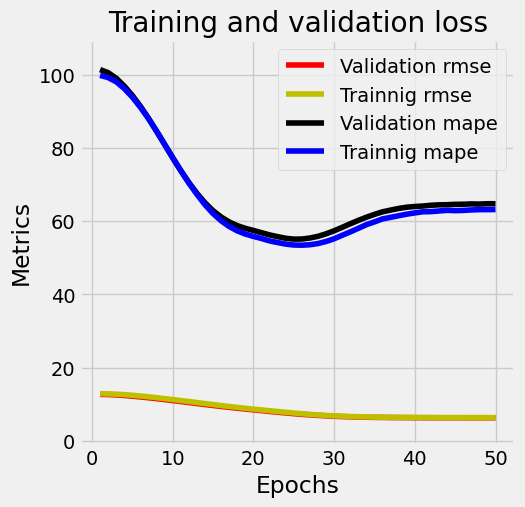

In [32]:
plotme(model2_1)

In [29]:
# inputs: distance + hour
model2_2 = nnmodel(5,10, num_hlayers=1,Epoch=500)
model2_2

Epoch 1/500
365/365 [==============================] - 1s 1ms/step - loss: 417844.4688 - distance_layer_loss: 0.1141 - traveltime_layer_loss: 596920.6875 - distance_layer_mape: 112.6664 - distance_layer_rmse: 0.3378 - traveltime_layer_mape: 99.5587 - traveltime_layer_rmse: 772.6064 - val_loss: 405316.0312 - val_distance_layer_loss: 0.1205 - val_traveltime_layer_loss: 579022.9375 - val_distance_layer_mape: 100.0144 - val_distance_layer_rmse: 0.3472 - val_traveltime_layer_mape: 99.0335 - val_traveltime_layer_rmse: 760.9355
Epoch 2/500
365/365 [==============================] - 0s 988us/step - loss: 410974.1875 - distance_layer_loss: 0.1249 - traveltime_layer_loss: 587106.0625 - distance_layer_mape: 100.0316 - distance_layer_rmse: 0.3534 - traveltime_layer_mape: 98.1085 - traveltime_layer_rmse: 766.2285 - val_loss: 395568.3438 - val_distance_layer_loss: 0.1203 - val_traveltime_layer_loss: 565097.4375 - val_distance_layer_mape: 100.6523 - val_distance_layer_rmse: 0.3469 - val_traveltime_la

365/365 [==============================] - 0s 988us/step - loss: 99456.9688 - distance_layer_loss: 552.1429 - traveltime_layer_loss: 141765.9062 - distance_layer_mape: 24372.9180 - distance_layer_rmse: 23.4977 - traveltime_layer_mape: 62.0689 - traveltime_layer_rmse: 376.5181 - val_loss: 99268.4062 - val_distance_layer_loss: 550.3708 - val_traveltime_layer_loss: 141497.4688 - val_distance_layer_mape: 4369015.0000 - val_distance_layer_rmse: 23.4600 - val_traveltime_layer_mape: 62.4418 - val_traveltime_layer_rmse: 376.1615
Epoch 17/500
365/365 [==============================] - 0s 986us/step - loss: 99453.6094 - distance_layer_loss: 548.5134 - traveltime_layer_loss: 141763.1719 - distance_layer_mape: 24295.8125 - distance_layer_rmse: 23.4204 - traveltime_layer_mape: 62.0920 - traveltime_layer_rmse: 376.5145 - val_loss: 99212.9219 - val_distance_layer_loss: 544.7958 - val_traveltime_layer_loss: 141421.3750 - val_distance_layer_mape: 4349212.5000 - val_distance_layer_rmse: 23.3409 - val_tr

365/365 [==============================] - 0s 992us/step - loss: 99250.6406 - distance_layer_loss: 502.9957 - traveltime_layer_loss: 141499.2344 - distance_layer_mape: 23298.6484 - distance_layer_rmse: 22.4276 - traveltime_layer_mape: 62.2184 - traveltime_layer_rmse: 376.1638 - val_loss: 99036.2578 - val_distance_layer_loss: 503.5776 - val_traveltime_layer_loss: 141192.6562 - val_distance_layer_mape: 4200574.0000 - val_distance_layer_rmse: 22.4405 - val_traveltime_layer_mape: 62.8178 - val_traveltime_layer_rmse: 375.7561
Epoch 32/500
365/365 [==============================] - 0s 989us/step - loss: 99205.1719 - distance_layer_loss: 499.8471 - traveltime_layer_loss: 141436.0000 - distance_layer_mape: 23227.8398 - distance_layer_rmse: 22.3573 - traveltime_layer_mape: 62.1894 - traveltime_layer_rmse: 376.0798 - val_loss: 98895.4688 - val_distance_layer_loss: 490.1049 - val_traveltime_layer_loss: 140999.1250 - val_distance_layer_mape: 4145546.5000 - val_distance_layer_rmse: 22.1383 - val_tr

365/365 [==============================] - 0s 1ms/step - loss: 99092.7812 - distance_layer_loss: 462.2979 - traveltime_layer_loss: 141296.9219 - distance_layer_mape: 22359.1816 - distance_layer_rmse: 21.5011 - traveltime_layer_mape: 62.2246 - traveltime_layer_rmse: 375.8948 - val_loss: 98784.2344 - val_distance_layer_loss: 458.6317 - val_traveltime_layer_loss: 140858.2188 - val_distance_layer_mape: 4019560.5000 - val_distance_layer_rmse: 21.4157 - val_traveltime_layer_mape: 62.1382 - val_traveltime_layer_rmse: 375.3108
Epoch 47/500
365/365 [==============================] - 0s 995us/step - loss: 99060.2969 - distance_layer_loss: 460.1940 - traveltime_layer_loss: 141251.6250 - distance_layer_mape: 22307.8184 - distance_layer_rmse: 21.4521 - traveltime_layer_mape: 62.2482 - traveltime_layer_rmse: 375.8346 - val_loss: 98753.3984 - val_distance_layer_loss: 454.1729 - val_traveltime_layer_loss: 140816.7344 - val_distance_layer_mape: 4000621.2500 - val_distance_layer_rmse: 21.3113 - val_trav

365/365 [==============================] - 0s 995us/step - loss: 99002.1406 - distance_layer_loss: 428.2196 - traveltime_layer_loss: 141187.0000 - distance_layer_mape: 21535.2188 - distance_layer_rmse: 20.6935 - traveltime_layer_mape: 62.1905 - traveltime_layer_rmse: 375.7486 - val_loss: 98660.2422 - val_distance_layer_loss: 424.1816 - val_traveltime_layer_loss: 140700.7812 - val_distance_layer_mape: 3870859.7500 - val_distance_layer_rmse: 20.5957 - val_traveltime_layer_mape: 61.9703 - val_traveltime_layer_rmse: 375.1010
Epoch 62/500
365/365 [==============================] - 0s 994us/step - loss: 98973.5000 - distance_layer_loss: 426.0710 - traveltime_layer_loss: 141147.2969 - distance_layer_mape: 21477.3242 - distance_layer_rmse: 20.6415 - traveltime_layer_mape: 62.1778 - traveltime_layer_rmse: 375.6957 - val_loss: 98779.0000 - val_distance_layer_loss: 428.7010 - val_traveltime_layer_loss: 140867.8906 - val_distance_layer_mape: 3891426.5000 - val_distance_layer_rmse: 20.7051 - val_tr

365/365 [==============================] - 0s 988us/step - loss: 98931.7578 - distance_layer_loss: 399.9995 - traveltime_layer_loss: 141102.5625 - distance_layer_mape: 20823.7988 - distance_layer_rmse: 20.0000 - traveltime_layer_mape: 62.2653 - traveltime_layer_rmse: 375.6362 - val_loss: 98560.2656 - val_distance_layer_loss: 391.1690 - val_traveltime_layer_loss: 140576.8438 - val_distance_layer_mape: 3720713.2500 - val_distance_layer_rmse: 19.7780 - val_traveltime_layer_mape: 61.1926 - val_traveltime_layer_rmse: 374.9358
Epoch 77/500
365/365 [==============================] - 0s 995us/step - loss: 98921.9922 - distance_layer_loss: 398.1365 - traveltime_layer_loss: 141089.5938 - distance_layer_mape: 20773.0488 - distance_layer_rmse: 19.9534 - traveltime_layer_mape: 62.2629 - traveltime_layer_rmse: 375.6190 - val_loss: 98559.2422 - val_distance_layer_loss: 391.2377 - val_traveltime_layer_loss: 140575.3281 - val_distance_layer_mape: 3720871.0000 - val_distance_layer_rmse: 19.7797 - val_tr

365/365 [==============================] - 0s 1ms/step - loss: 98868.8984 - distance_layer_loss: 375.7965 - traveltime_layer_loss: 141026.4531 - distance_layer_mape: 20182.2598 - distance_layer_rmse: 19.3855 - traveltime_layer_mape: 62.2097 - traveltime_layer_rmse: 375.5349 - val_loss: 98628.7656 - val_distance_layer_loss: 376.9495 - val_traveltime_layer_loss: 140682.8281 - val_distance_layer_mape: 3651884.2500 - val_distance_layer_rmse: 19.4152 - val_traveltime_layer_mape: 62.7560 - val_traveltime_layer_rmse: 375.0771
Epoch 92/500
365/365 [==============================] - 0s 1ms/step - loss: 98878.3125 - distance_layer_loss: 374.8730 - traveltime_layer_loss: 141040.5312 - distance_layer_mape: 20161.3867 - distance_layer_rmse: 19.3616 - traveltime_layer_mape: 62.2906 - traveltime_layer_rmse: 375.5536 - val_loss: 98528.1875 - val_distance_layer_loss: 369.9566 - val_traveltime_layer_loss: 140543.2031 - val_distance_layer_mape: 3618653.0000 - val_distance_layer_rmse: 19.2343 - val_travel

365/365 [==============================] - 0s 992us/step - loss: 98834.0234 - distance_layer_loss: 354.6304 - traveltime_layer_loss: 140988.7656 - distance_layer_mape: 19610.1270 - distance_layer_rmse: 18.8316 - traveltime_layer_mape: 62.0267 - traveltime_layer_rmse: 375.4847 - val_loss: 98980.8906 - val_distance_layer_loss: 366.1696 - val_traveltime_layer_loss: 141191.9375 - val_distance_layer_mape: 3599113.0000 - val_distance_layer_rmse: 19.1356 - val_traveltime_layer_mape: 64.4725 - val_traveltime_layer_rmse: 375.7552
Epoch 107/500
365/365 [==============================] - 0s 980us/step - loss: 98879.7031 - distance_layer_loss: 356.5268 - traveltime_layer_loss: 141052.9844 - distance_layer_mape: 19666.1504 - distance_layer_rmse: 18.8819 - traveltime_layer_mape: 62.5489 - traveltime_layer_rmse: 375.5702 - val_loss: 98485.7344 - val_distance_layer_loss: 348.2802 - val_traveltime_layer_loss: 140494.9219 - val_distance_layer_mape: 3511361.2500 - val_distance_layer_rmse: 18.6623 - val_t

365/365 [==============================] - 0s 998us/step - loss: 98827.8125 - distance_layer_loss: 338.2876 - traveltime_layer_loss: 140989.3281 - distance_layer_mape: 19161.4512 - distance_layer_rmse: 18.3926 - traveltime_layer_mape: 62.1220 - traveltime_layer_rmse: 375.4854 - val_loss: 98495.2031 - val_distance_layer_loss: 336.2148 - val_traveltime_layer_loss: 140515.2969 - val_distance_layer_mape: 3449899.7500 - val_distance_layer_rmse: 18.3362 - val_traveltime_layer_mape: 62.0309 - val_traveltime_layer_rmse: 374.8537
Epoch 122/500
365/365 [==============================] - 0s 991us/step - loss: 98854.0078 - distance_layer_loss: 338.0764 - traveltime_layer_loss: 141026.8438 - distance_layer_mape: 19156.2793 - distance_layer_rmse: 18.3869 - traveltime_layer_mape: 62.2855 - traveltime_layer_rmse: 375.5354 - val_loss: 98472.5000 - val_distance_layer_loss: 333.2328 - val_traveltime_layer_loss: 140484.5781 - val_distance_layer_mape: 3434638.2500 - val_distance_layer_rmse: 18.2547 - val_t

365/365 [==============================] - 0s 996us/step - loss: 98824.5000 - distance_layer_loss: 324.2749 - traveltime_layer_loss: 140992.5625 - distance_layer_mape: 18760.7441 - distance_layer_rmse: 18.0076 - traveltime_layer_mape: 62.2597 - traveltime_layer_rmse: 375.4898 - val_loss: 98454.7109 - val_distance_layer_loss: 319.2155 - val_traveltime_layer_loss: 140467.2500 - val_distance_layer_mape: 3361673.2500 - val_distance_layer_rmse: 17.8666 - val_traveltime_layer_mape: 61.5151 - val_traveltime_layer_rmse: 374.7896
Epoch 137/500
365/365 [==============================] - 0s 986us/step - loss: 98813.6719 - distance_layer_loss: 322.7026 - traveltime_layer_loss: 140977.9219 - distance_layer_mape: 18714.8398 - distance_layer_rmse: 17.9639 - traveltime_layer_mape: 62.1007 - traveltime_layer_rmse: 375.4703 - val_loss: 98501.2344 - val_distance_layer_loss: 322.1569 - val_traveltime_layer_loss: 140532.0000 - val_distance_layer_mape: 3376799.5000 - val_distance_layer_rmse: 17.9487 - val_t

365/365 [==============================] - 0s 985us/step - loss: 98783.5938 - distance_layer_loss: 312.9998 - traveltime_layer_loss: 140940.5781 - distance_layer_mape: 18433.7383 - distance_layer_rmse: 17.6918 - traveltime_layer_mape: 62.4305 - traveltime_layer_rmse: 375.4205 - val_loss: 98440.7422 - val_distance_layer_loss: 305.2051 - val_traveltime_layer_loss: 140455.3281 - val_distance_layer_mape: 3286895.2500 - val_distance_layer_rmse: 17.4701 - val_traveltime_layer_mape: 61.1888 - val_traveltime_layer_rmse: 374.7737
Epoch 152/500
365/365 [==============================] - 0s 985us/step - loss: 98852.6328 - distance_layer_loss: 310.0202 - traveltime_layer_loss: 141040.9531 - distance_layer_mape: 18345.9414 - distance_layer_rmse: 17.6074 - traveltime_layer_mape: 62.0404 - traveltime_layer_rmse: 375.5542 - val_loss: 98474.2344 - val_distance_layer_loss: 308.7401 - val_traveltime_layer_loss: 140501.0469 - val_distance_layer_mape: 3305441.7500 - val_distance_layer_rmse: 17.5710 - val_t

365/365 [==============================] - 0s 990us/step - loss: 98814.7031 - distance_layer_loss: 300.0060 - traveltime_layer_loss: 140992.4219 - distance_layer_mape: 18047.9590 - distance_layer_rmse: 17.3207 - traveltime_layer_mape: 62.0699 - traveltime_layer_rmse: 375.4896 - val_loss: 98440.1250 - val_distance_layer_loss: 296.2595 - val_traveltime_layer_loss: 140459.5000 - val_distance_layer_mape: 3238060.7500 - val_distance_layer_rmse: 17.2122 - val_traveltime_layer_mape: 61.5406 - val_traveltime_layer_rmse: 374.7793
Epoch 167/500
365/365 [==============================] - 0s 987us/step - loss: 98833.6719 - distance_layer_loss: 300.0434 - traveltime_layer_loss: 141019.4844 - distance_layer_mape: 18051.6270 - distance_layer_rmse: 17.3218 - traveltime_layer_mape: 62.1793 - traveltime_layer_rmse: 375.5256 - val_loss: 98461.8984 - val_distance_layer_loss: 297.8065 - val_traveltime_layer_loss: 140489.7188 - val_distance_layer_mape: 3246219.0000 - val_distance_layer_rmse: 17.2571 - val_t

365/365 [==============================] - 0s 990us/step - loss: 98777.4453 - distance_layer_loss: 291.2317 - traveltime_layer_loss: 140944.2188 - distance_layer_mape: 17786.8184 - distance_layer_rmse: 17.0655 - traveltime_layer_mape: 62.2365 - traveltime_layer_rmse: 375.4254 - val_loss: 98429.2734 - val_distance_layer_loss: 285.7834 - val_traveltime_layer_loss: 140449.9375 - val_distance_layer_mape: 3180548.0000 - val_distance_layer_rmse: 16.9051 - val_traveltime_layer_mape: 61.3682 - val_traveltime_layer_rmse: 374.7665
Epoch 182/500
365/365 [==============================] - 0s 987us/step - loss: 98803.7812 - distance_layer_loss: 290.5602 - traveltime_layer_loss: 140982.0625 - distance_layer_mape: 17772.1074 - distance_layer_rmse: 17.0458 - traveltime_layer_mape: 62.2035 - traveltime_layer_rmse: 375.4758 - val_loss: 98436.8203 - val_distance_layer_loss: 286.4744 - val_traveltime_layer_loss: 140460.3281 - val_distance_layer_mape: 3184540.5000 - val_distance_layer_rmse: 16.9256 - val_t

365/365 [==============================] - 0s 982us/step - loss: 98800.6719 - distance_layer_loss: 282.2793 - traveltime_layer_loss: 140982.5625 - distance_layer_mape: 17514.0410 - distance_layer_rmse: 16.8012 - traveltime_layer_mape: 62.2507 - traveltime_layer_rmse: 375.4764 - val_loss: 98536.2734 - val_distance_layer_loss: 283.4763 - val_traveltime_layer_loss: 140604.0781 - val_distance_layer_mape: 3167092.0000 - val_distance_layer_rmse: 16.8368 - val_traveltime_layer_mape: 62.7239 - val_traveltime_layer_rmse: 374.9721
Epoch 197/500
365/365 [==============================] - 0s 989us/step - loss: 98773.9766 - distance_layer_loss: 280.9920 - traveltime_layer_loss: 140945.1562 - distance_layer_mape: 17471.5000 - distance_layer_rmse: 16.7628 - traveltime_layer_mape: 62.0530 - traveltime_layer_rmse: 375.4266 - val_loss: 98650.6953 - val_distance_layer_loss: 285.9145 - val_traveltime_layer_loss: 140766.0938 - val_distance_layer_mape: 3180356.5000 - val_distance_layer_rmse: 16.9090 - val_t

365/365 [==============================] - 0s 985us/step - loss: 98783.4766 - distance_layer_loss: 274.1589 - traveltime_layer_loss: 140962.5625 - distance_layer_mape: 17268.5566 - distance_layer_rmse: 16.5577 - traveltime_layer_mape: 62.1805 - traveltime_layer_rmse: 375.4498 - val_loss: 98572.3516 - val_distance_layer_loss: 276.8030 - val_traveltime_layer_loss: 140659.4844 - val_distance_layer_mape: 3129668.5000 - val_distance_layer_rmse: 16.6374 - val_traveltime_layer_mape: 62.9891 - val_traveltime_layer_rmse: 375.0460
Epoch 212/500
365/365 [==============================] - 0s 971us/step - loss: 98778.2500 - distance_layer_loss: 274.3403 - traveltime_layer_loss: 140954.9219 - distance_layer_mape: 17271.1914 - distance_layer_rmse: 16.5632 - traveltime_layer_mape: 62.3652 - traveltime_layer_rmse: 375.4396 - val_loss: 98418.5078 - val_distance_layer_loss: 268.7143 - val_traveltime_layer_loss: 140444.2812 - val_distance_layer_mape: 3084348.0000 - val_distance_layer_rmse: 16.3925 - val_t

365/365 [==============================] - 0s 989us/step - loss: 98810.1406 - distance_layer_loss: 266.4737 - traveltime_layer_loss: 141005.0156 - distance_layer_mape: 17022.2129 - distance_layer_rmse: 16.3240 - traveltime_layer_mape: 62.0359 - traveltime_layer_rmse: 375.5063 - val_loss: 98434.2500 - val_distance_layer_loss: 264.4712 - val_traveltime_layer_loss: 140469.1719 - val_distance_layer_mape: 3059765.2500 - val_distance_layer_rmse: 16.2626 - val_traveltime_layer_mape: 61.8310 - val_traveltime_layer_rmse: 374.7922
Epoch 227/500
365/365 [==============================] - 0s 989us/step - loss: 98781.3438 - distance_layer_loss: 266.8269 - traveltime_layer_loss: 140963.7812 - distance_layer_mape: 17031.6836 - distance_layer_rmse: 16.3348 - traveltime_layer_mape: 62.2040 - traveltime_layer_rmse: 375.4514 - val_loss: 98454.9141 - val_distance_layer_loss: 265.3186 - val_traveltime_layer_loss: 140498.2656 - val_distance_layer_mape: 3064469.5000 - val_distance_layer_rmse: 16.2886 - val_t

365/365 [==============================] - 0s 986us/step - loss: 98774.9297 - distance_layer_loss: 259.8558 - traveltime_layer_loss: 140958.4688 - distance_layer_mape: 16812.5156 - distance_layer_rmse: 16.1200 - traveltime_layer_mape: 62.1224 - traveltime_layer_rmse: 375.4444 - val_loss: 98511.6641 - val_distance_layer_loss: 261.3497 - val_traveltime_layer_loss: 140581.6406 - val_distance_layer_mape: 3041145.0000 - val_distance_layer_rmse: 16.1663 - val_traveltime_layer_mape: 62.6443 - val_traveltime_layer_rmse: 374.9422
Epoch 242/500
365/365 [==============================] - 0s 992us/step - loss: 98793.2734 - distance_layer_loss: 259.9869 - traveltime_layer_loss: 140984.7500 - distance_layer_mape: 16811.5625 - distance_layer_rmse: 16.1241 - traveltime_layer_mape: 62.1938 - traveltime_layer_rmse: 375.4794 - val_loss: 98515.6875 - val_distance_layer_loss: 261.0996 - val_traveltime_layer_loss: 140587.5000 - val_distance_layer_mape: 3039733.7500 - val_distance_layer_rmse: 16.1586 - val_t

365/365 [==============================] - 0s 976us/step - loss: 98791.5078 - distance_layer_loss: 254.5048 - traveltime_layer_loss: 140985.2656 - distance_layer_mape: 16635.9766 - distance_layer_rmse: 15.9532 - traveltime_layer_mape: 62.3222 - traveltime_layer_rmse: 375.4800 - val_loss: 98666.4453 - val_distance_layer_loss: 258.9155 - val_traveltime_layer_loss: 140804.0938 - val_distance_layer_mape: 3026364.2500 - val_distance_layer_rmse: 16.0909 - val_traveltime_layer_mape: 63.5267 - val_traveltime_layer_rmse: 375.2387
Epoch 257/500
365/365 [==============================] - 0s 1ms/step - loss: 98791.6719 - distance_layer_loss: 254.6413 - traveltime_layer_loss: 140985.4531 - distance_layer_mape: 16637.3184 - distance_layer_rmse: 15.9575 - traveltime_layer_mape: 62.3884 - traveltime_layer_rmse: 375.4803 - val_loss: 98438.2500 - val_distance_layer_loss: 251.9583 - val_traveltime_layer_loss: 140482.1406 - val_distance_layer_mape: 2986590.7500 - val_distance_layer_rmse: 15.8732 - val_tra

365/365 [==============================] - 0s 1ms/step - loss: 98769.1875 - distance_layer_loss: 249.4350 - traveltime_layer_loss: 140956.2500 - distance_layer_mape: 16471.5820 - distance_layer_rmse: 15.7935 - traveltime_layer_mape: 62.4339 - traveltime_layer_rmse: 375.4414 - val_loss: 98423.5547 - val_distance_layer_loss: 240.7429 - val_traveltime_layer_loss: 140467.5312 - val_distance_layer_mape: 2920421.7500 - val_distance_layer_rmse: 15.5159 - val_traveltime_layer_mape: 60.6277 - val_traveltime_layer_rmse: 374.7900
Epoch 272/500
365/365 [==============================] - 0s 1ms/step - loss: 98794.2109 - distance_layer_loss: 247.4828 - traveltime_layer_loss: 140993.2031 - distance_layer_mape: 16412.0117 - distance_layer_rmse: 15.7316 - traveltime_layer_mape: 62.1040 - traveltime_layer_rmse: 375.4906 - val_loss: 98444.2031 - val_distance_layer_loss: 246.6729 - val_traveltime_layer_loss: 140493.6250 - val_distance_layer_mape: 2955136.0000 - val_distance_layer_rmse: 15.7058 - val_trave

365/365 [==============================] - 0s 977us/step - loss: 98767.1641 - distance_layer_loss: 242.7411 - traveltime_layer_loss: 140957.2812 - distance_layer_mape: 16251.4248 - distance_layer_rmse: 15.5802 - traveltime_layer_mape: 62.1191 - traveltime_layer_rmse: 375.4428 - val_loss: 98694.1562 - val_distance_layer_loss: 248.3030 - val_traveltime_layer_loss: 140849.8125 - val_distance_layer_mape: 2964624.0000 - val_distance_layer_rmse: 15.7576 - val_traveltime_layer_mape: 63.6835 - val_traveltime_layer_rmse: 375.2996
Epoch 287/500
365/365 [==============================] - 0s 994us/step - loss: 98793.1797 - distance_layer_loss: 243.9876 - traveltime_layer_loss: 140993.7500 - distance_layer_mape: 16296.6699 - distance_layer_rmse: 15.6201 - traveltime_layer_mape: 62.4434 - traveltime_layer_rmse: 375.4913 - val_loss: 98438.1641 - val_distance_layer_loss: 241.3530 - val_traveltime_layer_loss: 140488.0156 - val_distance_layer_mape: 2923487.5000 - val_distance_layer_rmse: 15.5355 - val_t

365/365 [==============================] - 0s 985us/step - loss: 98755.6641 - distance_layer_loss: 238.8920 - traveltime_layer_loss: 140943.0000 - distance_layer_mape: 16120.0332 - distance_layer_rmse: 15.4561 - traveltime_layer_mape: 62.4163 - traveltime_layer_rmse: 375.4238 - val_loss: 98431.3438 - val_distance_layer_loss: 236.2581 - val_traveltime_layer_loss: 140481.1562 - val_distance_layer_mape: 2892497.2500 - val_distance_layer_rmse: 15.3707 - val_traveltime_layer_mape: 61.9968 - val_traveltime_layer_rmse: 374.8082
Epoch 302/500
365/365 [==============================] - 0s 1ms/step - loss: 98748.7578 - distance_layer_loss: 236.5785 - traveltime_layer_loss: 140934.4375 - distance_layer_mape: 16045.1680 - distance_layer_rmse: 15.3811 - traveltime_layer_mape: 61.9189 - traveltime_layer_rmse: 375.4124 - val_loss: 98851.9766 - val_distance_layer_loss: 245.2717 - val_traveltime_layer_loss: 141076.9688 - val_distance_layer_mape: 2946332.5000 - val_distance_layer_rmse: 15.6612 - val_tra

365/365 [==============================] - 0s 992us/step - loss: 98798.0625 - distance_layer_loss: 232.8458 - traveltime_layer_loss: 141006.9688 - distance_layer_mape: 15921.9033 - distance_layer_rmse: 15.2593 - traveltime_layer_mape: 62.1504 - traveltime_layer_rmse: 375.5089 - val_loss: 98531.1406 - val_distance_layer_loss: 234.9991 - val_traveltime_layer_loss: 140624.4531 - val_distance_layer_mape: 2884709.0000 - val_distance_layer_rmse: 15.3297 - val_traveltime_layer_mape: 62.8656 - val_traveltime_layer_rmse: 374.9993
Epoch 317/500
365/365 [==============================] - 0s 1ms/step - loss: 98767.2812 - distance_layer_loss: 233.6728 - traveltime_layer_loss: 140962.5469 - distance_layer_mape: 15947.1572 - distance_layer_rmse: 15.2864 - traveltime_layer_mape: 62.4023 - traveltime_layer_rmse: 375.4498 - val_loss: 98425.3047 - val_distance_layer_loss: 231.1126 - val_traveltime_layer_loss: 140475.5156 - val_distance_layer_mape: 2861193.5000 - val_distance_layer_rmse: 15.2024 - val_tra

365/365 [==============================] - 0s 992us/step - loss: 98726.6641 - distance_layer_loss: 229.2178 - traveltime_layer_loss: 140907.0781 - distance_layer_mape: 15800.3447 - distance_layer_rmse: 15.1399 - traveltime_layer_mape: 62.3415 - traveltime_layer_rmse: 375.3759 - val_loss: 98458.1328 - val_distance_layer_loss: 228.3548 - val_traveltime_layer_loss: 140523.9844 - val_distance_layer_mape: 2844034.2500 - val_distance_layer_rmse: 15.1114 - val_traveltime_layer_mape: 62.3470 - val_traveltime_layer_rmse: 374.8653
Epoch 332/500
365/365 [==============================] - 0s 980us/step - loss: 98772.7812 - distance_layer_loss: 228.8036 - traveltime_layer_loss: 140973.2344 - distance_layer_mape: 15783.4443 - distance_layer_rmse: 15.1263 - traveltime_layer_mape: 62.3116 - traveltime_layer_rmse: 375.4640 - val_loss: 98395.8516 - val_distance_layer_loss: 223.7556 - val_traveltime_layer_loss: 140437.6719 - val_distance_layer_mape: 2815954.7500 - val_distance_layer_rmse: 14.9585 - val_t

365/365 [==============================] - 0s 1ms/step - loss: 98757.5312 - distance_layer_loss: 223.9272 - traveltime_layer_loss: 140954.2188 - distance_layer_mape: 15611.0371 - distance_layer_rmse: 14.9642 - traveltime_layer_mape: 62.0686 - traveltime_layer_rmse: 375.4387 - val_loss: 98521.9844 - val_distance_layer_loss: 225.9256 - val_traveltime_layer_loss: 140616.6094 - val_distance_layer_mape: 2829385.7500 - val_distance_layer_rmse: 15.0308 - val_traveltime_layer_mape: 62.8339 - val_traveltime_layer_rmse: 374.9888
Epoch 347/500
365/365 [==============================] - 0s 1ms/step - loss: 98759.9453 - distance_layer_loss: 223.7351 - traveltime_layer_loss: 140957.8281 - distance_layer_mape: 15610.9971 - distance_layer_rmse: 14.9578 - traveltime_layer_mape: 62.1204 - traveltime_layer_rmse: 375.4435 - val_loss: 98512.2656 - val_distance_layer_loss: 225.3867 - val_traveltime_layer_loss: 140602.9531 - val_distance_layer_mape: 2825874.0000 - val_distance_layer_rmse: 15.0129 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98747.0938 - distance_layer_loss: 219.2333 - traveltime_layer_loss: 140941.9375 - distance_layer_mape: 15456.6562 - distance_layer_rmse: 14.8065 - traveltime_layer_mape: 62.0283 - traveltime_layer_rmse: 375.4223 - val_loss: 98469.0625 - val_distance_layer_loss: 220.2131 - val_traveltime_layer_loss: 140544.2656 - val_distance_layer_mape: 2793199.2500 - val_distance_layer_rmse: 14.8396 - val_traveltime_layer_mape: 62.4613 - val_traveltime_layer_rmse: 374.8923
Epoch 362/500
365/365 [==============================] - 0s 1ms/step - loss: 98773.3594 - distance_layer_loss: 220.7130 - traveltime_layer_loss: 140978.6875 - distance_layer_mape: 15501.0811 - distance_layer_rmse: 14.8564 - traveltime_layer_mape: 62.4342 - traveltime_layer_rmse: 375.4713 - val_loss: 98392.5547 - val_distance_layer_loss: 215.7507 - val_traveltime_layer_loss: 140437.5312 - val_distance_layer_mape: 2765437.2500 - val_distance_layer_rmse: 14.6885 - val_trave

365/365 [==============================] - 0s 998us/step - loss: 98777.0391 - distance_layer_loss: 216.1704 - traveltime_layer_loss: 140986.5625 - distance_layer_mape: 15349.7246 - distance_layer_rmse: 14.7027 - traveltime_layer_mape: 62.2889 - traveltime_layer_rmse: 375.4818 - val_loss: 98411.1328 - val_distance_layer_loss: 213.9000 - val_traveltime_layer_loss: 140465.1250 - val_distance_layer_mape: 2753879.2500 - val_distance_layer_rmse: 14.6253 - val_traveltime_layer_mape: 61.8761 - val_traveltime_layer_rmse: 374.7868
Epoch 377/500
365/365 [==============================] - 0s 985us/step - loss: 98748.3906 - distance_layer_loss: 216.0300 - traveltime_layer_loss: 140945.7344 - distance_layer_mape: 15341.0059 - distance_layer_rmse: 14.6980 - traveltime_layer_mape: 62.2718 - traveltime_layer_rmse: 375.4274 - val_loss: 98389.5859 - val_distance_layer_loss: 210.7860 - val_traveltime_layer_loss: 140436.1094 - val_distance_layer_mape: 2733991.7500 - val_distance_layer_rmse: 14.5185 - val_t

365/365 [==============================] - 0s 972us/step - loss: 98766.2578 - distance_layer_loss: 212.2441 - traveltime_layer_loss: 140973.4375 - distance_layer_mape: 15206.1484 - distance_layer_rmse: 14.5686 - traveltime_layer_mape: 62.2566 - traveltime_layer_rmse: 375.4643 - val_loss: 98519.4375 - val_distance_layer_loss: 213.8451 - val_traveltime_layer_loss: 140619.8125 - val_distance_layer_mape: 2753419.5000 - val_distance_layer_rmse: 14.6234 - val_traveltime_layer_mape: 62.8759 - val_traveltime_layer_rmse: 374.9931
Epoch 392/500
365/365 [==============================] - 0s 972us/step - loss: 98787.9375 - distance_layer_loss: 212.7625 - traveltime_layer_loss: 141004.0469 - distance_layer_mape: 15229.0713 - distance_layer_rmse: 14.5864 - traveltime_layer_mape: 62.4356 - traveltime_layer_rmse: 375.5051 - val_loss: 98493.5703 - val_distance_layer_loss: 213.0059 - val_traveltime_layer_loss: 140583.3438 - val_distance_layer_mape: 2747523.5000 - val_distance_layer_rmse: 14.5947 - val_t

365/365 [==============================] - 0s 992us/step - loss: 98767.6875 - distance_layer_loss: 208.5313 - traveltime_layer_loss: 140977.5938 - distance_layer_mape: 15076.6094 - distance_layer_rmse: 14.4406 - traveltime_layer_mape: 62.2433 - traveltime_layer_rmse: 375.4698 - val_loss: 98436.3438 - val_distance_layer_loss: 207.7371 - val_traveltime_layer_loss: 140504.6250 - val_distance_layer_mape: 2714149.5000 - val_distance_layer_rmse: 14.4131 - val_traveltime_layer_mape: 62.2207 - val_traveltime_layer_rmse: 374.8395
Epoch 407/500
365/365 [==============================] - 0s 985us/step - loss: 98762.1562 - distance_layer_loss: 208.2594 - traveltime_layer_loss: 140969.7188 - distance_layer_mape: 15066.5635 - distance_layer_rmse: 14.4312 - traveltime_layer_mape: 62.2114 - traveltime_layer_rmse: 375.4594 - val_loss: 98483.6094 - val_distance_layer_loss: 209.0827 - val_traveltime_layer_loss: 140571.3750 - val_distance_layer_mape: 2722403.2500 - val_distance_layer_rmse: 14.4597 - val_t

365/365 [==============================] - 0s 1ms/step - loss: 98790.2344 - distance_layer_loss: 204.2856 - traveltime_layer_loss: 141012.1719 - distance_layer_mape: 14922.2695 - distance_layer_rmse: 14.2929 - traveltime_layer_mape: 62.1215 - traveltime_layer_rmse: 375.5159 - val_loss: 98480.0000 - val_distance_layer_loss: 205.6744 - val_traveltime_layer_loss: 140568.2500 - val_distance_layer_mape: 2700380.7500 - val_distance_layer_rmse: 14.3414 - val_traveltime_layer_mape: 62.6185 - val_traveltime_layer_rmse: 374.9243
Epoch 422/500
365/365 [==============================] - 0s 997us/step - loss: 98762.2734 - distance_layer_loss: 204.9734 - traveltime_layer_loss: 140971.7500 - distance_layer_mape: 14942.8896 - distance_layer_rmse: 14.3169 - traveltime_layer_mape: 62.2876 - traveltime_layer_rmse: 375.4620 - val_loss: 98398.5625 - val_distance_layer_loss: 202.2580 - val_traveltime_layer_loss: 140453.7969 - val_distance_layer_mape: 2678284.7500 - val_distance_layer_rmse: 14.2217 - val_tra

365/365 [==============================] - 0s 1ms/step - loss: 98744.5547 - distance_layer_loss: 202.7978 - traveltime_layer_loss: 140947.7344 - distance_layer_mape: 14865.7285 - distance_layer_rmse: 14.2407 - traveltime_layer_mape: 62.5580 - traveltime_layer_rmse: 375.4301 - val_loss: 98397.6172 - val_distance_layer_loss: 195.1236 - val_traveltime_layer_loss: 140456.6250 - val_distance_layer_mape: 2631719.7500 - val_distance_layer_rmse: 13.9687 - val_traveltime_layer_mape: 60.6767 - val_traveltime_layer_rmse: 374.7754
Epoch 437/500
365/365 [==============================] - 0s 996us/step - loss: 98730.4922 - distance_layer_loss: 200.8357 - traveltime_layer_loss: 140928.8125 - distance_layer_mape: 14796.8535 - distance_layer_rmse: 14.1717 - traveltime_layer_mape: 62.1243 - traveltime_layer_rmse: 375.4049 - val_loss: 98445.7344 - val_distance_layer_loss: 200.9736 - val_traveltime_layer_loss: 140521.9375 - val_distance_layer_mape: 2670059.0000 - val_distance_layer_rmse: 14.1765 - val_tra

365/365 [==============================] - 0s 991us/step - loss: 98761.0234 - distance_layer_loss: 197.6580 - traveltime_layer_loss: 140974.1562 - distance_layer_mape: 14684.2197 - distance_layer_rmse: 14.0591 - traveltime_layer_mape: 62.1450 - traveltime_layer_rmse: 375.4652 - val_loss: 98518.0156 - val_distance_layer_loss: 199.6794 - val_traveltime_layer_loss: 140625.9219 - val_distance_layer_mape: 2660565.5000 - val_distance_layer_rmse: 14.1308 - val_traveltime_layer_mape: 62.9011 - val_traveltime_layer_rmse: 375.0012
Epoch 452/500
365/365 [==============================] - 0s 995us/step - loss: 98781.9062 - distance_layer_loss: 197.9254 - traveltime_layer_loss: 141003.9375 - distance_layer_mape: 14693.1914 - distance_layer_rmse: 14.0686 - traveltime_layer_mape: 62.2985 - traveltime_layer_rmse: 375.5049 - val_loss: 98472.4688 - val_distance_layer_loss: 198.2944 - val_traveltime_layer_loss: 140561.7500 - val_distance_layer_mape: 2651759.0000 - val_distance_layer_rmse: 14.0817 - val_t

365/365 [==============================] - 0s 992us/step - loss: 98772.1250 - distance_layer_loss: 194.3594 - traveltime_layer_loss: 140991.9844 - distance_layer_mape: 14564.8711 - distance_layer_rmse: 13.9413 - traveltime_layer_mape: 62.1755 - traveltime_layer_rmse: 375.4890 - val_loss: 98489.3906 - val_distance_layer_loss: 195.7307 - val_traveltime_layer_loss: 140587.2812 - val_distance_layer_mape: 2635201.0000 - val_distance_layer_rmse: 13.9904 - val_traveltime_layer_mape: 62.7263 - val_traveltime_layer_rmse: 374.9497
Epoch 467/500
365/365 [==============================] - 0s 989us/step - loss: 98757.6875 - distance_layer_loss: 194.8844 - traveltime_layer_loss: 140971.0625 - distance_layer_mape: 14576.5322 - distance_layer_rmse: 13.9601 - traveltime_layer_mape: 62.3297 - traveltime_layer_rmse: 375.4611 - val_loss: 98422.1562 - val_distance_layer_loss: 193.5809 - val_traveltime_layer_loss: 140492.4375 - val_distance_layer_mape: 2620556.0000 - val_distance_layer_rmse: 13.9133 - val_t

365/365 [==============================] - 0s 987us/step - loss: 98744.4609 - distance_layer_loss: 191.9197 - traveltime_layer_loss: 140953.8906 - distance_layer_mape: 14469.5811 - distance_layer_rmse: 13.8535 - traveltime_layer_mape: 62.2971 - traveltime_layer_rmse: 375.4383 - val_loss: 98430.0000 - val_distance_layer_loss: 191.0448 - val_traveltime_layer_loss: 140505.1562 - val_distance_layer_mape: 2603931.2500 - val_distance_layer_rmse: 13.8219 - val_traveltime_layer_mape: 62.2530 - val_traveltime_layer_rmse: 374.8402
Epoch 482/500
365/365 [==============================] - 0s 1ms/step - loss: 98745.7422 - distance_layer_loss: 191.5224 - traveltime_layer_loss: 140955.9375 - distance_layer_mape: 14450.6621 - distance_layer_rmse: 13.8392 - traveltime_layer_mape: 62.2679 - traveltime_layer_rmse: 375.4410 - val_loss: 98402.8828 - val_distance_layer_loss: 189.7952 - val_traveltime_layer_loss: 140467.1250 - val_distance_layer_mape: 2595785.0000 - val_distance_layer_rmse: 13.7766 - val_tra

365/365 [==============================] - 0s 1ms/step - loss: 98726.2109 - distance_layer_loss: 188.1745 - traveltime_layer_loss: 140929.8281 - distance_layer_mape: 14326.9561 - distance_layer_rmse: 13.7177 - traveltime_layer_mape: 62.0469 - traveltime_layer_rmse: 375.4062 - val_loss: 98642.9922 - val_distance_layer_loss: 192.6031 - val_traveltime_layer_loss: 140808.4531 - val_distance_layer_mape: 2614105.7500 - val_distance_layer_rmse: 13.8782 - val_traveltime_layer_mape: 63.5724 - val_traveltime_layer_rmse: 375.2445
Epoch 497/500
365/365 [==============================] - 0s 984us/step - loss: 98756.9922 - distance_layer_loss: 189.2374 - traveltime_layer_loss: 140973.2969 - distance_layer_mape: 14369.6484 - distance_layer_rmse: 13.7564 - traveltime_layer_mape: 62.4365 - traveltime_layer_rmse: 375.4641 - val_loss: 98401.0781 - val_distance_layer_loss: 186.8076 - val_traveltime_layer_loss: 140466.2188 - val_distance_layer_mape: 2574979.0000 - val_distance_layer_rmse: 13.6678 - val_tra

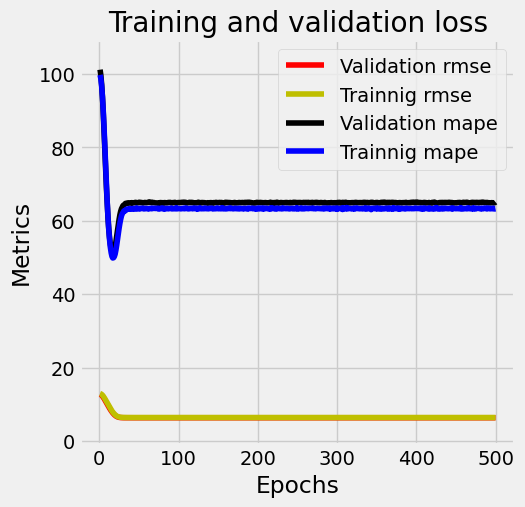

In [102]:
plotme(model2_2)

In [30]:
# inputs: distance + hour
model2_2 = nnmodel(20,30, num_hlayers=1,Epoch=500)
model2_2

Epoch 1/500
365/365 [==============================] - 1s 1ms/step - loss: 417112.2500 - distance_layer_loss: 0.1200 - traveltime_layer_loss: 595874.6875 - distance_layer_mape: 125.7371 - distance_layer_rmse: 0.3464 - traveltime_layer_mape: 99.3898 - traveltime_layer_rmse: 771.9292 - val_loss: 402381.4375 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 574830.4375 - val_distance_layer_mape: 99.9799 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 98.3511 - val_traveltime_layer_rmse: 758.1757
Epoch 2/500
365/365 [==============================] - 0s 984us/step - loss: 402837.2188 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 575482.0000 - distance_layer_mape: 99.9999 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 96.2083 - traveltime_layer_rmse: 758.6053 - val_loss: 380463.0938 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 543518.8125 - val_distance_layer_mape: 99.9791 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer

365/365 [==============================] - 0s 985us/step - loss: 99407.8516 - distance_layer_loss: 443.2626 - traveltime_layer_loss: 141757.8750 - distance_layer_mape: 21859.5352 - distance_layer_rmse: 21.0538 - traveltime_layer_mape: 62.2562 - traveltime_layer_rmse: 376.5075 - val_loss: 99093.5000 - val_distance_layer_loss: 435.9388 - val_traveltime_layer_loss: 141313.0469 - val_distance_layer_mape: 3892621.5000 - val_distance_layer_rmse: 20.8791 - val_traveltime_layer_mape: 61.8014 - val_traveltime_layer_rmse: 375.9163
Epoch 17/500
365/365 [==============================] - 0s 1ms/step - loss: 99417.2266 - distance_layer_loss: 438.3940 - traveltime_layer_loss: 141774.0469 - distance_layer_mape: 21739.9199 - distance_layer_rmse: 20.9379 - traveltime_layer_mape: 62.1437 - traveltime_layer_rmse: 376.5289 - val_loss: 99101.6562 - val_distance_layer_loss: 420.5793 - val_traveltime_layer_loss: 141333.4688 - val_distance_layer_mape: 3826526.2500 - val_distance_layer_rmse: 20.5080 - val_trav

365/365 [==============================] - 0s 980us/step - loss: 99094.7578 - distance_layer_loss: 389.2552 - traveltime_layer_loss: 141341.5781 - distance_layer_mape: 20518.8750 - distance_layer_rmse: 19.7295 - traveltime_layer_mape: 62.2444 - traveltime_layer_rmse: 375.9542 - val_loss: 98824.7891 - val_distance_layer_loss: 386.6841 - val_traveltime_layer_loss: 140957.3281 - val_distance_layer_mape: 3681709.7500 - val_distance_layer_rmse: 19.6643 - val_traveltime_layer_mape: 62.4065 - val_traveltime_layer_rmse: 375.4428
Epoch 32/500
365/365 [==============================] - 0s 989us/step - loss: 99130.0703 - distance_layer_loss: 384.6418 - traveltime_layer_loss: 141394.6719 - distance_layer_mape: 20396.3145 - distance_layer_rmse: 19.6123 - traveltime_layer_mape: 62.0884 - traveltime_layer_rmse: 376.0248 - val_loss: 99155.4375 - val_distance_layer_loss: 394.2579 - val_traveltime_layer_loss: 141425.3438 - val_distance_layer_mape: 3717840.0000 - val_distance_layer_rmse: 19.8559 - val_tr

365/365 [==============================] - 0s 1ms/step - loss: 98994.2891 - distance_layer_loss: 346.4303 - traveltime_layer_loss: 141222.4531 - distance_layer_mape: 19370.8477 - distance_layer_rmse: 18.6126 - traveltime_layer_mape: 62.2945 - traveltime_layer_rmse: 375.7957 - val_loss: 98639.4844 - val_distance_layer_loss: 331.9927 - val_traveltime_layer_loss: 140723.8281 - val_distance_layer_mape: 3417329.7500 - val_distance_layer_rmse: 18.2207 - val_traveltime_layer_mape: 60.2345 - val_traveltime_layer_rmse: 375.1317
Epoch 47/500
365/365 [==============================] - 0s 1ms/step - loss: 98964.0703 - distance_layer_loss: 342.8360 - traveltime_layer_loss: 141181.3594 - distance_layer_mape: 19271.3887 - distance_layer_rmse: 18.5158 - traveltime_layer_mape: 62.1187 - traveltime_layer_rmse: 375.7411 - val_loss: 98596.6016 - val_distance_layer_loss: 338.9273 - val_traveltime_layer_loss: 140658.6719 - val_distance_layer_mape: 3452078.5000 - val_distance_layer_rmse: 18.4100 - val_travel

365/365 [==============================] - 0s 1ms/step - loss: 98931.7266 - distance_layer_loss: 313.1173 - traveltime_layer_loss: 141152.1094 - distance_layer_mape: 18416.3047 - distance_layer_rmse: 17.6951 - traveltime_layer_mape: 62.2982 - traveltime_layer_rmse: 375.7021 - val_loss: 98640.3047 - val_distance_layer_loss: 314.5985 - val_traveltime_layer_loss: 140734.9688 - val_distance_layer_mape: 3326382.7500 - val_distance_layer_rmse: 17.7369 - val_traveltime_layer_mape: 62.9463 - val_traveltime_layer_rmse: 375.1466
Epoch 62/500
365/365 [==============================] - 0s 1ms/step - loss: 98949.9844 - distance_layer_loss: 311.1803 - traveltime_layer_loss: 141179.3438 - distance_layer_mape: 18371.6602 - distance_layer_rmse: 17.6403 - traveltime_layer_mape: 62.3160 - traveltime_layer_rmse: 375.7384 - val_loss: 98546.0312 - val_distance_layer_loss: 309.2289 - val_traveltime_layer_loss: 140603.3750 - val_distance_layer_mape: 3297884.5000 - val_distance_layer_rmse: 17.5849 - val_travel

365/365 [==============================] - 0s 1ms/step - loss: 98861.9453 - distance_layer_loss: 287.3182 - traveltime_layer_loss: 141067.1875 - distance_layer_mape: 17655.8594 - distance_layer_rmse: 16.9505 - traveltime_layer_mape: 62.2346 - traveltime_layer_rmse: 375.5891 - val_loss: 98477.1875 - val_distance_layer_loss: 284.1520 - val_traveltime_layer_loss: 140519.3438 - val_distance_layer_mape: 3162254.2500 - val_distance_layer_rmse: 16.8568 - val_traveltime_layer_mape: 61.9429 - val_traveltime_layer_rmse: 374.8591
Epoch 77/500
365/365 [==============================] - 0s 1ms/step - loss: 98871.0000 - distance_layer_loss: 285.7603 - traveltime_layer_loss: 141081.0625 - distance_layer_mape: 17607.2285 - distance_layer_rmse: 16.9044 - traveltime_layer_mape: 62.2341 - traveltime_layer_rmse: 375.6076 - val_loss: 98682.7188 - val_distance_layer_loss: 290.0887 - val_traveltime_layer_loss: 140809.5625 - val_distance_layer_mape: 3194229.7500 - val_distance_layer_rmse: 17.0320 - val_travel

365/365 [==============================] - 0s 1ms/step - loss: 98804.8984 - distance_layer_loss: 267.8197 - traveltime_layer_loss: 140996.8594 - distance_layer_mape: 17049.7793 - distance_layer_rmse: 16.3652 - traveltime_layer_mape: 62.2013 - traveltime_layer_rmse: 375.4955 - val_loss: 98533.5156 - val_distance_layer_loss: 268.8272 - val_traveltime_layer_loss: 140608.5469 - val_distance_layer_mape: 3074862.5000 - val_distance_layer_rmse: 16.3960 - val_traveltime_layer_mape: 62.7020 - val_traveltime_layer_rmse: 374.9781
Epoch 92/500
365/365 [==============================] - 0s 995us/step - loss: 98827.4297 - distance_layer_loss: 267.5872 - traveltime_layer_loss: 141029.2812 - distance_layer_mape: 17041.8281 - distance_layer_rmse: 16.3581 - traveltime_layer_mape: 62.3576 - traveltime_layer_rmse: 375.5387 - val_loss: 98455.5547 - val_distance_layer_loss: 264.2970 - val_traveltime_layer_loss: 140499.7656 - val_distance_layer_mape: 3048951.5000 - val_distance_layer_rmse: 16.2572 - val_trav

365/365 [==============================] - 0s 1ms/step - loss: 98806.0078 - distance_layer_loss: 253.1552 - traveltime_layer_loss: 141006.8594 - distance_layer_mape: 16575.2969 - distance_layer_rmse: 15.9109 - traveltime_layer_mape: 62.3865 - traveltime_layer_rmse: 375.5088 - val_loss: 98504.0078 - val_distance_layer_loss: 253.0937 - val_traveltime_layer_loss: 140575.3906 - val_distance_layer_mape: 2982527.7500 - val_distance_layer_rmse: 15.9089 - val_traveltime_layer_mape: 62.5856 - val_traveltime_layer_rmse: 374.9338
Epoch 107/500
365/365 [==============================] - 0s 1ms/step - loss: 98790.2266 - distance_layer_loss: 252.1431 - traveltime_layer_loss: 140984.8594 - distance_layer_mape: 16549.2715 - distance_layer_rmse: 15.8790 - traveltime_layer_mape: 62.2840 - traveltime_layer_rmse: 375.4795 - val_loss: 98414.9375 - val_distance_layer_loss: 245.4403 - val_traveltime_layer_loss: 140452.5000 - val_distance_layer_mape: 2937729.2500 - val_distance_layer_rmse: 15.6665 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98811.9297 - distance_layer_loss: 238.9469 - traveltime_layer_loss: 141023.4219 - distance_layer_mape: 16114.5537 - distance_layer_rmse: 15.4579 - traveltime_layer_mape: 62.0052 - traveltime_layer_rmse: 375.5309 - val_loss: 98819.0312 - val_distance_layer_loss: 247.0760 - val_traveltime_layer_loss: 141028.9375 - val_distance_layer_mape: 2946496.0000 - val_distance_layer_rmse: 15.7187 - val_traveltime_layer_mape: 64.1556 - val_traveltime_layer_rmse: 375.5382
Epoch 122/500
365/365 [==============================] - 0s 980us/step - loss: 98755.4922 - distance_layer_loss: 240.4976 - traveltime_layer_loss: 140941.8125 - distance_layer_mape: 16153.1729 - distance_layer_rmse: 15.5080 - traveltime_layer_mape: 62.4871 - traveltime_layer_rmse: 375.4222 - val_loss: 98408.2734 - val_distance_layer_loss: 234.6109 - val_traveltime_layer_loss: 140449.1719 - val_distance_layer_mape: 2871245.2500 - val_distance_layer_rmse: 15.3170 - val_tra

365/365 [==============================] - 0s 996us/step - loss: 98816.9297 - distance_layer_loss: 229.9678 - traveltime_layer_loss: 141035.6875 - distance_layer_mape: 15801.1475 - distance_layer_rmse: 15.1647 - traveltime_layer_mape: 62.2798 - traveltime_layer_rmse: 375.5472 - val_loss: 98424.8281 - val_distance_layer_loss: 227.5666 - val_traveltime_layer_loss: 140476.8438 - val_distance_layer_mape: 2827915.0000 - val_distance_layer_rmse: 15.0853 - val_traveltime_layer_mape: 61.9011 - val_traveltime_layer_rmse: 374.8024
Epoch 137/500
365/365 [==============================] - 0s 988us/step - loss: 98812.2422 - distance_layer_loss: 229.1273 - traveltime_layer_loss: 141029.4375 - distance_layer_mape: 15781.2637 - distance_layer_rmse: 15.1370 - traveltime_layer_mape: 62.1889 - traveltime_layer_rmse: 375.5388 - val_loss: 98493.3672 - val_distance_layer_loss: 229.7901 - val_traveltime_layer_loss: 140573.5312 - val_distance_layer_mape: 2841575.7500 - val_distance_layer_rmse: 15.1588 - val_t

365/365 [==============================] - 0s 1ms/step - loss: 98779.9688 - distance_layer_loss: 220.2354 - traveltime_layer_loss: 140988.3750 - distance_layer_mape: 15471.0557 - distance_layer_rmse: 14.8403 - traveltime_layer_mape: 62.1102 - traveltime_layer_rmse: 375.4842 - val_loss: 98499.3984 - val_distance_layer_loss: 221.7253 - val_traveltime_layer_loss: 140586.7969 - val_distance_layer_mape: 2791742.2500 - val_distance_layer_rmse: 14.8904 - val_traveltime_layer_mape: 62.6655 - val_traveltime_layer_rmse: 374.9491
Epoch 152/500
365/365 [==============================] - 0s 1ms/step - loss: 98788.7891 - distance_layer_loss: 220.6512 - traveltime_layer_loss: 141000.6875 - distance_layer_mape: 15482.9395 - distance_layer_rmse: 14.8543 - traveltime_layer_mape: 62.2965 - traveltime_layer_rmse: 375.5006 - val_loss: 98426.6016 - val_distance_layer_loss: 218.4030 - val_traveltime_layer_loss: 140484.6094 - val_distance_layer_mape: 2771098.2500 - val_distance_layer_rmse: 14.7785 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98813.1797 - distance_layer_loss: 212.9104 - traveltime_layer_loss: 141039.9219 - distance_layer_mape: 15212.7041 - distance_layer_rmse: 14.5914 - traveltime_layer_mape: 62.2118 - traveltime_layer_rmse: 375.5528 - val_loss: 98441.2344 - val_distance_layer_loss: 211.9753 - val_traveltime_layer_loss: 140509.2188 - val_distance_layer_mape: 2729789.2500 - val_distance_layer_rmse: 14.5594 - val_traveltime_layer_mape: 62.2098 - val_traveltime_layer_rmse: 374.8456
Epoch 167/500
365/365 [==============================] - 0s 1ms/step - loss: 98801.8750 - distance_layer_loss: 212.2961 - traveltime_layer_loss: 141024.2812 - distance_layer_mape: 15195.6992 - distance_layer_rmse: 14.5704 - traveltime_layer_mape: 62.1904 - traveltime_layer_rmse: 375.5320 - val_loss: 98489.5547 - val_distance_layer_loss: 213.2183 - val_traveltime_layer_loss: 140577.5156 - val_distance_layer_mape: 2737387.7500 - val_distance_layer_rmse: 14.6020 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98774.3281 - distance_layer_loss: 206.3859 - traveltime_layer_loss: 140988.2656 - distance_layer_mape: 14986.7275 - distance_layer_rmse: 14.3661 - traveltime_layer_mape: 62.2738 - traveltime_layer_rmse: 375.4840 - val_loss: 98388.1328 - val_distance_layer_loss: 201.5710 - val_traveltime_layer_loss: 140439.2812 - val_distance_layer_mape: 2662445.5000 - val_distance_layer_rmse: 14.1976 - val_traveltime_layer_mape: 61.2891 - val_traveltime_layer_rmse: 374.7523
Epoch 182/500
365/365 [==============================] - 0s 1ms/step - loss: 98798.1953 - distance_layer_loss: 205.6068 - traveltime_layer_loss: 141022.8594 - distance_layer_mape: 14953.4355 - distance_layer_rmse: 14.3390 - traveltime_layer_mape: 62.2503 - traveltime_layer_rmse: 375.5301 - val_loss: 98403.5312 - val_distance_layer_loss: 203.0466 - val_traveltime_layer_loss: 140460.4844 - val_distance_layer_mape: 2672156.2500 - val_distance_layer_rmse: 14.2494 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98780.1328 - distance_layer_loss: 198.7854 - traveltime_layer_loss: 141000.8750 - distance_layer_mape: 14711.3418 - distance_layer_rmse: 14.0991 - traveltime_layer_mape: 62.0456 - traveltime_layer_rmse: 375.5008 - val_loss: 98677.6953 - val_distance_layer_loss: 204.1027 - val_traveltime_layer_loss: 140851.5000 - val_distance_layer_mape: 2678624.7500 - val_distance_layer_rmse: 14.2865 - val_traveltime_layer_mape: 63.6930 - val_traveltime_layer_rmse: 375.3019
Epoch 197/500
365/365 [==============================] - 0s 1ms/step - loss: 98783.0469 - distance_layer_loss: 199.6830 - traveltime_layer_loss: 141004.6094 - distance_layer_mape: 14747.9834 - distance_layer_rmse: 14.1309 - traveltime_layer_mape: 62.3442 - traveltime_layer_rmse: 375.5058 - val_loss: 98414.3984 - val_distance_layer_loss: 197.4941 - val_traveltime_layer_loss: 140479.1094 - val_distance_layer_mape: 2635223.0000 - val_distance_layer_rmse: 14.0533 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98783.8828 - distance_layer_loss: 193.9533 - traveltime_layer_loss: 141009.0781 - distance_layer_mape: 14532.6914 - distance_layer_rmse: 13.9267 - traveltime_layer_mape: 62.3323 - traveltime_layer_rmse: 375.5117 - val_loss: 98389.9609 - val_distance_layer_loss: 190.5135 - val_traveltime_layer_loss: 140448.2031 - val_distance_layer_mape: 2588000.7500 - val_distance_layer_rmse: 13.8027 - val_traveltime_layer_mape: 61.6225 - val_traveltime_layer_rmse: 374.7642
Epoch 212/500
365/365 [==============================] - 0s 1ms/step - loss: 98778.4766 - distance_layer_loss: 192.6466 - traveltime_layer_loss: 141002.1094 - distance_layer_mape: 14485.4775 - distance_layer_rmse: 13.8797 - traveltime_layer_mape: 62.1375 - traveltime_layer_rmse: 375.5025 - val_loss: 98510.4375 - val_distance_layer_loss: 194.5724 - val_traveltime_layer_loss: 140618.0469 - val_distance_layer_mape: 2614953.5000 - val_distance_layer_rmse: 13.9489 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98789.4375 - distance_layer_loss: 187.9750 - traveltime_layer_loss: 141020.2969 - distance_layer_mape: 14308.1562 - distance_layer_rmse: 13.7104 - traveltime_layer_mape: 62.2748 - traveltime_layer_rmse: 375.5267 - val_loss: 98417.7188 - val_distance_layer_loss: 186.7537 - val_traveltime_layer_loss: 140489.9688 - val_distance_layer_mape: 2562770.0000 - val_distance_layer_rmse: 13.6658 - val_traveltime_layer_mape: 62.1180 - val_traveltime_layer_rmse: 374.8199
Epoch 227/500
365/365 [==============================] - 0s 1ms/step - loss: 98742.3516 - distance_layer_loss: 187.5883 - traveltime_layer_loss: 140953.2500 - distance_layer_mape: 14291.7842 - distance_layer_rmse: 13.6963 - traveltime_layer_mape: 62.1894 - traveltime_layer_rmse: 375.4374 - val_loss: 98691.2500 - val_distance_layer_loss: 192.2534 - val_traveltime_layer_loss: 140877.6562 - val_distance_layer_mape: 2599205.0000 - val_distance_layer_rmse: 13.8655 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98788.4766 - distance_layer_loss: 183.1937 - traveltime_layer_loss: 141021.5938 - distance_layer_mape: 14129.6523 - distance_layer_rmse: 13.5349 - traveltime_layer_mape: 62.3520 - traveltime_layer_rmse: 375.5284 - val_loss: 98391.7031 - val_distance_layer_loss: 180.6410 - val_traveltime_layer_loss: 140456.3125 - val_distance_layer_mape: 2520704.2500 - val_distance_layer_rmse: 13.4403 - val_traveltime_layer_mape: 61.7575 - val_traveltime_layer_rmse: 374.7750
Epoch 242/500
365/365 [==============================] - 0s 1ms/step - loss: 98793.3203 - distance_layer_loss: 182.6006 - traveltime_layer_loss: 141028.9688 - distance_layer_mape: 14108.0381 - distance_layer_rmse: 13.5130 - traveltime_layer_mape: 62.2899 - traveltime_layer_rmse: 375.5382 - val_loss: 98417.0156 - val_distance_layer_loss: 175.1819 - val_traveltime_layer_loss: 140495.5938 - val_distance_layer_mape: 2483383.2500 - val_distance_layer_rmse: 13.2356 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98806.0625 - distance_layer_loss: 178.8671 - traveltime_layer_loss: 141049.3125 - distance_layer_mape: 13960.2246 - distance_layer_rmse: 13.3741 - traveltime_layer_mape: 62.3686 - traveltime_layer_rmse: 375.5653 - val_loss: 98393.0234 - val_distance_layer_loss: 171.7610 - val_traveltime_layer_loss: 140463.2969 - val_distance_layer_mape: 2458497.0000 - val_distance_layer_rmse: 13.1058 - val_traveltime_layer_mape: 60.5930 - val_traveltime_layer_rmse: 374.7843
Epoch 257/500
365/365 [==============================] - 0s 1ms/step - loss: 98795.4062 - distance_layer_loss: 177.5497 - traveltime_layer_loss: 141034.7500 - distance_layer_mape: 13898.8486 - distance_layer_rmse: 13.3248 - traveltime_layer_mape: 62.1620 - traveltime_layer_rmse: 375.5459 - val_loss: 98450.3516 - val_distance_layer_loss: 169.3133 - val_traveltime_layer_loss: 140546.6094 - val_distance_layer_mape: 2441506.5000 - val_distance_layer_rmse: 13.0120 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98833.0625 - distance_layer_loss: 173.6781 - traveltime_layer_loss: 141090.9219 - distance_layer_mape: 13756.3447 - distance_layer_rmse: 13.1787 - traveltime_layer_mape: 62.2937 - traveltime_layer_rmse: 375.6207 - val_loss: 98375.9453 - val_distance_layer_loss: 170.6633 - val_traveltime_layer_loss: 140439.5469 - val_distance_layer_mape: 2450534.0000 - val_distance_layer_rmse: 13.0638 - val_traveltime_layer_mape: 61.5707 - val_traveltime_layer_rmse: 374.7527
Epoch 272/500
365/365 [==============================] - 0s 1ms/step - loss: 98830.6797 - distance_layer_loss: 172.8731 - traveltime_layer_loss: 141087.9062 - distance_layer_mape: 13727.3779 - distance_layer_rmse: 13.1481 - traveltime_layer_mape: 62.1350 - traveltime_layer_rmse: 375.6167 - val_loss: 98381.5938 - val_distance_layer_loss: 170.7271 - val_traveltime_layer_loss: 140447.5156 - val_distance_layer_mape: 2451505.5000 - val_distance_layer_rmse: 13.0663 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98746.3438 - distance_layer_loss: 169.3808 - traveltime_layer_loss: 140969.3125 - distance_layer_mape: 13591.7695 - distance_layer_rmse: 13.0146 - traveltime_layer_mape: 62.2608 - traveltime_layer_rmse: 375.4588 - val_loss: 98437.0859 - val_distance_layer_loss: 169.2274 - val_traveltime_layer_loss: 140527.6406 - val_distance_layer_mape: 2440649.0000 - val_distance_layer_rmse: 13.0087 - val_traveltime_layer_mape: 62.4120 - val_traveltime_layer_rmse: 374.8702
Epoch 287/500
365/365 [==============================] - 0s 1ms/step - loss: 98772.2422 - distance_layer_loss: 168.7079 - traveltime_layer_loss: 141006.8125 - distance_layer_mape: 13564.7383 - distance_layer_rmse: 12.9888 - traveltime_layer_mape: 62.2014 - traveltime_layer_rmse: 375.5087 - val_loss: 98442.1641 - val_distance_layer_loss: 169.0073 - val_traveltime_layer_loss: 140535.0625 - val_distance_layer_mape: 2438511.7500 - val_distance_layer_rmse: 13.0003 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98789.2031 - distance_layer_loss: 166.3308 - traveltime_layer_loss: 141032.4219 - distance_layer_mape: 13464.2295 - distance_layer_rmse: 12.8969 - traveltime_layer_mape: 62.5492 - traveltime_layer_rmse: 375.5428 - val_loss: 98367.3828 - val_distance_layer_loss: 161.2056 - val_traveltime_layer_loss: 140432.7656 - val_distance_layer_mape: 2382264.0000 - val_distance_layer_rmse: 12.6967 - val_traveltime_layer_mape: 61.1393 - val_traveltime_layer_rmse: 374.7436
Epoch 302/500
365/365 [==============================] - 0s 1ms/step - loss: 98774.5078 - distance_layer_loss: 164.6084 - traveltime_layer_loss: 141012.3906 - distance_layer_mape: 13396.6768 - distance_layer_rmse: 12.8300 - traveltime_layer_mape: 62.0810 - traveltime_layer_rmse: 375.5162 - val_loss: 98415.0312 - val_distance_layer_loss: 164.4030 - val_traveltime_layer_loss: 140498.9375 - val_distance_layer_mape: 2404836.2500 - val_distance_layer_rmse: 12.8220 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98793.8047 - distance_layer_loss: 161.5475 - traveltime_layer_loss: 141041.7656 - distance_layer_mape: 13279.9795 - distance_layer_rmse: 12.7101 - traveltime_layer_mape: 62.3289 - traveltime_layer_rmse: 375.5553 - val_loss: 98486.3828 - val_distance_layer_loss: 162.5285 - val_traveltime_layer_loss: 140601.9844 - val_distance_layer_mape: 2391783.2500 - val_distance_layer_rmse: 12.7487 - val_traveltime_layer_mape: 62.8025 - val_traveltime_layer_rmse: 374.9693
Epoch 317/500
365/365 [==============================] - 0s 1ms/step - loss: 98790.5234 - distance_layer_loss: 160.9904 - traveltime_layer_loss: 141037.3906 - distance_layer_mape: 13248.6504 - distance_layer_rmse: 12.6882 - traveltime_layer_mape: 62.2497 - traveltime_layer_rmse: 375.5494 - val_loss: 98511.9141 - val_distance_layer_loss: 162.7659 - val_traveltime_layer_loss: 140638.3281 - val_distance_layer_mape: 2393292.5000 - val_distance_layer_rmse: 12.7580 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98712.1484 - distance_layer_loss: 157.9199 - traveltime_layer_loss: 140927.1406 - distance_layer_mape: 13127.9795 - distance_layer_rmse: 12.5666 - traveltime_layer_mape: 62.2962 - traveltime_layer_rmse: 375.4026 - val_loss: 98368.7266 - val_distance_layer_loss: 152.8755 - val_traveltime_layer_loss: 140439.3750 - val_distance_layer_mape: 2320490.7500 - val_distance_layer_rmse: 12.3643 - val_traveltime_layer_mape: 60.8917 - val_traveltime_layer_rmse: 374.7524
Epoch 332/500
365/365 [==============================] - 0s 1ms/step - loss: 98807.2656 - distance_layer_loss: 157.4892 - traveltime_layer_loss: 141063.2656 - distance_layer_mape: 13111.2764 - distance_layer_rmse: 12.5495 - traveltime_layer_mape: 62.2542 - traveltime_layer_rmse: 375.5839 - val_loss: 98364.4766 - val_distance_layer_loss: 154.3407 - val_traveltime_layer_loss: 140432.5000 - val_distance_layer_mape: 2331525.7500 - val_distance_layer_rmse: 12.4234 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98774.8438 - distance_layer_loss: 153.7668 - traveltime_layer_loss: 141019.0000 - distance_layer_mape: 12950.4512 - distance_layer_rmse: 12.4003 - traveltime_layer_mape: 62.0887 - traveltime_layer_rmse: 375.5250 - val_loss: 98397.1328 - val_distance_layer_loss: 153.1017 - val_traveltime_layer_loss: 140479.8281 - val_distance_layer_mape: 2321800.7500 - val_distance_layer_rmse: 12.3734 - val_traveltime_layer_mape: 62.0799 - val_traveltime_layer_rmse: 374.8064
Epoch 347/500
365/365 [==============================] - 0s 1ms/step - loss: 98737.2266 - distance_layer_loss: 153.5743 - traveltime_layer_loss: 140965.4531 - distance_layer_mape: 12948.0273 - distance_layer_rmse: 12.3925 - traveltime_layer_mape: 62.1055 - traveltime_layer_rmse: 375.4537 - val_loss: 98474.4922 - val_distance_layer_loss: 154.8182 - val_traveltime_layer_loss: 140589.4375 - val_distance_layer_mape: 2334048.5000 - val_distance_layer_rmse: 12.4426 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98727.8828 - distance_layer_loss: 151.3904 - traveltime_layer_loss: 140953.3281 - distance_layer_mape: 12854.6006 - distance_layer_rmse: 12.3041 - traveltime_layer_mape: 62.3815 - traveltime_layer_rmse: 375.4375 - val_loss: 98391.0547 - val_distance_layer_loss: 149.5230 - val_traveltime_layer_loss: 140473.2188 - val_distance_layer_mape: 2294542.7500 - val_distance_layer_rmse: 12.2280 - val_traveltime_layer_mape: 61.9781 - val_traveltime_layer_rmse: 374.7976
Epoch 362/500
365/365 [==============================] - 0s 1ms/step - loss: 98774.7266 - distance_layer_loss: 150.0587 - traveltime_layer_loss: 141021.0156 - distance_layer_mape: 12801.1846 - distance_layer_rmse: 12.2498 - traveltime_layer_mape: 62.0673 - traveltime_layer_rmse: 375.5276 - val_loss: 98420.7578 - val_distance_layer_loss: 150.2950 - val_traveltime_layer_loss: 140515.2344 - val_distance_layer_mape: 2300614.0000 - val_distance_layer_rmse: 12.2595 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98764.0547 - distance_layer_loss: 147.5399 - traveltime_layer_loss: 141007.1250 - distance_layer_mape: 12692.4414 - distance_layer_rmse: 12.1466 - traveltime_layer_mape: 62.1785 - traveltime_layer_rmse: 375.5092 - val_loss: 98602.4453 - val_distance_layer_loss: 150.7655 - val_traveltime_layer_loss: 140774.4375 - val_distance_layer_mape: 2303679.2500 - val_distance_layer_rmse: 12.2787 - val_traveltime_layer_mape: 63.4822 - val_traveltime_layer_rmse: 375.1992
Epoch 377/500
365/365 [==============================] - 0s 1ms/step - loss: 98746.3359 - distance_layer_loss: 147.7061 - traveltime_layer_loss: 140981.8281 - distance_layer_mape: 12703.0898 - distance_layer_rmse: 12.1534 - traveltime_layer_mape: 62.2943 - traveltime_layer_rmse: 375.4755 - val_loss: 98461.5312 - val_distance_layer_loss: 148.2467 - val_traveltime_layer_loss: 140574.5625 - val_distance_layer_mape: 2284860.7500 - val_distance_layer_rmse: 12.1757 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98753.6719 - distance_layer_loss: 144.8889 - traveltime_layer_loss: 140993.9531 - distance_layer_mape: 12575.6572 - distance_layer_rmse: 12.0370 - traveltime_layer_mape: 62.3020 - traveltime_layer_rmse: 375.4916 - val_loss: 98358.6094 - val_distance_layer_loss: 140.9638 - val_traveltime_layer_loss: 140431.7500 - val_distance_layer_mape: 2228889.2500 - val_distance_layer_rmse: 11.8728 - val_traveltime_layer_mape: 61.1256 - val_traveltime_layer_rmse: 374.7422
Epoch 392/500
365/365 [==============================] - 0s 1ms/step - loss: 98766.1797 - distance_layer_loss: 144.5581 - traveltime_layer_loss: 141011.9062 - distance_layer_mape: 12565.3623 - distance_layer_rmse: 12.0232 - traveltime_layer_mape: 62.2396 - traveltime_layer_rmse: 375.5155 - val_loss: 98385.6484 - val_distance_layer_loss: 138.9341 - val_traveltime_layer_loss: 140471.5469 - val_distance_layer_mape: 2212873.5000 - val_distance_layer_rmse: 11.7870 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98727.9453 - distance_layer_loss: 142.2502 - traveltime_layer_loss: 140958.6562 - distance_layer_mape: 12466.0332 - distance_layer_rmse: 11.9269 - traveltime_layer_mape: 62.4132 - traveltime_layer_rmse: 375.4446 - val_loss: 98392.1562 - val_distance_layer_loss: 135.9027 - val_traveltime_layer_loss: 140482.6250 - val_distance_layer_mape: 2188755.7500 - val_distance_layer_rmse: 11.6577 - val_traveltime_layer_mape: 60.4040 - val_traveltime_layer_rmse: 374.8101
Epoch 407/500
365/365 [==============================] - 0s 1ms/step - loss: 98759.7969 - distance_layer_loss: 141.1770 - traveltime_layer_loss: 141004.7188 - distance_layer_mape: 12419.5859 - distance_layer_rmse: 11.8818 - traveltime_layer_mape: 62.1190 - traveltime_layer_rmse: 375.5060 - val_loss: 98376.5625 - val_distance_layer_loss: 139.9075 - val_traveltime_layer_loss: 140458.0312 - val_distance_layer_mape: 2220082.5000 - val_distance_layer_rmse: 11.8283 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98713.2734 - distance_layer_loss: 139.6693 - traveltime_layer_loss: 140939.0625 - distance_layer_mape: 12348.3594 - distance_layer_rmse: 11.8182 - traveltime_layer_mape: 62.4001 - traveltime_layer_rmse: 375.4185 - val_loss: 98393.6953 - val_distance_layer_loss: 133.3193 - val_traveltime_layer_loss: 140486.2500 - val_distance_layer_mape: 2168077.7500 - val_distance_layer_rmse: 11.5464 - val_traveltime_layer_mape: 60.3934 - val_traveltime_layer_rmse: 374.8149
Epoch 422/500
365/365 [==============================] - 0s 1ms/step - loss: 98743.5156 - distance_layer_loss: 138.3092 - traveltime_layer_loss: 140983.0938 - distance_layer_mape: 12295.4170 - distance_layer_rmse: 11.7605 - traveltime_layer_mape: 62.0541 - traveltime_layer_rmse: 375.4771 - val_loss: 98545.2656 - val_distance_layer_loss: 141.0303 - val_traveltime_layer_loss: 140698.3594 - val_distance_layer_mape: 2228523.2500 - val_distance_layer_rmse: 11.8756 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98777.7109 - distance_layer_loss: 136.4702 - traveltime_layer_loss: 141033.0312 - distance_layer_mape: 12210.1299 - distance_layer_rmse: 11.6820 - traveltime_layer_mape: 62.2815 - traveltime_layer_rmse: 375.5436 - val_loss: 98581.5938 - val_distance_layer_loss: 138.8234 - val_traveltime_layer_loss: 140751.5156 - val_distance_layer_mape: 2210885.0000 - val_distance_layer_rmse: 11.7823 - val_traveltime_layer_mape: 63.3841 - val_traveltime_layer_rmse: 375.1686
Epoch 437/500
365/365 [==============================] - 0s 1ms/step - loss: 98775.0859 - distance_layer_loss: 136.2542 - traveltime_layer_loss: 141029.3281 - distance_layer_mape: 12200.0195 - distance_layer_rmse: 11.6728 - traveltime_layer_mape: 62.2733 - traveltime_layer_rmse: 375.5387 - val_loss: 98401.1641 - val_distance_layer_loss: 135.4041 - val_traveltime_layer_loss: 140495.7344 - val_distance_layer_mape: 2183846.0000 - val_distance_layer_rmse: 11.6363 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98761.4766 - distance_layer_loss: 133.8155 - traveltime_layer_loss: 141011.3906 - distance_layer_mape: 12097.5010 - distance_layer_rmse: 11.5679 - traveltime_layer_mape: 62.2974 - traveltime_layer_rmse: 375.5148 - val_loss: 98359.7188 - val_distance_layer_loss: 131.1798 - val_traveltime_layer_loss: 140438.9531 - val_distance_layer_mape: 2150668.2500 - val_distance_layer_rmse: 11.4534 - val_traveltime_layer_mape: 61.4947 - val_traveltime_layer_rmse: 374.7519
Epoch 452/500
365/365 [==============================] - 0s 1ms/step - loss: 98742.5781 - distance_layer_loss: 133.2570 - traveltime_layer_loss: 140984.6719 - distance_layer_mape: 12070.5459 - distance_layer_rmse: 11.5437 - traveltime_layer_mape: 62.1383 - traveltime_layer_rmse: 375.4792 - val_loss: 98622.2969 - val_distance_layer_loss: 136.6185 - val_traveltime_layer_loss: 140810.9688 - val_distance_layer_mape: 2193512.0000 - val_distance_layer_rmse: 11.6884 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98734.8828 - distance_layer_loss: 131.4745 - traveltime_layer_loss: 140974.7031 - distance_layer_mape: 11988.1191 - distance_layer_rmse: 11.4662 - traveltime_layer_mape: 62.3937 - traveltime_layer_rmse: 375.4660 - val_loss: 98355.1172 - val_distance_layer_loss: 128.7411 - val_traveltime_layer_loss: 140433.6875 - val_distance_layer_mape: 2130298.0000 - val_distance_layer_rmse: 11.3464 - val_traveltime_layer_mape: 61.5134 - val_traveltime_layer_rmse: 374.7448
Epoch 467/500
365/365 [==============================] - 0s 1ms/step - loss: 98790.0078 - distance_layer_loss: 130.9879 - traveltime_layer_loss: 141053.6406 - distance_layer_mape: 11968.1289 - distance_layer_rmse: 11.4450 - traveltime_layer_mape: 62.2120 - traveltime_layer_rmse: 375.5711 - val_loss: 98358.1797 - val_distance_layer_loss: 128.9325 - val_traveltime_layer_loss: 140438.0000 - val_distance_layer_mape: 2131859.5000 - val_distance_layer_rmse: 11.3548 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98749.8828 - distance_layer_loss: 128.7241 - traveltime_layer_loss: 140997.6875 - distance_layer_mape: 11864.3516 - distance_layer_rmse: 11.3457 - traveltime_layer_mape: 62.1999 - traveltime_layer_rmse: 375.4966 - val_loss: 98368.7500 - val_distance_layer_loss: 127.1520 - val_traveltime_layer_loss: 140454.0938 - val_distance_layer_mape: 2117204.0000 - val_distance_layer_rmse: 11.2762 - val_traveltime_layer_mape: 61.7804 - val_traveltime_layer_rmse: 374.7721
Epoch 482/500
365/365 [==============================] - 0s 1ms/step - loss: 98727.8047 - distance_layer_loss: 128.8413 - traveltime_layer_loss: 140966.1094 - distance_layer_mape: 11865.0127 - distance_layer_rmse: 11.3508 - traveltime_layer_mape: 62.2566 - traveltime_layer_rmse: 375.4545 - val_loss: 98371.0000 - val_distance_layer_loss: 127.0999 - val_traveltime_layer_loss: 140457.3906 - val_distance_layer_mape: 2116698.0000 - val_distance_layer_rmse: 11.2739 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98731.0859 - distance_layer_loss: 126.8724 - traveltime_layer_loss: 140971.7969 - distance_layer_mape: 11778.8887 - distance_layer_rmse: 11.2638 - traveltime_layer_mape: 62.3683 - traveltime_layer_rmse: 375.4621 - val_loss: 98365.5312 - val_distance_layer_loss: 122.0760 - val_traveltime_layer_loss: 140452.3906 - val_distance_layer_mape: 2074845.2500 - val_distance_layer_rmse: 11.0488 - val_traveltime_layer_mape: 60.6749 - val_traveltime_layer_rmse: 374.7698
Epoch 497/500
365/365 [==============================] - 0s 1ms/step - loss: 98782.2344 - distance_layer_loss: 126.1873 - traveltime_layer_loss: 141045.3594 - distance_layer_mape: 11748.1045 - distance_layer_rmse: 11.2333 - traveltime_layer_mape: 62.1496 - traveltime_layer_rmse: 375.5601 - val_loss: 98388.8828 - val_distance_layer_loss: 125.6755 - val_traveltime_layer_loss: 140483.8281 - val_distance_layer_mape: 2105030.0000 - val_distance_layer_rmse: 11.2105 - val_trave

In [31]:
# inputs: distance + hour
model2_2 = nnmodel(20,50, num_hlayers=1,Epoch=500)
model2_2

Epoch 1/500
365/365 [==============================] - 1s 1ms/step - loss: 362119.1250 - distance_layer_loss: 78.8217 - traveltime_layer_loss: 517268.3438 - distance_layer_mape: 7279.4917 - distance_layer_rmse: 8.8782 - traveltime_layer_mape: 86.7165 - traveltime_layer_rmse: 719.2137 - val_loss: 175803.9688 - val_distance_layer_loss: 380.9933 - val_traveltime_layer_loss: 250930.8125 - val_distance_layer_mape: 3613432.0000 - val_distance_layer_rmse: 19.5191 - val_traveltime_layer_mape: 46.6144 - val_traveltime_layer_rmse: 500.9300
Epoch 2/500
365/365 [==============================] - 0s 1ms/step - loss: 109043.9688 - distance_layer_loss: 703.9960 - traveltime_layer_loss: 155374.7969 - distance_layer_mape: 27328.0879 - distance_layer_rmse: 26.5329 - traveltime_layer_mape: 57.7303 - traveltime_layer_rmse: 394.1761 - val_loss: 100226.1484 - val_distance_layer_loss: 756.1019 - val_traveltime_layer_loss: 142748.2031 - val_distance_layer_mape: 5074161.5000 - val_distance_layer_rmse: 27.4973 

365/365 [==============================] - 0s 1ms/step - loss: 94981.3672 - distance_layer_loss: 511.3199 - traveltime_layer_loss: 135395.5312 - distance_layer_mape: 23214.9238 - distance_layer_rmse: 22.6124 - traveltime_layer_mape: 61.0889 - traveltime_layer_rmse: 367.9613 - val_loss: 94352.5625 - val_distance_layer_loss: 482.4898 - val_traveltime_layer_loss: 134513.6250 - val_distance_layer_mape: 4032141.2500 - val_distance_layer_rmse: 21.9657 - val_traveltime_layer_mape: 59.5187 - val_traveltime_layer_rmse: 366.7610
Epoch 17/500
365/365 [==============================] - 0s 1ms/step - loss: 94378.0547 - distance_layer_loss: 478.5116 - traveltime_layer_loss: 134552.3281 - distance_layer_mape: 22448.6660 - distance_layer_rmse: 21.8749 - traveltime_layer_mape: 60.7471 - traveltime_layer_rmse: 366.8138 - val_loss: 93655.0625 - val_distance_layer_loss: 455.6509 - val_traveltime_layer_loss: 133532.6250 - val_distance_layer_mape: 3909423.7500 - val_distance_layer_rmse: 21.3460 - val_travel

365/365 [==============================] - 0s 1ms/step - loss: 78276.6875 - distance_layer_loss: 108.4939 - traveltime_layer_loss: 111761.8906 - distance_layer_mape: 10043.4082 - distance_layer_rmse: 10.4160 - traveltime_layer_mape: 54.6172 - traveltime_layer_rmse: 334.3081 - val_loss: 76898.9609 - val_distance_layer_loss: 101.2002 - val_traveltime_layer_loss: 109797.8281 - val_distance_layer_mape: 1686008.0000 - val_distance_layer_rmse: 10.0598 - val_traveltime_layer_mape: 53.8112 - val_traveltime_layer_rmse: 331.3575
Epoch 32/500
365/365 [==============================] - 0s 1ms/step - loss: 77036.0312 - distance_layer_loss: 97.1041 - traveltime_layer_loss: 109996.0625 - distance_layer_mape: 9439.2725 - distance_layer_rmse: 9.8541 - traveltime_layer_mape: 54.0453 - traveltime_layer_rmse: 331.6566 - val_loss: 75628.5938 - val_distance_layer_loss: 90.4739 - val_traveltime_layer_loss: 107989.1562 - val_distance_layer_mape: 1577508.5000 - val_distance_layer_rmse: 9.5118 - val_traveltime_

365/365 [==============================] - 0s 1ms/step - loss: 61757.7500 - distance_layer_loss: 35.8728 - traveltime_layer_loss: 88204.8516 - distance_layer_mape: 5304.6890 - distance_layer_rmse: 5.9894 - traveltime_layer_mape: 46.8228 - traveltime_layer_rmse: 296.9930 - val_loss: 59333.1523 - val_distance_layer_loss: 34.4305 - val_traveltime_layer_loss: 84741.9453 - val_distance_layer_mape: 876147.4375 - val_distance_layer_rmse: 5.8677 - val_traveltime_layer_mape: 45.9759 - val_traveltime_layer_rmse: 291.1047
Epoch 47/500
365/365 [==============================] - 0s 1ms/step - loss: 60218.3477 - distance_layer_loss: 33.5646 - traveltime_layer_loss: 86006.9844 - distance_layer_mape: 5086.7383 - distance_layer_rmse: 5.7935 - traveltime_layer_mape: 45.9122 - traveltime_layer_rmse: 293.2695 - val_loss: 57654.5742 - val_distance_layer_loss: 31.6910 - val_traveltime_layer_loss: 82345.5938 - val_distance_layer_mape: 852792.0625 - val_distance_layer_rmse: 5.6295 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 994us/step - loss: 46668.9883 - distance_layer_loss: 20.7215 - traveltime_layer_loss: 66658.0469 - distance_layer_mape: 3558.1719 - distance_layer_rmse: 4.5521 - traveltime_layer_mape: 37.5059 - traveltime_layer_rmse: 258.1822 - val_loss: 43996.3867 - val_distance_layer_loss: 19.7026 - val_traveltime_layer_loss: 62840.6758 - val_distance_layer_mape: 544306.1875 - val_distance_layer_rmse: 4.4388 - val_traveltime_layer_mape: 35.7491 - val_traveltime_layer_rmse: 250.6804
Epoch 62/500
365/365 [==============================] - 0s 1ms/step - loss: 46131.9453 - distance_layer_loss: 20.7030 - traveltime_layer_loss: 65890.9375 - distance_layer_mape: 3550.9570 - distance_layer_rmse: 4.5501 - traveltime_layer_mape: 37.2726 - traveltime_layer_rmse: 256.6923 - val_loss: 43481.4102 - val_distance_layer_loss: 20.5836 - val_traveltime_layer_loss: 62104.5742 - val_distance_layer_mape: 561812.0000 - val_distance_layer_rmse: 4.5369 - val_traveltime_layer_map

365/365 [==============================] - 0s 1ms/step - loss: 36930.2266 - distance_layer_loss: 18.6899 - traveltime_layer_loss: 52746.7930 - distance_layer_mape: 3175.6877 - distance_layer_rmse: 4.3232 - traveltime_layer_mape: 31.8583 - traveltime_layer_rmse: 229.6667 - val_loss: 34393.0820 - val_distance_layer_loss: 17.7410 - val_traveltime_layer_loss: 49122.8477 - val_distance_layer_mape: 470166.8438 - val_distance_layer_rmse: 4.2120 - val_traveltime_layer_mape: 30.2826 - val_traveltime_layer_rmse: 221.6367
Epoch 77/500
365/365 [==============================] - 0s 1ms/step - loss: 36239.2188 - distance_layer_loss: 18.4885 - traveltime_layer_loss: 51759.7695 - distance_layer_mape: 3131.3564 - distance_layer_rmse: 4.2998 - traveltime_layer_mape: 31.1696 - traveltime_layer_rmse: 227.5077 - val_loss: 33846.9531 - val_distance_layer_loss: 18.3287 - val_traveltime_layer_loss: 48342.3008 - val_distance_layer_mape: 485553.0625 - val_distance_layer_rmse: 4.2812 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 30842.8164 - distance_layer_loss: 17.4410 - traveltime_layer_loss: 44051.2148 - distance_layer_mape: 2891.1243 - distance_layer_rmse: 4.1762 - traveltime_layer_mape: 27.2734 - traveltime_layer_rmse: 209.8838 - val_loss: 28752.6152 - val_distance_layer_loss: 17.2099 - val_traveltime_layer_loss: 41065.3086 - val_distance_layer_mape: 423268.7500 - val_distance_layer_rmse: 4.1485 - val_traveltime_layer_mape: 27.3280 - val_traveltime_layer_rmse: 202.6458
Epoch 92/500
365/365 [==============================] - 0s 1ms/step - loss: 30584.1582 - distance_layer_loss: 17.4498 - traveltime_layer_loss: 43681.6836 - distance_layer_mape: 2886.8308 - distance_layer_rmse: 4.1773 - traveltime_layer_mape: 27.1196 - traveltime_layer_rmse: 209.0016 - val_loss: 28767.8906 - val_distance_layer_loss: 17.0120 - val_traveltime_layer_loss: 41087.2617 - val_distance_layer_mape: 418233.8125 - val_distance_layer_rmse: 4.1246 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 29356.2012 - distance_layer_loss: 17.4443 - traveltime_layer_loss: 41927.4883 - distance_layer_mape: 2830.6763 - distance_layer_rmse: 4.1766 - traveltime_layer_mape: 25.9295 - traveltime_layer_rmse: 204.7620 - val_loss: 28023.9102 - val_distance_layer_loss: 17.8714 - val_traveltime_layer_loss: 40023.9570 - val_distance_layer_mape: 438078.5312 - val_distance_layer_rmse: 4.2275 - val_traveltime_layer_mape: 27.9666 - val_traveltime_layer_rmse: 200.0599
Epoch 107/500
365/365 [==============================] - 0s 1ms/step - loss: 29395.4883 - distance_layer_loss: 17.4664 - traveltime_layer_loss: 41983.5664 - distance_layer_mape: 2825.9460 - distance_layer_rmse: 4.1793 - traveltime_layer_mape: 25.9646 - traveltime_layer_rmse: 204.8989 - val_loss: 27592.5996 - val_distance_layer_loss: 16.6415 - val_traveltime_layer_loss: 39408.4648 - val_distance_layer_mape: 405292.3750 - val_distance_layer_rmse: 4.0794 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28950.5996 - distance_layer_loss: 17.4991 - traveltime_layer_loss: 41347.9844 - distance_layer_mape: 2800.9512 - distance_layer_rmse: 4.1832 - traveltime_layer_mape: 25.3345 - traveltime_layer_rmse: 203.3420 - val_loss: 27230.6270 - val_distance_layer_loss: 17.4890 - val_traveltime_layer_loss: 38890.8984 - val_distance_layer_mape: 422938.6250 - val_distance_layer_rmse: 4.1820 - val_traveltime_layer_mape: 26.0661 - val_traveltime_layer_rmse: 197.2077
Epoch 122/500
365/365 [==============================] - 0s 1ms/step - loss: 28927.3906 - distance_layer_loss: 17.5069 - traveltime_layer_loss: 41314.8125 - distance_layer_mape: 2796.2898 - distance_layer_rmse: 4.1841 - traveltime_layer_mape: 25.3578 - traveltime_layer_rmse: 203.2605 - val_loss: 27784.9980 - val_distance_layer_loss: 16.0774 - val_traveltime_layer_loss: 39683.6719 - val_distance_layer_mape: 389863.2500 - val_distance_layer_rmse: 4.0097 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28838.0410 - distance_layer_loss: 17.7411 - traveltime_layer_loss: 41187.0625 - distance_layer_mape: 2803.4260 - distance_layer_rmse: 4.2120 - traveltime_layer_mape: 25.2933 - traveltime_layer_rmse: 202.9460 - val_loss: 27070.4863 - val_distance_layer_loss: 17.0558 - val_traveltime_layer_loss: 38662.3633 - val_distance_layer_mape: 406621.7812 - val_distance_layer_rmse: 4.1299 - val_traveltime_layer_mape: 24.6311 - val_traveltime_layer_rmse: 196.6275
Epoch 137/500
365/365 [==============================] - 0s 1ms/step - loss: 28789.4824 - distance_layer_loss: 17.6994 - traveltime_layer_loss: 41117.7461 - distance_layer_mape: 2797.5713 - distance_layer_rmse: 4.2071 - traveltime_layer_mape: 25.2249 - traveltime_layer_rmse: 202.7751 - val_loss: 27219.4668 - val_distance_layer_loss: 17.5915 - val_traveltime_layer_loss: 38874.8984 - val_distance_layer_mape: 412209.2188 - val_distance_layer_rmse: 4.1942 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28682.6426 - distance_layer_loss: 17.7872 - traveltime_layer_loss: 40965.0039 - distance_layer_mape: 2787.6831 - distance_layer_rmse: 4.2175 - traveltime_layer_mape: 25.0763 - traveltime_layer_rmse: 202.3981 - val_loss: 27198.6934 - val_distance_layer_loss: 18.1483 - val_traveltime_layer_loss: 38844.9062 - val_distance_layer_mape: 424463.1875 - val_distance_layer_rmse: 4.2601 - val_traveltime_layer_mape: 26.7607 - val_traveltime_layer_rmse: 197.0911
Epoch 152/500
365/365 [==============================] - 0s 1ms/step - loss: 28639.9980 - distance_layer_loss: 17.8495 - traveltime_layer_loss: 40904.0703 - distance_layer_mape: 2793.8679 - distance_layer_rmse: 4.2249 - traveltime_layer_mape: 25.1548 - traveltime_layer_rmse: 202.2475 - val_loss: 27029.8203 - val_distance_layer_loss: 17.7226 - val_traveltime_layer_loss: 38603.8828 - val_distance_layer_mape: 415027.0625 - val_distance_layer_rmse: 4.2098 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28516.0898 - distance_layer_loss: 17.7550 - traveltime_layer_loss: 40727.0898 - distance_layer_mape: 2777.8840 - distance_layer_rmse: 4.2137 - traveltime_layer_mape: 24.9784 - traveltime_layer_rmse: 201.8095 - val_loss: 26931.4199 - val_distance_layer_loss: 17.9119 - val_traveltime_layer_loss: 38463.2266 - val_distance_layer_mape: 431587.3125 - val_distance_layer_rmse: 4.2322 - val_traveltime_layer_mape: 26.2419 - val_traveltime_layer_rmse: 196.1204
Epoch 167/500
365/365 [==============================] - 0s 1ms/step - loss: 28571.9922 - distance_layer_loss: 17.7964 - traveltime_layer_loss: 40806.9688 - distance_layer_mape: 2783.8591 - distance_layer_rmse: 4.2186 - traveltime_layer_mape: 25.1129 - traveltime_layer_rmse: 202.0074 - val_loss: 26920.2891 - val_distance_layer_loss: 17.8754 - val_traveltime_layer_loss: 38447.3398 - val_distance_layer_mape: 416888.3750 - val_distance_layer_rmse: 4.2279 - val_traveltime_layer_mape

365/365 [==============================] - 0s 988us/step - loss: 28476.7598 - distance_layer_loss: 17.7874 - traveltime_layer_loss: 40670.9219 - distance_layer_mape: 2778.2930 - distance_layer_rmse: 4.2175 - traveltime_layer_mape: 25.0892 - traveltime_layer_rmse: 201.6703 - val_loss: 27059.1602 - val_distance_layer_loss: 17.8237 - val_traveltime_layer_loss: 38645.7539 - val_distance_layer_mape: 415948.9375 - val_distance_layer_rmse: 4.2218 - val_traveltime_layer_mape: 26.3818 - val_traveltime_layer_rmse: 196.5852
Epoch 182/500
365/365 [==============================] - 0s 997us/step - loss: 28400.3242 - distance_layer_loss: 17.7170 - traveltime_layer_loss: 40561.7500 - distance_layer_mape: 2770.7405 - distance_layer_rmse: 4.2092 - traveltime_layer_mape: 25.0509 - traveltime_layer_rmse: 201.3995 - val_loss: 27095.1641 - val_distance_layer_loss: 17.9938 - val_traveltime_layer_loss: 38697.0977 - val_distance_layer_mape: 421401.5938 - val_distance_layer_rmse: 4.2419 - val_traveltime_layer_

365/365 [==============================] - 0s 1ms/step - loss: 28322.5449 - distance_layer_loss: 17.5463 - traveltime_layer_loss: 40450.7617 - distance_layer_mape: 2743.7666 - distance_layer_rmse: 4.1888 - traveltime_layer_mape: 24.8933 - traveltime_layer_rmse: 201.1237 - val_loss: 26623.7402 - val_distance_layer_loss: 16.9783 - val_traveltime_layer_loss: 38024.2227 - val_distance_layer_mape: 402826.2188 - val_distance_layer_rmse: 4.1205 - val_traveltime_layer_mape: 24.6305 - val_traveltime_layer_rmse: 194.9980
Epoch 197/500
365/365 [==============================] - 0s 1ms/step - loss: 28336.9961 - distance_layer_loss: 17.5938 - traveltime_layer_loss: 40471.3945 - distance_layer_mape: 2753.7083 - distance_layer_rmse: 4.1945 - traveltime_layer_mape: 24.9992 - traveltime_layer_rmse: 201.1750 - val_loss: 26618.5664 - val_distance_layer_loss: 17.3416 - val_traveltime_layer_loss: 38016.6133 - val_distance_layer_mape: 420022.7812 - val_distance_layer_rmse: 4.1643 - val_traveltime_layer_mape

365/365 [==============================] - 0s 994us/step - loss: 28234.6816 - distance_layer_loss: 17.3652 - traveltime_layer_loss: 40325.3320 - distance_layer_mape: 2723.1536 - distance_layer_rmse: 4.1672 - traveltime_layer_mape: 24.8714 - traveltime_layer_rmse: 200.8117 - val_loss: 26596.1895 - val_distance_layer_loss: 17.2699 - val_traveltime_layer_loss: 37984.7031 - val_distance_layer_mape: 417623.1562 - val_distance_layer_rmse: 4.1557 - val_traveltime_layer_mape: 25.4573 - val_traveltime_layer_rmse: 194.8967
Epoch 212/500
365/365 [==============================] - 0s 989us/step - loss: 28300.7949 - distance_layer_loss: 17.3843 - traveltime_layer_loss: 40419.7500 - distance_layer_mape: 2731.1399 - distance_layer_rmse: 4.1694 - traveltime_layer_mape: 24.8938 - traveltime_layer_rmse: 201.0466 - val_loss: 26625.5254 - val_distance_layer_loss: 17.3143 - val_traveltime_layer_loss: 38026.5742 - val_distance_layer_mape: 415553.5312 - val_distance_layer_rmse: 4.1610 - val_traveltime_layer_

365/365 [==============================] - 0s 1ms/step - loss: 28248.7539 - distance_layer_loss: 17.2411 - traveltime_layer_loss: 40345.5273 - distance_layer_mape: 2717.0022 - distance_layer_rmse: 4.1522 - traveltime_layer_mape: 24.9552 - traveltime_layer_rmse: 200.8620 - val_loss: 26706.4707 - val_distance_layer_loss: 16.1554 - val_traveltime_layer_loss: 38142.8633 - val_distance_layer_mape: 385182.1562 - val_distance_layer_rmse: 4.0194 - val_traveltime_layer_mape: 23.6340 - val_traveltime_layer_rmse: 195.3020
Epoch 227/500
365/365 [==============================] - 0s 1ms/step - loss: 28213.7148 - distance_layer_loss: 17.1286 - traveltime_layer_loss: 40295.5352 - distance_layer_mape: 2697.9548 - distance_layer_rmse: 4.1387 - traveltime_layer_mape: 24.7723 - traveltime_layer_rmse: 200.7375 - val_loss: 26602.5332 - val_distance_layer_loss: 17.1583 - val_traveltime_layer_loss: 37993.8203 - val_distance_layer_mape: 423130.4062 - val_distance_layer_rmse: 4.1423 - val_traveltime_layer_mape

365/365 [==============================] - 0s 1ms/step - loss: 28216.3027 - distance_layer_loss: 17.0248 - traveltime_layer_loss: 40299.2773 - distance_layer_mape: 2693.2405 - distance_layer_rmse: 4.1261 - traveltime_layer_mape: 24.8544 - traveltime_layer_rmse: 200.7468 - val_loss: 26737.1836 - val_distance_layer_loss: 17.3814 - val_traveltime_layer_loss: 38186.0312 - val_distance_layer_mape: 422552.0625 - val_distance_layer_rmse: 4.1691 - val_traveltime_layer_mape: 26.4432 - val_traveltime_layer_rmse: 195.4125
Epoch 242/500
365/365 [==============================] - 0s 995us/step - loss: 28162.6484 - distance_layer_loss: 17.0708 - traveltime_layer_loss: 40222.5859 - distance_layer_mape: 2692.9241 - distance_layer_rmse: 4.1317 - traveltime_layer_mape: 24.8454 - traveltime_layer_rmse: 200.5557 - val_loss: 26556.6074 - val_distance_layer_loss: 16.6213 - val_traveltime_layer_loss: 37928.5234 - val_distance_layer_mape: 396204.3438 - val_distance_layer_rmse: 4.0769 - val_traveltime_layer_ma

365/365 [==============================] - 0s 1ms/step - loss: 28126.4023 - distance_layer_loss: 16.8340 - traveltime_layer_loss: 40170.9492 - distance_layer_mape: 2665.0730 - distance_layer_rmse: 4.1029 - traveltime_layer_mape: 24.7608 - traveltime_layer_rmse: 200.4269 - val_loss: 26750.4629 - val_distance_layer_loss: 15.8544 - val_traveltime_layer_loss: 38205.8828 - val_distance_layer_mape: 377513.0938 - val_distance_layer_rmse: 3.9818 - val_traveltime_layer_mape: 23.5899 - val_traveltime_layer_rmse: 195.4633
Epoch 257/500
365/365 [==============================] - 0s 1ms/step - loss: 28139.6309 - distance_layer_loss: 16.8600 - traveltime_layer_loss: 40189.8125 - distance_layer_mape: 2672.9756 - distance_layer_rmse: 4.1061 - traveltime_layer_mape: 24.8114 - traveltime_layer_rmse: 200.4740 - val_loss: 26450.0254 - val_distance_layer_loss: 16.8774 - val_traveltime_layer_loss: 37776.1172 - val_distance_layer_mape: 419793.0938 - val_distance_layer_rmse: 4.1082 - val_traveltime_layer_mape

365/365 [==============================] - 0s 996us/step - loss: 28010.8906 - distance_layer_loss: 16.6585 - traveltime_layer_loss: 40006.0117 - distance_layer_mape: 2640.6838 - distance_layer_rmse: 4.0815 - traveltime_layer_mape: 24.6706 - traveltime_layer_rmse: 200.0150 - val_loss: 26690.0469 - val_distance_layer_loss: 17.2048 - val_traveltime_layer_loss: 38118.8086 - val_distance_layer_mape: 425596.9688 - val_distance_layer_rmse: 4.1479 - val_traveltime_layer_mape: 26.7886 - val_traveltime_layer_rmse: 195.2404
Epoch 272/500
365/365 [==============================] - 0s 996us/step - loss: 28019.6191 - distance_layer_loss: 16.7395 - traveltime_layer_loss: 40018.4570 - distance_layer_mape: 2660.6997 - distance_layer_rmse: 4.0914 - traveltime_layer_mape: 24.7959 - traveltime_layer_rmse: 200.0461 - val_loss: 26491.0273 - val_distance_layer_loss: 15.8525 - val_traveltime_layer_loss: 37835.2734 - val_distance_layer_mape: 386109.7500 - val_distance_layer_rmse: 3.9815 - val_traveltime_layer_

365/365 [==============================] - 0s 994us/step - loss: 27894.0273 - distance_layer_loss: 16.5110 - traveltime_layer_loss: 39839.1758 - distance_layer_mape: 2632.4114 - distance_layer_rmse: 4.0634 - traveltime_layer_mape: 24.6699 - traveltime_layer_rmse: 199.5975 - val_loss: 26293.9863 - val_distance_layer_loss: 16.3229 - val_traveltime_layer_loss: 37553.5195 - val_distance_layer_mape: 403649.0625 - val_distance_layer_rmse: 4.0402 - val_traveltime_layer_mape: 25.0858 - val_traveltime_layer_rmse: 193.7873
Epoch 287/500
365/365 [==============================] - 0s 999us/step - loss: 27890.8379 - distance_layer_loss: 16.5111 - traveltime_layer_loss: 39834.6172 - distance_layer_mape: 2624.2439 - distance_layer_rmse: 4.0634 - traveltime_layer_mape: 24.6847 - traveltime_layer_rmse: 199.5861 - val_loss: 26544.8477 - val_distance_layer_loss: 17.0406 - val_traveltime_layer_loss: 37911.4688 - val_distance_layer_mape: 437851.4688 - val_distance_layer_rmse: 4.1280 - val_traveltime_layer_

365/365 [==============================] - 0s 1ms/step - loss: 27719.7949 - distance_layer_loss: 16.2278 - traveltime_layer_loss: 39590.4453 - distance_layer_mape: 2598.1875 - distance_layer_rmse: 4.0284 - traveltime_layer_mape: 24.5698 - traveltime_layer_rmse: 198.9735 - val_loss: 26290.8730 - val_distance_layer_loss: 16.5743 - val_traveltime_layer_loss: 37548.9180 - val_distance_layer_mape: 414780.1875 - val_distance_layer_rmse: 4.0712 - val_traveltime_layer_mape: 26.1851 - val_traveltime_layer_rmse: 193.7754
Epoch 302/500
365/365 [==============================] - 0s 1ms/step - loss: 27728.7129 - distance_layer_loss: 16.2224 - traveltime_layer_loss: 39603.1992 - distance_layer_mape: 2600.7332 - distance_layer_rmse: 4.0277 - traveltime_layer_mape: 24.6096 - traveltime_layer_rmse: 199.0055 - val_loss: 26140.4434 - val_distance_layer_loss: 16.4074 - val_traveltime_layer_loss: 37334.1094 - val_distance_layer_mape: 421522.2188 - val_distance_layer_rmse: 4.0506 - val_traveltime_layer_mape

365/365 [==============================] - 0s 997us/step - loss: 27593.6953 - distance_layer_loss: 15.8311 - traveltime_layer_loss: 39410.5469 - distance_layer_mape: 2565.9922 - distance_layer_rmse: 3.9788 - traveltime_layer_mape: 24.5081 - traveltime_layer_rmse: 198.5209 - val_loss: 25801.3535 - val_distance_layer_loss: 15.6180 - val_traveltime_layer_loss: 36850.1484 - val_distance_layer_mape: 404684.5000 - val_distance_layer_rmse: 3.9520 - val_traveltime_layer_mape: 24.7780 - val_traveltime_layer_rmse: 191.9639
Epoch 317/500
365/365 [==============================] - 0s 995us/step - loss: 27551.2871 - distance_layer_loss: 15.7418 - traveltime_layer_loss: 39350.0000 - distance_layer_mape: 2551.1555 - distance_layer_rmse: 3.9676 - traveltime_layer_mape: 24.3865 - traveltime_layer_rmse: 198.3683 - val_loss: 25872.2617 - val_distance_layer_loss: 15.8305 - val_traveltime_layer_loss: 36951.3242 - val_distance_layer_mape: 429498.8438 - val_distance_layer_rmse: 3.9788 - val_traveltime_layer_

365/365 [==============================] - 0s 1ms/step - loss: 27311.3477 - distance_layer_loss: 15.3884 - traveltime_layer_loss: 39007.4102 - distance_layer_mape: 2521.3999 - distance_layer_rmse: 3.9228 - traveltime_layer_mape: 24.4381 - traveltime_layer_rmse: 197.5029 - val_loss: 25845.7969 - val_distance_layer_loss: 14.4868 - val_traveltime_layer_loss: 36914.2969 - val_distance_layer_mape: 385664.6562 - val_distance_layer_rmse: 3.8062 - val_traveltime_layer_mape: 23.0957 - val_traveltime_layer_rmse: 192.1309
Epoch 332/500
365/365 [==============================] - 0s 1ms/step - loss: 27317.0410 - distance_layer_loss: 15.3401 - traveltime_layer_loss: 39015.5859 - distance_layer_mape: 2515.5994 - distance_layer_rmse: 3.9166 - traveltime_layer_mape: 24.2957 - traveltime_layer_rmse: 197.5236 - val_loss: 25603.9414 - val_distance_layer_loss: 14.9388 - val_traveltime_layer_loss: 36568.5312 - val_distance_layer_mape: 394448.9688 - val_distance_layer_rmse: 3.8651 - val_traveltime_layer_mape

365/365 [==============================] - 0s 999us/step - loss: 27167.2539 - distance_layer_loss: 14.9538 - traveltime_layer_loss: 38801.8320 - distance_layer_mape: 2479.3040 - distance_layer_rmse: 3.8670 - traveltime_layer_mape: 24.2653 - traveltime_layer_rmse: 196.9818 - val_loss: 25437.5645 - val_distance_layer_loss: 14.7117 - val_traveltime_layer_loss: 36330.9805 - val_distance_layer_mape: 395416.3438 - val_distance_layer_rmse: 3.8356 - val_traveltime_layer_mape: 24.2661 - val_traveltime_layer_rmse: 190.6069
Epoch 347/500
365/365 [==============================] - 0s 1000us/step - loss: 27165.2969 - distance_layer_loss: 14.9643 - traveltime_layer_loss: 38799.0117 - distance_layer_mape: 2480.2256 - distance_layer_rmse: 3.8684 - traveltime_layer_mape: 24.2135 - traveltime_layer_rmse: 196.9746 - val_loss: 25742.1719 - val_distance_layer_loss: 13.8616 - val_traveltime_layer_loss: 36766.6211 - val_distance_layer_mape: 399726.0625 - val_distance_layer_rmse: 3.7231 - val_traveltime_layer

365/365 [==============================] - 0s 1ms/step - loss: 26993.0566 - distance_layer_loss: 14.6009 - traveltime_layer_loss: 38553.1133 - distance_layer_mape: 2446.9973 - distance_layer_rmse: 3.8211 - traveltime_layer_mape: 24.1133 - traveltime_layer_rmse: 196.3495 - val_loss: 25449.0527 - val_distance_layer_loss: 14.6159 - val_traveltime_layer_loss: 36347.4336 - val_distance_layer_mape: 408736.5938 - val_distance_layer_rmse: 3.8231 - val_traveltime_layer_mape: 24.9724 - val_traveltime_layer_rmse: 190.6500
Epoch 362/500
365/365 [==============================] - 0s 1ms/step - loss: 27052.3438 - distance_layer_loss: 14.5885 - traveltime_layer_loss: 38637.8633 - distance_layer_mape: 2446.7156 - distance_layer_rmse: 3.8195 - traveltime_layer_mape: 24.1200 - traveltime_layer_rmse: 196.5652 - val_loss: 25532.6680 - val_distance_layer_loss: 14.8158 - val_traveltime_layer_loss: 36466.7734 - val_distance_layer_mape: 410377.5938 - val_distance_layer_rmse: 3.8491 - val_traveltime_layer_mape

365/365 [==============================] - 0s 998us/step - loss: 26968.0352 - distance_layer_loss: 14.3230 - traveltime_layer_loss: 38517.5586 - distance_layer_mape: 2424.8062 - distance_layer_rmse: 3.7846 - traveltime_layer_mape: 24.1802 - traveltime_layer_rmse: 196.2589 - val_loss: 25259.0938 - val_distance_layer_loss: 13.5776 - val_traveltime_layer_loss: 36076.6641 - val_distance_layer_mape: 400639.2812 - val_distance_layer_rmse: 3.6848 - val_traveltime_layer_mape: 23.3385 - val_traveltime_layer_rmse: 189.9386
Epoch 377/500
365/365 [==============================] - 0s 995us/step - loss: 26933.4551 - distance_layer_loss: 14.2318 - traveltime_layer_loss: 38468.2500 - distance_layer_mape: 2413.1069 - distance_layer_rmse: 3.7725 - traveltime_layer_mape: 24.1173 - traveltime_layer_rmse: 196.1332 - val_loss: 25387.7285 - val_distance_layer_loss: 13.4101 - val_traveltime_layer_loss: 36260.5273 - val_distance_layer_mape: 380949.5000 - val_distance_layer_rmse: 3.6620 - val_traveltime_layer_

365/365 [==============================] - 0s 992us/step - loss: 26893.9727 - distance_layer_loss: 13.9993 - traveltime_layer_loss: 38411.9727 - distance_layer_mape: 2393.6318 - distance_layer_rmse: 3.7416 - traveltime_layer_mape: 24.0800 - traveltime_layer_rmse: 195.9897 - val_loss: 25163.9062 - val_distance_layer_loss: 13.7379 - val_traveltime_layer_loss: 35940.5820 - val_distance_layer_mape: 400418.9688 - val_distance_layer_rmse: 3.7065 - val_traveltime_layer_mape: 24.2370 - val_traveltime_layer_rmse: 189.5800
Epoch 392/500
365/365 [==============================] - 0s 994us/step - loss: 26934.9082 - distance_layer_loss: 13.9688 - traveltime_layer_loss: 38470.4688 - distance_layer_mape: 2389.7686 - distance_layer_rmse: 3.7375 - traveltime_layer_mape: 24.1346 - traveltime_layer_rmse: 196.1389 - val_loss: 25204.9141 - val_distance_layer_loss: 13.9384 - val_traveltime_layer_loss: 35999.0586 - val_distance_layer_mape: 403298.3750 - val_distance_layer_rmse: 3.7334 - val_traveltime_layer_

365/365 [==============================] - 0s 991us/step - loss: 26929.1836 - distance_layer_loss: 13.7388 - traveltime_layer_loss: 38462.3789 - distance_layer_mape: 2373.8647 - distance_layer_rmse: 3.7066 - traveltime_layer_mape: 24.2225 - traveltime_layer_rmse: 196.1183 - val_loss: 25538.8965 - val_distance_layer_loss: 12.8753 - val_traveltime_layer_loss: 36476.7891 - val_distance_layer_mape: 379385.1250 - val_distance_layer_rmse: 3.5882 - val_traveltime_layer_mape: 22.7821 - val_traveltime_layer_rmse: 190.9890
Epoch 407/500
365/365 [==============================] - 0s 991us/step - loss: 26876.4688 - distance_layer_loss: 13.7290 - traveltime_layer_loss: 38387.1367 - distance_layer_mape: 2366.4570 - distance_layer_rmse: 3.7053 - traveltime_layer_mape: 24.0860 - traveltime_layer_rmse: 195.9264 - val_loss: 25323.4727 - val_distance_layer_loss: 13.2119 - val_traveltime_layer_loss: 36168.8516 - val_distance_layer_mape: 391974.6875 - val_distance_layer_rmse: 3.6348 - val_traveltime_layer_

365/365 [==============================] - 0s 988us/step - loss: 26905.7871 - distance_layer_loss: 13.5156 - traveltime_layer_loss: 38429.1250 - distance_layer_mape: 2352.4382 - distance_layer_rmse: 3.6764 - traveltime_layer_mape: 24.0310 - traveltime_layer_rmse: 196.0335 - val_loss: 25833.7891 - val_distance_layer_loss: 14.1183 - val_traveltime_layer_loss: 36897.3555 - val_distance_layer_mape: 390919.5625 - val_distance_layer_rmse: 3.7574 - val_traveltime_layer_mape: 26.3962 - val_traveltime_layer_rmse: 192.0868
Epoch 422/500
365/365 [==============================] - 0s 992us/step - loss: 26863.2617 - distance_layer_loss: 13.5801 - traveltime_layer_loss: 38368.3203 - distance_layer_mape: 2349.1238 - distance_layer_rmse: 3.6851 - traveltime_layer_mape: 24.0254 - traveltime_layer_rmse: 195.8783 - val_loss: 25147.5527 - val_distance_layer_loss: 13.2194 - val_traveltime_layer_loss: 35917.5156 - val_distance_layer_mape: 411723.1250 - val_distance_layer_rmse: 3.6359 - val_traveltime_layer_

365/365 [==============================] - 0s 992us/step - loss: 26825.4648 - distance_layer_loss: 13.4204 - traveltime_layer_loss: 38314.4180 - distance_layer_mape: 2342.2585 - distance_layer_rmse: 3.6634 - traveltime_layer_mape: 24.1237 - traveltime_layer_rmse: 195.7407 - val_loss: 25247.4277 - val_distance_layer_loss: 13.3307 - val_traveltime_layer_loss: 36060.1562 - val_distance_layer_mape: 388762.2500 - val_distance_layer_rmse: 3.6511 - val_traveltime_layer_mape: 24.6502 - val_traveltime_layer_rmse: 189.8951
Epoch 437/500
365/365 [==============================] - 0s 996us/step - loss: 26879.1250 - distance_layer_loss: 13.3924 - traveltime_layer_loss: 38391.1055 - distance_layer_mape: 2342.6130 - distance_layer_rmse: 3.6596 - traveltime_layer_mape: 24.1305 - traveltime_layer_rmse: 195.9365 - val_loss: 25194.0176 - val_distance_layer_loss: 13.1213 - val_traveltime_layer_loss: 35983.9570 - val_distance_layer_mape: 380265.5000 - val_distance_layer_rmse: 3.6223 - val_traveltime_layer_

365/365 [==============================] - 0s 992us/step - loss: 26814.6270 - distance_layer_loss: 13.2580 - traveltime_layer_loss: 38299.0508 - distance_layer_mape: 2325.3325 - distance_layer_rmse: 3.6412 - traveltime_layer_mape: 24.0271 - traveltime_layer_rmse: 195.7014 - val_loss: 25253.6699 - val_distance_layer_loss: 13.5135 - val_traveltime_layer_loss: 36068.9492 - val_distance_layer_mape: 417795.3125 - val_distance_layer_rmse: 3.6761 - val_traveltime_layer_mape: 25.4995 - val_traveltime_layer_rmse: 189.9183
Epoch 452/500
365/365 [==============================] - 0s 1ms/step - loss: 26792.0898 - distance_layer_loss: 13.2802 - traveltime_layer_loss: 38266.8164 - distance_layer_mape: 2336.0273 - distance_layer_rmse: 3.6442 - traveltime_layer_mape: 24.1222 - traveltime_layer_rmse: 195.6191 - val_loss: 25114.6270 - val_distance_layer_loss: 12.7447 - val_traveltime_layer_loss: 35870.7383 - val_distance_layer_mape: 386259.6562 - val_distance_layer_rmse: 3.5700 - val_traveltime_layer_ma

365/365 [==============================] - 0s 980us/step - loss: 26802.8457 - distance_layer_loss: 13.1782 - traveltime_layer_loss: 38282.2617 - distance_layer_mape: 2324.4001 - distance_layer_rmse: 3.6302 - traveltime_layer_mape: 24.1148 - traveltime_layer_rmse: 195.6585 - val_loss: 25184.9297 - val_distance_layer_loss: 13.2867 - val_traveltime_layer_loss: 35970.8828 - val_distance_layer_mape: 393351.2500 - val_distance_layer_rmse: 3.6451 - val_traveltime_layer_mape: 24.9336 - val_traveltime_layer_rmse: 189.6599
Epoch 467/500
365/365 [==============================] - 0s 1ms/step - loss: 26778.0840 - distance_layer_loss: 13.1907 - traveltime_layer_loss: 38246.8633 - distance_layer_mape: 2323.6516 - distance_layer_rmse: 3.6319 - traveltime_layer_mape: 24.1186 - traveltime_layer_rmse: 195.5681 - val_loss: 25101.8535 - val_distance_layer_loss: 13.1545 - val_traveltime_layer_loss: 35852.2656 - val_distance_layer_mape: 405438.8438 - val_distance_layer_rmse: 3.6269 - val_traveltime_layer_ma

365/365 [==============================] - 0s 999us/step - loss: 26756.1641 - distance_layer_loss: 13.0436 - traveltime_layer_loss: 38215.6250 - distance_layer_mape: 2303.0186 - distance_layer_rmse: 3.6116 - traveltime_layer_mape: 23.9779 - traveltime_layer_rmse: 195.4882 - val_loss: 25823.2344 - val_distance_layer_loss: 13.8333 - val_traveltime_layer_loss: 36882.4375 - val_distance_layer_mape: 418748.2188 - val_distance_layer_rmse: 3.7193 - val_traveltime_layer_mape: 27.1880 - val_traveltime_layer_rmse: 192.0480
Epoch 482/500
365/365 [==============================] - 0s 1ms/step - loss: 26820.6074 - distance_layer_loss: 13.0562 - traveltime_layer_loss: 38307.6953 - distance_layer_mape: 2315.4246 - distance_layer_rmse: 3.6133 - traveltime_layer_mape: 24.1644 - traveltime_layer_rmse: 195.7235 - val_loss: 25479.0762 - val_distance_layer_loss: 12.1969 - val_traveltime_layer_loss: 36391.7070 - val_distance_layer_mape: 362201.4688 - val_distance_layer_rmse: 3.4924 - val_traveltime_layer_ma

365/365 [==============================] - 0s 998us/step - loss: 26740.2832 - distance_layer_loss: 12.9503 - traveltime_layer_loss: 38193.0195 - distance_layer_mape: 2300.5066 - distance_layer_rmse: 3.5986 - traveltime_layer_mape: 24.0634 - traveltime_layer_rmse: 195.4303 - val_loss: 25686.0996 - val_distance_layer_loss: 11.8163 - val_traveltime_layer_loss: 36687.6836 - val_distance_layer_mape: 362521.3438 - val_distance_layer_rmse: 3.4375 - val_traveltime_layer_mape: 22.3315 - val_traveltime_layer_rmse: 191.5403
Epoch 497/500
365/365 [==============================] - 0s 977us/step - loss: 26780.9980 - distance_layer_loss: 12.9579 - traveltime_layer_loss: 38251.1523 - distance_layer_mape: 2304.9790 - distance_layer_rmse: 3.5997 - traveltime_layer_mape: 24.0447 - traveltime_layer_rmse: 195.5790 - val_loss: 25279.5508 - val_distance_layer_loss: 13.1414 - val_traveltime_layer_loss: 36106.1328 - val_distance_layer_mape: 389086.9688 - val_distance_layer_rmse: 3.6251 - val_traveltime_layer_

In [32]:
# inputs: distance + hour
model2_4 = nnmodel(5,10,10,5, num_hlayers=2,Epoch=500)
model2_4

Epoch 1/500
365/365 [==============================] - 1s 1ms/step - loss: 390914.5938 - distance_layer_loss: 77.4731 - traveltime_layer_loss: 558405.0000 - distance_layer_mape: 6676.5249 - distance_layer_rmse: 8.8019 - traveltime_layer_mape: 93.2815 - traveltime_layer_rmse: 747.2650 - val_loss: 262210.0312 - val_distance_layer_loss: 483.0852 - val_traveltime_layer_loss: 374309.7812 - val_distance_layer_mape: 3982512.5000 - val_distance_layer_rmse: 21.9792 - val_traveltime_layer_mape: 63.5465 - val_traveltime_layer_rmse: 611.8086
Epoch 2/500
365/365 [==============================] - 0s 989us/step - loss: 126635.4609 - distance_layer_loss: 1642.6669 - traveltime_layer_loss: 179969.0469 - distance_layer_mape: 41426.8672 - distance_layer_rmse: 40.5298 - traveltime_layer_mape: 57.2510 - traveltime_layer_rmse: 424.2276 - val_loss: 101035.8438 - val_distance_layer_loss: 1969.0801 - val_traveltime_layer_loss: 143211.7188 - val_distance_layer_mape: 8043293.5000 - val_distance_layer_rmse: 44.3

365/365 [==============================] - 0s 1ms/step - loss: 99886.0625 - distance_layer_loss: 1477.3417 - traveltime_layer_loss: 141850.1094 - distance_layer_mape: 39812.2656 - distance_layer_rmse: 38.4362 - traveltime_layer_mape: 62.1015 - traveltime_layer_rmse: 376.6299 - val_loss: 99410.8750 - val_distance_layer_loss: 1450.1256 - val_traveltime_layer_loss: 141186.9219 - val_distance_layer_mape: 7083176.5000 - val_distance_layer_rmse: 38.0805 - val_traveltime_layer_mape: 61.8229 - val_traveltime_layer_rmse: 375.7485
Epoch 17/500
365/365 [==============================] - 0s 991us/step - loss: 99738.1172 - distance_layer_loss: 1452.3240 - traveltime_layer_loss: 141653.2031 - distance_layer_mape: 39457.9961 - distance_layer_rmse: 38.1094 - traveltime_layer_mape: 62.3404 - traveltime_layer_rmse: 376.3684 - val_loss: 99450.7734 - val_distance_layer_loss: 1375.7986 - val_traveltime_layer_loss: 141286.3125 - val_distance_layer_mape: 6905616.5000 - val_distance_layer_rmse: 37.0918 - val_

365/365 [==============================] - 0s 989us/step - loss: 99311.2578 - distance_layer_loss: 1106.7983 - traveltime_layer_loss: 141240.8594 - distance_layer_mape: 34535.5039 - distance_layer_rmse: 33.2686 - traveltime_layer_mape: 62.1270 - traveltime_layer_rmse: 375.8203 - val_loss: 99126.4766 - val_distance_layer_loss: 1112.6882 - val_traveltime_layer_loss: 140973.4531 - val_distance_layer_mape: 6251522.5000 - val_distance_layer_rmse: 33.3570 - val_traveltime_layer_mape: 63.3231 - val_traveltime_layer_rmse: 375.4643
Epoch 32/500
365/365 [==============================] - 0s 984us/step - loss: 99318.7969 - distance_layer_loss: 1090.9243 - traveltime_layer_loss: 141260.6406 - distance_layer_mape: 34280.4023 - distance_layer_rmse: 33.0291 - traveltime_layer_mape: 62.2636 - traveltime_layer_rmse: 375.8466 - val_loss: 98988.7812 - val_distance_layer_loss: 1084.0857 - val_traveltime_layer_loss: 140793.0156 - val_distance_layer_mape: 6172487.0000 - val_distance_layer_rmse: 32.9255 - va

365/365 [==============================] - 0s 987us/step - loss: 99127.4844 - distance_layer_loss: 903.2357 - traveltime_layer_loss: 141094.5469 - distance_layer_mape: 31213.7324 - distance_layer_rmse: 30.0539 - traveltime_layer_mape: 62.3910 - traveltime_layer_rmse: 375.6255 - val_loss: 98753.8672 - val_distance_layer_loss: 885.7593 - val_traveltime_layer_loss: 140570.7969 - val_distance_layer_mape: 5591107.0000 - val_distance_layer_rmse: 29.7617 - val_traveltime_layer_mape: 61.8201 - val_traveltime_layer_rmse: 374.9277
Epoch 47/500
365/365 [==============================] - 0s 990us/step - loss: 99098.3594 - distance_layer_loss: 889.5048 - traveltime_layer_loss: 141060.8125 - distance_layer_mape: 30969.5664 - distance_layer_rmse: 29.8246 - traveltime_layer_mape: 62.2005 - traveltime_layer_rmse: 375.5806 - val_loss: 98733.6406 - val_distance_layer_loss: 862.0442 - val_traveltime_layer_loss: 140555.4531 - val_distance_layer_mape: 5517561.0000 - val_distance_layer_rmse: 29.3606 - val_tr

365/365 [==============================] - 0s 1ms/step - loss: 99063.1328 - distance_layer_loss: 769.9444 - traveltime_layer_loss: 141078.8281 - distance_layer_mape: 28834.6680 - distance_layer_rmse: 27.7479 - traveltime_layer_mape: 62.3515 - traveltime_layer_rmse: 375.6046 - val_loss: 98657.1328 - val_distance_layer_loss: 755.2251 - val_traveltime_layer_loss: 140507.1719 - val_distance_layer_mape: 5167940.5000 - val_distance_layer_rmse: 27.4814 - val_traveltime_layer_mape: 61.6269 - val_traveltime_layer_rmse: 374.8429
Epoch 62/500
365/365 [==============================] - 0s 1ms/step - loss: 99029.9141 - distance_layer_loss: 760.5071 - traveltime_layer_loss: 141036.8281 - distance_layer_mape: 28654.8613 - distance_layer_rmse: 27.5773 - traveltime_layer_mape: 62.1526 - traveltime_layer_rmse: 375.5487 - val_loss: 98701.7969 - val_distance_layer_loss: 756.2274 - val_traveltime_layer_loss: 140570.3750 - val_distance_layer_mape: 5170972.0000 - val_distance_layer_rmse: 27.4996 - val_travel

365/365 [==============================] - 0s 994us/step - loss: 98994.6172 - distance_layer_loss: 679.9851 - traveltime_layer_loss: 141032.2812 - distance_layer_mape: 27108.6758 - distance_layer_rmse: 26.0765 - traveltime_layer_mape: 62.3099 - traveltime_layer_rmse: 375.5427 - val_loss: 98632.0391 - val_distance_layer_loss: 672.8489 - val_traveltime_layer_loss: 140518.4219 - val_distance_layer_mape: 4878697.0000 - val_distance_layer_rmse: 25.9393 - val_traveltime_layer_mape: 62.0829 - val_traveltime_layer_rmse: 374.8579
Epoch 77/500
365/365 [==============================] - 0s 994us/step - loss: 98966.2266 - distance_layer_loss: 674.4410 - traveltime_layer_loss: 140994.8438 - distance_layer_mape: 27002.5273 - distance_layer_rmse: 25.9700 - traveltime_layer_mape: 62.2333 - traveltime_layer_rmse: 375.4928 - val_loss: 98612.4297 - val_distance_layer_loss: 665.5872 - val_traveltime_layer_loss: 140494.5469 - val_distance_layer_mape: 4852473.0000 - val_distance_layer_rmse: 25.7990 - val_tr

365/365 [==============================] - 0s 995us/step - loss: 98999.0312 - distance_layer_loss: 612.7234 - traveltime_layer_loss: 141077.0469 - distance_layer_mape: 25740.4922 - distance_layer_rmse: 24.7533 - traveltime_layer_mape: 62.4386 - traveltime_layer_rmse: 375.6022 - val_loss: 98568.0703 - val_distance_layer_loss: 601.0328 - val_traveltime_layer_loss: 140468.1406 - val_distance_layer_mape: 4611239.0000 - val_distance_layer_rmse: 24.5160 - val_traveltime_layer_mape: 61.6086 - val_traveltime_layer_rmse: 374.7908
Epoch 92/500
365/365 [==============================] - 0s 990us/step - loss: 98962.5391 - distance_layer_loss: 605.6512 - traveltime_layer_loss: 141028.9844 - distance_layer_mape: 25593.4434 - distance_layer_rmse: 24.6100 - traveltime_layer_mape: 62.0937 - traveltime_layer_rmse: 375.5383 - val_loss: 98653.5391 - val_distance_layer_loss: 606.8959 - val_traveltime_layer_loss: 140586.7969 - val_distance_layer_mape: 4633317.0000 - val_distance_layer_rmse: 24.6353 - val_tr

365/365 [==============================] - 0s 1ms/step - loss: 98899.8906 - distance_layer_loss: 558.3289 - traveltime_layer_loss: 140966.4844 - distance_layer_mape: 24580.5586 - distance_layer_rmse: 23.6290 - traveltime_layer_mape: 62.2598 - traveltime_layer_rmse: 375.4550 - val_loss: 98868.8828 - val_distance_layer_loss: 569.0947 - val_traveltime_layer_loss: 140916.0469 - val_distance_layer_mape: 4486138.5000 - val_distance_layer_rmse: 23.8557 - val_traveltime_layer_mape: 63.8488 - val_traveltime_layer_rmse: 375.3878
Epoch 107/500
365/365 [==============================] - 0s 985us/step - loss: 98887.9922 - distance_layer_loss: 555.5714 - traveltime_layer_loss: 140951.1250 - distance_layer_mape: 24511.7441 - distance_layer_rmse: 23.5706 - traveltime_layer_mape: 62.2554 - traveltime_layer_rmse: 375.4346 - val_loss: 98728.7812 - val_distance_layer_loss: 560.2422 - val_traveltime_layer_loss: 140720.9375 - val_distance_layer_mape: 4452174.5000 - val_distance_layer_rmse: 23.6694 - val_tra

365/365 [==============================] - 0s 1ms/step - loss: 98939.0703 - distance_layer_loss: 514.5100 - traveltime_layer_loss: 141047.5312 - distance_layer_mape: 23602.1328 - distance_layer_rmse: 22.6828 - traveltime_layer_mape: 62.2066 - traveltime_layer_rmse: 375.5630 - val_loss: 98663.1562 - val_distance_layer_loss: 517.6900 - val_traveltime_layer_loss: 140651.5312 - val_distance_layer_mape: 4280172.5000 - val_distance_layer_rmse: 22.7528 - val_traveltime_layer_mape: 62.9665 - val_traveltime_layer_rmse: 375.0354
Epoch 122/500
365/365 [==============================] - 0s 1ms/step - loss: 98946.3281 - distance_layer_loss: 512.8870 - traveltime_layer_loss: 141058.7969 - distance_layer_mape: 23565.3379 - distance_layer_rmse: 22.6470 - traveltime_layer_mape: 62.3905 - traveltime_layer_rmse: 375.5779 - val_loss: 98589.3906 - val_distance_layer_loss: 510.8576 - val_traveltime_layer_loss: 140550.0625 - val_distance_layer_mape: 4251932.5000 - val_distance_layer_rmse: 22.6022 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98970.0859 - distance_layer_loss: 478.5594 - traveltime_layer_loss: 141112.3281 - distance_layer_mape: 22769.3164 - distance_layer_rmse: 21.8760 - traveltime_layer_mape: 62.3225 - traveltime_layer_rmse: 375.6492 - val_loss: 98518.0000 - val_distance_layer_loss: 471.9055 - val_traveltime_layer_loss: 140470.2969 - val_distance_layer_mape: 4087630.5000 - val_distance_layer_rmse: 21.7234 - val_traveltime_layer_mape: 61.7902 - val_traveltime_layer_rmse: 374.7937
Epoch 137/500
365/365 [==============================] - 0s 1ms/step - loss: 98871.4922 - distance_layer_loss: 475.1087 - traveltime_layer_loss: 140973.4219 - distance_layer_mape: 22681.0410 - distance_layer_rmse: 21.7970 - traveltime_layer_mape: 62.1311 - traveltime_layer_rmse: 375.4643 - val_loss: 98723.7578 - val_distance_layer_loss: 481.7458 - val_traveltime_layer_loss: 140758.6562 - val_distance_layer_mape: 4129097.7500 - val_distance_layer_rmse: 21.9487 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98874.9844 - distance_layer_loss: 447.3026 - traveltime_layer_loss: 140994.4062 - distance_layer_mape: 22018.1387 - distance_layer_rmse: 21.1495 - traveltime_layer_mape: 62.2752 - traveltime_layer_rmse: 375.4922 - val_loss: 98552.9922 - val_distance_layer_loss: 445.9908 - val_traveltime_layer_loss: 140535.0938 - val_distance_layer_mape: 3973395.2500 - val_distance_layer_rmse: 21.1185 - val_traveltime_layer_mape: 62.3828 - val_traveltime_layer_rmse: 374.8801
Epoch 152/500
365/365 [==============================] - 0s 1ms/step - loss: 98905.3125 - distance_layer_loss: 445.0582 - traveltime_layer_loss: 141038.9219 - distance_layer_mape: 21966.4570 - distance_layer_rmse: 21.0964 - traveltime_layer_mape: 62.2507 - traveltime_layer_rmse: 375.5515 - val_loss: 98599.8203 - val_distance_layer_loss: 446.5820 - val_traveltime_layer_loss: 140601.6719 - val_distance_layer_mape: 3976395.2500 - val_distance_layer_rmse: 21.1325 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98882.0547 - distance_layer_loss: 421.2156 - traveltime_layer_loss: 141019.5156 - distance_layer_mape: 21363.8828 - distance_layer_rmse: 20.5235 - traveltime_layer_mape: 62.3004 - traveltime_layer_rmse: 375.5257 - val_loss: 98603.0859 - val_distance_layer_loss: 399.8683 - val_traveltime_layer_loss: 140633.0156 - val_distance_layer_mape: 3764498.2500 - val_distance_layer_rmse: 19.9967 - val_traveltime_layer_mape: 59.6490 - val_traveltime_layer_rmse: 375.0107
Epoch 167/500
365/365 [==============================] - 0s 1ms/step - loss: 98875.4219 - distance_layer_loss: 417.7554 - traveltime_layer_loss: 141011.9531 - distance_layer_mape: 21288.0078 - distance_layer_rmse: 20.4391 - traveltime_layer_mape: 62.0619 - traveltime_layer_rmse: 375.5156 - val_loss: 98619.6953 - val_distance_layer_loss: 421.8601 - val_traveltime_layer_loss: 140644.2969 - val_distance_layer_mape: 3864730.0000 - val_distance_layer_rmse: 20.5392 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98869.1016 - distance_layer_loss: 398.5256 - traveltime_layer_loss: 141013.7812 - distance_layer_mape: 20786.1641 - distance_layer_rmse: 19.9631 - traveltime_layer_mape: 62.4668 - traveltime_layer_rmse: 375.5180 - val_loss: 98477.5391 - val_distance_layer_loss: 392.0210 - val_traveltime_layer_loss: 140458.2188 - val_distance_layer_mape: 3726809.2500 - val_distance_layer_rmse: 19.7995 - val_traveltime_layer_mape: 61.7323 - val_traveltime_layer_rmse: 374.7776
Epoch 182/500
365/365 [==============================] - 0s 1ms/step - loss: 98886.3047 - distance_layer_loss: 395.3539 - traveltime_layer_loss: 141040.2969 - distance_layer_mape: 20708.9980 - distance_layer_rmse: 19.8835 - traveltime_layer_mape: 62.1674 - traveltime_layer_rmse: 375.5533 - val_loss: 98497.1953 - val_distance_layer_loss: 392.5435 - val_traveltime_layer_loss: 140485.9844 - val_distance_layer_mape: 3729404.0000 - val_distance_layer_rmse: 19.8127 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98883.9766 - distance_layer_loss: 375.4652 - traveltime_layer_loss: 141048.2969 - distance_layer_mape: 20186.3457 - distance_layer_rmse: 19.3769 - traveltime_layer_mape: 62.0987 - traveltime_layer_rmse: 375.5640 - val_loss: 98502.1484 - val_distance_layer_loss: 374.4254 - val_traveltime_layer_loss: 140503.4531 - val_distance_layer_mape: 3643010.5000 - val_distance_layer_rmse: 19.3501 - val_traveltime_layer_mape: 62.2016 - val_traveltime_layer_rmse: 374.8379
Epoch 197/500
365/365 [==============================] - 0s 1ms/step - loss: 98842.1406 - distance_layer_loss: 374.8885 - traveltime_layer_loss: 140988.8125 - distance_layer_mape: 20169.2734 - distance_layer_rmse: 19.3620 - traveltime_layer_mape: 62.2516 - traveltime_layer_rmse: 375.4848 - val_loss: 98467.9844 - val_distance_layer_loss: 369.9371 - val_traveltime_layer_loss: 140457.1562 - val_distance_layer_mape: 3621247.5000 - val_distance_layer_rmse: 19.2337 - val_trave

365/365 [==============================] - 0s 999us/step - loss: 98863.9922 - distance_layer_loss: 357.1834 - traveltime_layer_loss: 141030.1562 - distance_layer_mape: 19689.5801 - distance_layer_rmse: 18.8993 - traveltime_layer_mape: 62.1444 - traveltime_layer_rmse: 375.5398 - val_loss: 98595.0859 - val_distance_layer_loss: 360.6336 - val_traveltime_layer_loss: 140644.0156 - val_distance_layer_mape: 3575652.7500 - val_distance_layer_rmse: 18.9904 - val_traveltime_layer_mape: 62.9580 - val_traveltime_layer_rmse: 375.0254
Epoch 212/500
365/365 [==============================] - 0s 1ms/step - loss: 98842.1484 - distance_layer_loss: 356.8649 - traveltime_layer_loss: 140999.0781 - distance_layer_mape: 19687.1172 - distance_layer_rmse: 18.8909 - traveltime_layer_mape: 62.3202 - traveltime_layer_rmse: 375.4984 - val_loss: 98450.4766 - val_distance_layer_loss: 346.8939 - val_traveltime_layer_loss: 140445.3438 - val_distance_layer_mape: 3507945.2500 - val_distance_layer_rmse: 18.6251 - val_tra

365/365 [==============================] - 0s 1ms/step - loss: 98799.1016 - distance_layer_loss: 341.5442 - traveltime_layer_loss: 140946.3906 - distance_layer_mape: 19255.4902 - distance_layer_rmse: 18.4809 - traveltime_layer_mape: 62.3130 - traveltime_layer_rmse: 375.4283 - val_loss: 98478.9375 - val_distance_layer_loss: 338.5375 - val_traveltime_layer_loss: 140490.7500 - val_distance_layer_mape: 3465187.0000 - val_distance_layer_rmse: 18.3994 - val_traveltime_layer_mape: 62.1184 - val_traveltime_layer_rmse: 374.8210
Epoch 227/500
365/365 [==============================] - 0s 1ms/step - loss: 98848.8594 - distance_layer_loss: 338.8571 - traveltime_layer_loss: 141018.9688 - distance_layer_mape: 19185.7695 - distance_layer_rmse: 18.4081 - traveltime_layer_mape: 62.1065 - traveltime_layer_rmse: 375.5249 - val_loss: 98705.9297 - val_distance_layer_loss: 345.9361 - val_traveltime_layer_loss: 140810.8594 - val_distance_layer_mape: 3502081.2500 - val_distance_layer_rmse: 18.5994 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98784.5938 - distance_layer_loss: 326.3073 - traveltime_layer_loss: 140934.4375 - distance_layer_mape: 18828.2266 - distance_layer_rmse: 18.0640 - traveltime_layer_mape: 62.3219 - traveltime_layer_rmse: 375.4124 - val_loss: 98503.9766 - val_distance_layer_loss: 311.6067 - val_traveltime_layer_loss: 140541.9062 - val_distance_layer_mape: 3326617.7500 - val_distance_layer_rmse: 17.6524 - val_traveltime_layer_mape: 60.0472 - val_traveltime_layer_rmse: 374.8892
Epoch 242/500
365/365 [==============================] - 0s 1ms/step - loss: 98848.6328 - distance_layer_loss: 323.7376 - traveltime_layer_loss: 141027.3125 - distance_layer_mape: 18757.9336 - distance_layer_rmse: 17.9927 - traveltime_layer_mape: 62.0907 - traveltime_layer_rmse: 375.5360 - val_loss: 98513.5312 - val_distance_layer_loss: 324.9224 - val_traveltime_layer_loss: 140547.9688 - val_distance_layer_mape: 3395751.2500 - val_distance_layer_rmse: 18.0256 - val_trave

365/365 [==============================] - 0s 1ms/step - loss: 98853.4922 - distance_layer_loss: 311.8745 - traveltime_layer_loss: 141041.1250 - distance_layer_mape: 18408.2383 - distance_layer_rmse: 17.6600 - traveltime_layer_mape: 62.2287 - traveltime_layer_rmse: 375.5544 - val_loss: 98486.8516 - val_distance_layer_loss: 310.9929 - val_traveltime_layer_loss: 140517.7188 - val_distance_layer_mape: 3322042.2500 - val_distance_layer_rmse: 17.6350 - val_traveltime_layer_mape: 62.3116 - val_traveltime_layer_rmse: 374.8569
Epoch 257/500
365/365 [==============================] - 0s 1ms/step - loss: 98806.7266 - distance_layer_loss: 311.7761 - traveltime_layer_loss: 140974.3906 - distance_layer_mape: 18404.6406 - distance_layer_rmse: 17.6572 - traveltime_layer_mape: 62.4038 - traveltime_layer_rmse: 375.4656 - val_loss: 98440.6016 - val_distance_layer_loss: 301.4854 - val_traveltime_layer_loss: 140457.1406 - val_distance_layer_mape: 3271153.7500 - val_distance_layer_rmse: 17.3633 - val_trave

365/365 [==============================] - 0s 995us/step - loss: 98837.6562 - distance_layer_loss: 299.6645 - traveltime_layer_loss: 141025.5312 - distance_layer_mape: 18048.7441 - distance_layer_rmse: 17.3108 - traveltime_layer_mape: 62.2726 - traveltime_layer_rmse: 375.5337 - val_loss: 98441.7734 - val_distance_layer_loss: 296.4167 - val_traveltime_layer_loss: 140461.6875 - val_distance_layer_mape: 3244365.2500 - val_distance_layer_rmse: 17.2168 - val_traveltime_layer_mape: 61.8660 - val_traveltime_layer_rmse: 374.7822
Epoch 272/500
365/365 [==============================] - 0s 1ms/step - loss: 98815.5156 - distance_layer_loss: 298.3470 - traveltime_layer_loss: 140994.4844 - distance_layer_mape: 18008.0996 - distance_layer_rmse: 17.2727 - traveltime_layer_mape: 62.1642 - traveltime_layer_rmse: 375.4923 - val_loss: 98483.2266 - val_distance_layer_loss: 298.3325 - val_traveltime_layer_loss: 140519.9062 - val_distance_layer_mape: 3254787.2500 - val_distance_layer_rmse: 17.2723 - val_tra

365/365 [==============================] - 0s 992us/step - loss: 98836.4219 - distance_layer_loss: 288.7379 - traveltime_layer_loss: 141029.9062 - distance_layer_mape: 17718.2715 - distance_layer_rmse: 16.9923 - traveltime_layer_mape: 62.4025 - traveltime_layer_rmse: 375.5395 - val_loss: 98418.9609 - val_distance_layer_loss: 280.6287 - val_traveltime_layer_loss: 140438.1250 - val_distance_layer_mape: 3157419.5000 - val_distance_layer_rmse: 16.7520 - val_traveltime_layer_mape: 61.0122 - val_traveltime_layer_rmse: 374.7508
Epoch 287/500
365/365 [==============================] - 0s 993us/step - loss: 98832.4375 - distance_layer_loss: 286.4213 - traveltime_layer_loss: 141025.5000 - distance_layer_mape: 17650.0684 - distance_layer_rmse: 16.9240 - traveltime_layer_mape: 62.1184 - traveltime_layer_rmse: 375.5336 - val_loss: 98529.6484 - val_distance_layer_loss: 288.5331 - val_traveltime_layer_loss: 140591.7812 - val_distance_layer_mape: 3201308.5000 - val_distance_layer_rmse: 16.9863 - val_t

365/365 [==============================] - 0s 1ms/step - loss: 98860.2266 - distance_layer_loss: 277.8451 - traveltime_layer_loss: 141070.1562 - distance_layer_mape: 17387.0469 - distance_layer_rmse: 16.6687 - traveltime_layer_mape: 62.3713 - traveltime_layer_rmse: 375.5931 - val_loss: 98416.8359 - val_distance_layer_loss: 269.9871 - val_traveltime_layer_loss: 140441.1875 - val_distance_layer_mape: 3097450.7500 - val_distance_layer_rmse: 16.4313 - val_traveltime_layer_mape: 61.0148 - val_traveltime_layer_rmse: 374.7548
Epoch 302/500
365/365 [==============================] - 0s 1ms/step - loss: 98726.1719 - distance_layer_loss: 277.4855 - traveltime_layer_loss: 140878.7344 - distance_layer_mape: 17369.4355 - distance_layer_rmse: 16.6579 - traveltime_layer_mape: 62.3660 - traveltime_layer_rmse: 375.3382 - val_loss: 98665.2344 - val_distance_layer_loss: 259.3712 - val_traveltime_layer_loss: 140802.0781 - val_distance_layer_mape: 3037274.7500 - val_distance_layer_rmse: 16.1050 - val_trave

365/365 [==============================] - 0s 997us/step - loss: 98787.5547 - distance_layer_loss: 266.8302 - traveltime_layer_loss: 140972.4688 - distance_layer_mape: 17048.1797 - distance_layer_rmse: 16.3349 - traveltime_layer_mape: 62.2346 - traveltime_layer_rmse: 375.4630 - val_loss: 98425.0312 - val_distance_layer_loss: 263.9794 - val_traveltime_layer_loss: 140456.4062 - val_distance_layer_mape: 3064025.5000 - val_distance_layer_rmse: 16.2474 - val_traveltime_layer_mape: 61.8177 - val_traveltime_layer_rmse: 374.7751
Epoch 317/500
365/365 [==============================] - 0s 1ms/step - loss: 98812.8281 - distance_layer_loss: 266.9457 - traveltime_layer_loss: 141008.7031 - distance_layer_mape: 17046.3418 - distance_layer_rmse: 16.3385 - traveltime_layer_mape: 62.2808 - traveltime_layer_rmse: 375.5113 - val_loss: 98422.9297 - val_distance_layer_loss: 257.9066 - val_traveltime_layer_loss: 140456.8750 - val_distance_layer_mape: 3028818.7500 - val_distance_layer_rmse: 16.0595 - val_tra

365/365 [==============================] - 0s 1ms/step - loss: 98825.9531 - distance_layer_loss: 258.0227 - traveltime_layer_loss: 141032.5469 - distance_layer_mape: 16763.8652 - distance_layer_rmse: 16.0631 - traveltime_layer_mape: 62.3684 - traveltime_layer_rmse: 375.5430 - val_loss: 98441.6953 - val_distance_layer_loss: 255.8053 - val_traveltime_layer_loss: 140484.7969 - val_distance_layer_mape: 3016316.2500 - val_distance_layer_rmse: 15.9939 - val_traveltime_layer_mape: 62.0817 - val_traveltime_layer_rmse: 374.8130
Epoch 332/500
365/365 [==============================] - 0s 991us/step - loss: 98826.6406 - distance_layer_loss: 256.8177 - traveltime_layer_loss: 141034.0938 - distance_layer_mape: 16723.0879 - distance_layer_rmse: 16.0255 - traveltime_layer_mape: 62.2121 - traveltime_layer_rmse: 375.5451 - val_loss: 98409.0547 - val_distance_layer_loss: 249.6979 - val_traveltime_layer_loss: 140441.6562 - val_distance_layer_mape: 2980426.2500 - val_distance_layer_rmse: 15.8018 - val_tra

365/365 [==============================] - 0s 1ms/step - loss: 98809.4766 - distance_layer_loss: 248.9383 - traveltime_layer_loss: 141014.1562 - distance_layer_mape: 16465.4551 - distance_layer_rmse: 15.7778 - traveltime_layer_mape: 62.2480 - traveltime_layer_rmse: 375.5185 - val_loss: 98409.7734 - val_distance_layer_loss: 245.5763 - val_traveltime_layer_loss: 140445.0781 - val_distance_layer_mape: 2955757.2500 - val_distance_layer_rmse: 15.6709 - val_traveltime_layer_mape: 61.6879 - val_traveltime_layer_rmse: 374.7600
Epoch 347/500
365/365 [==============================] - 0s 1ms/step - loss: 98834.9766 - distance_layer_loss: 247.7432 - traveltime_layer_loss: 141051.1875 - distance_layer_mape: 16426.4336 - distance_layer_rmse: 15.7399 - traveltime_layer_mape: 62.0431 - traveltime_layer_rmse: 375.5678 - val_loss: 98426.2891 - val_distance_layer_loss: 246.2980 - val_traveltime_layer_loss: 140468.2188 - val_distance_layer_mape: 2959969.5000 - val_distance_layer_rmse: 15.6939 - val_trave

365/365 [==============================] - 0s 991us/step - loss: 98848.2656 - distance_layer_loss: 241.1067 - traveltime_layer_loss: 141074.0469 - distance_layer_mape: 16210.4248 - distance_layer_rmse: 15.5276 - traveltime_layer_mape: 62.2635 - traveltime_layer_rmse: 375.5983 - val_loss: 98447.7344 - val_distance_layer_loss: 239.9721 - val_traveltime_layer_loss: 140502.4375 - val_distance_layer_mape: 2922317.2500 - val_distance_layer_rmse: 15.4910 - val_traveltime_layer_mape: 62.2347 - val_traveltime_layer_rmse: 374.8365
Epoch 362/500
365/365 [==============================] - 0s 1ms/step - loss: 98802.3672 - distance_layer_loss: 240.1707 - traveltime_layer_loss: 141008.8906 - distance_layer_mape: 16168.1592 - distance_layer_rmse: 15.4974 - traveltime_layer_mape: 62.1809 - traveltime_layer_rmse: 375.5115 - val_loss: 98604.3906 - val_distance_layer_loss: 244.0121 - val_traveltime_layer_loss: 140723.9844 - val_distance_layer_mape: 2946255.7500 - val_distance_layer_rmse: 15.6209 - val_tra

365/365 [==============================] - 0s 987us/step - loss: 98781.5859 - distance_layer_loss: 234.1998 - traveltime_layer_loss: 140982.6875 - distance_layer_mape: 15976.3799 - distance_layer_rmse: 15.3036 - traveltime_layer_mape: 62.4009 - traveltime_layer_rmse: 375.4766 - val_loss: 98428.0078 - val_distance_layer_loss: 224.5830 - val_traveltime_layer_loss: 140483.1719 - val_distance_layer_mape: 2828037.7500 - val_distance_layer_rmse: 14.9861 - val_traveltime_layer_mape: 60.4111 - val_traveltime_layer_rmse: 374.8109
Epoch 377/500
365/365 [==============================] - 0s 979us/step - loss: 98767.3281 - distance_layer_loss: 232.3820 - traveltime_layer_loss: 140963.3906 - distance_layer_mape: 15909.7617 - distance_layer_rmse: 15.2441 - traveltime_layer_mape: 62.1446 - traveltime_layer_rmse: 375.4509 - val_loss: 98394.2266 - val_distance_layer_loss: 227.2583 - val_traveltime_layer_loss: 140433.2500 - val_distance_layer_mape: 2844275.7500 - val_distance_layer_rmse: 15.0751 - val_t

365/365 [==============================] - 0s 989us/step - loss: 98792.3516 - distance_layer_loss: 225.2298 - traveltime_layer_loss: 141003.2344 - distance_layer_mape: 15666.7168 - distance_layer_rmse: 15.0077 - traveltime_layer_mape: 62.0523 - traveltime_layer_rmse: 375.5040 - val_loss: 98765.0391 - val_distance_layer_loss: 232.5173 - val_traveltime_layer_loss: 140960.0000 - val_distance_layer_mape: 2876232.7500 - val_distance_layer_rmse: 15.2485 - val_traveltime_layer_mape: 64.0243 - val_traveltime_layer_rmse: 375.4464
Epoch 392/500
365/365 [==============================] - 0s 989us/step - loss: 98821.5469 - distance_layer_loss: 226.1381 - traveltime_layer_loss: 141044.2812 - distance_layer_mape: 15703.5703 - distance_layer_rmse: 15.0379 - traveltime_layer_mape: 62.3944 - traveltime_layer_rmse: 375.5586 - val_loss: 98407.5703 - val_distance_layer_loss: 222.8194 - val_traveltime_layer_loss: 140454.9531 - val_distance_layer_mape: 2816736.7500 - val_distance_layer_rmse: 14.9271 - val_t

365/365 [==============================] - 0s 982us/step - loss: 98803.8125 - distance_layer_loss: 219.6135 - traveltime_layer_loss: 141022.7344 - distance_layer_mape: 15478.6357 - distance_layer_rmse: 14.8194 - traveltime_layer_mape: 62.3104 - traveltime_layer_rmse: 375.5299 - val_loss: 98391.1406 - val_distance_layer_loss: 213.8923 - val_traveltime_layer_loss: 140436.6094 - val_distance_layer_mape: 2760546.5000 - val_distance_layer_rmse: 14.6251 - val_traveltime_layer_mape: 61.0698 - val_traveltime_layer_rmse: 374.7487
Epoch 407/500
365/365 [==============================] - 0s 977us/step - loss: 98800.4531 - distance_layer_loss: 218.3732 - traveltime_layer_loss: 141018.6406 - distance_layer_mape: 15434.0625 - distance_layer_rmse: 14.7775 - traveltime_layer_mape: 62.1528 - traveltime_layer_rmse: 375.5245 - val_loss: 98415.7891 - val_distance_layer_loss: 217.0049 - val_traveltime_layer_loss: 140469.9531 - val_distance_layer_mape: 2780209.2500 - val_distance_layer_rmse: 14.7311 - val_t

365/365 [==============================] - 0s 1ms/step - loss: 98788.2500 - distance_layer_loss: 213.7817 - traveltime_layer_loss: 141003.9375 - distance_layer_mape: 15267.9248 - distance_layer_rmse: 14.6213 - traveltime_layer_mape: 62.3432 - traveltime_layer_rmse: 375.5049 - val_loss: 98397.0156 - val_distance_layer_loss: 210.2326 - val_traveltime_layer_loss: 140446.9688 - val_distance_layer_mape: 2736834.5000 - val_distance_layer_rmse: 14.4994 - val_traveltime_layer_mape: 61.6509 - val_traveltime_layer_rmse: 374.7625
Epoch 422/500
365/365 [==============================] - 0s 994us/step - loss: 98776.5234 - distance_layer_loss: 212.5538 - traveltime_layer_loss: 140987.7969 - distance_layer_mape: 15225.9609 - distance_layer_rmse: 14.5792 - traveltime_layer_mape: 62.1322 - traveltime_layer_rmse: 375.4834 - val_loss: 98434.1797 - val_distance_layer_loss: 212.0625 - val_traveltime_layer_loss: 140499.0938 - val_distance_layer_mape: 2748747.0000 - val_distance_layer_rmse: 14.5624 - val_tra

365/365 [==============================] - 0s 1ms/step - loss: 98789.5078 - distance_layer_loss: 207.4034 - traveltime_layer_loss: 141009.3594 - distance_layer_mape: 15045.5781 - distance_layer_rmse: 14.4015 - traveltime_layer_mape: 62.1956 - traveltime_layer_rmse: 375.5121 - val_loss: 98586.5859 - val_distance_layer_loss: 210.6314 - val_traveltime_layer_loss: 140717.5938 - val_distance_layer_mape: 2739358.2500 - val_distance_layer_rmse: 14.5131 - val_traveltime_layer_mape: 63.2753 - val_traveltime_layer_rmse: 375.1234
Epoch 437/500
365/365 [==============================] - 0s 1ms/step - loss: 98784.9141 - distance_layer_loss: 207.3637 - traveltime_layer_loss: 141002.8750 - distance_layer_mape: 15041.2998 - distance_layer_rmse: 14.4001 - traveltime_layer_mape: 62.2651 - traveltime_layer_rmse: 375.5035 - val_loss: 98550.8438 - val_distance_layer_loss: 209.4312 - val_traveltime_layer_loss: 140667.2812 - val_distance_layer_mape: 2731340.2500 - val_distance_layer_rmse: 14.4717 - val_trave

365/365 [==============================] - 0s 993us/step - loss: 98806.8672 - distance_layer_loss: 202.1277 - traveltime_layer_loss: 141037.1875 - distance_layer_mape: 14855.0693 - distance_layer_rmse: 14.2172 - traveltime_layer_mape: 62.3594 - traveltime_layer_rmse: 375.5492 - val_loss: 98680.5703 - val_distance_layer_loss: 206.4892 - val_traveltime_layer_loss: 140854.2500 - val_distance_layer_mape: 2712397.2500 - val_distance_layer_rmse: 14.3697 - val_traveltime_layer_mape: 63.7129 - val_traveltime_layer_rmse: 375.3055
Epoch 452/500
365/365 [==============================] - 0s 1ms/step - loss: 98819.7734 - distance_layer_loss: 202.3714 - traveltime_layer_loss: 141055.5312 - distance_layer_mape: 14859.8418 - distance_layer_rmse: 14.2257 - traveltime_layer_mape: 62.4528 - traveltime_layer_rmse: 375.5736 - val_loss: 98384.0000 - val_distance_layer_loss: 196.2259 - val_traveltime_layer_loss: 140436.4531 - val_distance_layer_mape: 2645784.5000 - val_distance_layer_rmse: 14.0081 - val_tra

365/365 [==============================] - 0s 1ms/step - loss: 98774.5938 - distance_layer_loss: 196.0762 - traveltime_layer_loss: 140994.5938 - distance_layer_mape: 14628.3613 - distance_layer_rmse: 14.0027 - traveltime_layer_mape: 62.1239 - traveltime_layer_rmse: 375.4925 - val_loss: 98528.9375 - val_distance_layer_loss: 198.3473 - val_traveltime_layer_loss: 140642.3594 - val_distance_layer_mape: 2658806.2500 - val_distance_layer_rmse: 14.0836 - val_traveltime_layer_mape: 62.9708 - val_traveltime_layer_rmse: 375.0231
Epoch 467/500
365/365 [==============================] - 0s 1ms/step - loss: 98783.6016 - distance_layer_loss: 196.2031 - traveltime_layer_loss: 141007.3125 - distance_layer_mape: 14638.4072 - distance_layer_rmse: 14.0073 - traveltime_layer_mape: 62.2895 - traveltime_layer_rmse: 375.5094 - val_loss: 98461.7266 - val_distance_layer_loss: 196.2426 - val_traveltime_layer_loss: 140547.5312 - val_distance_layer_mape: 2645206.5000 - val_distance_layer_rmse: 14.0087 - val_trave

365/365 [==============================] - 0s 989us/step - loss: 98824.2578 - distance_layer_loss: 191.2528 - traveltime_layer_loss: 141068.2344 - distance_layer_mape: 14456.9883 - distance_layer_rmse: 13.8294 - traveltime_layer_mape: 62.2924 - traveltime_layer_rmse: 375.5905 - val_loss: 98417.0859 - val_distance_layer_loss: 190.0305 - val_traveltime_layer_loss: 140487.2031 - val_distance_layer_mape: 2603757.2500 - val_distance_layer_rmse: 13.7852 - val_traveltime_layer_mape: 62.0812 - val_traveltime_layer_rmse: 374.8162
Epoch 482/500
365/365 [==============================] - 0s 973us/step - loss: 98804.9688 - distance_layer_loss: 190.8458 - traveltime_layer_loss: 141040.8750 - distance_layer_mape: 14434.3438 - distance_layer_rmse: 13.8147 - traveltime_layer_mape: 62.2370 - traveltime_layer_rmse: 375.5541 - val_loss: 98414.7266 - val_distance_layer_loss: 189.6394 - val_traveltime_layer_loss: 140484.1406 - val_distance_layer_mape: 2601286.7500 - val_distance_layer_rmse: 13.7710 - val_t

365/365 [==============================] - 0s 989us/step - loss: 98773.3203 - distance_layer_loss: 186.3351 - traveltime_layer_loss: 140998.2812 - distance_layer_mape: 14264.7178 - distance_layer_rmse: 13.6505 - traveltime_layer_mape: 62.1522 - traveltime_layer_rmse: 375.4974 - val_loss: 98470.6484 - val_distance_layer_loss: 187.2323 - val_traveltime_layer_loss: 140565.4375 - val_distance_layer_mape: 2584368.0000 - val_distance_layer_rmse: 13.6833 - val_traveltime_layer_mape: 62.6249 - val_traveltime_layer_rmse: 374.9206
Epoch 497/500
365/365 [==============================] - 0s 1ms/step - loss: 98773.5078 - distance_layer_loss: 186.6044 - traveltime_layer_loss: 140998.2969 - distance_layer_mape: 14277.0977 - distance_layer_rmse: 13.6603 - traveltime_layer_mape: 62.3272 - traveltime_layer_rmse: 375.4974 - val_loss: 98442.4688 - val_distance_layer_loss: 186.1393 - val_traveltime_layer_loss: 140525.7188 - val_distance_layer_mape: 2577062.2500 - val_distance_layer_rmse: 13.6433 - val_tra

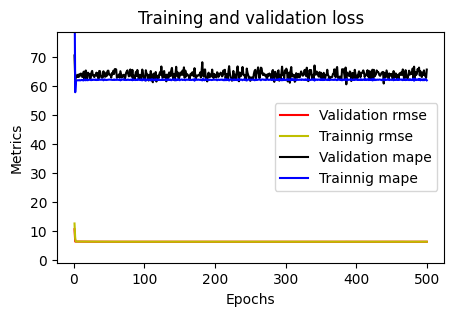

In [41]:
plotme(model2_4)

In [33]:
# inputs: distance + hour
model2_4 = nnmodel(5,10,10,15, num_hlayers=2,Epoch=500)
model2_4

Epoch 1/500
365/365 [==============================] - 1s 1ms/step - loss: 413345.2812 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 590493.0000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 98.5715 - traveltime_layer_rmse: 768.4354 - val_loss: 384237.8125 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 548911.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 94.1989 - val_traveltime_layer_rmse: 740.8853
Epoch 2/500
365/365 [==============================] - 0s 1ms/step - loss: 329564.9688 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 470806.8438 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 79.0469 - traveltime_layer_rmse: 686.1537 - val_loss: 240906.9844 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 344152.8438 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 17/500
365/365 [==============================] - 0s 1ms/step - loss: 102242.2188 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146060.2812 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2396 - traveltime_layer_rmse: 382.1783 - val_loss: 100380.4609 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143400.5469 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.5683 - val_traveltime_layer_rmse: 378.6826
Epoch 18/500
365/365 [==============================] - 0s 1ms/step - loss: 102239.8906 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146057.0156 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0927 - traveltime_layer_rmse: 382.1741 - val_loss: 100459.1172 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143512.9375 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 33/500
365/365 [==============================] - 0s 1ms/step - loss: 102184.7344 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145978.1562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2030 - traveltime_layer_rmse: 382.0709 - val_loss: 100382.4922 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143403.5000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7290 - val_traveltime_layer_rmse: 378.6866
Epoch 34/500
365/365 [==============================] - 0s 1ms/step - loss: 102165.3281 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145950.5000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5743 - traveltime_layer_rmse: 382.0347 - val_loss: 100266.7812 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143238.1719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 49/500
365/365 [==============================] - 0s 1ms/step - loss: 102182.3750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145974.7812 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2385 - traveltime_layer_rmse: 382.0665 - val_loss: 100301.8203 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143288.2031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.8616 - val_traveltime_layer_rmse: 378.5343
Epoch 50/500
365/365 [==============================] - 0s 1ms/step - loss: 102167.4844 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145953.6094 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1038 - traveltime_layer_rmse: 382.0388 - val_loss: 100348.9531 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143355.5469 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 65/500
365/365 [==============================] - 0s 1ms/step - loss: 102146.0547 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145922.8906 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1087 - traveltime_layer_rmse: 381.9985 - val_loss: 100320.5859 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143315.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2732 - val_traveltime_layer_rmse: 378.5698
Epoch 66/500
365/365 [==============================] - 0s 1ms/step - loss: 102147.2812 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145924.6719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4356 - traveltime_layer_rmse: 382.0009 - val_loss: 100269.4219 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143242.0156 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 81/500
365/365 [==============================] - 0s 1ms/step - loss: 102123.1953 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145890.2656 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4165 - traveltime_layer_rmse: 381.9558 - val_loss: 100249.0703 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143212.8906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.2250 - val_traveltime_layer_rmse: 378.4348
Epoch 82/500
365/365 [==============================] - 0s 1ms/step - loss: 102112.8359 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145875.4375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.9713 - traveltime_layer_rmse: 381.9364 - val_loss: 100338.6094 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143340.8125 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 97/500
365/365 [==============================] - 0s 1ms/step - loss: 102125.0938 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145892.8594 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.9033 - traveltime_layer_rmse: 381.9592 - val_loss: 100358.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143368.6562 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7230 - val_traveltime_layer_rmse: 378.6405
Epoch 98/500
365/365 [==============================] - 0s 1ms/step - loss: 102121.9375 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145888.3750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2713 - traveltime_layer_rmse: 381.9534 - val_loss: 100303.0000 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143289.9219 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

365/365 [==============================] - 0s 1ms/step - loss: 102106.7969 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145866.8125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3423 - traveltime_layer_rmse: 381.9251 - val_loss: 100264.9531 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143235.5156 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.8689 - val_traveltime_layer_rmse: 378.4647
Epoch 113/500
365/365 [==============================] - 0s 1ms/step - loss: 102108.8203 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145869.6719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4125 - traveltime_layer_rmse: 381.9289 - val_loss: 100222.4531 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143174.8906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.2

Epoch 128/500
365/365 [==============================] - 0s 1ms/step - loss: 102091.0859 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145844.4062 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2078 - traveltime_layer_rmse: 381.8958 - val_loss: 100371.0625 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143387.1406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.9136 - val_traveltime_layer_rmse: 378.6649
Epoch 129/500
365/365 [==============================] - 0s 1ms/step - loss: 102114.0312 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145877.1719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2437 - traveltime_layer_rmse: 381.9387 - val_loss: 100332.3672 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143331.8750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102036.1406 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145765.9062 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.8303 - traveltime_layer_rmse: 381.7930 - val_loss: 100548.6484 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143640.8281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.8606 - val_traveltime_layer_rmse: 378.9998
Epoch 144/500
365/365 [==============================] - 0s 1ms/step - loss: 102134.4922 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145906.2969 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.6273 - traveltime_layer_rmse: 381.9768 - val_loss: 100251.5547 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143216.4531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.0

Epoch 159/500
365/365 [==============================] - 0s 1ms/step - loss: 102098.1094 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145854.4062 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2425 - traveltime_layer_rmse: 381.9089 - val_loss: 100200.3359 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143143.2188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.5119 - val_traveltime_layer_rmse: 378.3427
Epoch 160/500
365/365 [==============================] - 0s 1ms/step - loss: 102123.4844 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145890.7656 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2021 - traveltime_layer_rmse: 381.9565 - val_loss: 100203.3984 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143147.6250 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102096.5781 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145852.2031 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1851 - traveltime_layer_rmse: 381.9060 - val_loss: 100314.6953 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143306.6719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7259 - val_traveltime_layer_rmse: 378.5587
Epoch 175/500
365/365 [==============================] - 0s 1ms/step - loss: 102108.1797 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145868.7969 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5047 - traveltime_layer_rmse: 381.9277 - val_loss: 100210.2500 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143157.3750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.8

Epoch 190/500
365/365 [==============================] - 0s 1ms/step - loss: 102115.0547 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145878.5781 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1281 - traveltime_layer_rmse: 381.9406 - val_loss: 100220.1875 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143171.6562 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2017 - val_traveltime_layer_rmse: 378.3803
Epoch 191/500
365/365 [==============================] - 0s 1ms/step - loss: 102104.1094 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145862.8594 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2383 - traveltime_layer_rmse: 381.9200 - val_loss: 100291.1719 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143273.0469 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102096.6016 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145852.2188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2196 - traveltime_layer_rmse: 381.9060 - val_loss: 100244.0625 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143205.7500 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.3476 - val_traveltime_layer_rmse: 378.4254
Epoch 206/500
365/365 [==============================] - 0s 1ms/step - loss: 102104.3906 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145863.3594 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0863 - traveltime_layer_rmse: 381.9206 - val_loss: 100197.5859 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143139.3594 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.0

Epoch 221/500
365/365 [==============================] - 0s 1ms/step - loss: 102112.7344 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145875.3594 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2221 - traveltime_layer_rmse: 381.9363 - val_loss: 100243.5547 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143205.0781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2094 - val_traveltime_layer_rmse: 378.4245
Epoch 222/500
365/365 [==============================] - 0s 1ms/step - loss: 102099.0234 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145855.6562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3574 - traveltime_layer_rmse: 381.9105 - val_loss: 100247.4688 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143210.5312 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102098.9766 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145855.6719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1163 - traveltime_layer_rmse: 381.9106 - val_loss: 100288.2969 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143268.9375 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.5766 - val_traveltime_layer_rmse: 378.5088
Epoch 237/500
365/365 [==============================] - 0s 1ms/step - loss: 102102.7266 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145861.0156 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2864 - traveltime_layer_rmse: 381.9175 - val_loss: 100220.3438 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143171.8750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1

Epoch 252/500
365/365 [==============================] - 0s 1ms/step - loss: 102099.5859 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145856.4375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5813 - traveltime_layer_rmse: 381.9116 - val_loss: 100186.9375 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143124.1719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.0075 - val_traveltime_layer_rmse: 378.3176
Epoch 253/500
365/365 [==============================] - 0s 1ms/step - loss: 102093.7969 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145848.1719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.9990 - traveltime_layer_rmse: 381.9007 - val_loss: 100261.8359 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143231.2031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102101.9219 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145859.8594 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2509 - traveltime_layer_rmse: 381.9160 - val_loss: 100265.9141 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143236.8906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1986 - val_traveltime_layer_rmse: 378.4665
Epoch 268/500
365/365 [==============================] - 0s 1ms/step - loss: 102106.3672 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145866.1719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3076 - traveltime_layer_rmse: 381.9243 - val_loss: 100220.4375 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143171.9844 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7

Epoch 283/500
365/365 [==============================] - 0s 1ms/step - loss: 102110.1641 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145871.6250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.6318 - traveltime_layer_rmse: 381.9314 - val_loss: 100209.1875 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143155.9062 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7219 - val_traveltime_layer_rmse: 378.3595
Epoch 284/500
365/365 [==============================] - 0s 1ms/step - loss: 102091.9453 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145845.6406 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1931 - traveltime_layer_rmse: 381.8974 - val_loss: 100235.7891 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143193.9219 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102121.6484 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145888.0000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1335 - traveltime_layer_rmse: 381.9529 - val_loss: 100249.5938 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143213.6406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.3263 - val_traveltime_layer_rmse: 378.4358
Epoch 299/500
365/365 [==============================] - 0s 1ms/step - loss: 102095.2031 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145850.2656 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2417 - traveltime_layer_rmse: 381.9035 - val_loss: 100229.2812 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143184.5938 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7

Epoch 314/500
365/365 [==============================] - 0s 1ms/step - loss: 102099.7578 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145856.7500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2023 - traveltime_layer_rmse: 381.9120 - val_loss: 100272.3359 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143246.1562 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.4942 - val_traveltime_layer_rmse: 378.4787
Epoch 315/500
365/365 [==============================] - 0s 1ms/step - loss: 102102.4375 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145860.6250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5110 - traveltime_layer_rmse: 381.9171 - val_loss: 100191.2344 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143130.2188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102108.6094 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145869.3750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2062 - traveltime_layer_rmse: 381.9285 - val_loss: 100281.1484 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143258.6406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.3230 - val_traveltime_layer_rmse: 378.4952
Epoch 330/500
365/365 [==============================] - 0s 1ms/step - loss: 102099.3125 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145856.1250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3977 - traveltime_layer_rmse: 381.9111 - val_loss: 100248.4609 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143212.0312 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1

Epoch 345/500
365/365 [==============================] - 0s 1ms/step - loss: 102089.7344 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145842.5781 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0840 - traveltime_layer_rmse: 381.8934 - val_loss: 100264.1016 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143234.3125 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.3144 - val_traveltime_layer_rmse: 378.4631
Epoch 346/500
365/365 [==============================] - 0s 1ms/step - loss: 102099.4766 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145856.3438 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4232 - traveltime_layer_rmse: 381.9114 - val_loss: 100193.0781 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143132.9375 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102102.1094 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145860.1562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0044 - traveltime_layer_rmse: 381.9164 - val_loss: 100254.5000 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143220.6562 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2185 - val_traveltime_layer_rmse: 378.4450
Epoch 361/500
365/365 [==============================] - 0s 1ms/step - loss: 102110.1250 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145871.4844 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2353 - traveltime_layer_rmse: 381.9312 - val_loss: 100290.4375 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143271.9531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.5

Epoch 376/500
365/365 [==============================] - 0s 1ms/step - loss: 102116.3125 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145880.4531 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2840 - traveltime_layer_rmse: 381.9430 - val_loss: 100232.9375 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143189.8906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.1870 - val_traveltime_layer_rmse: 378.4044
Epoch 377/500
365/365 [==============================] - 0s 1ms/step - loss: 102103.1406 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145861.5938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0084 - traveltime_layer_rmse: 381.9183 - val_loss: 100275.7188 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143251.0469 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102094.0312 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145848.5625 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2934 - traveltime_layer_rmse: 381.9012 - val_loss: 100241.2656 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143201.8125 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7466 - val_traveltime_layer_rmse: 378.4202
Epoch 392/500
365/365 [==============================] - 0s 1ms/step - loss: 102105.6406 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145865.0781 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1886 - traveltime_layer_rmse: 381.9229 - val_loss: 100234.5391 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143192.1875 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9

Epoch 407/500
365/365 [==============================] - 0s 1ms/step - loss: 102083.7422 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145833.8438 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5310 - traveltime_layer_rmse: 381.8820 - val_loss: 100221.0312 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143172.8906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.6786 - val_traveltime_layer_rmse: 378.3819
Epoch 408/500
365/365 [==============================] - 0s 1ms/step - loss: 102117.8750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145882.6094 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0799 - traveltime_layer_rmse: 381.9458 - val_loss: 100306.8516 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143295.4062 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102114.0625 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145877.0938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3182 - traveltime_layer_rmse: 381.9386 - val_loss: 100268.6094 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143240.8281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2344 - val_traveltime_layer_rmse: 378.4717
Epoch 423/500
365/365 [==============================] - 0s 1ms/step - loss: 102058.8906 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145798.3281 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5989 - traveltime_layer_rmse: 381.8355 - val_loss: 100190.8594 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143129.7188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 61.6

Epoch 438/500
365/365 [==============================] - 0s 1ms/step - loss: 102100.7500 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145858.2500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2278 - traveltime_layer_rmse: 381.9139 - val_loss: 100330.8047 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143329.7031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7619 - val_traveltime_layer_rmse: 378.5891
Epoch 439/500
365/365 [==============================] - 0s 1ms/step - loss: 102093.7734 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145848.1250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3385 - traveltime_layer_rmse: 381.9007 - val_loss: 100231.0078 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143187.0469 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102084.8281 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145835.4219 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4662 - traveltime_layer_rmse: 381.8840 - val_loss: 100206.7891 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143152.5000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.5457 - val_traveltime_layer_rmse: 378.3550
Epoch 454/500
365/365 [==============================] - 0s 1ms/step - loss: 102092.9609 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145847.0938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2200 - traveltime_layer_rmse: 381.8993 - val_loss: 100183.6250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143119.3594 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.1

Epoch 469/500
365/365 [==============================] - 0s 1ms/step - loss: 102102.4297 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145860.6406 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1432 - traveltime_layer_rmse: 381.9171 - val_loss: 100233.4922 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143190.6250 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1784 - val_traveltime_layer_rmse: 378.4054
Epoch 470/500
365/365 [==============================] - 0s 1ms/step - loss: 102090.8438 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145844.0625 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4169 - traveltime_layer_rmse: 381.8954 - val_loss: 100212.2812 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143160.3281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102091.2422 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145844.6094 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4515 - traveltime_layer_rmse: 381.8961 - val_loss: 100193.1328 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143132.9844 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.3356 - val_traveltime_layer_rmse: 378.3292
Epoch 485/500
365/365 [==============================] - 0s 1ms/step - loss: 102105.0078 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145864.0938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.8674 - traveltime_layer_rmse: 381.9216 - val_loss: 100300.2500 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143285.9844 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7

Epoch 500/500
365/365 [==============================] - 0s 1ms/step - loss: 102092.0391 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145845.6875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1584 - traveltime_layer_rmse: 381.8975 - val_loss: 100270.7969 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143243.8906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2669 - val_traveltime_layer_rmse: 378.4757
minimum testing RMSE (distance):  0.00034741699695587156
minimum testing MAPE (distance):  0.9997999572753906
-----------------
minimum testing ravel time):  6.3044281005859375
minimum testing MAPE (travel time):  0.5165547561645508


In [34]:
# inputs: distance + hour
model2_4 = nnmodel(5,10,10,20, num_hlayers=2,Epoch=500)
model2_4

Epoch 1/500
365/365 [==============================] - 1s 1ms/step - loss: 408746.9375 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 583924.3750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 97.5306 - traveltime_layer_rmse: 764.1495 - val_loss: 369293.2188 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 527561.5625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 90.8175 - val_traveltime_layer_rmse: 726.3344
Epoch 2/500
365/365 [==============================] - 0s 991us/step - loss: 296322.5625 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 423317.9062 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 71.8427 - traveltime_layer_rmse: 650.6288 - val_loss: 198500.4375 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 283571.9375 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 17/500
365/365 [==============================] - 0s 1ms/step - loss: 102073.3828 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145819.0781 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.9691 - traveltime_layer_rmse: 381.8626 - val_loss: 100456.1328 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143508.6719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.4580 - val_traveltime_layer_rmse: 378.8254
Epoch 18/500
365/365 [==============================] - 0s 1ms/step - loss: 102080.4609 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145829.1250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4001 - traveltime_layer_rmse: 381.8758 - val_loss: 100302.5078 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143289.2969 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 33/500
365/365 [==============================] - 0s 1ms/step - loss: 102103.6016 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145862.1406 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3241 - traveltime_layer_rmse: 381.9190 - val_loss: 100181.4297 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143116.2500 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.5132 - val_traveltime_layer_rmse: 378.3071
Epoch 34/500
365/365 [==============================] - 0s 1ms/step - loss: 102117.7109 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145882.3906 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0834 - traveltime_layer_rmse: 381.9455 - val_loss: 100227.4609 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143182.0469 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 49/500
365/365 [==============================] - 0s 1ms/step - loss: 102069.0312 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145812.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2965 - traveltime_layer_rmse: 381.8545 - val_loss: 100156.0469 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143079.9844 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 61.9451 - val_traveltime_layer_rmse: 378.2592
Epoch 50/500
365/365 [==============================] - 0s 1ms/step - loss: 102112.7031 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145875.3281 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0939 - traveltime_layer_rmse: 381.9363 - val_loss: 100222.0000 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143174.2031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 65/500
365/365 [==============================] - 0s 1ms/step - loss: 102098.9219 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145855.6094 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4201 - traveltime_layer_rmse: 381.9105 - val_loss: 100158.3672 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143083.2344 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.6027 - val_traveltime_layer_rmse: 378.2635
Epoch 66/500
365/365 [==============================] - 0s 1ms/step - loss: 102096.8047 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145852.5000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2972 - traveltime_layer_rmse: 381.9064 - val_loss: 100165.5000 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143093.5312 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 81/500
365/365 [==============================] - 0s 1ms/step - loss: 102103.8672 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145862.5469 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1921 - traveltime_layer_rmse: 381.9196 - val_loss: 100322.4609 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143317.7812 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.9910 - val_traveltime_layer_rmse: 378.5734
Epoch 82/500
365/365 [==============================] - 0s 1ms/step - loss: 102081.4922 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145830.6406 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2168 - traveltime_layer_rmse: 381.8778 - val_loss: 100244.7812 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143206.7188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 97/500
365/365 [==============================] - 0s 1ms/step - loss: 102086.0156 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145837.0156 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2328 - traveltime_layer_rmse: 381.8861 - val_loss: 100168.2422 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143097.4375 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.6080 - val_traveltime_layer_rmse: 378.2822
Epoch 98/500
365/365 [==============================] - 0s 1ms/step - loss: 102095.8281 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145851.0938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1470 - traveltime_layer_rmse: 381.9046 - val_loss: 100133.8750 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143048.3438 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

365/365 [==============================] - 0s 1ms/step - loss: 102089.3828 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145841.9531 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2379 - traveltime_layer_rmse: 381.8926 - val_loss: 100203.3984 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143147.6406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.8455 - val_traveltime_layer_rmse: 378.3486
Epoch 113/500
365/365 [==============================] - 0s 1ms/step - loss: 102074.5078 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145820.7188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3555 - traveltime_layer_rmse: 381.8648 - val_loss: 100150.4844 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143072.1094 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.6

Epoch 128/500
365/365 [==============================] - 0s 1ms/step - loss: 102107.6406 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145867.9531 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2734 - traveltime_layer_rmse: 381.9266 - val_loss: 100209.0625 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143155.7031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1101 - val_traveltime_layer_rmse: 378.3592
Epoch 129/500
365/365 [==============================] - 0s 1ms/step - loss: 102083.6484 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145833.7031 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1989 - traveltime_layer_rmse: 381.8818 - val_loss: 100199.2109 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143141.6406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102083.7188 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145833.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4379 - traveltime_layer_rmse: 381.8820 - val_loss: 100143.4453 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143061.9531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7448 - val_traveltime_layer_rmse: 378.2353
Epoch 144/500
365/365 [==============================] - 0s 1ms/step - loss: 102082.0859 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145831.5156 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0819 - traveltime_layer_rmse: 381.8789 - val_loss: 100246.7266 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143209.5469 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2

Epoch 159/500
365/365 [==============================] - 0s 992us/step - loss: 102076.2969 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145823.1250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2848 - traveltime_layer_rmse: 381.8680 - val_loss: 100170.5703 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143100.7812 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.0302 - val_traveltime_layer_rmse: 378.2867
Epoch 160/500
365/365 [==============================] - 0s 1ms/step - loss: 102075.3125 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145821.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2210 - traveltime_layer_rmse: 381.8663 - val_loss: 100259.3906 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143227.5781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_

365/365 [==============================] - 0s 1ms/step - loss: 102071.2188 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145815.9531 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.9693 - traveltime_layer_rmse: 381.8586 - val_loss: 100211.5234 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143159.2188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1310 - val_traveltime_layer_rmse: 378.3639
Epoch 175/500
365/365 [==============================] - 0s 1ms/step - loss: 102074.8203 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145821.1406 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3886 - traveltime_layer_rmse: 381.8654 - val_loss: 100136.2031 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143051.6406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.0

Epoch 190/500
365/365 [==============================] - 0s 1ms/step - loss: 102091.2812 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145844.6562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3462 - traveltime_layer_rmse: 381.8961 - val_loss: 100202.9141 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143146.9062 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9658 - val_traveltime_layer_rmse: 378.3476
Epoch 191/500
365/365 [==============================] - 0s 999us/step - loss: 102058.5859 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145797.9531 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2400 - traveltime_layer_rmse: 381.8350 - val_loss: 100139.3438 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143056.1406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_

365/365 [==============================] - 0s 1ms/step - loss: 102091.4531 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145844.8281 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3561 - traveltime_layer_rmse: 381.8964 - val_loss: 100137.6484 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143053.7969 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.2546 - val_traveltime_layer_rmse: 378.2245
Epoch 206/500
365/365 [==============================] - 0s 1ms/step - loss: 102064.8828 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145806.9844 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.9120 - traveltime_layer_rmse: 381.8468 - val_loss: 100360.6172 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143372.2812 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.1

Epoch 221/500
365/365 [==============================] - 0s 1ms/step - loss: 102047.8125 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145782.5469 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4080 - traveltime_layer_rmse: 381.8148 - val_loss: 100203.6016 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143147.9531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.2915 - val_traveltime_layer_rmse: 378.3490
Epoch 222/500
365/365 [==============================] - 0s 1ms/step - loss: 102082.9766 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145832.7344 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0983 - traveltime_layer_rmse: 381.8805 - val_loss: 100234.2031 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143191.5938 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102078.3203 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145826.2031 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1278 - traveltime_layer_rmse: 381.8720 - val_loss: 100198.3984 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143140.4688 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.3701 - val_traveltime_layer_rmse: 378.3391
Epoch 237/500
365/365 [==============================] - 0s 1ms/step - loss: 102103.2500 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145861.8125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1708 - traveltime_layer_rmse: 381.9186 - val_loss: 100180.9922 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143115.6094 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.8

Epoch 252/500
365/365 [==============================] - 0s 1ms/step - loss: 102070.8359 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145815.3750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1127 - traveltime_layer_rmse: 381.8578 - val_loss: 100194.7109 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143135.2500 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2267 - val_traveltime_layer_rmse: 378.3322
Epoch 253/500
365/365 [==============================] - 0s 1ms/step - loss: 102069.5469 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145813.5156 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2776 - traveltime_layer_rmse: 381.8553 - val_loss: 100202.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143145.8281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102084.5469 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145835.0469 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3243 - traveltime_layer_rmse: 381.8835 - val_loss: 100207.6406 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143153.7188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9133 - val_traveltime_layer_rmse: 378.3566
Epoch 268/500
365/365 [==============================] - 0s 995us/step - loss: 102062.9062 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145804.1562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1739 - traveltime_layer_rmse: 381.8431 - val_loss: 100210.5781 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143157.9219 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63

Epoch 283/500
365/365 [==============================] - 0s 1ms/step - loss: 102093.5938 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145847.8906 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4548 - traveltime_layer_rmse: 381.9004 - val_loss: 100176.6641 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143109.4688 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9773 - val_traveltime_layer_rmse: 378.2981
Epoch 284/500
365/365 [==============================] - 0s 1ms/step - loss: 102086.5234 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145837.6719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0534 - traveltime_layer_rmse: 381.8870 - val_loss: 100237.0312 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143195.6875 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102072.8438 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145818.2500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1140 - traveltime_layer_rmse: 381.8616 - val_loss: 100166.5938 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143095.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1133 - val_traveltime_layer_rmse: 378.2791
Epoch 299/500
365/365 [==============================] - 0s 1ms/step - loss: 102086.7500 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145838.2344 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3427 - traveltime_layer_rmse: 381.8877 - val_loss: 100190.3594 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143129.0781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2

Epoch 314/500
365/365 [==============================] - 0s 995us/step - loss: 102075.5078 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145822.0938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0546 - traveltime_layer_rmse: 381.8666 - val_loss: 100326.0391 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143322.8594 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.8552 - val_traveltime_layer_rmse: 378.5800
Epoch 315/500
365/365 [==============================] - 0s 1ms/step - loss: 102070.6172 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145815.0781 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3821 - traveltime_layer_rmse: 381.8574 - val_loss: 100180.8438 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143115.3906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_

365/365 [==============================] - 0s 1ms/step - loss: 102073.7109 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145819.5469 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.9691 - traveltime_layer_rmse: 381.8633 - val_loss: 100393.2422 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143418.8281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.2449 - val_traveltime_layer_rmse: 378.7068
Epoch 330/500
365/365 [==============================] - 0s 1ms/step - loss: 102045.9141 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145779.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.6395 - traveltime_layer_rmse: 381.8113 - val_loss: 100149.6641 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143070.9219 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 61.4

365/365 [==============================] - 0s 1ms/step - loss: 102079.0703 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145827.1094 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0365 - traveltime_layer_rmse: 381.8732 - val_loss: 100295.5156 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143279.2969 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7816 - val_traveltime_layer_rmse: 378.5225
Epoch 345/500
365/365 [==============================] - 0s 1ms/step - loss: 102084.5469 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145835.0000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4450 - traveltime_layer_rmse: 381.8835 - val_loss: 100195.3906 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143136.1719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9

Epoch 360/500
365/365 [==============================] - 0s 1ms/step - loss: 102087.7188 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145839.5469 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1312 - traveltime_layer_rmse: 381.8894 - val_loss: 100150.7266 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143072.3906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.4743 - val_traveltime_layer_rmse: 378.2491
Epoch 361/500
365/365 [==============================] - 0s 990us/step - loss: 102090.6484 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145843.7031 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1720 - traveltime_layer_rmse: 381.8949 - val_loss: 100159.1797 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143084.4531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_

365/365 [==============================] - 0s 1ms/step - loss: 102055.9062 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145794.0938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3833 - traveltime_layer_rmse: 381.8299 - val_loss: 100169.4922 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143099.2188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.3686 - val_traveltime_layer_rmse: 378.2846
Epoch 376/500
365/365 [==============================] - 0s 1ms/step - loss: 102097.3359 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145853.2969 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1350 - traveltime_layer_rmse: 381.9074 - val_loss: 100165.3516 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143093.3281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7

Epoch 391/500
365/365 [==============================] - 0s 1ms/step - loss: 102068.7812 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145812.6406 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1624 - traveltime_layer_rmse: 381.8542 - val_loss: 100244.2891 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143206.0781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2709 - val_traveltime_layer_rmse: 378.4258
Epoch 392/500
365/365 [==============================] - 0s 1ms/step - loss: 102059.4609 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145799.1562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3470 - traveltime_layer_rmse: 381.8365 - val_loss: 100175.9766 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143108.5000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102082.6484 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145832.3281 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1426 - traveltime_layer_rmse: 381.8800 - val_loss: 100234.4844 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143192.1250 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2980 - val_traveltime_layer_rmse: 378.4073
Epoch 407/500
365/365 [==============================] - 0s 1ms/step - loss: 102062.7109 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145803.7500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.9317 - traveltime_layer_rmse: 381.8426 - val_loss: 100352.3750 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143360.4844 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.1

Epoch 422/500
365/365 [==============================] - 0s 1ms/step - loss: 102089.3438 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145841.9219 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1330 - traveltime_layer_rmse: 381.8925 - val_loss: 100242.9766 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143204.1562 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.3416 - val_traveltime_layer_rmse: 378.4232
Epoch 423/500
365/365 [==============================] - 0s 1ms/step - loss: 102098.8594 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145855.4688 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2054 - traveltime_layer_rmse: 381.9103 - val_loss: 100203.1875 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143147.3438 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102085.3359 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145836.2344 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2047 - traveltime_layer_rmse: 381.8851 - val_loss: 100269.1094 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143241.5156 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.5963 - val_traveltime_layer_rmse: 378.4726
Epoch 438/500
365/365 [==============================] - 0s 1ms/step - loss: 102069.0469 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145812.7188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1927 - traveltime_layer_rmse: 381.8543 - val_loss: 100281.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143258.6562 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7

Epoch 453/500
365/365 [==============================] - 0s 1ms/step - loss: 102086.7422 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145838.0938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1035 - traveltime_layer_rmse: 381.8875 - val_loss: 100191.6953 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143130.9375 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.0799 - val_traveltime_layer_rmse: 378.3265
Epoch 454/500
365/365 [==============================] - 0s 1ms/step - loss: 102100.7188 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145858.1094 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3749 - traveltime_layer_rmse: 381.9138 - val_loss: 100180.7109 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143115.2500 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102087.5000 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145839.2344 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3256 - traveltime_layer_rmse: 381.8890 - val_loss: 100171.4219 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143102.0312 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.4815 - val_traveltime_layer_rmse: 378.2883
Epoch 469/500
365/365 [==============================] - 0s 1ms/step - loss: 102066.0469 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145808.5156 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3224 - traveltime_layer_rmse: 381.8488 - val_loss: 100143.4844 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143062.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.0

Epoch 484/500
365/365 [==============================] - 0s 1ms/step - loss: 102047.7656 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145782.5312 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.9973 - traveltime_layer_rmse: 381.8148 - val_loss: 100348.9453 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143355.5312 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.2367 - val_traveltime_layer_rmse: 378.6232
Epoch 485/500
365/365 [==============================] - 0s 999us/step - loss: 102075.6953 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145822.3906 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5585 - traveltime_layer_rmse: 381.8670 - val_loss: 100166.1562 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143094.4531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_

365/365 [==============================] - 0s 988us/step - loss: 102065.2266 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145807.3750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1570 - traveltime_layer_rmse: 381.8473 - val_loss: 100176.2422 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143108.9219 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.0383 - val_traveltime_layer_rmse: 378.2974
Epoch 500/500
365/365 [==============================] - 0s 1ms/step - loss: 102083.6016 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145833.6875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3798 - traveltime_layer_rmse: 381.8818 - val_loss: 100153.0859 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143075.7031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62

In [35]:
# inputs: distance + hour
model2_4 = nnmodel(10,15,15,25, num_hlayers=2,Epoch=100)
model2_4

Epoch 1/100
365/365 [==============================] - 1s 1ms/step - loss: 419892.4375 - distance_layer_loss: 0.0431 - traveltime_layer_loss: 599846.3750 - distance_layer_mape: 195.4744 - distance_layer_rmse: 0.2077 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4975 - val_loss: 409773.0938 - val_distance_layer_loss: 0.0400 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 40766.7617 - val_distance_layer_rmse: 0.2001 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 2/100
365/365 [==============================] - 0s 1ms/step - loss: 419892.2188 - distance_layer_loss: 0.0385 - traveltime_layer_loss: 599845.8750 - distance_layer_mape: 185.8248 - distance_layer_rmse: 0.1962 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4972 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0340 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 40429.1719 - val_distance_layer_rmse: 0.1844 - val_travelti

Epoch 17/100
365/365 [==============================] - 0s 1ms/step - loss: 102186.5625 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145980.7500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4030 - traveltime_layer_rmse: 382.0743 - val_loss: 100173.2109 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143104.5625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.0307 - val_traveltime_layer_rmse: 378.2916
Epoch 18/100
365/365 [==============================] - 0s 1ms/step - loss: 102166.3203 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145951.7188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3945 - traveltime_layer_rmse: 382.0363 - val_loss: 100142.5938 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143060.8438 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 33/100
365/365 [==============================] - 0s 1ms/step - loss: 102145.2500 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145921.7656 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5289 - traveltime_layer_rmse: 381.9971 - val_loss: 100204.3828 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143149.0312 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1425 - val_traveltime_layer_rmse: 378.3504
Epoch 34/100
365/365 [==============================] - 0s 1ms/step - loss: 102134.5781 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145906.5000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2991 - traveltime_layer_rmse: 381.9771 - val_loss: 100176.0391 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143108.5625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 49/100
365/365 [==============================] - 0s 1ms/step - loss: 102099.0938 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145855.7812 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2924 - traveltime_layer_rmse: 381.9107 - val_loss: 100176.0625 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143108.6094 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.0226 - val_traveltime_layer_rmse: 378.2970
Epoch 50/100
365/365 [==============================] - 0s 1ms/step - loss: 102122.6484 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145889.4219 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1279 - traveltime_layer_rmse: 381.9547 - val_loss: 100244.5859 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143206.5000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 65/100
365/365 [==============================] - 0s 1ms/step - loss: 102128.2500 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145897.5000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4047 - traveltime_layer_rmse: 381.9653 - val_loss: 100312.3516 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143303.2969 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.0586 - val_traveltime_layer_rmse: 378.5542
Epoch 66/100
365/365 [==============================] - 0s 1ms/step - loss: 102117.9375 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145882.7500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3500 - traveltime_layer_rmse: 381.9460 - val_loss: 100257.5547 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143224.9844 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 81/100
365/365 [==============================] - 0s 1ms/step - loss: 102122.3516 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145889.0469 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3988 - traveltime_layer_rmse: 381.9543 - val_loss: 100143.7031 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143062.4062 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.6270 - val_traveltime_layer_rmse: 378.2359
Epoch 82/100
365/365 [==============================] - 0s 1ms/step - loss: 102074.5234 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145820.6875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3768 - traveltime_layer_rmse: 381.8647 - val_loss: 100134.0156 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143048.5625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 97/100
365/365 [==============================] - 0s 1ms/step - loss: 102087.0703 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145838.6250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0650 - traveltime_layer_rmse: 381.8882 - val_loss: 100242.1875 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143203.0781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.5795 - val_traveltime_layer_rmse: 378.4218
Epoch 98/100
365/365 [==============================] - 0s 1ms/step - loss: 102093.7891 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145848.2656 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3751 - traveltime_layer_rmse: 381.9008 - val_loss: 100210.1094 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143157.2031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

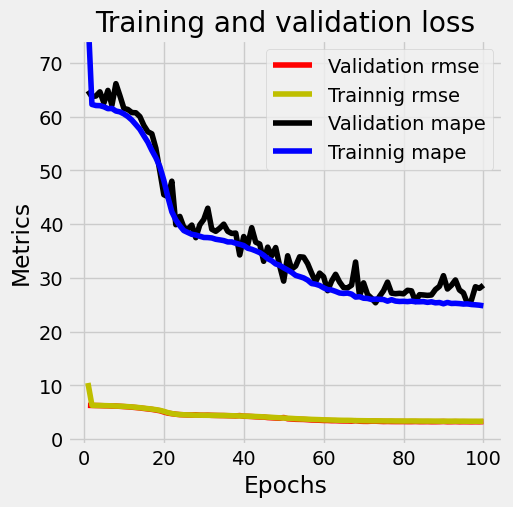

In [37]:
plotme(model2_4)

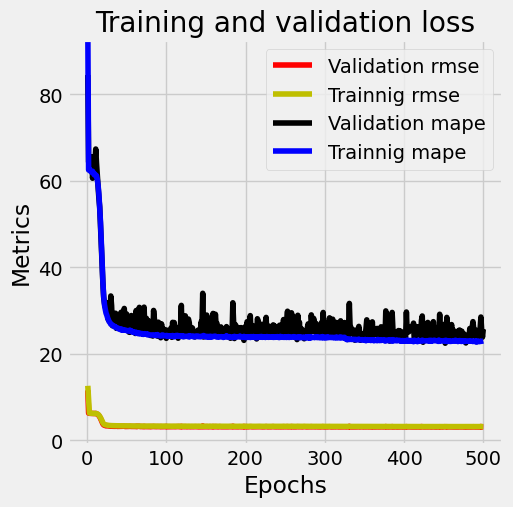

In [104]:
plotme(model2_4)

In [36]:
# inputs: distance + hour
model2_4 = nnmodel(5,6,2,5,10,15, num_hlayers=3,Epoch=500)
model2_4

Epoch 1/500
365/365 [==============================] - 1s 1ms/step - loss: 396658.4688 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 566654.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 94.6638 - traveltime_layer_rmse: 752.7648 - val_loss: 300560.7812 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 429372.5938 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 73.4839 - val_traveltime_layer_rmse: 655.2653
Epoch 2/500
365/365 [==============================] - 0s 1ms/step - loss: 167096.0469 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 238708.7812 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 56.6744 - traveltime_layer_rmse: 488.5783 - val_loss: 107560.4766 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 153657.7656 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 17/500
365/365 [==============================] - 0s 1ms/step - loss: 102309.7109 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146156.6250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5052 - traveltime_layer_rmse: 382.3044 - val_loss: 100607.5859 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143725.0000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7985 - val_traveltime_layer_rmse: 379.1108
Epoch 18/500
365/365 [==============================] - 0s 1ms/step - loss: 102337.6250 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146196.5469 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4720 - traveltime_layer_rmse: 382.3566 - val_loss: 100393.4453 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143419.1406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 33/500
365/365 [==============================] - 0s 1ms/step - loss: 102283.6250 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146119.5000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2125 - traveltime_layer_rmse: 382.2558 - val_loss: 100567.1719 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143667.3281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.3764 - val_traveltime_layer_rmse: 379.0347
Epoch 34/500
365/365 [==============================] - 0s 1ms/step - loss: 102295.6016 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146136.5000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5281 - traveltime_layer_rmse: 382.2780 - val_loss: 100337.5781 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143339.3125 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 49/500
365/365 [==============================] - 0s 1ms/step - loss: 102246.3203 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146066.0625 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2525 - traveltime_layer_rmse: 382.1859 - val_loss: 100387.4922 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143410.6406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2506 - val_traveltime_layer_rmse: 378.6960
Epoch 50/500
365/365 [==============================] - 0s 1ms/step - loss: 102219.4688 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146027.7188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3533 - traveltime_layer_rmse: 382.1357 - val_loss: 100342.7656 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143346.7656 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 65/500
365/365 [==============================] - 0s 1ms/step - loss: 102222.3594 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146031.8281 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3563 - traveltime_layer_rmse: 382.1411 - val_loss: 100350.7812 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143358.1875 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 61.7984 - val_traveltime_layer_rmse: 378.6267
Epoch 66/500
365/365 [==============================] - 0s 1ms/step - loss: 102227.2969 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146038.9531 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1949 - traveltime_layer_rmse: 382.1504 - val_loss: 100493.1094 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143561.5156 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 81/500
365/365 [==============================] - 0s 1ms/step - loss: 102277.9922 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146111.3125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3801 - traveltime_layer_rmse: 382.2451 - val_loss: 100293.4766 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143276.3125 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7456 - val_traveltime_layer_rmse: 378.5186
Epoch 82/500
365/365 [==============================] - 0s 1ms/step - loss: 102224.9531 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146035.5312 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1839 - traveltime_layer_rmse: 382.1460 - val_loss: 100567.8750 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143668.3281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 97/500
365/365 [==============================] - 0s 1ms/step - loss: 102260.8281 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146086.6562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5495 - traveltime_layer_rmse: 382.2128 - val_loss: 100328.9844 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143326.9688 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7153 - val_traveltime_layer_rmse: 378.5855
Epoch 98/500
365/365 [==============================] - 0s 1ms/step - loss: 102231.2500 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146044.5469 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3300 - traveltime_layer_rmse: 382.1577 - val_loss: 100313.5000 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143304.9062 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

365/365 [==============================] - 0s 1ms/step - loss: 102244.7500 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146063.9062 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2940 - traveltime_layer_rmse: 382.1831 - val_loss: 100415.5234 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143450.6562 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.6230 - val_traveltime_layer_rmse: 378.7488
Epoch 113/500
365/365 [==============================] - 0s 1ms/step - loss: 102209.7031 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146013.7031 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3374 - traveltime_layer_rmse: 382.1174 - val_loss: 100363.1172 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143375.8125 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.5

Epoch 128/500
365/365 [==============================] - 0s 1ms/step - loss: 102214.0781 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146020.0781 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.6425 - traveltime_layer_rmse: 382.1257 - val_loss: 100339.8516 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143342.5781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 61.7015 - val_traveltime_layer_rmse: 378.6061
Epoch 129/500
365/365 [==============================] - 0s 1ms/step - loss: 102304.1328 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146148.7500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1238 - traveltime_layer_rmse: 382.2941 - val_loss: 100368.4688 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143383.5156 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102232.5938 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146046.3906 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4964 - traveltime_layer_rmse: 382.1602 - val_loss: 100348.7031 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143355.2031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.4857 - val_traveltime_layer_rmse: 378.6228
Epoch 144/500
365/365 [==============================] - 0s 1ms/step - loss: 102205.6250 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146008.0625 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3708 - traveltime_layer_rmse: 382.1100 - val_loss: 100290.6875 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143272.3125 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.2

Epoch 159/500
365/365 [==============================] - 0s 1ms/step - loss: 102248.5547 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146069.2656 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1901 - traveltime_layer_rmse: 382.1901 - val_loss: 100467.1719 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143524.5000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.8908 - val_traveltime_layer_rmse: 378.8463
Epoch 160/500
365/365 [==============================] - 0s 1ms/step - loss: 102230.8906 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146044.1094 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4001 - traveltime_layer_rmse: 382.1572 - val_loss: 100391.4375 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143416.2969 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102237.5156 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146053.5938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2584 - traveltime_layer_rmse: 382.1696 - val_loss: 100432.2422 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143474.6250 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.4373 - val_traveltime_layer_rmse: 378.7805
Epoch 175/500
365/365 [==============================] - 0s 1ms/step - loss: 102218.5625 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146026.4062 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1858 - traveltime_layer_rmse: 382.1340 - val_loss: 100317.4375 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143310.5781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9

Epoch 190/500
365/365 [==============================] - 0s 1ms/step - loss: 102255.3594 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146078.9844 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3965 - traveltime_layer_rmse: 382.2028 - val_loss: 100450.4219 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143500.4688 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7734 - val_traveltime_layer_rmse: 378.8145
Epoch 191/500
365/365 [==============================] - 0s 1ms/step - loss: 102225.9375 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146036.8438 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2769 - traveltime_layer_rmse: 382.1477 - val_loss: 100509.9609 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143585.5625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102237.9453 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146054.0781 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1310 - traveltime_layer_rmse: 382.1702 - val_loss: 100499.6172 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143570.7812 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.0135 - val_traveltime_layer_rmse: 378.9073
Epoch 206/500
365/365 [==============================] - 0s 1ms/step - loss: 102252.3047 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146074.6250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4156 - traveltime_layer_rmse: 382.1971 - val_loss: 100352.7266 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143361.0000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.3

Epoch 221/500
365/365 [==============================] - 0s 1ms/step - loss: 102228.0859 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146040.1094 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2052 - traveltime_layer_rmse: 382.1519 - val_loss: 100395.9766 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143422.7812 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.4355 - val_traveltime_layer_rmse: 378.7120
Epoch 222/500
365/365 [==============================] - 0s 1ms/step - loss: 102243.3125 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146061.8281 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3133 - traveltime_layer_rmse: 382.1804 - val_loss: 100375.9453 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143394.1094 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102223.8750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146034.1250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1751 - traveltime_layer_rmse: 382.1441 - val_loss: 100326.4844 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143323.4688 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 61.7528 - val_traveltime_layer_rmse: 378.5809
Epoch 237/500
365/365 [==============================] - 0s 1ms/step - loss: 102198.6484 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145997.9688 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0713 - traveltime_layer_rmse: 382.0968 - val_loss: 100601.8984 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143716.9375 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.7

Epoch 252/500
365/365 [==============================] - 0s 1ms/step - loss: 102222.6094 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146032.1562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2283 - traveltime_layer_rmse: 382.1415 - val_loss: 100637.8828 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143768.3750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.5951 - val_traveltime_layer_rmse: 379.1680
Epoch 253/500
365/365 [==============================] - 0s 1ms/step - loss: 102195.6953 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145993.7188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5158 - traveltime_layer_rmse: 382.0912 - val_loss: 100371.6406 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143387.9219 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102237.5703 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146053.6719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1439 - traveltime_layer_rmse: 382.1697 - val_loss: 100401.5000 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143430.6719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.6472 - val_traveltime_layer_rmse: 378.7224
Epoch 268/500
365/365 [==============================] - 0s 1ms/step - loss: 102227.7734 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146039.5625 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3458 - traveltime_layer_rmse: 382.1512 - val_loss: 100318.0000 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143311.4062 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.4

Epoch 283/500
365/365 [==============================] - 0s 1ms/step - loss: 102235.2344 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146050.2344 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3509 - traveltime_layer_rmse: 382.1652 - val_loss: 100370.4688 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143386.2500 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.4358 - val_traveltime_layer_rmse: 378.6638
Epoch 284/500
365/365 [==============================] - 0s 1ms/step - loss: 102279.0391 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146112.8125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3032 - traveltime_layer_rmse: 382.2471 - val_loss: 100465.1797 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143521.6250 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102211.4219 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146016.2344 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3361 - traveltime_layer_rmse: 382.1207 - val_loss: 100500.0000 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143571.3906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.0922 - val_traveltime_layer_rmse: 378.9081
Epoch 299/500
365/365 [==============================] - 0s 1ms/step - loss: 102243.2031 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146061.7344 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3852 - traveltime_layer_rmse: 382.1802 - val_loss: 100358.1328 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143368.6719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1

Epoch 314/500
365/365 [==============================] - 0s 1ms/step - loss: 102230.2109 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146043.1406 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2955 - traveltime_layer_rmse: 382.1559 - val_loss: 100475.3516 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143536.1562 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.0180 - val_traveltime_layer_rmse: 378.8617
Epoch 315/500
365/365 [==============================] - 0s 1ms/step - loss: 102222.6094 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146032.3281 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3518 - traveltime_layer_rmse: 382.1418 - val_loss: 100288.1094 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143268.6719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102220.5781 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146029.3750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5607 - traveltime_layer_rmse: 382.1379 - val_loss: 100292.1328 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143274.3906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 61.8815 - val_traveltime_layer_rmse: 378.5161
Epoch 330/500
365/365 [==============================] - 0s 1ms/step - loss: 102222.9844 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146032.7500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3354 - traveltime_layer_rmse: 382.1423 - val_loss: 100293.8984 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143276.9844 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.2

Epoch 345/500
365/365 [==============================] - 0s 1ms/step - loss: 102216.9375 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146024.1406 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2710 - traveltime_layer_rmse: 382.1310 - val_loss: 100306.5234 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143294.9531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.4918 - val_traveltime_layer_rmse: 378.5432
Epoch 346/500
365/365 [==============================] - 0s 1ms/step - loss: 102237.1250 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146052.8906 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1574 - traveltime_layer_rmse: 382.1687 - val_loss: 100441.8203 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143488.2188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102250.6250 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146072.1875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5009 - traveltime_layer_rmse: 382.1939 - val_loss: 100365.5859 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143379.3281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.6028 - val_traveltime_layer_rmse: 378.6546
Epoch 361/500
365/365 [==============================] - 0s 1ms/step - loss: 102251.0312 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146072.9688 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3274 - traveltime_layer_rmse: 382.1949 - val_loss: 100297.6875 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143282.3281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.1

Epoch 376/500
365/365 [==============================] - 0s 1ms/step - loss: 102216.1250 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146023.0000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2128 - traveltime_layer_rmse: 382.1295 - val_loss: 100394.6250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143420.7969 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.5970 - val_traveltime_layer_rmse: 378.7094
Epoch 377/500
365/365 [==============================] - 0s 1ms/step - loss: 102224.3750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146034.6719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4766 - traveltime_layer_rmse: 382.1448 - val_loss: 100330.0391 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143328.5625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102206.9609 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146009.8906 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2925 - traveltime_layer_rmse: 382.1124 - val_loss: 100435.2812 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143478.8906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.4656 - val_traveltime_layer_rmse: 378.7861
Epoch 392/500
365/365 [==============================] - 0s 1ms/step - loss: 102279.6172 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146113.6719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3951 - traveltime_layer_rmse: 382.2482 - val_loss: 100410.7266 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143443.7969 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.4

Epoch 407/500
365/365 [==============================] - 0s 1ms/step - loss: 102237.0938 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146052.9688 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0828 - traveltime_layer_rmse: 382.1688 - val_loss: 100582.3906 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143689.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.5408 - val_traveltime_layer_rmse: 379.0634
Epoch 408/500
365/365 [==============================] - 0s 1ms/step - loss: 102269.4453 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146099.1250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5477 - traveltime_layer_rmse: 382.2292 - val_loss: 100358.5469 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143369.3281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102281.9375 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146116.8594 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2170 - traveltime_layer_rmse: 382.2523 - val_loss: 100366.5156 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143380.6875 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2510 - val_traveltime_layer_rmse: 378.6564
Epoch 423/500
365/365 [==============================] - 0s 1ms/step - loss: 102223.8516 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146033.9688 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2559 - traveltime_layer_rmse: 382.1439 - val_loss: 100496.4062 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143566.1719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.0

Epoch 438/500
365/365 [==============================] - 0s 1ms/step - loss: 102222.9062 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146032.7031 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4640 - traveltime_layer_rmse: 382.1422 - val_loss: 100337.7578 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143339.6094 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.0819 - val_traveltime_layer_rmse: 378.6022
Epoch 439/500
365/365 [==============================] - 0s 1ms/step - loss: 102230.6172 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146043.7031 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3855 - traveltime_layer_rmse: 382.1566 - val_loss: 100281.9453 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143259.8594 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102249.8438 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146071.0938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4124 - traveltime_layer_rmse: 382.1925 - val_loss: 100372.0625 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143388.6406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1317 - val_traveltime_layer_rmse: 378.6669
Epoch 454/500
365/365 [==============================] - 0s 1ms/step - loss: 102221.8438 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146031.1875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3067 - traveltime_layer_rmse: 382.1403 - val_loss: 100413.7812 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143448.2031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1

Epoch 469/500
365/365 [==============================] - 0s 1ms/step - loss: 102253.7188 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146076.7500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3773 - traveltime_layer_rmse: 382.1999 - val_loss: 100476.5625 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143537.8438 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7650 - val_traveltime_layer_rmse: 378.8639
Epoch 470/500
365/365 [==============================] - 0s 1ms/step - loss: 102247.1016 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146067.3594 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1427 - traveltime_layer_rmse: 382.1876 - val_loss: 100651.6719 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143788.0312 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 102255.7422 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146079.5312 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1901 - traveltime_layer_rmse: 382.2035 - val_loss: 100355.1016 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143364.3906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.8953 - val_traveltime_layer_rmse: 378.6349
Epoch 485/500
365/365 [==============================] - 0s 1ms/step - loss: 102239.6719 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146056.6875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4677 - traveltime_layer_rmse: 382.1736 - val_loss: 100381.7422 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143402.4531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1

Epoch 500/500
365/365 [==============================] - 0s 1ms/step - loss: 102228.8672 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146041.0781 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3842 - traveltime_layer_rmse: 382.1532 - val_loss: 100391.4297 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143416.2500 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1437 - val_traveltime_layer_rmse: 378.7034
minimum testing RMSE (distance):  0.00034741699695587156
minimum testing MAPE (distance):  0.9997999572753906
-----------------
minimum testing ravel time):  6.307577514648438
minimum testing MAPE (travel time):  0.5994448471069336


In [38]:
# plotme(model2_4)

In [19]:
matrix_MAPE = np.zeros((3,3,4,4))
matrix_MAPE.shape

(3, 3, 4, 4)

In [20]:
%%time
net1_layer1 = [5,10,15]
net1_layer2 = [5,10,15]
net2_layer1 = [5,10,20,30]
net2_layer2 = [5,10,20,30]
matrix_MAPE = np.zeros((3,3,4,4)) # Pre-allocate matrix
matrix_RMSE = np.zeros((3,3,4,4)) # Pre-allocate matrix
matrix=np.zeros((3,3,4,4))
m=0
for i1 in net1_layer1:
    print('m = ',m)
    n=0
    for i2 in net1_layer2:
        print('n = ',n)
        k=0
        for j1 in net2_layer1:
            print('k = ',k)
            l=0
            for j2 in net2_layer2:
                print('l = ',l)
                model = nnmodel(i1,i2,j1,j2, num_hlayers=2,Epoch=50)
                matrix_RMSE[m,n,k,l] = min(model.history['val_traveltime_layer_rmse'])/60
                matrix_MAPE[m,n,k,l] = min(model.history['val_traveltime_layer_mape'])/100
                l=l+1
            k=k+1
        n=n+1
    m=m+1


m =  0
n =  0
k =  0
l =  0
Epoch 1/50
365/365 [==============================] - 2s 4ms/step - loss: 405730.0000 - distance_layer_loss: 24.8256 - traveltime_layer_loss: 579600.0625 - distance_layer_mape: 3731.7021 - distance_layer_rmse: 4.9825 - traveltime_layer_mape: 96.8949 - traveltime_layer_rmse: 761.3147 - val_loss: 328450.4688 - val_distance_layer_loss: 162.4200 - val_traveltime_layer_loss: 469122.0000 - val_distance_layer_mape: 2355423.5000 - val_distance_layer_rmse: 12.7444 - val_traveltime_layer_mape: 80.7881 - val_traveltime_layer_rmse: 684.9248
Epoch 2/50
365/365 [==============================] - 1s 4ms/step - loss: 156152.2656 - distance_layer_loss: 892.6895 - traveltime_layer_loss: 222564.5781 - distance_layer_mape: 29913.3477 - distance_layer_rmse: 29.8779 - traveltime_layer_mape: 58.4407 - traveltime_layer_rmse: 471.7675 - val_loss: 100581.4062 - val_distance_layer_loss: 1229.4548 - val_traveltime_layer_loss: 142985.1562 - val_distance_layer_mape: 6418386.0000 - val_di

365/365 [==============================] - 1s 3ms/step - loss: 99331.2500 - distance_layer_loss: 810.0491 - traveltime_layer_loss: 141438.9375 - distance_layer_mape: 29534.3457 - distance_layer_rmse: 28.4614 - traveltime_layer_mape: 62.2900 - traveltime_layer_rmse: 376.0837 - val_loss: 99009.8594 - val_distance_layer_loss: 778.9290 - val_traveltime_layer_loss: 140997.5625 - val_distance_layer_mape: 5229920.0000 - val_distance_layer_rmse: 27.9093 - val_traveltime_layer_mape: 60.3439 - val_traveltime_layer_rmse: 375.4964
Epoch 32/50
365/365 [==============================] - 1s 4ms/step - loss: 99349.1797 - distance_layer_loss: 796.2477 - traveltime_layer_loss: 141472.5000 - distance_layer_mape: 29288.6992 - distance_layer_rmse: 28.2179 - traveltime_layer_mape: 62.0651 - traveltime_layer_rmse: 376.1283 - val_loss: 99006.3438 - val_distance_layer_loss: 789.7780 - val_traveltime_layer_loss: 140986.3594 - val_distance_layer_mape: 5266833.5000 - val_distance_layer_rmse: 28.1030 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 99439.4375 - distance_layer_loss: 211.6527 - traveltime_layer_loss: 141935.4062 - distance_layer_mape: 15211.0078 - distance_layer_rmse: 14.5483 - traveltime_layer_mape: 62.3831 - traveltime_layer_rmse: 376.7432 - val_loss: 98954.1953 - val_distance_layer_loss: 210.2989 - val_traveltime_layer_loss: 141242.9375 - val_distance_layer_mape: 2747702.5000 - val_distance_layer_rmse: 14.5017 - val_traveltime_layer_mape: 62.3714 - val_traveltime_layer_rmse: 375.8230
Epoch 11/50
365/365 [==============================] - 1s 4ms/step - loss: 99424.6016 - distance_layer_loss: 211.0719 - traveltime_layer_loss: 141914.5156 - distance_layer_mape: 15188.2676 - distance_layer_rmse: 14.5283 - traveltime_layer_mape: 62.5810 - traveltime_layer_rmse: 376.7154 - val_loss: 98988.0078 - val_distance_layer_loss: 203.7015 - val_traveltime_layer_loss: 141295.0156 - val_distance_layer_mape: 2706371.0000 - val_distance_layer_rmse: 14.2724 - val_travelt

365/365 [==============================] - 1s 3ms/step - loss: 99155.2656 - distance_layer_loss: 188.2750 - traveltime_layer_loss: 141542.8438 - distance_layer_mape: 14351.7119 - distance_layer_rmse: 13.7213 - traveltime_layer_mape: 62.4944 - traveltime_layer_rmse: 376.2218 - val_loss: 98694.0469 - val_distance_layer_loss: 186.2153 - val_traveltime_layer_loss: 140885.1094 - val_distance_layer_mape: 2595267.5000 - val_distance_layer_rmse: 13.6461 - val_traveltime_layer_mape: 62.0796 - val_traveltime_layer_rmse: 375.3466
Epoch 41/50
365/365 [==============================] - 1s 4ms/step - loss: 99225.1797 - distance_layer_loss: 186.8749 - traveltime_layer_loss: 141643.4844 - distance_layer_mape: 14295.0449 - distance_layer_rmse: 13.6702 - traveltime_layer_mape: 62.2499 - traveltime_layer_rmse: 376.3555 - val_loss: 98778.2031 - val_distance_layer_loss: 187.1843 - val_traveltime_layer_loss: 141004.8125 - val_distance_layer_mape: 2601874.5000 - val_distance_layer_rmse: 13.6815 - val_travelt

Epoch 20/50
365/365 [==============================] - 1s 4ms/step - loss: 102182.7422 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145975.2031 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2654 - traveltime_layer_rmse: 382.0670 - val_loss: 100368.2734 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143383.1719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9489 - val_traveltime_layer_rmse: 378.6597
Epoch 21/50
365/365 [==============================] - 1s 4ms/step - loss: 102171.2031 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145958.7656 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2203 - traveltime_layer_rmse: 382.0455 - val_loss: 100440.4609 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143486.2812 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 36/50
365/365 [==============================] - 1s 4ms/step - loss: 102156.6016 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145937.9375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1335 - traveltime_layer_rmse: 382.0182 - val_loss: 100355.7031 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143365.2031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2602 - val_traveltime_layer_rmse: 378.6360
Epoch 37/50
365/365 [==============================] - 1s 4ms/step - loss: 102165.1016 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145949.9844 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2670 - traveltime_layer_rmse: 382.0340 - val_loss: 100353.4141 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143361.9531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 2s 4ms/step - loss: 412674.7812 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 589535.3750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 98.3712 - traveltime_layer_rmse: 767.8121 - val_loss: 381670.9688 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 545244.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 93.5895 - val_traveltime_layer_rmse: 738.4064
Epoch 2/50
365/365 [==============================] - 1s 4ms/step - loss: 323307.1562 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 461867.0312 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 77.3029 - traveltime_layer_rmse: 679.6080 - val_loss: 232640.2344 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 332343.0938 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 57.4038

Epoch 17/50
365/365 [==============================] - 1s 4ms/step - loss: 102129.0625 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145898.6094 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3964 - traveltime_layer_rmse: 381.9668 - val_loss: 100224.6250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143177.9688 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 61.7783 - val_traveltime_layer_rmse: 378.3886
Epoch 18/50
365/365 [==============================] - 1s 4ms/step - loss: 102129.4844 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145899.2031 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0236 - traveltime_layer_rmse: 381.9675 - val_loss: 100241.0312 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143201.4062 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 33/50
365/365 [==============================] - 1s 4ms/step - loss: 102106.2812 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145866.0625 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1151 - traveltime_layer_rmse: 381.9242 - val_loss: 100218.2578 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143168.9375 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.8343 - val_traveltime_layer_rmse: 378.3767
Epoch 34/50
365/365 [==============================] - 1s 4ms/step - loss: 102110.4844 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145872.0781 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0074 - traveltime_layer_rmse: 381.9320 - val_loss: 100374.8203 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143392.5156 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 49/50
365/365 [==============================] - 1s 2ms/step - loss: 102097.4766 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145853.4375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3389 - traveltime_layer_rmse: 381.9076 - val_loss: 100163.9609 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143091.2812 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.4401 - val_traveltime_layer_rmse: 378.2741
Epoch 50/50
365/365 [==============================] - 1s 2ms/step - loss: 102105.9609 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145865.6875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1843 - traveltime_layer_rmse: 381.9237 - val_loss: 100188.2344 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143125.9531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 1s 4ms/step - loss: 57452.6562 - distance_layer_loss: 156.5567 - traveltime_layer_loss: 81985.6797 - distance_layer_mape: 10435.1738 - distance_layer_rmse: 12.5123 - traveltime_layer_mape: 43.3681 - traveltime_layer_rmse: 286.3314 - val_loss: 55160.7773 - val_distance_layer_loss: 153.0911 - val_traveltime_layer_loss: 78713.6641 - val_distance_layer_mape: 1691298.7500 - val_distance_layer_rmse: 12.3730 - val_traveltime_layer_mape: 44.8368 - val_traveltime_layer_rmse: 280.5596
Epoch 29/50
365/365 [==============================] - 1s 4ms/step - loss: 55297.0977 - distance_layer_loss: 142.4967 - traveltime_layer_loss: 78914.4453 - distance_layer_mape: 9777.9609 - distance_layer_rmse: 11.9372 - traveltime_layer_mape: 42.1151 - traveltime_layer_rmse: 280.9171 - val_loss: 52665.6016 - val_distance_layer_loss: 140.1304 - val_traveltime_layer_loss: 75156.5078 - val_distance_layer_mape: 1615232.6250 - val_distance_layer_rmse: 11.8377 - val_traveltime_l

Epoch 8/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.1562 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 9/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.4688 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.5000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4976 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer

Epoch 39/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.4688 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.2500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 40/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.3125 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599845.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4972 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_lay

Epoch 4/50
365/365 [==============================] - 1s 4ms/step - loss: 104556.7344 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 149366.6406 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 60.6678 - traveltime_layer_rmse: 386.4798 - val_loss: 100904.1328 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 144148.6562 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 61.8403 - val_traveltime_layer_rmse: 379.6691
Epoch 5/50
365/365 [==============================] - 1s 4ms/step - loss: 102618.9375 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146598.3125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.7953 - traveltime_layer_rmse: 382.8816 - val_loss: 100386.1172 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143408.7344 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_ma

Epoch 20/50
365/365 [==============================] - 1s 4ms/step - loss: 102191.4688 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145987.7812 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3488 - traveltime_layer_rmse: 382.0835 - val_loss: 100153.3125 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143076.0781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1310 - val_traveltime_layer_rmse: 378.2540
Epoch 21/50
365/365 [==============================] - 1s 4ms/step - loss: 102182.7734 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145975.3125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3949 - traveltime_layer_rmse: 382.0672 - val_loss: 100086.5938 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 142980.8125 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 36/50
365/365 [==============================] - 1s 4ms/step - loss: 102143.1406 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145918.7969 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2145 - traveltime_layer_rmse: 381.9932 - val_loss: 100118.5000 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143026.4062 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.6481 - val_traveltime_layer_rmse: 378.1883
Epoch 37/50
365/365 [==============================] - 1s 4ms/step - loss: 102142.3203 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145917.5156 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3777 - traveltime_layer_rmse: 381.9915 - val_loss: 100088.1328 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 142982.9219 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 2s 4ms/step - loss: 316520.1562 - distance_layer_loss: 51.9262 - traveltime_layer_loss: 452141.5938 - distance_layer_mape: 5400.2158 - distance_layer_rmse: 7.2060 - traveltime_layer_mape: 81.8890 - traveltime_layer_rmse: 672.4147 - val_loss: 99835.7266 - val_distance_layer_loss: 214.5249 - val_traveltime_layer_loss: 142499.9375 - val_distance_layer_mape: 2726295.5000 - val_distance_layer_rmse: 14.6467 - val_traveltime_layer_mape: 64.0396 - val_traveltime_layer_rmse: 377.4916
Epoch 2/50
365/365 [==============================] - 1s 4ms/step - loss: 99873.8516 - distance_layer_loss: 210.3426 - traveltime_layer_loss: 142556.7031 - distance_layer_mape: 15115.3330 - distance_layer_rmse: 14.5032 - traveltime_layer_mape: 62.3976 - traveltime_layer_rmse: 377.5668 - val_loss: 99447.8594 - val_distance_layer_loss: 210.2804 - val_traveltime_layer_loss: 141948.2812 - val_distance_layer_mape: 2705982.2500 - val_distance_layer_rmse: 14.5010 - val_traveltime

365/365 [==============================] - 1s 4ms/step - loss: 98994.3672 - distance_layer_loss: 158.3889 - traveltime_layer_loss: 141330.0469 - distance_layer_mape: 13167.7295 - distance_layer_rmse: 12.5853 - traveltime_layer_mape: 62.2755 - traveltime_layer_rmse: 375.9389 - val_loss: 98473.0234 - val_distance_layer_loss: 155.4592 - val_traveltime_layer_loss: 140586.8906 - val_distance_layer_mape: 2364389.7500 - val_distance_layer_rmse: 12.4683 - val_traveltime_layer_mape: 61.1970 - val_traveltime_layer_rmse: 374.9492
Epoch 32/50
365/365 [==============================] - 1s 4ms/step - loss: 98922.4375 - distance_layer_loss: 157.6733 - traveltime_layer_loss: 141227.6094 - distance_layer_mape: 13137.2881 - distance_layer_rmse: 12.5568 - traveltime_layer_mape: 62.2107 - traveltime_layer_rmse: 375.8026 - val_loss: 98511.1094 - val_distance_layer_loss: 156.6460 - val_traveltime_layer_loss: 140640.6719 - val_distance_layer_mape: 2373382.0000 - val_distance_layer_rmse: 12.5158 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 102231.3047 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146044.7031 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3321 - traveltime_layer_rmse: 382.1580 - val_loss: 100274.1641 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143248.7188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7314 - val_traveltime_layer_rmse: 378.4821
Epoch 11/50
365/365 [==============================] - 1s 4ms/step - loss: 102232.5156 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146046.3281 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4071 - traveltime_layer_rmse: 382.1601 - val_loss: 100304.5078 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143292.0781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.909

Epoch 26/50
365/365 [==============================] - 1s 3ms/step - loss: 102210.8906 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146015.3125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1762 - traveltime_layer_rmse: 382.1195 - val_loss: 100268.9375 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143241.2188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2258 - val_traveltime_layer_rmse: 378.4722
Epoch 27/50
365/365 [==============================] - 1s 2ms/step - loss: 102199.9453 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145999.8906 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2521 - traveltime_layer_rmse: 382.0993 - val_loss: 100275.9531 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143251.2812 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 42/50
365/365 [==============================] - 1s 4ms/step - loss: 102172.0469 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145960.0156 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1143 - traveltime_layer_rmse: 382.0471 - val_loss: 100291.0859 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143272.9844 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.5605 - val_traveltime_layer_rmse: 378.5142
Epoch 43/50
365/365 [==============================] - 1s 4ms/step - loss: 102195.7344 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145993.7500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4451 - traveltime_layer_rmse: 382.0913 - val_loss: 100325.5000 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143322.0312 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 1s 3ms/step - loss: 99171.4453 - distance_layer_loss: 144.5481 - traveltime_layer_loss: 141590.9219 - distance_layer_mape: 12569.5381 - distance_layer_rmse: 12.0228 - traveltime_layer_mape: 62.1718 - traveltime_layer_rmse: 376.2857 - val_loss: 98762.9453 - val_distance_layer_loss: 141.3300 - val_traveltime_layer_loss: 141009.2188 - val_distance_layer_mape: 2249181.7500 - val_distance_layer_rmse: 11.8882 - val_traveltime_layer_mape: 61.0337 - val_traveltime_layer_rmse: 375.5119
Epoch 22/50
365/365 [==============================] - 1s 4ms/step - loss: 99176.3672 - distance_layer_loss: 143.3123 - traveltime_layer_loss: 141598.5781 - distance_layer_mape: 12528.0654 - distance_layer_rmse: 11.9713 - traveltime_layer_mape: 62.1637 - traveltime_layer_rmse: 376.2959 - val_loss: 98808.3438 - val_distance_layer_loss: 142.8116 - val_traveltime_layer_loss: 141073.1875 - val_distance_layer_mape: 2261516.2500 - val_distance_layer_rmse: 11.9504 - val_travelt

365/365 [==============================] - 2s 4ms/step - loss: 293273.4688 - distance_layer_loss: 138.0427 - traveltime_layer_loss: 418883.2812 - distance_layer_mape: 9149.7588 - distance_layer_rmse: 11.7492 - traveltime_layer_mape: 79.0773 - traveltime_layer_rmse: 647.2119 - val_loss: 101316.7031 - val_distance_layer_loss: 401.0687 - val_traveltime_layer_loss: 144508.9375 - val_distance_layer_mape: 3805912.2500 - val_distance_layer_rmse: 20.0267 - val_traveltime_layer_mape: 61.8864 - val_traveltime_layer_rmse: 380.1433
Epoch 2/50
365/365 [==============================] - 1s 3ms/step - loss: 101262.4453 - distance_layer_loss: 402.9174 - traveltime_layer_loss: 144430.3906 - distance_layer_mape: 20747.9922 - distance_layer_rmse: 20.0728 - traveltime_layer_mape: 61.8262 - traveltime_layer_rmse: 380.0400 - val_loss: 100608.3594 - val_distance_layer_loss: 402.1109 - val_traveltime_layer_loss: 143496.5156 - val_distance_layer_mape: 3797372.2500 - val_distance_layer_rmse: 20.0527 - val_trave

365/365 [==============================] - 1s 4ms/step - loss: 99041.1172 - distance_layer_loss: 282.9332 - traveltime_layer_loss: 141325.5625 - distance_layer_mape: 17530.7852 - distance_layer_rmse: 16.8206 - traveltime_layer_mape: 62.1999 - traveltime_layer_rmse: 375.9329 - val_loss: 98631.5078 - val_distance_layer_loss: 281.6191 - val_traveltime_layer_loss: 140741.1562 - val_distance_layer_mape: 3162085.5000 - val_distance_layer_rmse: 16.7815 - val_traveltime_layer_mape: 62.4640 - val_traveltime_layer_rmse: 375.1548
Epoch 32/50
365/365 [==============================] - 1s 4ms/step - loss: 99001.0703 - distance_layer_loss: 280.5091 - traveltime_layer_loss: 141269.7812 - distance_layer_mape: 17458.9531 - distance_layer_rmse: 16.7484 - traveltime_layer_mape: 62.1516 - traveltime_layer_rmse: 375.8587 - val_loss: 98548.7812 - val_distance_layer_loss: 275.9605 - val_traveltime_layer_loss: 140626.3125 - val_distance_layer_mape: 3131489.5000 - val_distance_layer_rmse: 16.6121 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 102273.6328 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146105.1875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2725 - traveltime_layer_rmse: 382.2371 - val_loss: 100378.7656 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143398.1562 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.6868 - val_traveltime_layer_rmse: 378.6795
Epoch 11/50
365/365 [==============================] - 1s 4ms/step - loss: 102277.1562 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146110.1250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3523 - traveltime_layer_rmse: 382.2435 - val_loss: 100385.3281 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143407.5781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.195

Epoch 26/50
365/365 [==============================] - 1s 4ms/step - loss: 102229.6484 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146042.2812 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3746 - traveltime_layer_rmse: 382.1548 - val_loss: 100330.9922 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143329.9844 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7752 - val_traveltime_layer_rmse: 378.5895
Epoch 27/50
365/365 [==============================] - 1s 4ms/step - loss: 102225.1016 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146035.8438 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2883 - traveltime_layer_rmse: 382.1464 - val_loss: 100353.2344 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143361.7031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 42/50
365/365 [==============================] - 1s 4ms/step - loss: 102221.9297 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146031.4375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3522 - traveltime_layer_rmse: 382.1406 - val_loss: 100456.8906 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143509.7500 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.9638 - val_traveltime_layer_rmse: 378.8268
Epoch 43/50
365/365 [==============================] - 1s 4ms/step - loss: 102203.3047 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146004.6719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4467 - traveltime_layer_rmse: 382.1056 - val_loss: 100399.6250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143427.9531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 7/50
365/365 [==============================] - 1s 2ms/step - loss: 102289.2031 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146127.3281 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2129 - traveltime_layer_rmse: 382.2661 - val_loss: 100418.0859 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143454.3750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.5000 - val_traveltime_layer_rmse: 378.7537
Epoch 8/50
365/365 [==============================] - 1s 3ms/step - loss: 102218.1016 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146025.8125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.6218 - traveltime_layer_rmse: 382.1332 - val_loss: 100328.3984 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143326.2188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_ma

Epoch 23/50
365/365 [==============================] - 1s 3ms/step - loss: 102197.9922 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145997.0625 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2084 - traveltime_layer_rmse: 382.0956 - val_loss: 100529.3281 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143613.2188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.4440 - val_traveltime_layer_rmse: 378.9633
Epoch 24/50
365/365 [==============================] - 1s 3ms/step - loss: 102223.6562 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146033.6094 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.7048 - traveltime_layer_rmse: 382.1434 - val_loss: 100290.3516 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143271.8594 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 39/50
365/365 [==============================] - 1s 4ms/step - loss: 102198.1172 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145997.2188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2774 - traveltime_layer_rmse: 382.0958 - val_loss: 100432.6562 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143475.1250 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.9003 - val_traveltime_layer_rmse: 378.7811
Epoch 40/50
365/365 [==============================] - 1s 4ms/step - loss: 102186.3750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145980.4062 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.6984 - traveltime_layer_rmse: 382.0738 - val_loss: 100287.6094 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143267.9844 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 4/50
365/365 [==============================] - 1s 3ms/step - loss: 99776.9688 - distance_layer_loss: 279.4568 - traveltime_layer_loss: 142378.8906 - distance_layer_mape: 17386.3809 - distance_layer_rmse: 16.7170 - traveltime_layer_mape: 62.0428 - traveltime_layer_rmse: 377.3313 - val_loss: 99436.6719 - val_distance_layer_loss: 277.4522 - val_traveltime_layer_loss: 141893.8438 - val_distance_layer_mape: 3132983.5000 - val_distance_layer_rmse: 16.6569 - val_traveltime_layer_mape: 62.3434 - val_traveltime_layer_rmse: 376.6880
Epoch 5/50
365/365 [==============================] - 1s 4ms/step - loss: 99649.0781 - distance_layer_loss: 276.4261 - traveltime_layer_loss: 142197.8750 - distance_layer_mape: 17290.2070 - distance_layer_rmse: 16.6261 - traveltime_layer_mape: 62.1862 - traveltime_layer_rmse: 377.0913 - val_loss: 99278.2500 - val_distance_layer_loss: 270.7447 - val_traveltime_layer_loss: 141671.3594 - val_distance_layer_mape: 3094804.0000 - val_distance_layer_rmse: 16.4543 - v

365/365 [==============================] - 1s 4ms/step - loss: 99050.2500 - distance_layer_loss: 211.6086 - traveltime_layer_loss: 141379.4844 - distance_layer_mape: 15190.5225 - distance_layer_rmse: 14.5468 - traveltime_layer_mape: 62.1087 - traveltime_layer_rmse: 376.0046 - val_loss: 98894.1641 - val_distance_layer_loss: 214.0986 - val_traveltime_layer_loss: 141155.0000 - val_distance_layer_mape: 2767328.0000 - val_distance_layer_rmse: 14.6321 - val_traveltime_layer_mape: 63.7679 - val_traveltime_layer_rmse: 375.7060
Epoch 35/50
365/365 [==============================] - 1s 4ms/step - loss: 99050.0859 - distance_layer_loss: 210.2346 - traveltime_layer_loss: 141380.0312 - distance_layer_mape: 15148.2314 - distance_layer_rmse: 14.4995 - traveltime_layer_mape: 62.2436 - traveltime_layer_rmse: 376.0054 - val_loss: 99090.9922 - val_distance_layer_loss: 214.4209 - val_traveltime_layer_loss: 141436.0000 - val_distance_layer_mape: 2769347.5000 - val_distance_layer_rmse: 14.6431 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 83223.5469 - distance_layer_loss: 28.7946 - traveltime_layer_loss: 118874.3672 - distance_layer_mape: 5346.9556 - distance_layer_rmse: 5.3661 - traveltime_layer_mape: 56.4386 - traveltime_layer_rmse: 344.7816 - val_loss: 80941.9688 - val_distance_layer_loss: 26.9522 - val_traveltime_layer_loss: 115616.0156 - val_distance_layer_mape: 862131.5625 - val_distance_layer_rmse: 5.1916 - val_traveltime_layer_mape: 55.7355 - val_traveltime_layer_rmse: 340.0236
Epoch 14/50
365/365 [==============================] - 1s 4ms/step - loss: 81789.5938 - distance_layer_loss: 26.0732 - traveltime_layer_loss: 116827.3906 - distance_layer_mape: 5039.7407 - distance_layer_rmse: 5.1062 - traveltime_layer_mape: 55.6150 - traveltime_layer_rmse: 341.8002 - val_loss: 79742.9219 - val_distance_layer_loss: 24.4470 - val_traveltime_layer_loss: 113904.5078 - val_distance_layer_mape: 801064.1875 - val_distance_layer_rmse: 4.9444 - val_traveltime_layer_ma

Epoch 44/50
365/365 [==============================] - 1s 4ms/step - loss: 47908.7930 - distance_layer_loss: 5.1252 - traveltime_layer_loss: 68438.1875 - distance_layer_mape: 1880.8405 - distance_layer_rmse: 2.2639 - traveltime_layer_mape: 37.2324 - traveltime_layer_rmse: 261.6069 - val_loss: 45577.8359 - val_distance_layer_loss: 5.0154 - val_traveltime_layer_loss: 65108.3164 - val_distance_layer_mape: 325886.1875 - val_distance_layer_rmse: 2.2395 - val_traveltime_layer_mape: 36.5867 - val_traveltime_layer_rmse: 255.1633
Epoch 45/50
365/365 [==============================] - 1s 4ms/step - loss: 47623.5820 - distance_layer_loss: 5.1079 - traveltime_layer_loss: 68030.7891 - distance_layer_mape: 1878.1375 - distance_layer_rmse: 2.2601 - traveltime_layer_mape: 37.1082 - traveltime_layer_rmse: 260.8271 - val_loss: 45915.5859 - val_distance_layer_loss: 5.2737 - val_traveltime_layer_loss: 65590.6797 - val_distance_layer_mape: 334161.9375 - val_distance_layer_rmse: 2.2965 - val_traveltime_laye

365/365 [==============================] - 1s 4ms/step - loss: 99278.1172 - distance_layer_loss: 32.0483 - traveltime_layer_loss: 141807.5000 - distance_layer_mape: 6021.6118 - distance_layer_rmse: 5.6611 - traveltime_layer_mape: 62.3154 - traveltime_layer_rmse: 376.5734 - val_loss: 98966.5781 - val_distance_layer_loss: 32.4478 - val_traveltime_layer_loss: 141362.2656 - val_distance_layer_mape: 1107705.2500 - val_distance_layer_rmse: 5.6963 - val_traveltime_layer_mape: 63.9022 - val_traveltime_layer_rmse: 375.9818
Epoch 24/50
365/365 [==============================] - 1s 4ms/step - loss: 99234.0000 - distance_layer_loss: 31.9563 - traveltime_layer_loss: 141744.5938 - distance_layer_mape: 6011.1396 - distance_layer_rmse: 5.6530 - traveltime_layer_mape: 62.2826 - traveltime_layer_rmse: 376.4898 - val_loss: 98840.0000 - val_distance_layer_loss: 32.2039 - val_traveltime_layer_loss: 141181.6250 - val_distance_layer_mape: 1103062.6250 - val_distance_layer_rmse: 5.6748 - val_traveltime_layer_

365/365 [==============================] - 1s 3ms/step - loss: 119760.0156 - distance_layer_loss: 5643.8921 - traveltime_layer_loss: 167860.5781 - distance_layer_mape: 77217.8516 - distance_layer_rmse: 75.1258 - traveltime_layer_mape: 57.2892 - traveltime_layer_rmse: 409.7079 - val_loss: 102833.2500 - val_distance_layer_loss: 6249.1963 - val_traveltime_layer_loss: 143333.6562 - val_distance_layer_mape: 14642062.0000 - val_distance_layer_rmse: 79.0519 - val_traveltime_layer_mape: 61.0716 - val_traveltime_layer_rmse: 378.5943
Epoch 3/50
365/365 [==============================] - 1s 3ms/step - loss: 103115.7578 - distance_layer_loss: 6185.6035 - traveltime_layer_loss: 143773.5781 - distance_layer_mape: 81080.6641 - distance_layer_rmse: 78.6486 - traveltime_layer_mape: 61.8308 - traveltime_layer_rmse: 379.1749 - val_loss: 102630.3359 - val_distance_layer_loss: 5867.5864 - val_traveltime_layer_loss: 143261.9062 - val_distance_layer_mape: 14191406.0000 - val_distance_layer_rmse: 76.6002 - va

365/365 [==============================] - 1s 3ms/step - loss: 99955.5703 - distance_layer_loss: 1919.8704 - traveltime_layer_loss: 141696.5781 - distance_layer_mape: 45400.9805 - distance_layer_rmse: 43.8163 - traveltime_layer_mape: 62.1931 - traveltime_layer_rmse: 376.4261 - val_loss: 99517.5781 - val_distance_layer_loss: 1896.8401 - val_traveltime_layer_loss: 141084.0938 - val_distance_layer_mape: 8172914.0000 - val_distance_layer_rmse: 43.5527 - val_traveltime_layer_mape: 62.5187 - val_traveltime_layer_rmse: 375.6116
Epoch 33/50
365/365 [==============================] - 1s 3ms/step - loss: 99928.5781 - distance_layer_loss: 1873.3662 - traveltime_layer_loss: 141684.7188 - distance_layer_mape: 44878.3672 - distance_layer_rmse: 43.2824 - traveltime_layer_mape: 62.3571 - traveltime_layer_rmse: 376.4103 - val_loss: 99505.5078 - val_distance_layer_loss: 1758.2135 - val_traveltime_layer_loss: 141146.0156 - val_distance_layer_mape: 7872685.5000 - val_distance_layer_rmse: 41.9311 - val_tra

Epoch 12/50
365/365 [==============================] - 1s 4ms/step - loss: 102513.8594 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146448.2969 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.8936 - traveltime_layer_rmse: 382.6856 - val_loss: 100537.0156 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143624.1875 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.8401 - val_traveltime_layer_rmse: 378.9778
Epoch 13/50
365/365 [==============================] - 1s 4ms/step - loss: 102373.4531 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146247.6875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1209 - traveltime_layer_rmse: 382.4234 - val_loss: 100503.5234 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143576.4062 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 28/50
365/365 [==============================] - 1s 4ms/step - loss: 102224.9688 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146035.5781 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5104 - traveltime_layer_rmse: 382.1460 - val_loss: 100338.8203 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143341.1250 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.8944 - val_traveltime_layer_rmse: 378.6042
Epoch 29/50
365/365 [==============================] - 1s 4ms/step - loss: 102214.3438 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146020.4531 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5487 - traveltime_layer_rmse: 382.1262 - val_loss: 100344.5703 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143349.2500 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 44/50
365/365 [==============================] - 1s 4ms/step - loss: 102225.2656 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146035.9531 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2920 - traveltime_layer_rmse: 382.1465 - val_loss: 100336.5469 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143337.8906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.8829 - val_traveltime_layer_rmse: 378.5999
Epoch 45/50
365/365 [==============================] - 1s 4ms/step - loss: 102211.6016 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146016.5938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2368 - traveltime_layer_rmse: 382.1212 - val_loss: 100353.8594 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143362.6406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 1s 4ms/step - loss: 99091.9453 - distance_layer_loss: 399.5166 - traveltime_layer_loss: 141331.6562 - distance_layer_mape: 20824.4492 - distance_layer_rmse: 19.9879 - traveltime_layer_mape: 62.4896 - traveltime_layer_rmse: 375.9410 - val_loss: 98802.3828 - val_distance_layer_loss: 377.2280 - val_traveltime_layer_loss: 140930.7344 - val_distance_layer_mape: 3661700.2500 - val_distance_layer_rmse: 19.4224 - val_traveltime_layer_mape: 59.2197 - val_traveltime_layer_rmse: 375.4074
Epoch 24/50
365/365 [==============================] - 1s 4ms/step - loss: 99136.6953 - distance_layer_loss: 393.2856 - traveltime_layer_loss: 141399.1250 - distance_layer_mape: 20656.5703 - distance_layer_rmse: 19.8314 - traveltime_layer_mape: 62.2120 - traveltime_layer_rmse: 376.0308 - val_loss: 98624.3438 - val_distance_layer_loss: 378.8151 - val_traveltime_layer_loss: 140675.4844 - val_distance_layer_mape: 3668969.7500 - val_distance_layer_rmse: 19.4632 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 100921.1172 - distance_layer_loss: 452.7240 - traveltime_layer_loss: 143914.3281 - distance_layer_mape: 22149.5898 - distance_layer_rmse: 21.2773 - traveltime_layer_mape: 61.7892 - traveltime_layer_rmse: 379.3604 - val_loss: 99710.1719 - val_distance_layer_loss: 446.5183 - val_traveltime_layer_loss: 142187.9375 - val_distance_layer_mape: 3961429.0000 - val_distance_layer_rmse: 21.1310 - val_traveltime_layer_mape: 61.3670 - val_traveltime_layer_rmse: 377.0782
Epoch 3/50
365/365 [==============================] - 1s 4ms/step - loss: 100407.7969 - distance_layer_loss: 452.5291 - traveltime_layer_loss: 143181.0938 - distance_layer_mape: 22151.6934 - distance_layer_rmse: 21.2727 - traveltime_layer_mape: 62.4488 - traveltime_layer_rmse: 378.3928 - val_loss: 99605.7109 - val_distance_layer_loss: 448.2653 - val_traveltime_layer_loss: 142037.6875 - val_distance_layer_mape: 3977173.7500 - val_distance_layer_rmse: 21.1723 - val_travel

365/365 [==============================] - 1s 4ms/step - loss: 99210.0859 - distance_layer_loss: 330.4375 - traveltime_layer_loss: 141539.9844 - distance_layer_mape: 18957.8633 - distance_layer_rmse: 18.1779 - traveltime_layer_mape: 62.2184 - traveltime_layer_rmse: 376.2180 - val_loss: 99051.1719 - val_distance_layer_loss: 336.7311 - val_traveltime_layer_loss: 141309.2656 - val_distance_layer_mape: 3482295.7500 - val_distance_layer_rmse: 18.3502 - val_traveltime_layer_mape: 64.1953 - val_traveltime_layer_rmse: 375.9113
Epoch 33/50
365/365 [==============================] - 1s 4ms/step - loss: 99199.9375 - distance_layer_loss: 329.0319 - traveltime_layer_loss: 141526.1250 - distance_layer_mape: 18908.1094 - distance_layer_rmse: 18.1392 - traveltime_layer_mape: 62.4128 - traveltime_layer_rmse: 376.1996 - val_loss: 98738.0391 - val_distance_layer_loss: 327.3435 - val_traveltime_layer_loss: 140867.2500 - val_distance_layer_mape: 3433823.7500 - val_distance_layer_rmse: 18.0926 - val_travelt

365/365 [==============================] - 1s 2ms/step - loss: 83295.7109 - distance_layer_loss: 612.3172 - traveltime_layer_loss: 118643.9609 - distance_layer_mape: 24344.4473 - distance_layer_rmse: 24.7450 - traveltime_layer_mape: 56.9293 - traveltime_layer_rmse: 344.4473 - val_loss: 82254.8203 - val_distance_layer_loss: 599.3050 - val_traveltime_layer_loss: 117164.4219 - val_distance_layer_mape: 4228876.0000 - val_distance_layer_rmse: 24.4807 - val_traveltime_layer_mape: 59.6307 - val_traveltime_layer_rmse: 342.2929
Epoch 12/50
365/365 [==============================] - 1s 3ms/step - loss: 80830.1484 - distance_layer_loss: 534.7446 - traveltime_layer_loss: 115165.9922 - distance_layer_mape: 22481.9590 - distance_layer_rmse: 23.1245 - traveltime_layer_mape: 56.1026 - traveltime_layer_rmse: 339.3611 - val_loss: 79073.6562 - val_distance_layer_loss: 496.2487 - val_traveltime_layer_loss: 112678.8125 - val_distance_layer_mape: 3727190.0000 - val_distance_layer_rmse: 22.2766 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 42133.2461 - distance_layer_loss: 43.3719 - traveltime_layer_loss: 60165.5977 - distance_layer_mape: 4763.2441 - distance_layer_rmse: 6.5857 - traveltime_layer_mape: 33.6853 - traveltime_layer_rmse: 245.2868 - val_loss: 39770.0312 - val_distance_layer_loss: 43.3323 - val_traveltime_layer_loss: 56789.5898 - val_distance_layer_mape: 780484.5000 - val_distance_layer_rmse: 6.5827 - val_traveltime_layer_mape: 34.4716 - val_traveltime_layer_rmse: 238.3057
Epoch 42/50
365/365 [==============================] - 1s 4ms/step - loss: 41923.6406 - distance_layer_loss: 42.2766 - traveltime_layer_loss: 59866.7969 - distance_layer_mape: 4681.3472 - distance_layer_rmse: 6.5020 - traveltime_layer_mape: 33.4851 - traveltime_layer_rmse: 244.6769 - val_loss: 39537.6211 - val_distance_layer_loss: 40.0427 - val_traveltime_layer_loss: 56459.4219 - val_distance_layer_mape: 742555.3750 - val_distance_layer_rmse: 6.3279 - val_traveltime_layer_mape: 

Epoch 6/50
365/365 [==============================] - 1s 4ms/step - loss: 102833.1797 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146904.5312 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.5748 - traveltime_layer_rmse: 383.2813 - val_loss: 100642.2500 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143774.5625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.5064 - val_traveltime_layer_rmse: 379.1762
Epoch 7/50
365/365 [==============================] - 1s 4ms/step - loss: 102319.2500 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146170.2656 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.8211 - traveltime_layer_rmse: 382.3222 - val_loss: 100502.6484 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143575.1406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_ma

Epoch 22/50
365/365 [==============================] - 1s 4ms/step - loss: 102211.3672 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146016.1406 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4040 - traveltime_layer_rmse: 382.1206 - val_loss: 100329.4453 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143327.7188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.6610 - val_traveltime_layer_rmse: 378.5865
Epoch 23/50
365/365 [==============================] - 1s 4ms/step - loss: 102207.0156 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146009.9844 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1855 - traveltime_layer_rmse: 382.1125 - val_loss: 100356.7031 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143366.6406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 38/50
365/365 [==============================] - 1s 4ms/step - loss: 102190.7344 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145986.6719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3562 - traveltime_layer_rmse: 382.0820 - val_loss: 100290.5391 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143272.1719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.6473 - val_traveltime_layer_rmse: 378.5131
Epoch 39/50
365/365 [==============================] - 1s 4ms/step - loss: 102180.2188 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145971.6875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2191 - traveltime_layer_rmse: 382.0624 - val_loss: 100348.3125 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143354.6406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 3/50
365/365 [==============================] - 1s 4ms/step - loss: 99337.5078 - distance_layer_loss: 505.2292 - traveltime_layer_loss: 141622.0938 - distance_layer_mape: 23303.3633 - distance_layer_rmse: 22.4773 - traveltime_layer_mape: 61.9898 - traveltime_layer_rmse: 376.3271 - val_loss: 98324.7188 - val_distance_layer_loss: 502.2195 - val_traveltime_layer_loss: 140176.8750 - val_distance_layer_mape: 4209940.0000 - val_distance_layer_rmse: 22.4103 - val_traveltime_layer_mape: 62.8096 - val_traveltime_layer_rmse: 374.4020
Epoch 4/50
365/365 [==============================] - 1s 4ms/step - loss: 98180.1406 - distance_layer_loss: 488.5982 - traveltime_layer_loss: 139978.1094 - distance_layer_mape: 22870.3984 - distance_layer_rmse: 22.1043 - traveltime_layer_mape: 61.7156 - traveltime_layer_rmse: 374.1365 - val_loss: 97473.8281 - val_distance_layer_loss: 488.7980 - val_traveltime_layer_loss: 138968.9844 - val_distance_layer_mape: 4131460.2500 - val_distance_layer_rmse: 22.1088 - v

365/365 [==============================] - 1s 4ms/step - loss: 41580.8516 - distance_layer_loss: 26.0365 - traveltime_layer_loss: 59386.3203 - distance_layer_mape: 3696.3545 - distance_layer_rmse: 5.1026 - traveltime_layer_mape: 33.3374 - traveltime_layer_rmse: 243.6931 - val_loss: 38474.1875 - val_distance_layer_loss: 25.9938 - val_traveltime_layer_loss: 54948.2773 - val_distance_layer_mape: 623009.3750 - val_distance_layer_rmse: 5.0984 - val_traveltime_layer_mape: 34.1042 - val_traveltime_layer_rmse: 234.4105
Epoch 34/50
365/365 [==============================] - 1s 4ms/step - loss: 40425.9336 - distance_layer_loss: 25.2785 - traveltime_layer_loss: 57736.8750 - distance_layer_mape: 3604.3210 - distance_layer_rmse: 5.0278 - traveltime_layer_mape: 32.6824 - traveltime_layer_rmse: 240.2850 - val_loss: 37681.5469 - val_distance_layer_loss: 23.7267 - val_traveltime_layer_loss: 53817.1992 - val_distance_layer_mape: 570138.5625 - val_distance_layer_rmse: 4.8710 - val_traveltime_layer_mape: 

Epoch 13/50
365/365 [==============================] - 1s 4ms/step - loss: 102256.2031 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146080.2500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4078 - traveltime_layer_rmse: 382.2045 - val_loss: 100323.1172 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143318.6719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.5829 - val_traveltime_layer_rmse: 378.5745
Epoch 14/50
365/365 [==============================] - 1s 4ms/step - loss: 102212.3047 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146017.4844 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2267 - traveltime_layer_rmse: 382.1223 - val_loss: 100400.3984 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143429.0781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 29/50
365/365 [==============================] - 1s 4ms/step - loss: 102185.3828 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145979.1406 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2127 - traveltime_layer_rmse: 382.0722 - val_loss: 100369.2578 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143384.5781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7587 - val_traveltime_layer_rmse: 378.6616
Epoch 30/50
365/365 [==============================] - 1s 4ms/step - loss: 102211.4219 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146016.2656 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5755 - traveltime_layer_rmse: 382.1208 - val_loss: 100242.1094 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143202.9375 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 45/50
365/365 [==============================] - 1s 4ms/step - loss: 102188.6016 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145983.6719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5890 - traveltime_layer_rmse: 382.0781 - val_loss: 100246.1328 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143208.6719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.1015 - val_traveltime_layer_rmse: 378.4292
Epoch 46/50
365/365 [==============================] - 1s 4ms/step - loss: 102200.3047 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146000.3750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3251 - traveltime_layer_rmse: 382.0999 - val_loss: 100210.0938 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143157.2031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 10/50
365/365 [==============================] - 1s 4ms/step - loss: 102271.1562 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146101.5469 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3487 - traveltime_layer_rmse: 382.2323 - val_loss: 100408.1172 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143440.1406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.5167 - val_traveltime_layer_rmse: 378.7349
Epoch 11/50
365/365 [==============================] - 1s 4ms/step - loss: 102259.8516 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146085.4844 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3767 - traveltime_layer_rmse: 382.2113 - val_loss: 100405.6406 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143436.5000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 26/50
365/365 [==============================] - 1s 4ms/step - loss: 102228.9922 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146041.2656 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1852 - traveltime_layer_rmse: 382.1535 - val_loss: 100402.4844 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143432.0312 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.6005 - val_traveltime_layer_rmse: 378.7242
Epoch 27/50
365/365 [==============================] - 1s 4ms/step - loss: 102228.2891 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146040.4219 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3772 - traveltime_layer_rmse: 382.1523 - val_loss: 100419.6562 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143456.5469 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 42/50
365/365 [==============================] - 1s 4ms/step - loss: 102217.4219 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146024.7969 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2578 - traveltime_layer_rmse: 382.1319 - val_loss: 100279.3281 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143256.1250 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.6912 - val_traveltime_layer_rmse: 378.4919
Epoch 43/50
365/365 [==============================] - 1s 4ms/step - loss: 102209.7031 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146013.8125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1373 - traveltime_layer_rmse: 382.1175 - val_loss: 100403.6562 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143433.7344 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 1s 4ms/step - loss: 99437.8984 - distance_layer_loss: 697.5439 - traveltime_layer_loss: 141655.5625 - distance_layer_mape: 27431.5605 - distance_layer_rmse: 26.4111 - traveltime_layer_mape: 62.2779 - traveltime_layer_rmse: 376.3716 - val_loss: 99017.4922 - val_distance_layer_loss: 682.5911 - val_traveltime_layer_loss: 141063.4688 - val_distance_layer_mape: 4910292.0000 - val_distance_layer_rmse: 26.1264 - val_traveltime_layer_mape: 61.4425 - val_traveltime_layer_rmse: 375.5842
Epoch 22/50
365/365 [==============================] - 1s 4ms/step - loss: 99435.4922 - distance_layer_loss: 686.5632 - traveltime_layer_loss: 141658.3594 - distance_layer_mape: 27221.3320 - distance_layer_rmse: 26.2024 - traveltime_layer_mape: 62.1399 - traveltime_layer_rmse: 376.3753 - val_loss: 99009.0234 - val_distance_layer_loss: 674.8835 - val_traveltime_layer_loss: 141055.8125 - val_distance_layer_mape: 4883244.0000 - val_distance_layer_rmse: 25.9785 - val_travelt

365/365 [==============================] - 2s 4ms/step - loss: 285735.4688 - distance_layer_loss: 77.2204 - traveltime_layer_loss: 408149.4062 - distance_layer_mape: 7100.4102 - distance_layer_rmse: 8.7875 - traveltime_layer_mape: 78.0962 - traveltime_layer_rmse: 638.8657 - val_loss: 99709.4297 - val_distance_layer_loss: 213.8156 - val_traveltime_layer_loss: 142319.8594 - val_distance_layer_mape: 2804586.5000 - val_distance_layer_rmse: 14.6224 - val_traveltime_layer_mape: 63.3023 - val_traveltime_layer_rmse: 377.2531
Epoch 2/50
365/365 [==============================] - 1s 4ms/step - loss: 100173.9609 - distance_layer_loss: 211.7519 - traveltime_layer_loss: 142984.6719 - distance_layer_mape: 15206.4082 - distance_layer_rmse: 14.5517 - traveltime_layer_mape: 62.4776 - traveltime_layer_rmse: 378.1331 - val_loss: 99402.7656 - val_distance_layer_loss: 205.9355 - val_traveltime_layer_loss: 141886.2812 - val_distance_layer_mape: 2751167.0000 - val_distance_layer_rmse: 14.3505 - val_traveltim

365/365 [==============================] - 1s 4ms/step - loss: 99239.7422 - distance_layer_loss: 177.4795 - traveltime_layer_loss: 141669.8281 - distance_layer_mape: 13930.0996 - distance_layer_rmse: 13.3221 - traveltime_layer_mape: 62.0896 - traveltime_layer_rmse: 376.3905 - val_loss: 99084.6328 - val_distance_layer_loss: 180.1402 - val_traveltime_layer_loss: 141446.5000 - val_distance_layer_mape: 2554955.7500 - val_distance_layer_rmse: 13.4216 - val_traveltime_layer_mape: 63.8796 - val_traveltime_layer_rmse: 376.0938
Epoch 32/50
365/365 [==============================] - 1s 4ms/step - loss: 99262.7578 - distance_layer_loss: 176.9618 - traveltime_layer_loss: 141702.8438 - distance_layer_mape: 13914.2256 - distance_layer_rmse: 13.3027 - traveltime_layer_mape: 62.3414 - traveltime_layer_rmse: 376.4344 - val_loss: 98963.1172 - val_distance_layer_loss: 178.0634 - val_traveltime_layer_loss: 141274.1250 - val_distance_layer_mape: 2540100.0000 - val_distance_layer_rmse: 13.3440 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 99153.4766 - distance_layer_loss: 27.5821 - traveltime_layer_loss: 141632.0938 - distance_layer_mape: 5584.5625 - distance_layer_rmse: 5.2519 - traveltime_layer_mape: 62.4025 - traveltime_layer_rmse: 376.3404 - val_loss: 98780.6406 - val_distance_layer_loss: 27.4441 - val_traveltime_layer_loss: 141099.4688 - val_distance_layer_mape: 1011827.6250 - val_distance_layer_rmse: 5.2387 - val_traveltime_layer_mape: 62.5254 - val_traveltime_layer_rmse: 375.6321
Epoch 11/50
365/365 [==============================] - 1s 4ms/step - loss: 99126.1094 - distance_layer_loss: 27.3922 - traveltime_layer_loss: 141593.0938 - distance_layer_mape: 5564.0098 - distance_layer_rmse: 5.2338 - traveltime_layer_mape: 62.1018 - traveltime_layer_rmse: 376.2886 - val_loss: 98881.5078 - val_distance_layer_loss: 27.5767 - val_traveltime_layer_loss: 141243.5469 - val_distance_layer_mape: 1014089.7500 - val_distance_layer_rmse: 5.2514 - val_traveltime_layer_

365/365 [==============================] - 1s 4ms/step - loss: 98884.1797 - distance_layer_loss: 24.3668 - traveltime_layer_loss: 141249.2656 - distance_layer_mape: 5261.3188 - distance_layer_rmse: 4.9363 - traveltime_layer_mape: 62.3081 - traveltime_layer_rmse: 375.8314 - val_loss: 98446.4531 - val_distance_layer_loss: 24.2562 - val_traveltime_layer_loss: 140623.9375 - val_distance_layer_mape: 951599.2500 - val_distance_layer_rmse: 4.9251 - val_traveltime_layer_mape: 62.1072 - val_traveltime_layer_rmse: 374.9986
Epoch 41/50
365/365 [==============================] - 1s 4ms/step - loss: 98897.6094 - distance_layer_loss: 24.3079 - traveltime_layer_loss: 141268.4531 - distance_layer_mape: 5256.9648 - distance_layer_rmse: 4.9303 - traveltime_layer_mape: 62.3766 - traveltime_layer_rmse: 375.8570 - val_loss: 98392.5234 - val_distance_layer_loss: 23.8790 - val_traveltime_layer_loss: 140547.0938 - val_distance_layer_mape: 944496.1875 - val_distance_layer_rmse: 4.8866 - val_traveltime_layer_ma

365/365 [==============================] - 1s 3ms/step - loss: 75295.6172 - distance_layer_loss: 484.4594 - traveltime_layer_loss: 107288.3047 - distance_layer_mape: 20517.9531 - distance_layer_rmse: 22.0104 - traveltime_layer_mape: 52.9481 - traveltime_layer_rmse: 327.5489 - val_loss: 73494.9297 - val_distance_layer_loss: 470.5901 - val_traveltime_layer_loss: 104723.8125 - val_distance_layer_mape: 3445088.5000 - val_distance_layer_rmse: 21.6931 - val_traveltime_layer_mape: 53.9674 - val_traveltime_layer_rmse: 323.6106
Epoch 20/50
365/365 [==============================] - 1s 3ms/step - loss: 74144.5781 - distance_layer_loss: 438.8920 - traveltime_layer_loss: 105670.0078 - distance_layer_mape: 19338.3398 - distance_layer_rmse: 20.9497 - traveltime_layer_mape: 52.2823 - traveltime_layer_rmse: 325.0692 - val_loss: 72338.5000 - val_distance_layer_loss: 425.8768 - val_traveltime_layer_loss: 103097.3672 - val_distance_layer_mape: 3267797.7500 - val_distance_layer_rmse: 20.6368 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 36256.6406 - distance_layer_loss: 119.8262 - traveltime_layer_loss: 51726.7500 - distance_layer_mape: 7399.4990 - distance_layer_rmse: 10.9465 - traveltime_layer_mape: 30.1282 - traveltime_layer_rmse: 227.4352 - val_loss: 33442.5625 - val_distance_layer_loss: 119.3889 - val_traveltime_layer_loss: 47706.8828 - val_distance_layer_mape: 1131185.7500 - val_distance_layer_rmse: 10.9265 - val_traveltime_layer_mape: 30.9651 - val_traveltime_layer_rmse: 218.4191
Epoch 50/50
365/365 [==============================] - 1s 4ms/step - loss: 35290.2734 - distance_layer_loss: 116.6337 - traveltime_layer_loss: 50348.0156 - distance_layer_mape: 7169.4341 - distance_layer_rmse: 10.7997 - traveltime_layer_mape: 29.3953 - traveltime_layer_rmse: 224.3836 - val_loss: 32341.5645 - val_distance_layer_loss: 112.8144 - val_traveltime_layer_loss: 46137.7930 - val_distance_layer_mape: 1061519.8750 - val_distance_layer_rmse: 10.6214 - val_traveltime_la

Epoch 14/50
365/365 [==============================] - 1s 3ms/step - loss: 102205.7578 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146008.2656 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3593 - traveltime_layer_rmse: 382.1103 - val_loss: 100269.5391 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143242.1562 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1020 - val_traveltime_layer_rmse: 378.4734
Epoch 15/50
365/365 [==============================] - 1s 3ms/step - loss: 102207.3281 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146010.4375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2225 - traveltime_layer_rmse: 382.1131 - val_loss: 100296.4688 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143280.6406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 30/50
365/365 [==============================] - 1s 4ms/step - loss: 102177.7422 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145968.1250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3351 - traveltime_layer_rmse: 382.0577 - val_loss: 100227.8750 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143182.6250 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9690 - val_traveltime_layer_rmse: 378.3948
Epoch 31/50
365/365 [==============================] - 1s 4ms/step - loss: 102168.8516 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145955.5156 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2971 - traveltime_layer_rmse: 382.0413 - val_loss: 100265.1016 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143235.7500 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 46/50
365/365 [==============================] - 1s 4ms/step - loss: 102168.3594 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145954.7500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4031 - traveltime_layer_rmse: 382.0403 - val_loss: 100219.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143170.1094 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.0126 - val_traveltime_layer_rmse: 378.3783
Epoch 47/50
365/365 [==============================] - 1s 4ms/step - loss: 102176.2344 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145966.0156 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3621 - traveltime_layer_rmse: 382.0550 - val_loss: 100191.6016 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143130.8438 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 11/50
365/365 [==============================] - 1s 4ms/step - loss: 102204.5000 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146006.3594 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4135 - traveltime_layer_rmse: 382.1078 - val_loss: 100146.2344 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143065.9531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7447 - val_traveltime_layer_rmse: 378.2406
Epoch 12/50
365/365 [==============================] - 1s 4ms/step - loss: 102205.8594 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146008.3594 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2091 - traveltime_layer_rmse: 382.1104 - val_loss: 100266.3359 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143237.5469 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 27/50
365/365 [==============================] - 1s 4ms/step - loss: 102126.2891 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145894.5625 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2721 - traveltime_layer_rmse: 381.9615 - val_loss: 100286.7891 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143266.8750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.9372 - val_traveltime_layer_rmse: 378.5061
Epoch 28/50
365/365 [==============================] - 1s 4ms/step - loss: 102154.7500 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145935.1562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3146 - traveltime_layer_rmse: 382.0146 - val_loss: 100223.8906 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143176.9375 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 43/50
365/365 [==============================] - 1s 3ms/step - loss: 102119.8828 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145885.4375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2909 - traveltime_layer_rmse: 381.9495 - val_loss: 100123.7578 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143033.7969 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.2923 - val_traveltime_layer_rmse: 378.1981
Epoch 44/50
365/365 [==============================] - 1s 4ms/step - loss: 102117.2578 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145881.7500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0349 - traveltime_layer_rmse: 381.9447 - val_loss: 100227.0234 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143181.3750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 1s 3ms/step - loss: 98999.6484 - distance_layer_loss: 80.0118 - traveltime_layer_loss: 141382.3125 - distance_layer_mape: 9409.5674 - distance_layer_rmse: 8.9449 - traveltime_layer_mape: 62.3671 - traveltime_layer_rmse: 376.0084 - val_loss: 98504.0938 - val_distance_layer_loss: 77.4869 - val_traveltime_layer_loss: 140675.8906 - val_distance_layer_mape: 1678267.1250 - val_distance_layer_rmse: 8.8027 - val_traveltime_layer_mape: 60.3102 - val_traveltime_layer_rmse: 375.0678
Epoch 23/50
365/365 [==============================] - 1s 4ms/step - loss: 98857.6406 - distance_layer_loss: 79.3515 - traveltime_layer_loss: 141179.8125 - distance_layer_mape: 9368.6123 - distance_layer_rmse: 8.9079 - traveltime_layer_mape: 62.1916 - traveltime_layer_rmse: 375.7390 - val_loss: 98444.0469 - val_distance_layer_loss: 77.9458 - val_traveltime_layer_loss: 140589.7344 - val_distance_layer_mape: 1683011.2500 - val_distance_layer_rmse: 8.8287 - val_traveltime_layer_

365/365 [==============================] - 2s 4ms/step - loss: 358377.9062 - distance_layer_loss: 520.8324 - traveltime_layer_loss: 511670.6250 - distance_layer_mape: 16143.1631 - distance_layer_rmse: 22.8218 - traveltime_layer_mape: 86.5535 - traveltime_layer_rmse: 715.3116 - val_loss: 116379.6328 - val_distance_layer_loss: 3299.4614 - val_traveltime_layer_loss: 164371.2031 - val_distance_layer_mape: 10507981.0000 - val_distance_layer_rmse: 57.4409 - val_traveltime_layer_mape: 47.8693 - val_traveltime_layer_rmse: 405.4272
Epoch 2/50
365/365 [==============================] - 1s 4ms/step - loss: 102717.7969 - distance_layer_loss: 4159.3174 - traveltime_layer_loss: 144362.9688 - distance_layer_mape: 66408.6641 - distance_layer_rmse: 64.4928 - traveltime_layer_mape: 61.0801 - traveltime_layer_rmse: 379.9513 - val_loss: 101873.9688 - val_distance_layer_loss: 4118.0068 - val_traveltime_layer_loss: 143181.1406 - val_distance_layer_mape: 11751295.0000 - val_distance_layer_rmse: 64.1717 - val

365/365 [==============================] - 1s 2ms/step - loss: 99488.2344 - distance_layer_loss: 1305.0615 - traveltime_layer_loss: 141380.2344 - distance_layer_mape: 37466.5508 - distance_layer_rmse: 36.1256 - traveltime_layer_mape: 62.0930 - traveltime_layer_rmse: 376.0056 - val_loss: 99114.3281 - val_distance_layer_loss: 1297.0496 - val_traveltime_layer_loss: 140850.8125 - val_distance_layer_mape: 6752987.5000 - val_distance_layer_rmse: 36.0146 - val_traveltime_layer_mape: 62.7488 - val_traveltime_layer_rmse: 375.3010
Epoch 32/50
365/365 [==============================] - 1s 3ms/step - loss: 99465.0469 - distance_layer_loss: 1277.4413 - traveltime_layer_loss: 141362.9219 - distance_layer_mape: 37083.4375 - distance_layer_rmse: 35.7413 - traveltime_layer_mape: 62.2819 - traveltime_layer_rmse: 375.9826 - val_loss: 98981.1250 - val_distance_layer_loss: 1232.3472 - val_traveltime_layer_loss: 140697.4062 - val_distance_layer_mape: 6585210.0000 - val_distance_layer_rmse: 35.1048 - val_tra

365/365 [==============================] - 1s 4ms/step - loss: 419892.2500 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 11/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.3438 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599845.9375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4972 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 100

Epoch 26/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.4375 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.1250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 27/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.3750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_lay

365/365 [==============================] - 1s 3ms/step - loss: 101240.3047 - distance_layer_loss: 1883.8145 - traveltime_layer_loss: 143552.5625 - distance_layer_mape: 44852.8477 - distance_layer_rmse: 43.4029 - traveltime_layer_mape: 62.0010 - traveltime_layer_rmse: 378.8833 - val_loss: 100820.1719 - val_distance_layer_loss: 1859.4998 - val_traveltime_layer_loss: 142966.2344 - val_distance_layer_mape: 7996653.5000 - val_distance_layer_rmse: 43.1219 - val_traveltime_layer_mape: 63.0483 - val_traveltime_layer_rmse: 378.1088
Epoch 6/50
365/365 [==============================] - 1s 3ms/step - loss: 101050.6797 - distance_layer_loss: 1815.4753 - traveltime_layer_loss: 143320.6875 - distance_layer_mape: 44041.7031 - distance_layer_rmse: 42.6084 - traveltime_layer_mape: 62.2661 - traveltime_layer_rmse: 378.5772 - val_loss: 100475.3906 - val_distance_layer_loss: 1741.1559 - val_traveltime_layer_loss: 142541.3125 - val_distance_layer_mape: 7747064.5000 - val_distance_layer_rmse: 41.7272 - val_

365/365 [==============================] - 1s 4ms/step - loss: 99262.8594 - distance_layer_loss: 794.8689 - traveltime_layer_loss: 141349.7656 - distance_layer_mape: 29315.6699 - distance_layer_rmse: 28.1934 - traveltime_layer_mape: 62.1958 - traveltime_layer_rmse: 375.9651 - val_loss: 98995.3359 - val_distance_layer_loss: 800.4982 - val_traveltime_layer_loss: 140964.5312 - val_distance_layer_mape: 5322068.5000 - val_distance_layer_rmse: 28.2931 - val_traveltime_layer_mape: 63.5183 - val_traveltime_layer_rmse: 375.4524
Epoch 36/50
365/365 [==============================] - 1s 4ms/step - loss: 99277.4141 - distance_layer_loss: 782.0978 - traveltime_layer_loss: 141377.9375 - distance_layer_mape: 29073.9844 - distance_layer_rmse: 27.9660 - traveltime_layer_mape: 62.3703 - traveltime_layer_rmse: 376.0026 - val_loss: 98958.1250 - val_distance_layer_loss: 785.7811 - val_traveltime_layer_loss: 140919.8125 - val_distance_layer_mape: 5271688.0000 - val_distance_layer_rmse: 28.0318 - val_travelt

Epoch 15/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.3750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.4375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4976 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 16/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.5312 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_lay

Epoch 46/50
365/365 [==============================] - 1s 3ms/step - loss: 419892.2188 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 47/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.3750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_lay

365/365 [==============================] - 1s 4ms/step - loss: 45075.6562 - distance_layer_loss: 159.0436 - traveltime_layer_loss: 64302.9297 - distance_layer_mape: 9062.7822 - distance_layer_rmse: 12.6112 - traveltime_layer_mape: 35.1725 - traveltime_layer_rmse: 253.5802 - val_loss: 42751.2148 - val_distance_layer_loss: 147.9751 - val_traveltime_layer_loss: 60988.5820 - val_distance_layer_mape: 1306404.5000 - val_distance_layer_rmse: 12.1645 - val_traveltime_layer_mape: 34.0800 - val_traveltime_layer_rmse: 246.9587
Epoch 26/50
365/365 [==============================] - 1s 3ms/step - loss: 43746.0117 - distance_layer_loss: 154.2437 - traveltime_layer_loss: 62406.1211 - distance_layer_mape: 8798.8174 - distance_layer_rmse: 12.4195 - traveltime_layer_mape: 34.2740 - traveltime_layer_rmse: 249.8122 - val_loss: 41538.8945 - val_distance_layer_loss: 152.9962 - val_traveltime_layer_loss: 59253.8594 - val_distance_layer_mape: 1379998.8750 - val_distance_layer_rmse: 12.3692 - val_traveltime_la

365/365 [==============================] - 1s 3ms/step - loss: 137692.6250 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 196703.7656 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 51.4645 - traveltime_layer_rmse: 443.5130 - val_loss: 113452.7812 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 162075.3594 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 54.0343 - val_traveltime_layer_rmse: 402.5858
Epoch 5/50
365/365 [==============================] - 1s 3ms/step - loss: 110179.9844 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 157399.9062 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 57.7168 - traveltime_layer_rmse: 396.7366 - val_loss: 102915.5859 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 147022.2656 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 60.1265

Epoch 20/50
365/365 [==============================] - 1s 4ms/step - loss: 102230.2266 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146043.1719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2637 - traveltime_layer_rmse: 382.1559 - val_loss: 100317.8438 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143311.2344 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9916 - val_traveltime_layer_rmse: 378.5647
Epoch 21/50
365/365 [==============================] - 1s 4ms/step - loss: 102208.1562 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146011.5156 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2075 - traveltime_layer_rmse: 382.1145 - val_loss: 100386.8672 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143409.7031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 36/50
365/365 [==============================] - 1s 4ms/step - loss: 102190.3828 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145986.1562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1664 - traveltime_layer_rmse: 382.0814 - val_loss: 100354.1641 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143363.0156 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7826 - val_traveltime_layer_rmse: 378.6331
Epoch 37/50
365/365 [==============================] - 1s 4ms/step - loss: 102207.7109 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146010.9375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.6206 - traveltime_layer_rmse: 382.1138 - val_loss: 100267.0234 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143238.5625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 2s 4ms/step - loss: 399706.0312 - distance_layer_loss: 1.9367 - traveltime_layer_loss: 571007.4375 - distance_layer_mape: 593.9678 - distance_layer_rmse: 1.3917 - traveltime_layer_mape: 95.3223 - traveltime_layer_rmse: 755.6503 - val_loss: 228703.2969 - val_distance_layer_loss: 40.7383 - val_traveltime_layer_loss: 326695.8125 - val_distance_layer_mape: 1182030.7500 - val_distance_layer_rmse: 6.3827 - val_traveltime_layer_mape: 55.9660 - val_traveltime_layer_rmse: 571.5731
Epoch 2/50
365/365 [==============================] - 1s 4ms/step - loss: 105696.6016 - distance_layer_loss: 153.9759 - traveltime_layer_loss: 150907.1875 - distance_layer_mape: 12899.1973 - distance_layer_rmse: 12.4087 - traveltime_layer_mape: 60.8357 - traveltime_layer_rmse: 388.4677 - val_loss: 97809.4688 - val_distance_layer_loss: 160.8011 - val_traveltime_layer_loss: 139635.9219 - val_distance_layer_mape: 2353969.0000 - val_distance_layer_rmse: 12.6807 - val_traveltime_l

365/365 [==============================] - 1s 4ms/step - loss: 52409.4023 - distance_layer_loss: 11.5454 - traveltime_layer_loss: 74863.9531 - distance_layer_mape: 2572.8140 - distance_layer_rmse: 3.3979 - traveltime_layer_mape: 38.2128 - traveltime_layer_rmse: 273.6128 - val_loss: 52509.8516 - val_distance_layer_loss: 10.6614 - val_traveltime_layer_loss: 75007.9766 - val_distance_layer_mape: 409565.4375 - val_distance_layer_rmse: 3.2652 - val_traveltime_layer_mape: 36.8896 - val_traveltime_layer_rmse: 273.8759
Epoch 32/50
365/365 [==============================] - 1s 4ms/step - loss: 52343.7617 - distance_layer_loss: 11.2855 - traveltime_layer_loss: 74770.3750 - distance_layer_mape: 2532.9636 - distance_layer_rmse: 3.3594 - traveltime_layer_mape: 37.8307 - traveltime_layer_rmse: 273.4417 - val_loss: 52596.0391 - val_distance_layer_loss: 11.4448 - val_traveltime_layer_loss: 75130.6406 - val_distance_layer_mape: 438064.5938 - val_distance_layer_rmse: 3.3830 - val_traveltime_layer_mape: 

Epoch 47/50
365/365 [==============================] - 1s 4ms/step - loss: 51569.9336 - distance_layer_loss: 9.0479 - traveltime_layer_loss: 73666.1719 - distance_layer_mape: 2229.5525 - distance_layer_rmse: 3.0080 - traveltime_layer_mape: 37.0959 - traveltime_layer_rmse: 271.4151 - val_loss: 51963.1133 - val_distance_layer_loss: 8.7067 - val_traveltime_layer_loss: 74228.0312 - val_distance_layer_mape: 366104.2812 - val_distance_layer_rmse: 2.9507 - val_traveltime_layer_mape: 37.2178 - val_traveltime_layer_rmse: 272.4482
Epoch 48/50
365/365 [==============================] - 1s 4ms/step - loss: 51364.5508 - distance_layer_loss: 8.9658 - traveltime_layer_loss: 73372.8516 - distance_layer_mape: 2210.5061 - distance_layer_rmse: 2.9943 - traveltime_layer_mape: 36.8007 - traveltime_layer_rmse: 270.8742 - val_loss: 51687.5234 - val_distance_layer_loss: 8.6983 - val_traveltime_layer_loss: 73834.3203 - val_distance_layer_mape: 373546.7812 - val_distance_layer_rmse: 2.9493 - val_traveltime_laye

365/365 [==============================] - 1s 4ms/step - loss: 98979.5234 - distance_layer_loss: 282.7331 - traveltime_layer_loss: 141237.8281 - distance_layer_mape: 17538.9219 - distance_layer_rmse: 16.8147 - traveltime_layer_mape: 62.2727 - traveltime_layer_rmse: 375.8162 - val_loss: 98572.7812 - val_distance_layer_loss: 276.0325 - val_traveltime_layer_loss: 140660.4688 - val_distance_layer_mape: 3145665.7500 - val_distance_layer_rmse: 16.6142 - val_traveltime_layer_mape: 61.1321 - val_traveltime_layer_rmse: 375.0473
Epoch 27/50
365/365 [==============================] - 1s 4ms/step - loss: 99042.1875 - distance_layer_loss: 279.6379 - traveltime_layer_loss: 141329.0156 - distance_layer_mape: 17445.2148 - distance_layer_rmse: 16.7224 - traveltime_layer_mape: 62.2380 - traveltime_layer_rmse: 375.9375 - val_loss: 98583.3203 - val_distance_layer_loss: 276.2663 - val_traveltime_layer_loss: 140675.4375 - val_distance_layer_mape: 3146277.2500 - val_distance_layer_rmse: 16.6213 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 99647.0703 - distance_layer_loss: 485.6893 - traveltime_layer_loss: 142075.4062 - distance_layer_mape: 22913.9043 - distance_layer_rmse: 22.0384 - traveltime_layer_mape: 62.1847 - traveltime_layer_rmse: 376.9289 - val_loss: 99203.5781 - val_distance_layer_loss: 481.8406 - val_traveltime_layer_loss: 141444.0625 - val_distance_layer_mape: 4138935.0000 - val_distance_layer_rmse: 21.9509 - val_traveltime_layer_mape: 62.6256 - val_traveltime_layer_rmse: 376.0905
Epoch 6/50
365/365 [==============================] - 1s 4ms/step - loss: 99636.0000 - distance_layer_loss: 478.3219 - traveltime_layer_loss: 142063.9062 - distance_layer_mape: 22743.7051 - distance_layer_rmse: 21.8706 - traveltime_layer_mape: 62.2632 - traveltime_layer_rmse: 376.9137 - val_loss: 99288.9453 - val_distance_layer_loss: 478.3239 - val_traveltime_layer_loss: 141567.9844 - val_distance_layer_mape: 4123281.2500 - val_distance_layer_rmse: 21.8706 - val_travelti

365/365 [==============================] - 1s 4ms/step - loss: 99106.0547 - distance_layer_loss: 339.9659 - traveltime_layer_loss: 141385.8438 - distance_layer_mape: 19228.1816 - distance_layer_rmse: 18.4382 - traveltime_layer_mape: 62.3219 - traveltime_layer_rmse: 376.0131 - val_loss: 98640.5469 - val_distance_layer_loss: 338.0470 - val_traveltime_layer_loss: 140721.9062 - val_distance_layer_mape: 3474508.2500 - val_distance_layer_rmse: 18.3861 - val_traveltime_layer_mape: 62.4162 - val_traveltime_layer_rmse: 375.1292
Epoch 36/50
365/365 [==============================] - 1s 4ms/step - loss: 99024.1797 - distance_layer_loss: 338.2916 - traveltime_layer_loss: 141269.8281 - distance_layer_mape: 19174.7480 - distance_layer_rmse: 18.3927 - traveltime_layer_mape: 62.4614 - traveltime_layer_rmse: 375.8588 - val_loss: 98804.1094 - val_distance_layer_loss: 320.5773 - val_traveltime_layer_loss: 140965.5000 - val_distance_layer_mape: 3384804.7500 - val_distance_layer_rmse: 17.9047 - val_travelt

Epoch 15/50
365/365 [==============================] - 1s 3ms/step - loss: 102218.9531 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146027.1875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4790 - traveltime_layer_rmse: 382.1350 - val_loss: 100309.3516 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143299.0000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.0608 - val_traveltime_layer_rmse: 378.5486
Epoch 16/50
365/365 [==============================] - 1s 3ms/step - loss: 102208.5781 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146012.1875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3047 - traveltime_layer_rmse: 382.1154 - val_loss: 100328.8125 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143326.7812 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 31/50
365/365 [==============================] - 1s 4ms/step - loss: 102210.3516 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146014.7812 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1810 - traveltime_layer_rmse: 382.1188 - val_loss: 100361.6797 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143373.7812 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.8738 - val_traveltime_layer_rmse: 378.6473
Epoch 32/50
365/365 [==============================] - 1s 4ms/step - loss: 102208.9141 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146012.5781 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4394 - traveltime_layer_rmse: 382.1159 - val_loss: 100303.4531 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143290.6094 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 47/50
365/365 [==============================] - 1s 4ms/step - loss: 102178.3750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145969.0469 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5060 - traveltime_layer_rmse: 382.0590 - val_loss: 100305.2656 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143293.2031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.4389 - val_traveltime_layer_rmse: 378.5409
Epoch 48/50
365/365 [==============================] - 1s 4ms/step - loss: 102193.8516 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145991.1406 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3868 - traveltime_layer_rmse: 382.0879 - val_loss: 100255.8125 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143222.5000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 1s 4ms/step - loss: 64854.3359 - distance_layer_loss: 33.3532 - traveltime_layer_loss: 92630.0547 - distance_layer_mape: 5156.6553 - distance_layer_rmse: 5.7752 - traveltime_layer_mape: 47.6466 - traveltime_layer_rmse: 304.3519 - val_loss: 62257.1719 - val_distance_layer_loss: 30.9929 - val_traveltime_layer_loss: 88921.1016 - val_distance_layer_mape: 839775.3750 - val_distance_layer_rmse: 5.5671 - val_traveltime_layer_mape: 48.6018 - val_traveltime_layer_rmse: 298.1964
Epoch 27/50
365/365 [==============================] - 1s 3ms/step - loss: 62261.0039 - distance_layer_loss: 28.0643 - traveltime_layer_loss: 88928.2578 - distance_layer_mape: 4679.8447 - distance_layer_rmse: 5.2976 - traveltime_layer_mape: 46.5181 - traveltime_layer_rmse: 298.2084 - val_loss: 58934.0000 - val_distance_layer_loss: 25.7843 - val_traveltime_layer_loss: 84176.7031 - val_distance_layer_mape: 750794.0000 - val_distance_layer_rmse: 5.0778 - val_traveltime_layer_mape: 

Epoch 42/50
365/365 [==============================] - 1s 4ms/step - loss: 46290.0625 - distance_layer_loss: 8.5660 - traveltime_layer_loss: 66123.7578 - distance_layer_mape: 2237.3220 - distance_layer_rmse: 2.9268 - traveltime_layer_mape: 35.2534 - traveltime_layer_rmse: 257.1454 - val_loss: 44544.4688 - val_distance_layer_loss: 7.6883 - val_traveltime_layer_loss: 63630.5664 - val_distance_layer_mape: 349540.6875 - val_distance_layer_rmse: 2.7728 - val_traveltime_layer_mape: 31.8556 - val_traveltime_layer_rmse: 252.2510
Epoch 43/50
365/365 [==============================] - 1s 4ms/step - loss: 46241.9766 - distance_layer_loss: 8.4477 - traveltime_layer_loss: 66055.1406 - distance_layer_mape: 2214.9404 - distance_layer_rmse: 2.9065 - traveltime_layer_mape: 35.0521 - traveltime_layer_rmse: 257.0119 - val_loss: 45427.4219 - val_distance_layer_loss: 9.1359 - val_traveltime_layer_loss: 64891.1133 - val_distance_layer_mape: 374159.2500 - val_distance_layer_rmse: 3.0226 - val_traveltime_laye

365/365 [==============================] - 1s 4ms/step - loss: 99099.5312 - distance_layer_loss: 166.4067 - traveltime_layer_loss: 141475.6250 - distance_layer_mape: 13490.0596 - distance_layer_rmse: 12.8999 - traveltime_layer_mape: 62.2752 - traveltime_layer_rmse: 376.1324 - val_loss: 98664.9922 - val_distance_layer_loss: 165.1697 - val_traveltime_layer_loss: 140855.5781 - val_distance_layer_mape: 2433034.7500 - val_distance_layer_rmse: 12.8518 - val_traveltime_layer_mape: 62.2977 - val_traveltime_layer_rmse: 375.3073
Epoch 22/50
365/365 [==============================] - 1s 4ms/step - loss: 99074.7031 - distance_layer_loss: 165.1602 - traveltime_layer_loss: 141440.9375 - distance_layer_mape: 13444.6230 - distance_layer_rmse: 12.8515 - traveltime_layer_mape: 62.1728 - traveltime_layer_rmse: 376.0863 - val_loss: 99122.6797 - val_distance_layer_loss: 168.2504 - val_traveltime_layer_loss: 141507.6562 - val_distance_layer_mape: 2455773.2500 - val_distance_layer_rmse: 12.9711 - val_travelt

365/365 [==============================] - 2s 4ms/step - loss: 411416.7188 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 587738.1875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 98.1527 - traveltime_layer_rmse: 766.6409 - val_loss: 380960.1562 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 544228.6250 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 93.5281 - val_traveltime_layer_rmse: 737.7185
Epoch 2/50
365/365 [==============================] - 1s 4ms/step - loss: 333354.8750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 476221.2500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 79.9673 - traveltime_layer_rmse: 690.0878 - val_loss: 254824.8281 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 364035.2188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9062

Epoch 17/50
365/365 [==============================] - 1s 3ms/step - loss: 102207.3203 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146010.3750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3802 - traveltime_layer_rmse: 382.1130 - val_loss: 100336.5078 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143337.7969 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7545 - val_traveltime_layer_rmse: 378.5998
Epoch 18/50
365/365 [==============================] - 1s 4ms/step - loss: 102201.3359 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146001.9531 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0532 - traveltime_layer_rmse: 382.1020 - val_loss: 100401.9531 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143431.2656 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 33/50
365/365 [==============================] - 1s 4ms/step - loss: 102209.8438 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146014.0000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4783 - traveltime_layer_rmse: 382.1178 - val_loss: 100358.6250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143369.3906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9034 - val_traveltime_layer_rmse: 378.6415
Epoch 34/50
365/365 [==============================] - 1s 4ms/step - loss: 102206.2891 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146008.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2189 - traveltime_layer_rmse: 382.1111 - val_loss: 100378.3047 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143397.5625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 49/50
365/365 [==============================] - 1s 3ms/step - loss: 102194.7188 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145992.3906 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3741 - traveltime_layer_rmse: 382.0895 - val_loss: 100327.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143324.3750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1160 - val_traveltime_layer_rmse: 378.5821
Epoch 50/50
365/365 [==============================] - 1s 2ms/step - loss: 102198.1172 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145997.2188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2102 - traveltime_layer_rmse: 382.0958 - val_loss: 100310.9609 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143301.2344 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 1s 4ms/step - loss: 99114.3984 - distance_layer_loss: 346.0200 - traveltime_layer_loss: 141394.3594 - distance_layer_mape: 19394.8184 - distance_layer_rmse: 18.6016 - traveltime_layer_mape: 62.4604 - traveltime_layer_rmse: 376.0244 - val_loss: 98616.5938 - val_distance_layer_loss: 338.4749 - val_traveltime_layer_loss: 140687.4219 - val_distance_layer_mape: 3470796.5000 - val_distance_layer_rmse: 18.3977 - val_traveltime_layer_mape: 61.5200 - val_traveltime_layer_rmse: 375.0832
Epoch 29/50
365/365 [==============================] - 1s 4ms/step - loss: 99106.3125 - distance_layer_loss: 341.2328 - traveltime_layer_loss: 141385.4688 - distance_layer_mape: 19257.5156 - distance_layer_rmse: 18.4725 - traveltime_layer_mape: 62.2445 - traveltime_layer_rmse: 376.0126 - val_loss: 98738.5391 - val_distance_layer_loss: 341.4303 - val_traveltime_layer_loss: 140859.9844 - val_distance_layer_mape: 3485801.0000 - val_distance_layer_rmse: 18.4778 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 102181.7109 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145973.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2240 - traveltime_layer_rmse: 382.0653 - val_loss: 100239.8125 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143199.6875 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.4109 - val_traveltime_layer_rmse: 378.4174
Epoch 8/50
365/365 [==============================] - 1s 4ms/step - loss: 102195.8125 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145993.9062 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4698 - traveltime_layer_rmse: 382.0915 - val_loss: 100236.6016 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143195.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.3223

Epoch 23/50
365/365 [==============================] - 1s 3ms/step - loss: 102129.4531 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145899.1406 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4784 - traveltime_layer_rmse: 381.9675 - val_loss: 100202.9062 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143146.9844 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 61.8112 - val_traveltime_layer_rmse: 378.3477
Epoch 24/50
365/365 [==============================] - 1s 4ms/step - loss: 102147.6328 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145925.1250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1231 - traveltime_layer_rmse: 382.0015 - val_loss: 100241.3984 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143201.9531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 39/50
365/365 [==============================] - 1s 4ms/step - loss: 102133.3281 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145904.7344 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2079 - traveltime_layer_rmse: 381.9748 - val_loss: 100305.5469 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143293.6250 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.6254 - val_traveltime_layer_rmse: 378.5414
Epoch 40/50
365/365 [==============================] - 1s 4ms/step - loss: 102125.2812 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145893.1875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2519 - traveltime_layer_rmse: 381.9597 - val_loss: 100317.1094 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143310.0938 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 4/50
365/365 [==============================] - 1s 4ms/step - loss: 102291.5938 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146130.6875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1208 - traveltime_layer_rmse: 382.2704 - val_loss: 100305.0781 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143292.8750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.5797 - val_traveltime_layer_rmse: 378.5405
Epoch 5/50
365/365 [==============================] - 1s 4ms/step - loss: 102254.4062 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146077.6719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.6190 - traveltime_layer_rmse: 382.2011 - val_loss: 100218.6797 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143169.4844 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_ma

Epoch 20/50
365/365 [==============================] - 1s 4ms/step - loss: 102143.2656 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145918.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2499 - traveltime_layer_rmse: 381.9933 - val_loss: 100119.2109 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143027.3594 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 61.4330 - val_traveltime_layer_rmse: 378.1896
Epoch 21/50
365/365 [==============================] - 1s 3ms/step - loss: 102114.8359 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145878.2188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0375 - traveltime_layer_rmse: 381.9401 - val_loss: 100307.4375 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143296.2656 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 36/50
365/365 [==============================] - 1s 4ms/step - loss: 102129.6094 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145899.4062 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.9309 - traveltime_layer_rmse: 381.9678 - val_loss: 100335.5469 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143336.4219 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.3517 - val_traveltime_layer_rmse: 378.5980
Epoch 37/50
365/365 [==============================] - 1s 4ms/step - loss: 102119.3750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145884.8125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3743 - traveltime_layer_rmse: 381.9487 - val_loss: 100229.7578 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143185.3281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 2s 4ms/step - loss: 416614.2812 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 595163.5000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 99.2630 - traveltime_layer_rmse: 771.4684 - val_loss: 400026.2188 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 571466.0000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 97.8016 - val_traveltime_layer_rmse: 755.9537
Epoch 2/50
365/365 [==============================] - 1s 4ms/step - loss: 390238.1562 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 557482.9375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 93.2070 - traveltime_layer_rmse: 746.6478 - val_loss: 350765.4688 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 501093.5312 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 86.1807

Epoch 17/50
365/365 [==============================] - 1s 4ms/step - loss: 102279.2031 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146113.1094 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1096 - traveltime_layer_rmse: 382.2474 - val_loss: 100459.1094 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143512.8906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.3391 - val_traveltime_layer_rmse: 378.8310
Epoch 18/50
365/365 [==============================] - 1s 4ms/step - loss: 102267.2266 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146096.0000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3018 - traveltime_layer_rmse: 382.2251 - val_loss: 100559.7344 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143656.7031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 33/50
365/365 [==============================] - 1s 4ms/step - loss: 102216.6172 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146023.6562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5302 - traveltime_layer_rmse: 382.1304 - val_loss: 100341.0234 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143344.2188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.8453 - val_traveltime_layer_rmse: 378.6083
Epoch 34/50
365/365 [==============================] - 1s 4ms/step - loss: 102205.7422 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146008.1250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2940 - traveltime_layer_rmse: 382.1101 - val_loss: 100343.1094 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143347.2344 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 49/50
365/365 [==============================] - 1s 3ms/step - loss: 102195.2656 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145993.1875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2570 - traveltime_layer_rmse: 382.0905 - val_loss: 100345.0312 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143350.0000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9883 - val_traveltime_layer_rmse: 378.6159
Epoch 50/50
365/365 [==============================] - 1s 2ms/step - loss: 102197.5469 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145996.3750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2396 - traveltime_layer_rmse: 382.0947 - val_loss: 100398.7969 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143426.8125 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 14/50
365/365 [==============================] - 1s 3ms/step - loss: 419892.5312 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 15/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.2500 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.0625 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_lay

Epoch 45/50
365/365 [==============================] - 1s 3ms/step - loss: 419892.3125 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.1250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 46/50
365/365 [==============================] - 1s 3ms/step - loss: 419892.3438 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.3750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4975 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_lay

365/365 [==============================] - 1s 4ms/step - loss: 99228.0156 - distance_layer_loss: 510.2794 - traveltime_layer_loss: 141462.7188 - distance_layer_mape: 23498.1953 - distance_layer_rmse: 22.5894 - traveltime_layer_mape: 62.2093 - traveltime_layer_rmse: 376.1153 - val_loss: 98754.2812 - val_distance_layer_loss: 494.9553 - val_traveltime_layer_loss: 140794.6875 - val_distance_layer_mape: 4184584.7500 - val_distance_layer_rmse: 22.2476 - val_traveltime_layer_mape: 60.9331 - val_traveltime_layer_rmse: 375.2262
Epoch 25/50
365/365 [==============================] - 1s 4ms/step - loss: 99161.1719 - distance_layer_loss: 501.4626 - traveltime_layer_loss: 141372.2031 - distance_layer_mape: 23299.1953 - distance_layer_rmse: 22.3934 - traveltime_layer_mape: 62.2317 - traveltime_layer_rmse: 375.9950 - val_loss: 98737.4375 - val_distance_layer_loss: 491.6366 - val_traveltime_layer_loss: 140772.5938 - val_distance_layer_mape: 4170782.2500 - val_distance_layer_rmse: 22.1729 - val_travelt

365/365 [==============================] - 1s 3ms/step - loss: 180715.7188 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 258165.3594 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 51.7929 - traveltime_layer_rmse: 508.0998 - val_loss: 124886.6875 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 178409.5469 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 51.5333 - val_traveltime_layer_rmse: 422.3855
Epoch 4/50
365/365 [==============================] - 1s 3ms/step - loss: 111204.0703 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 158862.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 57.3824 - traveltime_layer_rmse: 398.5760 - val_loss: 102543.3281 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 146490.4062 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 61.4066

Epoch 19/50
365/365 [==============================] - 1s 3ms/step - loss: 102234.5781 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146049.3125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3213 - traveltime_layer_rmse: 382.1640 - val_loss: 100386.5703 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143409.3281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2862 - val_traveltime_layer_rmse: 378.6942
Epoch 20/50
365/365 [==============================] - 1s 3ms/step - loss: 102233.8203 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146048.0938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4823 - traveltime_layer_rmse: 382.1624 - val_loss: 100335.6953 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143336.5781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 35/50
365/365 [==============================] - 1s 4ms/step - loss: 102209.1016 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146012.9688 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4023 - traveltime_layer_rmse: 382.1164 - val_loss: 100295.6328 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143279.5000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.4251 - val_traveltime_layer_rmse: 378.5228
Epoch 36/50
365/365 [==============================] - 1s 4ms/step - loss: 102206.3984 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146009.1250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4036 - traveltime_layer_rmse: 382.1114 - val_loss: 100301.0547 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143287.2188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

minimum testing distance):  0.0003535343706607819
minimum testing MAPE (distance):  1.0
-----------------
minimum testing RMSE (travel time):  6.367911275227865
minimum testing MAPE (travel time):  0.5179293441772461
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
minimum training RMSE (distance):  0.00034741699695587156
minimum training MAPE (distance):  0.9997999572753906
-----------------
minimum training ravel time):  6.308325703938802
minimum training MAPE (travel time):  0.5153330993652344
k =  1
l =  0
Epoch 1/50
365/365 [==============================] - 2s 4ms/step - loss: 375248.6250 - distance_layer_loss: 279.1161 - traveltime_layer_loss: 535910.2500 - distance_layer_mape: 11472.1885 - distance_layer_rmse: 16.7068 - traveltime_layer_mape: 89.8079 - traveltime_layer_rmse: 732.0589 - val_loss: 179283.8750 - val_distance_layer_loss: 1909.8163 - val_traveltime_layer_loss: 255028.5000 - val_distance_layer_mape: 8080221.5000 - val_distance_layer_rmse: 43.7014 - val_tra

365/365 [==============================] - 1s 4ms/step - loss: 99744.7656 - distance_layer_loss: 1520.6011 - traveltime_layer_loss: 141623.5625 - distance_layer_mape: 40398.6523 - distance_layer_rmse: 38.9949 - traveltime_layer_mape: 62.1389 - traveltime_layer_rmse: 376.3291 - val_loss: 99280.1172 - val_distance_layer_loss: 1448.8320 - val_traveltime_layer_loss: 141000.8281 - val_distance_layer_mape: 7147358.5000 - val_distance_layer_rmse: 38.0635 - val_traveltime_layer_mape: 60.1679 - val_traveltime_layer_rmse: 375.5008
Epoch 31/50
365/365 [==============================] - 1s 4ms/step - loss: 99724.9609 - distance_layer_loss: 1486.7117 - traveltime_layer_loss: 141614.7031 - distance_layer_mape: 39980.1172 - distance_layer_rmse: 38.5579 - traveltime_layer_mape: 62.1807 - traveltime_layer_rmse: 376.3173 - val_loss: 99196.1484 - val_distance_layer_loss: 1438.5466 - val_traveltime_layer_loss: 140886.7656 - val_distance_layer_mape: 7122353.0000 - val_distance_layer_rmse: 37.9282 - val_tra

365/365 [==============================] - 1s 3ms/step - loss: 100789.9453 - distance_layer_loss: 2048.0903 - traveltime_layer_loss: 142815.2188 - distance_layer_mape: 46789.7031 - distance_layer_rmse: 45.2558 - traveltime_layer_mape: 62.1539 - traveltime_layer_rmse: 377.9090 - val_loss: 100368.9297 - val_distance_layer_loss: 1993.0414 - val_traveltime_layer_loss: 142245.3125 - val_distance_layer_mape: 8283039.0000 - val_distance_layer_rmse: 44.6435 - val_traveltime_layer_mape: 61.7906 - val_traveltime_layer_rmse: 377.1542
Epoch 10/50
365/365 [==============================] - 1s 2ms/step - loss: 100674.8516 - distance_layer_loss: 1980.4635 - traveltime_layer_loss: 142689.5938 - distance_layer_mape: 45988.1562 - distance_layer_rmse: 44.5024 - traveltime_layer_mape: 62.1025 - traveltime_layer_rmse: 377.7428 - val_loss: 100326.4609 - val_distance_layer_loss: 1945.0059 - val_traveltime_layer_loss: 142212.0625 - val_distance_layer_mape: 8191987.5000 - val_distance_layer_rmse: 44.1022 - val

365/365 [==============================] - 1s 4ms/step - loss: 99338.3047 - distance_layer_loss: 976.7577 - traveltime_layer_loss: 141353.6250 - distance_layer_mape: 32447.7109 - distance_layer_rmse: 31.2531 - traveltime_layer_mape: 62.2312 - traveltime_layer_rmse: 375.9702 - val_loss: 98948.3281 - val_distance_layer_loss: 954.6774 - val_traveltime_layer_loss: 140809.1875 - val_distance_layer_mape: 5809309.0000 - val_distance_layer_rmse: 30.8979 - val_traveltime_layer_mape: 61.5665 - val_traveltime_layer_rmse: 375.2455
Epoch 40/50
365/365 [==============================] - 1s 4ms/step - loss: 99390.4375 - distance_layer_loss: 961.5494 - traveltime_layer_loss: 141436.9531 - distance_layer_mape: 32191.1797 - distance_layer_rmse: 31.0089 - traveltime_layer_mape: 62.3179 - traveltime_layer_rmse: 376.0811 - val_loss: 98956.2422 - val_distance_layer_loss: 922.9776 - val_traveltime_layer_loss: 140838.6719 - val_distance_layer_mape: 5713466.5000 - val_distance_layer_rmse: 30.3805 - val_travelt

Epoch 19/50
365/365 [==============================] - 1s 4ms/step - loss: 102161.2422 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145944.4844 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4554 - traveltime_layer_rmse: 382.0268 - val_loss: 100283.0625 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143261.4688 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 61.8878 - val_traveltime_layer_rmse: 378.4990
Epoch 20/50
365/365 [==============================] - 1s 4ms/step - loss: 102200.7031 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146000.8438 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1389 - traveltime_layer_rmse: 382.1006 - val_loss: 100364.9922 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143378.4531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 35/50
365/365 [==============================] - 1s 3ms/step - loss: 102133.0000 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145904.1875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1050 - traveltime_layer_rmse: 381.9741 - val_loss: 100424.8125 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143463.9375 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.8619 - val_traveltime_layer_rmse: 378.7663
Epoch 36/50
365/365 [==============================] - 1s 3ms/step - loss: 102149.7500 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145928.1719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4583 - traveltime_layer_rmse: 382.0055 - val_loss: 100284.0078 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143262.7812 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

minimum testing distance):  0.0003535343706607819
minimum testing MAPE (distance):  1.0
-----------------
minimum testing RMSE (travel time):  6.365408325195313
minimum testing MAPE (travel time):  0.5186101913452148
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
minimum training RMSE (distance):  0.00034741699695587156
minimum training MAPE (distance):  0.9997999572753906
-----------------
minimum training ravel time):  6.306042989095052
minimum training MAPE (travel time):  0.47549678802490236
l =  3
Epoch 1/50
365/365 [==============================] - 2s 3ms/step - loss: 403273.1875 - distance_layer_loss: 0.1234 - traveltime_layer_loss: 576104.6250 - distance_layer_mape: 99.8994 - distance_layer_rmse: 0.3512 - traveltime_layer_mape: 96.2737 - traveltime_layer_rmse: 759.0156 - val_loss: 350733.5625 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 501047.8438 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 8

Epoch 16/50
365/365 [==============================] - 1s 3ms/step - loss: 102176.7891 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145966.8594 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2477 - traveltime_layer_rmse: 382.0561 - val_loss: 100185.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143121.5000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.6128 - val_traveltime_layer_rmse: 378.3140
Epoch 17/50
365/365 [==============================] - 1s 3ms/step - loss: 102181.2656 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145973.1562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1356 - traveltime_layer_rmse: 382.0643 - val_loss: 100276.3516 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143251.8281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 32/50
365/365 [==============================] - 1s 4ms/step - loss: 102137.2578 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145910.3594 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1081 - traveltime_layer_rmse: 381.9821 - val_loss: 100330.1094 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143328.6875 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.9542 - val_traveltime_layer_rmse: 378.5878
Epoch 33/50
365/365 [==============================] - 1s 4ms/step - loss: 102135.2422 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145907.4375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5082 - traveltime_layer_rmse: 381.9783 - val_loss: 100178.7812 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143112.4844 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 48/50
365/365 [==============================] - 1s 3ms/step - loss: 102139.8594 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145914.0938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1092 - traveltime_layer_rmse: 381.9870 - val_loss: 100201.4844 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143144.9531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.0144 - val_traveltime_layer_rmse: 378.3450
Epoch 49/50
365/365 [==============================] - 1s 4ms/step - loss: 102162.6328 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145946.5312 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2067 - traveltime_layer_rmse: 382.0295 - val_loss: 100300.3047 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143286.0312 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 1s 4ms/step - loss: 79009.9531 - distance_layer_loss: 76.5298 - traveltime_layer_loss: 112827.6328 - distance_layer_mape: 8334.7666 - distance_layer_rmse: 8.7481 - traveltime_layer_mape: 54.1098 - traveltime_layer_rmse: 335.8983 - val_loss: 77093.7969 - val_distance_layer_loss: 68.6534 - val_traveltime_layer_loss: 110094.7266 - val_distance_layer_mape: 1448633.3750 - val_distance_layer_rmse: 8.2857 - val_traveltime_layer_mape: 52.2427 - val_traveltime_layer_rmse: 331.8053
Epoch 28/50
365/365 [==============================] - 1s 4ms/step - loss: 77442.8125 - distance_layer_loss: 68.2568 - traveltime_layer_loss: 110593.5781 - distance_layer_mape: 7785.2988 - distance_layer_rmse: 8.2618 - traveltime_layer_mape: 53.3469 - traveltime_layer_rmse: 332.5561 - val_loss: 75412.3125 - val_distance_layer_loss: 64.2811 - val_traveltime_layer_loss: 107695.1641 - val_distance_layer_mape: 1390834.1250 - val_distance_layer_rmse: 8.0175 - val_traveltime_layer_

365/365 [==============================] - 1s 4ms/step - loss: 99663.0391 - distance_layer_loss: 320.2296 - traveltime_layer_loss: 142192.7969 - distance_layer_mape: 18584.0020 - distance_layer_rmse: 17.8950 - traveltime_layer_mape: 62.2547 - traveltime_layer_rmse: 377.0846 - val_loss: 99479.9766 - val_distance_layer_loss: 305.3592 - val_traveltime_layer_loss: 141939.7656 - val_distance_layer_mape: 3229499.5000 - val_distance_layer_rmse: 17.4745 - val_traveltime_layer_mape: 59.5495 - val_traveltime_layer_rmse: 376.7489
Epoch 7/50
365/365 [==============================] - 1s 4ms/step - loss: 99592.2031 - distance_layer_loss: 314.1739 - traveltime_layer_loss: 142095.0781 - distance_layer_mape: 18414.8301 - distance_layer_rmse: 17.7250 - traveltime_layer_mape: 61.8789 - traveltime_layer_rmse: 376.9550 - val_loss: 99527.1953 - val_distance_layer_loss: 316.1251 - val_traveltime_layer_loss: 142001.0156 - val_distance_layer_mape: 3292480.5000 - val_distance_layer_rmse: 17.7799 - val_travelti

365/365 [==============================] - 1s 3ms/step - loss: 98974.9688 - distance_layer_loss: 232.6658 - traveltime_layer_loss: 141259.9062 - distance_layer_mape: 15916.4678 - distance_layer_rmse: 15.2534 - traveltime_layer_mape: 62.1668 - traveltime_layer_rmse: 375.8456 - val_loss: 98689.6094 - val_distance_layer_loss: 232.6189 - val_traveltime_layer_loss: 140852.2344 - val_distance_layer_mape: 2876586.7500 - val_distance_layer_rmse: 15.2518 - val_traveltime_layer_mape: 62.8269 - val_traveltime_layer_rmse: 375.3029
Epoch 37/50
365/365 [==============================] - 1s 3ms/step - loss: 98982.9922 - distance_layer_loss: 230.8696 - traveltime_layer_loss: 141272.3750 - distance_layer_mape: 15857.5752 - distance_layer_rmse: 15.1944 - traveltime_layer_mape: 62.2503 - traveltime_layer_rmse: 375.8622 - val_loss: 98564.1328 - val_distance_layer_loss: 226.9159 - val_traveltime_layer_loss: 140676.1719 - val_distance_layer_mape: 2841820.0000 - val_distance_layer_rmse: 15.0637 - val_travelt

365/365 [==============================] - 2s 4ms/step - loss: 396322.8750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 566175.6875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 94.7171 - traveltime_layer_rmse: 752.4465 - val_loss: 323931.2188 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 462758.7188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 79.4894 - val_traveltime_layer_rmse: 680.2637
Epoch 2/50
365/365 [==============================] - 1s 4ms/step - loss: 211101.7969 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 301574.1562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 55.9829 - traveltime_layer_rmse: 549.1577 - val_loss: 117135.6719 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 167336.6094 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 50.3295

Epoch 17/50
365/365 [==============================] - 1s 4ms/step - loss: 102210.2266 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146014.4688 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1215 - traveltime_layer_rmse: 382.1184 - val_loss: 100282.9297 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143261.2656 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1257 - val_traveltime_layer_rmse: 378.4987
Epoch 18/50
365/365 [==============================] - 1s 4ms/step - loss: 102210.2812 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146014.6875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3907 - traveltime_layer_rmse: 382.1187 - val_loss: 100258.6250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143226.5781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 33/50
365/365 [==============================] - 1s 4ms/step - loss: 102145.6797 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145922.1719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1596 - traveltime_layer_rmse: 381.9976 - val_loss: 100307.0312 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143295.7031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.3536 - val_traveltime_layer_rmse: 378.5442
Epoch 34/50
365/365 [==============================] - 1s 4ms/step - loss: 102163.4609 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145947.6562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2887 - traveltime_layer_rmse: 382.0310 - val_loss: 100276.0391 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143251.3906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 49/50
365/365 [==============================] - 1s 4ms/step - loss: 102137.8828 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145911.2188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2878 - traveltime_layer_rmse: 381.9833 - val_loss: 100321.4219 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143316.3281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.6259 - val_traveltime_layer_rmse: 378.5714
Epoch 50/50
365/365 [==============================] - 1s 4ms/step - loss: 102122.0859 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145888.5781 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3816 - traveltime_layer_rmse: 381.9536 - val_loss: 100183.6953 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143119.5000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 14/50
365/365 [==============================] - 1s 4ms/step - loss: 102201.7500 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146002.4531 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3332 - traveltime_layer_rmse: 382.1027 - val_loss: 100283.7188 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143262.4375 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9686 - val_traveltime_layer_rmse: 378.5002
Epoch 15/50
365/365 [==============================] - 1s 4ms/step - loss: 102184.4844 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145977.7812 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2539 - traveltime_layer_rmse: 382.0704 - val_loss: 100354.3047 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143363.2344 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 30/50
365/365 [==============================] - 1s 3ms/step - loss: 102130.8516 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145901.2031 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3734 - traveltime_layer_rmse: 381.9702 - val_loss: 100369.7734 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143385.3438 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1542 - val_traveltime_layer_rmse: 378.6626
Epoch 31/50
365/365 [==============================] - 1s 2ms/step - loss: 102148.5156 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145926.3906 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2510 - traveltime_layer_rmse: 382.0031 - val_loss: 100293.3047 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143276.1094 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 46/50
365/365 [==============================] - 1s 4ms/step - loss: 102129.0469 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145898.5938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2520 - traveltime_layer_rmse: 381.9667 - val_loss: 100356.0938 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143365.7812 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7204 - val_traveltime_layer_rmse: 378.6367
Epoch 47/50
365/365 [==============================] - 1s 4ms/step - loss: 102095.8047 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145851.0625 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1693 - traveltime_layer_rmse: 381.9045 - val_loss: 100466.4062 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143523.3906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 11/50
365/365 [==============================] - 1s 4ms/step - loss: 102242.5547 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146060.8438 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1466 - traveltime_layer_rmse: 382.1791 - val_loss: 100370.3594 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143386.1875 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.3326 - val_traveltime_layer_rmse: 378.6637
Epoch 12/50
365/365 [==============================] - 1s 4ms/step - loss: 102241.3828 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146059.1250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3922 - traveltime_layer_rmse: 382.1768 - val_loss: 100318.1719 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143311.5625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 27/50
365/365 [==============================] - 1s 4ms/step - loss: 102193.5234 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145990.7188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2044 - traveltime_layer_rmse: 382.0873 - val_loss: 100277.4141 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143253.3281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7274 - val_traveltime_layer_rmse: 378.4882
Epoch 28/50
365/365 [==============================] - 1s 4ms/step - loss: 102188.2266 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145983.1875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4307 - traveltime_layer_rmse: 382.0775 - val_loss: 100281.5234 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143259.3125 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 43/50
365/365 [==============================] - 1s 4ms/step - loss: 102165.1641 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145950.0938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4063 - traveltime_layer_rmse: 382.0341 - val_loss: 100220.4922 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143172.0312 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.8452 - val_traveltime_layer_rmse: 378.3808
Epoch 44/50
365/365 [==============================] - 1s 4ms/step - loss: 102177.1094 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145967.1562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1634 - traveltime_layer_rmse: 382.0565 - val_loss: 100307.6406 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143296.5469 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 8/50
365/365 [==============================] - 1s 4ms/step - loss: 102205.0547 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146007.1250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4116 - traveltime_layer_rmse: 382.1088 - val_loss: 100339.3203 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143341.8125 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2527 - val_traveltime_layer_rmse: 378.6051
Epoch 9/50
365/365 [==============================] - 1s 3ms/step - loss: 102194.4062 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145991.9688 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1527 - traveltime_layer_rmse: 382.0890 - val_loss: 100413.0312 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143447.1094 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_ma

Epoch 24/50
365/365 [==============================] - 1s 4ms/step - loss: 102198.6172 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145997.8906 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2733 - traveltime_layer_rmse: 382.0967 - val_loss: 100270.4922 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143243.5000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.5761 - val_traveltime_layer_rmse: 378.4752
Epoch 25/50
365/365 [==============================] - 1s 4ms/step - loss: 102179.7891 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145971.0469 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3959 - traveltime_layer_rmse: 382.0616 - val_loss: 100248.5859 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143212.1719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 40/50
365/365 [==============================] - 1s 4ms/step - loss: 102183.0938 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145975.7500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3685 - traveltime_layer_rmse: 382.0677 - val_loss: 100293.5859 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143276.5312 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7237 - val_traveltime_layer_rmse: 378.5189
Epoch 41/50
365/365 [==============================] - 1s 4ms/step - loss: 102186.6016 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145980.7656 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2524 - traveltime_layer_rmse: 382.0743 - val_loss: 100268.8125 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143241.0469 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 5/50
365/365 [==============================] - 1s 4ms/step - loss: 99279.6016 - distance_layer_loss: 38.1239 - traveltime_layer_loss: 141806.1875 - distance_layer_mape: 6527.8022 - distance_layer_rmse: 6.1745 - traveltime_layer_mape: 62.1538 - traveltime_layer_rmse: 376.5716 - val_loss: 98763.5859 - val_distance_layer_loss: 37.2212 - val_traveltime_layer_loss: 141069.5156 - val_distance_layer_mape: 1164840.8750 - val_distance_layer_rmse: 6.1009 - val_traveltime_layer_mape: 61.1408 - val_traveltime_layer_rmse: 375.5922
Epoch 6/50
365/365 [==============================] - 1s 4ms/step - loss: 99237.3125 - distance_layer_loss: 37.8859 - traveltime_layer_loss: 141745.8906 - distance_layer_mape: 6507.4897 - distance_layer_rmse: 6.1552 - traveltime_layer_mape: 62.2140 - traveltime_layer_rmse: 376.4915 - val_loss: 99251.1328 - val_distance_layer_loss: 38.9707 - val_traveltime_layer_loss: 141765.0469 - val_distance_layer_mape: 1190354.8750 - val_distance_layer_rmse: 6.2427 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 98876.5781 - distance_layer_loss: 29.8657 - traveltime_layer_loss: 141235.1875 - distance_layer_mape: 5791.9575 - distance_layer_rmse: 5.4650 - traveltime_layer_mape: 62.3316 - traveltime_layer_rmse: 375.8127 - val_loss: 98367.4688 - val_distance_layer_loss: 29.5733 - val_traveltime_layer_loss: 140508.0156 - val_distance_layer_mape: 1036245.0000 - val_distance_layer_rmse: 5.4381 - val_traveltime_layer_mape: 61.9339 - val_traveltime_layer_rmse: 374.8440
Epoch 36/50
365/365 [==============================] - 1s 4ms/step - loss: 98770.5156 - distance_layer_loss: 29.7250 - traveltime_layer_loss: 141083.7812 - distance_layer_mape: 5780.9600 - distance_layer_rmse: 5.4521 - traveltime_layer_mape: 62.1788 - traveltime_layer_rmse: 375.6112 - val_loss: 98401.8906 - val_distance_layer_loss: 29.6300 - val_traveltime_layer_loss: 140557.1875 - val_distance_layer_mape: 1036802.8750 - val_distance_layer_rmse: 5.4433 - val_traveltime_layer_

Epoch 15/50
365/365 [==============================] - 1s 4ms/step - loss: 102154.7031 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145935.2344 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4183 - traveltime_layer_rmse: 382.0147 - val_loss: 100258.8594 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143226.8594 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 61.4573 - val_traveltime_layer_rmse: 378.4532
Epoch 16/50
365/365 [==============================] - 1s 4ms/step - loss: 102185.3125 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145978.9219 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1624 - traveltime_layer_rmse: 382.0719 - val_loss: 100188.7031 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143126.6719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 31/50
365/365 [==============================] - 1s 4ms/step - loss: 102142.5078 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145917.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2177 - traveltime_layer_rmse: 381.9920 - val_loss: 100364.6953 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143378.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1291 - val_traveltime_layer_rmse: 378.6530
Epoch 32/50
365/365 [==============================] - 1s 4ms/step - loss: 102167.6328 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145953.6875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3255 - traveltime_layer_rmse: 382.0388 - val_loss: 100152.7734 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143075.3281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 47/50
365/365 [==============================] - 1s 4ms/step - loss: 102150.0156 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145928.6406 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1748 - traveltime_layer_rmse: 382.0061 - val_loss: 100321.8594 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143316.8594 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7596 - val_traveltime_layer_rmse: 378.5721
Epoch 48/50
365/365 [==============================] - 1s 3ms/step - loss: 102152.6094 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145932.3438 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3742 - traveltime_layer_rmse: 382.0109 - val_loss: 100289.6250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143270.8438 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 12/50
365/365 [==============================] - 1s 4ms/step - loss: 122344.4844 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 174777.7969 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 52.3554 - traveltime_layer_rmse: 418.0643 - val_loss: 115280.7656 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 164686.7344 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 53.8635 - val_traveltime_layer_rmse: 405.8161
Epoch 13/50
365/365 [==============================] - 1s 4ms/step - loss: 113340.0469 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 161914.2500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 55.3239 - traveltime_layer_rmse: 402.3857 - val_loss: 108850.5547 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 155500.7500 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 28/50
365/365 [==============================] - 1s 4ms/step - loss: 102206.2656 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146008.9219 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3372 - traveltime_layer_rmse: 382.1111 - val_loss: 100357.3516 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143367.5469 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9763 - val_traveltime_layer_rmse: 378.6391
Epoch 29/50
365/365 [==============================] - 1s 4ms/step - loss: 102201.3594 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146001.8281 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3790 - traveltime_layer_rmse: 382.1019 - val_loss: 100341.2266 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143344.5469 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 44/50
365/365 [==============================] - 1s 4ms/step - loss: 102197.4297 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145996.3906 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2081 - traveltime_layer_rmse: 382.0947 - val_loss: 100357.0625 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143367.2500 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1740 - val_traveltime_layer_rmse: 378.6387
Epoch 45/50
365/365 [==============================] - 1s 4ms/step - loss: 102195.6094 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145993.7031 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4250 - traveltime_layer_rmse: 382.0912 - val_loss: 100356.2031 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143365.9062 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 9/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.3750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.2500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 10/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.4688 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.2500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_laye

Epoch 40/50
365/365 [==============================] - 1s 3ms/step - loss: 419892.5312 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 41/50
365/365 [==============================] - 1s 2ms/step - loss: 419892.1250 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599845.9375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4972 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_lay

365/365 [==============================] - 1s 4ms/step - loss: 69187.0312 - distance_layer_loss: 175.3398 - traveltime_layer_loss: 98738.4219 - distance_layer_mape: 11922.7021 - distance_layer_rmse: 13.2416 - traveltime_layer_mape: 49.8120 - traveltime_layer_rmse: 314.2267 - val_loss: 67024.5469 - val_distance_layer_loss: 171.6089 - val_traveltime_layer_loss: 95651.2734 - val_distance_layer_mape: 1914560.3750 - val_distance_layer_rmse: 13.1000 - val_traveltime_layer_mape: 50.8351 - val_traveltime_layer_rmse: 309.2754
Epoch 20/50
365/365 [==============================] - 1s 4ms/step - loss: 67290.7500 - distance_layer_loss: 162.0775 - traveltime_layer_loss: 96037.0391 - distance_layer_mape: 11367.4541 - distance_layer_rmse: 12.7310 - traveltime_layer_mape: 49.0909 - traveltime_layer_rmse: 309.8984 - val_loss: 64688.7695 - val_distance_layer_loss: 148.6382 - val_traveltime_layer_loss: 92327.5938 - val_distance_layer_mape: 1764033.2500 - val_distance_layer_rmse: 12.1917 - val_traveltime_

365/365 [==============================] - 1s 4ms/step - loss: 28383.3965 - distance_layer_loss: 38.1824 - traveltime_layer_loss: 40525.8867 - distance_layer_mape: 3943.4385 - distance_layer_rmse: 6.1792 - traveltime_layer_mape: 25.1083 - traveltime_layer_rmse: 201.3104 - val_loss: 26273.9453 - val_distance_layer_loss: 37.8865 - val_traveltime_layer_loss: 37512.5625 - val_distance_layer_mape: 661445.8750 - val_distance_layer_rmse: 6.1552 - val_traveltime_layer_mape: 25.3122 - val_traveltime_layer_rmse: 193.6816
Epoch 50/50
365/365 [==============================] - 1s 4ms/step - loss: 28331.0605 - distance_layer_loss: 38.4073 - traveltime_layer_loss: 40450.9805 - distance_layer_mape: 3949.6367 - distance_layer_rmse: 6.1974 - traveltime_layer_mape: 25.1435 - traveltime_layer_rmse: 201.1243 - val_loss: 26449.8477 - val_distance_layer_loss: 38.9442 - val_traveltime_layer_loss: 37763.2461 - val_distance_layer_mape: 676139.5000 - val_distance_layer_rmse: 6.2405 - val_traveltime_layer_mape: 

365/365 [==============================] - 1s 3ms/step - loss: 99163.7188 - distance_layer_loss: 591.0494 - traveltime_layer_loss: 141324.7500 - distance_layer_mape: 25281.2520 - distance_layer_rmse: 24.3115 - traveltime_layer_mape: 62.1036 - traveltime_layer_rmse: 375.9319 - val_loss: 98706.4141 - val_distance_layer_loss: 577.9982 - val_traveltime_layer_loss: 140678.8750 - val_distance_layer_mape: 4520434.0000 - val_distance_layer_rmse: 24.0416 - val_traveltime_layer_mape: 61.2616 - val_traveltime_layer_rmse: 375.0718
Epoch 29/50
365/365 [==============================] - 1s 4ms/step - loss: 99172.7188 - distance_layer_loss: 582.9582 - traveltime_layer_loss: 141342.3281 - distance_layer_mape: 25102.6328 - distance_layer_rmse: 24.1445 - traveltime_layer_mape: 62.2188 - traveltime_layer_rmse: 375.9552 - val_loss: 98731.8047 - val_distance_layer_loss: 576.5284 - val_traveltime_layer_loss: 140716.0156 - val_distance_layer_mape: 4514578.0000 - val_distance_layer_rmse: 24.0110 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 104816.5469 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 149737.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 60.8686 - traveltime_layer_rmse: 386.9598 - val_loss: 101531.8516 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 145045.4219 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.1708 - val_traveltime_layer_rmse: 380.8483
Epoch 8/50
365/365 [==============================] - 1s 4ms/step - loss: 102958.7734 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 147083.9688 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.5895 - traveltime_layer_rmse: 383.5153 - val_loss: 100685.9219 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143836.9531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7534

Epoch 23/50
365/365 [==============================] - 1s 4ms/step - loss: 102226.7031 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146038.0469 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3998 - traveltime_layer_rmse: 382.1493 - val_loss: 100375.9766 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143394.1250 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2982 - val_traveltime_layer_rmse: 378.6742
Epoch 24/50
365/365 [==============================] - 1s 4ms/step - loss: 102216.4219 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146023.5156 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5065 - traveltime_layer_rmse: 382.1302 - val_loss: 100334.9375 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143335.5625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 39/50
365/365 [==============================] - 1s 4ms/step - loss: 102227.1094 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146038.5781 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4030 - traveltime_layer_rmse: 382.1499 - val_loss: 100393.0469 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143418.6562 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.4803 - val_traveltime_layer_rmse: 378.7065
Epoch 40/50
365/365 [==============================] - 1s 4ms/step - loss: 102211.1094 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146015.7500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4092 - traveltime_layer_rmse: 382.1201 - val_loss: 100357.7969 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143368.1875 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 4/50
365/365 [==============================] - 1s 4ms/step - loss: 152668.6562 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 218098.0312 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 50.2277 - traveltime_layer_rmse: 467.0097 - val_loss: 123028.8047 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 175755.3438 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 52.0949 - val_traveltime_layer_rmse: 419.2318
Epoch 5/50
365/365 [==============================] - 1s 3ms/step - loss: 115902.5156 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 165574.8906 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 55.7223 - traveltime_layer_rmse: 406.9089 - val_loss: 106183.5547 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 151690.7656 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_ma

Epoch 20/50
365/365 [==============================] - 1s 3ms/step - loss: 102223.2578 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146033.0781 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3556 - traveltime_layer_rmse: 382.1427 - val_loss: 100331.6094 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143330.7969 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7401 - val_traveltime_layer_rmse: 378.5905
Epoch 21/50
365/365 [==============================] - 1s 3ms/step - loss: 102223.5859 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146033.5938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3016 - traveltime_layer_rmse: 382.1434 - val_loss: 100340.2031 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143343.0781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 36/50
365/365 [==============================] - 1s 4ms/step - loss: 102218.3047 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146026.0469 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5239 - traveltime_layer_rmse: 382.1335 - val_loss: 100361.0781 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143372.8750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2708 - val_traveltime_layer_rmse: 378.6461
Epoch 37/50
365/365 [==============================] - 1s 3ms/step - loss: 102196.8125 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145995.3125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4660 - traveltime_layer_rmse: 382.0933 - val_loss: 100327.2266 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143324.5625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 2s 3ms/step - loss: 419892.3750 - distance_layer_loss: 0.0483 - traveltime_layer_loss: 599845.8750 - distance_layer_mape: 198.9990 - distance_layer_rmse: 0.2199 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4972 - val_loss: 409773.0938 - val_distance_layer_loss: 0.0410 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 43648.5469 - val_distance_layer_rmse: 0.2024 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 2/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.0938 - distance_layer_loss: 0.0394 - traveltime_layer_loss: 599846.2500 - distance_layer_mape: 190.4088 - distance_layer_rmse: 0.1984 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0938 - val_distance_layer_loss: 0.0371 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 44637.4531 - val_distance_layer_rmse: 0.1926 - val_traveltime_layer_mape

365/365 [==============================] - 1s 4ms/step - loss: 419892.2500 - distance_layer_loss: 0.0040 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 33.9068 - distance_layer_rmse: 0.0634 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0034 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 9620.4580 - val_distance_layer_rmse: 0.0584 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 32/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.3125 - distance_layer_loss: 0.0040 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 35.2561 - distance_layer_rmse: 0.0634 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0036 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 7111.4067 - val_distance_layer_rmse: 0.0602 - val_traveltime_layer_mape: 1

Epoch 11/50
365/365 [==============================] - 1s 3ms/step - loss: 102207.6016 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146010.7031 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3039 - traveltime_layer_rmse: 382.1135 - val_loss: 100293.1016 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143275.7188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7699 - val_traveltime_layer_rmse: 378.5178
Epoch 12/50
365/365 [==============================] - 1s 4ms/step - loss: 102210.5938 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146015.2188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4302 - traveltime_layer_rmse: 382.1194 - val_loss: 100252.4375 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143217.7188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 27/50
365/365 [==============================] - 1s 4ms/step - loss: 102151.8594 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145931.0938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2659 - traveltime_layer_rmse: 382.0093 - val_loss: 100278.0469 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143254.3281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.4341 - val_traveltime_layer_rmse: 378.4895
Epoch 28/50
365/365 [==============================] - 1s 4ms/step - loss: 102159.1797 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145941.6719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4185 - traveltime_layer_rmse: 382.0231 - val_loss: 100265.6641 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143236.5781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 43/50
365/365 [==============================] - 1s 4ms/step - loss: 102109.7422 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145870.9062 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2540 - traveltime_layer_rmse: 381.9305 - val_loss: 100227.6328 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143182.2188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1941 - val_traveltime_layer_rmse: 378.3943
Epoch 44/50
365/365 [==============================] - 1s 3ms/step - loss: 102142.9922 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145918.4375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2556 - traveltime_layer_rmse: 381.9927 - val_loss: 100244.6016 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143206.5000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 1s 4ms/step - loss: 419892.2188 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 36.4653 - distance_layer_rmse: 0.0661 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0044 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 5470.8184 - val_distance_layer_rmse: 0.0660 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 23/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.3438 - distance_layer_loss: 0.0043 - traveltime_layer_loss: 599846.2500 - distance_layer_mape: 35.6546 - distance_layer_rmse: 0.0655 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 12932.6904 - val_distance_layer_rmse: 0.0625 - val_traveltime_layer_mape: 

Epoch 2/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.3125 - distance_layer_loss: 0.0409 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 193.9788 - distance_layer_rmse: 0.2024 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0938 - val_distance_layer_loss: 0.0383 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 40841.6406 - val_distance_layer_rmse: 0.1958 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 3/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.1562 - distance_layer_loss: 0.0368 - traveltime_layer_loss: 599845.8750 - distance_layer_mape: 184.6130 - distance_layer_rmse: 0.1919 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4972 - val_loss: 409773.0938 - val_distance_layer_loss: 0.0337 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 41192.9492 - val_distance_layer_rmse: 0.1835 - val_traveltime

365/365 [==============================] - 1s 4ms/step - loss: 419892.3750 - distance_layer_loss: 0.0057 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 43.4870 - distance_layer_rmse: 0.0758 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0048 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 10825.2520 - val_distance_layer_rmse: 0.0691 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 33/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.3125 - distance_layer_loss: 0.0055 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 42.7005 - distance_layer_rmse: 0.0741 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0047 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 14718.6982 - val_distance_layer_rmse: 0.0683 - val_traveltime_layer_mape:

365/365 [==============================] - 1s 3ms/step - loss: 98031.0938 - distance_layer_loss: 403.1580 - traveltime_layer_loss: 139813.9844 - distance_layer_mape: 20811.4199 - distance_layer_rmse: 20.0788 - traveltime_layer_mape: 61.7787 - traveltime_layer_rmse: 373.9171 - val_loss: 97394.3594 - val_distance_layer_loss: 388.9297 - val_traveltime_layer_loss: 138912.5156 - val_distance_layer_mape: 3666042.0000 - val_distance_layer_rmse: 19.7213 - val_traveltime_layer_mape: 61.0965 - val_traveltime_layer_rmse: 372.7097
Epoch 12/50
365/365 [==============================] - 1s 3ms/step - loss: 97872.6719 - distance_layer_loss: 389.0186 - traveltime_layer_loss: 139595.8438 - distance_layer_mape: 20423.7227 - distance_layer_rmse: 19.7236 - traveltime_layer_mape: 61.8956 - traveltime_layer_rmse: 373.6253 - val_loss: 97210.3594 - val_distance_layer_loss: 367.8608 - val_traveltime_layer_loss: 138661.7344 - val_distance_layer_mape: 3559898.5000 - val_distance_layer_rmse: 19.1797 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 90961.7734 - distance_layer_loss: 119.5724 - traveltime_layer_loss: 129877.0312 - distance_layer_mape: 11052.0742 - distance_layer_rmse: 10.9349 - traveltime_layer_mape: 58.7671 - traveltime_layer_rmse: 360.3846 - val_loss: 89806.7031 - val_distance_layer_loss: 108.5080 - val_traveltime_layer_loss: 128233.3359 - val_distance_layer_mape: 1851026.5000 - val_distance_layer_rmse: 10.4167 - val_traveltime_layer_mape: 55.9328 - val_traveltime_layer_rmse: 358.0968
Epoch 42/50
365/365 [==============================] - 1s 4ms/step - loss: 89032.7266 - distance_layer_loss: 108.8096 - traveltime_layer_loss: 127127.3281 - distance_layer_mape: 10467.4170 - distance_layer_rmse: 10.4312 - traveltime_layer_mape: 57.9463 - traveltime_layer_rmse: 356.5492 - val_loss: 87241.9062 - val_distance_layer_loss: 98.2784 - val_traveltime_layer_loss: 124575.1016 - val_distance_layer_mape: 1733297.6250 - val_distance_layer_rmse: 9.9135 - val_traveltim

365/365 [==============================] - 1s 4ms/step - loss: 95603.4453 - distance_layer_loss: 160.3288 - traveltime_layer_loss: 136484.7812 - distance_layer_mape: 13145.9883 - distance_layer_rmse: 12.6621 - traveltime_layer_mape: 61.3474 - traveltime_layer_rmse: 369.4385 - val_loss: 95265.3438 - val_distance_layer_loss: 159.4486 - val_traveltime_layer_loss: 136002.1875 - val_distance_layer_mape: 2377308.7500 - val_distance_layer_rmse: 12.6273 - val_traveltime_layer_mape: 64.1965 - val_traveltime_layer_rmse: 368.7847
Epoch 21/50
365/365 [==============================] - 1s 4ms/step - loss: 94463.6016 - distance_layer_loss: 147.0835 - traveltime_layer_loss: 134864.0000 - distance_layer_mape: 12567.1768 - distance_layer_rmse: 12.1278 - traveltime_layer_mape: 61.3174 - traveltime_layer_rmse: 367.2383 - val_loss: 93241.5234 - val_distance_layer_loss: 136.1812 - val_traveltime_layer_loss: 133124.3281 - val_distance_layer_mape: 2187521.2500 - val_distance_layer_rmse: 11.6697 - val_travelt

minimum testing distance):  0.002759260654449463
minimum testing MAPE (distance):  20.64845703125
-----------------
minimum testing RMSE (travel time):  4.067710367838542
minimum testing MAPE (travel time):  0.33933242797851565
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
minimum training RMSE (distance):  0.0027431271076202393
minimum training MAPE (distance):  3557.4734375
-----------------
minimum training ravel time):  3.955633036295573
minimum training MAPE (travel time):  0.3395894241333008
k =  3
l =  0
Epoch 1/50
365/365 [==============================] - 2s 3ms/step - loss: 416674.9375 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 595249.9375 - distance_layer_mape: 99.9999 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 99.3005 - traveltime_layer_rmse: 771.5244 - val_loss: 399123.9375 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 570176.8750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_lay

Epoch 16/50
365/365 [==============================] - 1s 3ms/step - loss: 102208.1016 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146011.4375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3227 - traveltime_layer_rmse: 382.1144 - val_loss: 100321.7109 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143316.6406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7733 - val_traveltime_layer_rmse: 378.5718
Epoch 17/50
365/365 [==============================] - 1s 3ms/step - loss: 102221.5156 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146030.6562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2502 - traveltime_layer_rmse: 382.1396 - val_loss: 100359.2188 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143370.2812 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 32/50
365/365 [==============================] - 1s 4ms/step - loss: 102206.7812 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146009.6562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4125 - traveltime_layer_rmse: 382.1121 - val_loss: 100310.2422 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143300.2656 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.6666 - val_traveltime_layer_rmse: 378.5502
Epoch 33/50
365/365 [==============================] - 1s 4ms/step - loss: 102215.0938 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146021.4688 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2659 - traveltime_layer_rmse: 382.1276 - val_loss: 100339.8438 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143342.6250 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 48/50
365/365 [==============================] - 1s 4ms/step - loss: 102209.0312 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146012.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3215 - traveltime_layer_rmse: 382.1163 - val_loss: 100402.9453 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143432.7500 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.5141 - val_traveltime_layer_rmse: 378.7252
Epoch 49/50
365/365 [==============================] - 1s 4ms/step - loss: 102209.9531 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146014.1250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4487 - traveltime_layer_rmse: 382.1180 - val_loss: 100344.1406 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143348.6875 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 1s 4ms/step - loss: 99239.5781 - distance_layer_loss: 593.0394 - traveltime_layer_loss: 141431.9688 - distance_layer_mape: 25332.3691 - distance_layer_rmse: 24.3524 - traveltime_layer_mape: 62.1236 - traveltime_layer_rmse: 376.0744 - val_loss: 98787.3281 - val_distance_layer_loss: 587.3262 - val_traveltime_layer_loss: 140789.1406 - val_distance_layer_mape: 4564780.5000 - val_distance_layer_rmse: 24.2348 - val_traveltime_layer_mape: 62.3407 - val_traveltime_layer_rmse: 375.2188
Epoch 28/50
365/365 [==============================] - 1s 4ms/step - loss: 99216.4766 - distance_layer_loss: 583.4770 - traveltime_layer_loss: 141404.4062 - distance_layer_mape: 25125.9629 - distance_layer_rmse: 24.1553 - traveltime_layer_mape: 62.2692 - traveltime_layer_rmse: 376.0378 - val_loss: 98851.0234 - val_distance_layer_loss: 582.3837 - val_traveltime_layer_loss: 140882.9688 - val_distance_layer_mape: 4545386.0000 - val_distance_layer_rmse: 24.1326 - val_travelt

365/365 [==============================] - 1s 2ms/step - loss: 99708.8906 - distance_layer_loss: 313.5779 - traveltime_layer_loss: 142262.0938 - distance_layer_mape: 18424.6562 - distance_layer_rmse: 17.7081 - traveltime_layer_mape: 62.0874 - traveltime_layer_rmse: 377.1765 - val_loss: 98912.0234 - val_distance_layer_loss: 310.1488 - val_traveltime_layer_loss: 141125.6406 - val_distance_layer_mape: 3293104.0000 - val_distance_layer_rmse: 17.6110 - val_traveltime_layer_mape: 61.9956 - val_traveltime_layer_rmse: 375.6669
Epoch 7/50
365/365 [==============================] - 1s 3ms/step - loss: 99187.7578 - distance_layer_loss: 308.9585 - traveltime_layer_loss: 141520.2500 - distance_layer_mape: 18275.6699 - distance_layer_rmse: 17.5772 - traveltime_layer_mape: 62.2659 - traveltime_layer_rmse: 376.1918 - val_loss: 98443.7109 - val_distance_layer_loss: 294.9368 - val_traveltime_layer_loss: 140465.3438 - val_distance_layer_mape: 3217489.2500 - val_distance_layer_rmse: 17.1737 - val_travelti

365/365 [==============================] - 1s 4ms/step - loss: 53360.6250 - distance_layer_loss: 10.7192 - traveltime_layer_loss: 76223.3359 - distance_layer_mape: 2648.6438 - distance_layer_rmse: 3.2740 - traveltime_layer_mape: 39.7436 - traveltime_layer_rmse: 276.0858 - val_loss: 50988.9102 - val_distance_layer_loss: 9.6132 - val_traveltime_layer_loss: 72835.8203 - val_distance_layer_mape: 413067.7500 - val_distance_layer_rmse: 3.1005 - val_traveltime_layer_mape: 35.8148 - val_traveltime_layer_rmse: 269.8811
Epoch 37/50
365/365 [==============================] - 1s 4ms/step - loss: 52503.1523 - distance_layer_loss: 10.2888 - traveltime_layer_loss: 74998.6328 - distance_layer_mape: 2566.1890 - distance_layer_rmse: 3.2076 - traveltime_layer_mape: 38.9073 - traveltime_layer_rmse: 273.8588 - val_loss: 50747.1484 - val_distance_layer_loss: 10.8063 - val_traveltime_layer_loss: 72489.7969 - val_distance_layer_mape: 444523.2500 - val_distance_layer_rmse: 3.2873 - val_traveltime_layer_mape: 4

365/365 [==============================] - 2s 4ms/step - loss: 387032.4062 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 552903.2500 - distance_layer_mape: 99.9997 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 92.6531 - traveltime_layer_rmse: 743.5746 - val_loss: 289560.7500 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 413658.1562 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 70.6592 - val_traveltime_layer_rmse: 643.1626
Epoch 2/50
365/365 [==============================] - 1s 4ms/step - loss: 173862.1875 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 248374.5000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 53.9959 - traveltime_layer_rmse: 498.3719 - val_loss: 108419.7109 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 154885.1875 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 56.0809 

Epoch 17/50
365/365 [==============================] - 1s 4ms/step - loss: 102146.2500 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145923.0938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3678 - traveltime_layer_rmse: 381.9988 - val_loss: 100293.2812 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143275.9688 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9025 - val_traveltime_layer_rmse: 378.5181
Epoch 18/50
365/365 [==============================] - 1s 4ms/step - loss: 102142.2422 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145917.3594 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2822 - traveltime_layer_rmse: 381.9913 - val_loss: 100219.6484 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143170.9219 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 33/50
365/365 [==============================] - 1s 3ms/step - loss: 102117.5078 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145882.1875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2886 - traveltime_layer_rmse: 381.9453 - val_loss: 100255.3203 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143221.7500 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7492 - val_traveltime_layer_rmse: 378.4465
Epoch 34/50
365/365 [==============================] - 1s 4ms/step - loss: 102120.5391 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145886.3438 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3990 - traveltime_layer_rmse: 381.9507 - val_loss: 100203.2578 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143147.4688 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 49/50
365/365 [==============================] - 1s 4ms/step - loss: 102101.8672 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145859.7969 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3386 - traveltime_layer_rmse: 381.9160 - val_loss: 100338.5625 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143340.7969 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.8716 - val_traveltime_layer_rmse: 378.6038
Epoch 50/50
365/365 [==============================] - 1s 4ms/step - loss: 102092.1875 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145845.9844 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3309 - traveltime_layer_rmse: 381.8979 - val_loss: 100132.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143045.7969 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 29/50
365/365 [==============================] - 1s 3ms/step - loss: 419892.3125 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 30/50
365/365 [==============================] - 1s 3ms/step - loss: 419892.1250 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599845.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4972 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_lay

365/365 [==============================] - 1s 4ms/step - loss: 100451.5781 - distance_layer_loss: 1830.9453 - traveltime_layer_loss: 142456.0469 - distance_layer_mape: 44276.8594 - distance_layer_rmse: 42.7895 - traveltime_layer_mape: 62.2809 - traveltime_layer_rmse: 377.4335 - val_loss: 99951.0938 - val_distance_layer_loss: 1743.9095 - val_traveltime_layer_loss: 141790.7812 - val_distance_layer_mape: 7748632.0000 - val_distance_layer_rmse: 41.7601 - val_traveltime_layer_mape: 60.9332 - val_traveltime_layer_rmse: 376.5512
Epoch 9/50
365/365 [==============================] - 1s 4ms/step - loss: 100406.9453 - distance_layer_loss: 1743.6475 - traveltime_layer_loss: 142442.1250 - distance_layer_mape: 43232.5820 - distance_layer_rmse: 41.7570 - traveltime_layer_mape: 62.1659 - traveltime_layer_rmse: 377.4151 - val_loss: 100019.1875 - val_distance_layer_loss: 1622.9962 - val_traveltime_layer_loss: 141957.2500 - val_distance_layer_mape: 7490479.5000 - val_distance_layer_rmse: 40.2864 - val_t

365/365 [==============================] - 1s 3ms/step - loss: 99133.8047 - distance_layer_loss: 761.0441 - traveltime_layer_loss: 141184.9062 - distance_layer_mape: 28683.8770 - distance_layer_rmse: 27.5870 - traveltime_layer_mape: 62.2981 - traveltime_layer_rmse: 375.7458 - val_loss: 98684.6875 - val_distance_layer_loss: 734.5889 - val_traveltime_layer_loss: 140558.2969 - val_distance_layer_mape: 5100678.0000 - val_distance_layer_rmse: 27.1033 - val_traveltime_layer_mape: 60.8337 - val_traveltime_layer_rmse: 374.9110
Epoch 39/50
365/365 [==============================] - 1s 3ms/step - loss: 99099.4688 - distance_layer_loss: 747.0661 - traveltime_layer_loss: 141143.7812 - distance_layer_mape: 28401.4355 - distance_layer_rmse: 27.3325 - traveltime_layer_mape: 62.1034 - traveltime_layer_rmse: 375.6911 - val_loss: 98914.3125 - val_distance_layer_loss: 754.5922 - val_traveltime_layer_loss: 140874.9688 - val_distance_layer_mape: 5168960.5000 - val_distance_layer_rmse: 27.4698 - val_travelt

Epoch 18/50
365/365 [==============================] - 1s 2ms/step - loss: 102211.7969 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146016.9062 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2474 - traveltime_layer_rmse: 382.1216 - val_loss: 100315.9844 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143308.5156 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.3654 - val_traveltime_layer_rmse: 378.5611
Epoch 19/50
365/365 [==============================] - 1s 2ms/step - loss: 102228.9453 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146041.3125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4776 - traveltime_layer_rmse: 382.1535 - val_loss: 100294.4375 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143277.7344 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 34/50
365/365 [==============================] - 1s 3ms/step - loss: 102196.3203 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145994.6562 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2346 - traveltime_layer_rmse: 382.0925 - val_loss: 100246.7109 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143209.5156 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7848 - val_traveltime_layer_rmse: 378.4303
Epoch 35/50
365/365 [==============================] - 1s 3ms/step - loss: 102181.3203 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145973.2812 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4567 - traveltime_layer_rmse: 382.0645 - val_loss: 100211.8672 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143159.7344 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 50/50
365/365 [==============================] - 1s 4ms/step - loss: 102181.5078 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145973.5625 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5091 - traveltime_layer_rmse: 382.0649 - val_loss: 100238.7344 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143198.1406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9406 - val_traveltime_layer_rmse: 378.4153
minimum testing distance):  0.00035263505578041074
minimum testing MAPE (distance):  0.9961880493164063
-----------------
minimum testing RMSE (travel time):  6.367313130696615
minimum testing MAPE (travel time):  0.5215259552001953
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
minimum training RMSE (distance):  0.00034741699695587156
minimum training MAPE (distance):  0.9997999572753906
-----------------
minimum training ravel time):  6.305963134765625
mi

365/365 [==============================] - 1s 4ms/step - loss: 99145.1250 - distance_layer_loss: 533.2411 - traveltime_layer_loss: 141331.1094 - distance_layer_mape: 24021.3398 - distance_layer_rmse: 23.0920 - traveltime_layer_mape: 62.2901 - traveltime_layer_rmse: 375.9403 - val_loss: 98694.7344 - val_distance_layer_loss: 521.7314 - val_traveltime_layer_loss: 140694.3906 - val_distance_layer_mape: 4295502.0000 - val_distance_layer_rmse: 22.8414 - val_traveltime_layer_mape: 61.5269 - val_traveltime_layer_rmse: 375.0925
Epoch 30/50
365/365 [==============================] - 1s 3ms/step - loss: 99166.3750 - distance_layer_loss: 523.6969 - traveltime_layer_loss: 141367.0469 - distance_layer_mape: 23801.6113 - distance_layer_rmse: 22.8844 - traveltime_layer_mape: 62.2226 - traveltime_layer_rmse: 375.9881 - val_loss: 98678.8516 - val_distance_layer_loss: 514.2704 - val_traveltime_layer_loss: 140675.9375 - val_distance_layer_mape: 4266332.5000 - val_distance_layer_rmse: 22.6775 - val_travelt

365/365 [==============================] - 1s 3ms/step - loss: 101126.5938 - distance_layer_loss: 3387.5105 - traveltime_layer_loss: 142530.9844 - distance_layer_mape: 60132.4062 - distance_layer_rmse: 58.2023 - traveltime_layer_mape: 61.8590 - traveltime_layer_rmse: 377.5327 - val_loss: 100703.4688 - val_distance_layer_loss: 3311.5552 - val_traveltime_layer_loss: 141969.7656 - val_distance_layer_mape: 10690710.0000 - val_distance_layer_rmse: 57.5461 - val_traveltime_layer_mape: 62.7502 - val_traveltime_layer_rmse: 376.7888
Epoch 9/50
365/365 [==============================] - 1s 3ms/step - loss: 100950.5625 - distance_layer_loss: 3207.1074 - traveltime_layer_loss: 142382.5000 - distance_layer_mape: 58542.6328 - distance_layer_rmse: 56.6313 - traveltime_layer_mape: 62.2157 - traveltime_layer_rmse: 377.3361 - val_loss: 100516.5938 - val_distance_layer_loss: 3114.0408 - val_traveltime_layer_loss: 141815.6562 - val_distance_layer_mape: 10380085.0000 - val_distance_layer_rmse: 55.8036 - va

365/365 [==============================] - 1s 4ms/step - loss: 99384.2500 - distance_layer_loss: 1163.7366 - traveltime_layer_loss: 141312.4219 - distance_layer_mape: 35418.8945 - distance_layer_rmse: 34.1136 - traveltime_layer_mape: 62.4010 - traveltime_layer_rmse: 375.9154 - val_loss: 99024.1641 - val_distance_layer_loss: 1094.4761 - val_traveltime_layer_loss: 140837.7188 - val_distance_layer_mape: 6221003.0000 - val_distance_layer_rmse: 33.0829 - val_traveltime_layer_mape: 59.5336 - val_traveltime_layer_rmse: 375.2835
Epoch 39/50
365/365 [==============================] - 1s 4ms/step - loss: 99298.6250 - distance_layer_loss: 1134.3822 - traveltime_layer_loss: 141206.9688 - distance_layer_mape: 34963.4453 - distance_layer_rmse: 33.6806 - traveltime_layer_mape: 62.0255 - traveltime_layer_rmse: 375.7751 - val_loss: 99263.4531 - val_distance_layer_loss: 1157.5934 - val_traveltime_layer_loss: 141143.4844 - val_distance_layer_mape: 6395247.5000 - val_distance_layer_rmse: 34.0234 - val_tra

365/365 [==============================] - 1s 4ms/step - loss: 99569.0234 - distance_layer_loss: 1084.0350 - traveltime_layer_loss: 141622.0938 - distance_layer_mape: 34168.5391 - distance_layer_rmse: 32.9247 - traveltime_layer_mape: 62.3577 - traveltime_layer_rmse: 376.3271 - val_loss: 99434.6797 - val_distance_layer_loss: 1088.2274 - val_traveltime_layer_loss: 141427.6719 - val_distance_layer_mape: 6182602.5000 - val_distance_layer_rmse: 32.9883 - val_traveltime_layer_mape: 64.0344 - val_traveltime_layer_rmse: 376.0687
Epoch 18/50
365/365 [==============================] - 1s 4ms/step - loss: 99521.5078 - distance_layer_loss: 1045.8132 - traveltime_layer_loss: 141576.0312 - distance_layer_mape: 33560.1992 - distance_layer_rmse: 32.3390 - traveltime_layer_mape: 62.1375 - traveltime_layer_rmse: 376.2659 - val_loss: 99202.0469 - val_distance_layer_loss: 1043.5978 - val_traveltime_layer_loss: 141120.8594 - val_distance_layer_mape: 6059107.0000 - val_distance_layer_rmse: 32.3048 - val_tra

365/365 [==============================] - 1s 3ms/step - loss: 99048.3984 - distance_layer_loss: 605.1728 - traveltime_layer_loss: 141151.8750 - distance_layer_mape: 25577.5996 - distance_layer_rmse: 24.6003 - traveltime_layer_mape: 62.2103 - traveltime_layer_rmse: 375.7018 - val_loss: 98737.8281 - val_distance_layer_loss: 607.9055 - val_traveltime_layer_loss: 140706.6875 - val_distance_layer_mape: 4640992.0000 - val_distance_layer_rmse: 24.6557 - val_traveltime_layer_mape: 62.9776 - val_traveltime_layer_rmse: 375.1089
Epoch 48/50
365/365 [==============================] - 1s 4ms/step - loss: 99056.5234 - distance_layer_loss: 600.5230 - traveltime_layer_loss: 141166.1562 - distance_layer_mape: 25493.9531 - distance_layer_rmse: 24.5056 - traveltime_layer_mape: 62.3079 - traveltime_layer_rmse: 375.7209 - val_loss: 98588.2812 - val_distance_layer_loss: 587.2923 - val_traveltime_layer_loss: 140504.8125 - val_distance_layer_mape: 4562449.5000 - val_distance_layer_rmse: 24.2341 - val_travelt

Epoch 12/50
365/365 [==============================] - 1s 4ms/step - loss: 102265.6094 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146093.7188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4704 - traveltime_layer_rmse: 382.2221 - val_loss: 100207.0938 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143152.9375 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.1674 - val_traveltime_layer_rmse: 378.3556
Epoch 13/50
365/365 [==============================] - 1s 4ms/step - loss: 102238.4062 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146054.7812 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4643 - traveltime_layer_rmse: 382.1711 - val_loss: 100201.8672 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143145.4375 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 28/50
365/365 [==============================] - 1s 3ms/step - loss: 102157.2578 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145938.8438 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4448 - traveltime_layer_rmse: 382.0194 - val_loss: 100130.2188 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143043.1406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.0824 - val_traveltime_layer_rmse: 378.2104
Epoch 29/50
365/365 [==============================] - 1s 2ms/step - loss: 102168.5547 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145954.9688 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.7909 - traveltime_layer_rmse: 382.0405 - val_loss: 100324.8125 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143321.1406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 44/50
365/365 [==============================] - 1s 4ms/step - loss: 102161.2578 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145944.4844 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2519 - traveltime_layer_rmse: 382.0268 - val_loss: 100213.1953 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143161.6719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.4961 - val_traveltime_layer_rmse: 378.3671
Epoch 45/50
365/365 [==============================] - 1s 4ms/step - loss: 102142.5625 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145917.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2995 - traveltime_layer_rmse: 381.9920 - val_loss: 100225.7422 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143179.5312 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 1s 3ms/step - loss: 98715.1797 - distance_layer_loss: 429.5724 - traveltime_layer_loss: 140776.2500 - distance_layer_mape: 21550.8711 - distance_layer_rmse: 20.7261 - traveltime_layer_mape: 61.9643 - traveltime_layer_rmse: 375.2016 - val_loss: 98700.4297 - val_distance_layer_loss: 438.1398 - val_traveltime_layer_loss: 140750.2344 - val_distance_layer_mape: 3917552.2500 - val_distance_layer_rmse: 20.9318 - val_traveltime_layer_mape: 64.5260 - val_traveltime_layer_rmse: 375.1669
Epoch 24/50
365/365 [==============================] - 1s 3ms/step - loss: 98642.5625 - distance_layer_loss: 423.0214 - traveltime_layer_loss: 140676.2969 - distance_layer_mape: 21376.7754 - distance_layer_rmse: 20.5675 - traveltime_layer_mape: 62.1929 - traveltime_layer_rmse: 375.0684 - val_loss: 97993.9453 - val_distance_layer_loss: 407.2180 - val_traveltime_layer_loss: 139758.6562 - val_distance_layer_mape: 3773887.0000 - val_distance_layer_rmse: 20.1796 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 419892.5938 - distance_layer_loss: 0.0335 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 176.4067 - distance_layer_rmse: 0.1831 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0276 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 34802.6836 - val_distance_layer_rmse: 0.1661 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 3/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.3125 - distance_layer_loss: 0.0230 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 140.3982 - distance_layer_rmse: 0.1516 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0162 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 26236.5586 - val_distance_layer_rmse: 0.1273 - val_traveltime_layer_mape

365/365 [==============================] - 1s 4ms/step - loss: 419892.1562 - distance_layer_loss: 0.0039 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 32.9296 - distance_layer_rmse: 0.0623 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0033 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 10582.3945 - val_distance_layer_rmse: 0.0577 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 33/50
365/365 [==============================] - 1s 3ms/step - loss: 419892.2188 - distance_layer_loss: 0.0039 - traveltime_layer_loss: 599846.2500 - distance_layer_mape: 32.8822 - distance_layer_rmse: 0.0623 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0033 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 8576.9316 - val_distance_layer_rmse: 0.0574 - val_traveltime_layer_mape: 

365/365 [==============================] - 1s 3ms/step - loss: 91919.4453 - distance_layer_loss: 886.2092 - traveltime_layer_loss: 130806.9766 - distance_layer_mape: 30132.7754 - distance_layer_rmse: 29.7693 - traveltime_layer_mape: 59.8367 - traveltime_layer_rmse: 361.6725 - val_loss: 90995.1953 - val_distance_layer_loss: 823.8104 - val_traveltime_layer_loss: 129522.4141 - val_distance_layer_mape: 5158523.0000 - val_distance_layer_rmse: 28.7021 - val_traveltime_layer_mape: 60.1598 - val_traveltime_layer_rmse: 359.8922
Epoch 12/50
365/365 [==============================] - 1s 4ms/step - loss: 89783.5312 - distance_layer_loss: 755.9351 - traveltime_layer_loss: 127830.1875 - distance_layer_mape: 27627.1309 - distance_layer_rmse: 27.4943 - traveltime_layer_mape: 58.9712 - traveltime_layer_rmse: 357.5335 - val_loss: 88859.4375 - val_distance_layer_loss: 692.5284 - val_traveltime_layer_loss: 126546.2969 - val_distance_layer_mape: 4673010.5000 - val_distance_layer_rmse: 26.3159 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 29744.7324 - distance_layer_loss: 48.4975 - traveltime_layer_loss: 42464.7578 - distance_layer_mape: 4369.6616 - distance_layer_rmse: 6.9640 - traveltime_layer_mape: 25.5511 - traveltime_layer_rmse: 206.0698 - val_loss: 28325.5312 - val_distance_layer_loss: 48.9761 - val_traveltime_layer_loss: 40437.0586 - val_distance_layer_mape: 636044.6875 - val_distance_layer_rmse: 6.9983 - val_traveltime_layer_mape: 27.1133 - val_traveltime_layer_rmse: 201.0897
Epoch 42/50
365/365 [==============================] - 1s 4ms/step - loss: 29394.7910 - distance_layer_loss: 48.3290 - traveltime_layer_loss: 41964.9336 - distance_layer_mape: 4349.2212 - distance_layer_rmse: 6.9519 - traveltime_layer_mape: 25.3053 - traveltime_layer_rmse: 204.8534 - val_loss: 27598.8438 - val_distance_layer_loss: 46.5818 - val_traveltime_layer_loss: 39400.3008 - val_distance_layer_mape: 613709.8750 - val_distance_layer_rmse: 6.8251 - val_traveltime_layer_mape: 

365/365 [==============================] - 1s 4ms/step - loss: 52300.6367 - distance_layer_loss: 26.3459 - traveltime_layer_loss: 74700.1484 - distance_layer_mape: 3985.8628 - distance_layer_rmse: 5.1328 - traveltime_layer_mape: 39.4255 - traveltime_layer_rmse: 273.3133 - val_loss: 50088.3789 - val_distance_layer_loss: 27.2393 - val_traveltime_layer_loss: 71539.2266 - val_distance_layer_mape: 642175.4375 - val_distance_layer_rmse: 5.2191 - val_traveltime_layer_mape: 41.7916 - val_traveltime_layer_rmse: 267.4682
Epoch 21/50
365/365 [==============================] - 1s 4ms/step - loss: 51350.0977 - distance_layer_loss: 25.2879 - traveltime_layer_loss: 73342.8203 - distance_layer_mape: 3861.6206 - distance_layer_rmse: 5.0287 - traveltime_layer_mape: 38.9279 - traveltime_layer_rmse: 270.8188 - val_loss: 48531.2852 - val_distance_layer_loss: 23.7808 - val_traveltime_layer_loss: 69316.8281 - val_distance_layer_mape: 596008.4375 - val_distance_layer_rmse: 4.8766 - val_traveltime_layer_mape: 

365/365 [==============================] - 1s 3ms/step - loss: 32804.2031 - distance_layer_loss: 11.7313 - traveltime_layer_loss: 46856.4375 - distance_layer_mape: 2232.9561 - distance_layer_rmse: 3.4251 - traveltime_layer_mape: 28.3049 - traveltime_layer_rmse: 216.4635 - val_loss: 30627.3125 - val_distance_layer_loss: 10.5198 - val_traveltime_layer_loss: 43747.2891 - val_distance_layer_mape: 300698.6875 - val_distance_layer_rmse: 3.2434 - val_traveltime_layer_mape: 26.1368 - val_traveltime_layer_rmse: 209.1585
minimum testing distance):  0.0034250967502593996
minimum testing MAPE (distance):  22.329560546875
-----------------
minimum testing RMSE (travel time):  3.6077247619628907
minimum testing MAPE (travel time):  0.2830490493774414
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
minimum training RMSE (distance):  0.003243422508239746
minimum training MAPE (distance):  3006.986875
-----------------
minimum training ravel time):  3.485975392659505
minimum training MAPE (

365/365 [==============================] - 1s 4ms/step - loss: 31979.9980 - distance_layer_loss: 22.1127 - traveltime_layer_loss: 45673.0781 - distance_layer_mape: 3020.0347 - distance_layer_rmse: 4.7024 - traveltime_layer_mape: 27.5096 - traveltime_layer_rmse: 213.7126 - val_loss: 29992.2012 - val_distance_layer_loss: 21.3860 - val_traveltime_layer_loss: 42833.7812 - val_distance_layer_mape: 457551.7500 - val_distance_layer_rmse: 4.6245 - val_traveltime_layer_mape: 27.8139 - val_traveltime_layer_rmse: 206.9632
Epoch 30/50
365/365 [==============================] - 1s 4ms/step - loss: 31088.2773 - distance_layer_loss: 21.2492 - traveltime_layer_loss: 44399.6719 - distance_layer_mape: 2932.9783 - distance_layer_rmse: 4.6097 - traveltime_layer_mape: 26.9204 - traveltime_layer_rmse: 210.7123 - val_loss: 29041.1523 - val_distance_layer_loss: 21.1496 - val_traveltime_layer_loss: 41475.2891 - val_distance_layer_mape: 448056.0312 - val_distance_layer_rmse: 4.5989 - val_traveltime_layer_mape: 

Epoch 9/50
365/365 [==============================] - 1s 4ms/step - loss: 102244.6797 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146063.8438 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0341 - traveltime_layer_rmse: 382.1830 - val_loss: 100497.9141 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143568.4219 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.1955 - val_traveltime_layer_rmse: 378.9042
Epoch 10/50
365/365 [==============================] - 1s 4ms/step - loss: 102246.3438 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146066.1250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.6338 - traveltime_layer_rmse: 382.1860 - val_loss: 100351.6016 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143359.3750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_m

Epoch 25/50
365/365 [==============================] - 1s 4ms/step - loss: 102223.9688 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146034.1875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3564 - traveltime_layer_rmse: 382.1442 - val_loss: 100317.4297 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143310.5312 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.6492 - val_traveltime_layer_rmse: 378.5638
Epoch 26/50
365/365 [==============================] - 1s 4ms/step - loss: 102213.8750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146019.7969 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3216 - traveltime_layer_rmse: 382.1254 - val_loss: 100302.5000 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143289.2344 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 41/50
365/365 [==============================] - 1s 4ms/step - loss: 102222.2344 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146031.7969 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2115 - traveltime_layer_rmse: 382.1411 - val_loss: 100295.6797 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143279.5312 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9066 - val_traveltime_layer_rmse: 378.5228
Epoch 42/50
365/365 [==============================] - 1s 4ms/step - loss: 102176.1328 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145965.8281 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1099 - traveltime_layer_rmse: 382.0547 - val_loss: 100436.5469 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143480.6875 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 6/50
365/365 [==============================] - 1s 4ms/step - loss: 102285.5703 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146122.1406 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4139 - traveltime_layer_rmse: 382.2592 - val_loss: 100421.4219 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143459.0312 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.5666 - val_traveltime_layer_rmse: 378.7599
Epoch 7/50
365/365 [==============================] - 1s 4ms/step - loss: 102266.0312 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146094.2031 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4236 - traveltime_layer_rmse: 382.2227 - val_loss: 100398.4219 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143426.2031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_ma

Epoch 22/50
365/365 [==============================] - 1s 4ms/step - loss: 102178.8750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145969.7188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2267 - traveltime_layer_rmse: 382.0598 - val_loss: 100374.1328 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143391.5312 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.8954 - val_traveltime_layer_rmse: 378.6707
Epoch 23/50
365/365 [==============================] - 1s 4ms/step - loss: 102179.9297 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145971.2344 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4864 - traveltime_layer_rmse: 382.0618 - val_loss: 100282.2266 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143260.2500 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 38/50
365/365 [==============================] - 1s 4ms/step - loss: 102163.4766 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145947.7812 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3279 - traveltime_layer_rmse: 382.0311 - val_loss: 100237.7578 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143196.8281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.8478 - val_traveltime_layer_rmse: 378.4136
Epoch 39/50
365/365 [==============================] - 1s 4ms/step - loss: 102161.4219 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145944.7188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2874 - traveltime_layer_rmse: 382.0271 - val_loss: 100239.5703 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143199.2500 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 3/50
365/365 [==============================] - 1s 4ms/step - loss: 100039.9297 - distance_layer_loss: 221.7980 - traveltime_layer_loss: 142787.4844 - distance_layer_mape: 15497.8027 - distance_layer_rmse: 14.8929 - traveltime_layer_mape: 62.1471 - traveltime_layer_rmse: 377.8723 - val_loss: 99562.7656 - val_distance_layer_loss: 219.4740 - val_traveltime_layer_loss: 142107.0625 - val_distance_layer_mape: 2756293.0000 - val_distance_layer_rmse: 14.8147 - val_traveltime_layer_mape: 62.6460 - val_traveltime_layer_rmse: 376.9709
Epoch 4/50
365/365 [==============================] - 1s 4ms/step - loss: 99799.8516 - distance_layer_loss: 216.6898 - traveltime_layer_loss: 142447.3438 - distance_layer_mape: 15326.7568 - distance_layer_rmse: 14.7204 - traveltime_layer_mape: 62.0680 - traveltime_layer_rmse: 377.4220 - val_loss: 99370.1641 - val_distance_layer_loss: 213.7580 - val_traveltime_layer_loss: 141835.2188 - val_distance_layer_mape: 2729262.0000 - val_distance_layer_rmse: 14.6205 - 

365/365 [==============================] - 1s 4ms/step - loss: 76533.4375 - distance_layer_loss: 35.4063 - traveltime_layer_loss: 109313.2422 - distance_layer_mape: 5522.3872 - distance_layer_rmse: 5.9503 - traveltime_layer_mape: 52.0790 - traveltime_layer_rmse: 330.6255 - val_loss: 75619.1406 - val_distance_layer_loss: 30.5528 - val_traveltime_layer_loss: 108009.8438 - val_distance_layer_mape: 909506.4375 - val_distance_layer_rmse: 5.5275 - val_traveltime_layer_mape: 49.8710 - val_traveltime_layer_rmse: 328.6485
Epoch 34/50
365/365 [==============================] - 1s 3ms/step - loss: 73708.4141 - distance_layer_loss: 30.1790 - traveltime_layer_loss: 105280.5078 - distance_layer_mape: 5056.7061 - distance_layer_rmse: 5.4935 - traveltime_layer_mape: 51.0758 - traveltime_layer_rmse: 324.4696 - val_loss: 72057.3125 - val_distance_layer_loss: 26.7863 - val_traveltime_layer_loss: 102923.7109 - val_distance_layer_mape: 823439.6875 - val_distance_layer_rmse: 5.1756 - val_traveltime_layer_ma

Epoch 49/50
365/365 [==============================] - 1s 4ms/step - loss: 37486.7305 - distance_layer_loss: 5.3249 - traveltime_layer_loss: 53549.3984 - distance_layer_mape: 1549.9592 - distance_layer_rmse: 2.3076 - traveltime_layer_mape: 30.5693 - traveltime_layer_rmse: 231.4074 - val_loss: 37857.9336 - val_distance_layer_loss: 5.9179 - val_traveltime_layer_loss: 54079.3984 - val_distance_layer_mape: 288535.2500 - val_distance_layer_rmse: 2.4327 - val_traveltime_layer_mape: 36.6064 - val_traveltime_layer_rmse: 232.5498
Epoch 50/50
365/365 [==============================] - 1s 4ms/step - loss: 36624.9102 - distance_layer_loss: 5.3368 - traveltime_layer_loss: 52318.2422 - distance_layer_mape: 1545.6003 - distance_layer_rmse: 2.3102 - traveltime_layer_mape: 30.1554 - traveltime_layer_rmse: 228.7318 - val_loss: 35332.1289 - val_distance_layer_loss: 5.5731 - val_traveltime_layer_loss: 50471.2891 - val_distance_layer_mape: 280278.0000 - val_distance_layer_rmse: 2.3607 - val_traveltime_laye

365/365 [==============================] - 1s 4ms/step - loss: 56086.5312 - distance_layer_loss: 18.9895 - traveltime_layer_loss: 80112.8359 - distance_layer_mape: 3653.3354 - distance_layer_rmse: 4.3577 - traveltime_layer_mape: 42.4375 - traveltime_layer_rmse: 283.0421 - val_loss: 52655.4219 - val_distance_layer_loss: 17.2333 - val_traveltime_layer_loss: 75212.2031 - val_distance_layer_mape: 556040.7500 - val_distance_layer_rmse: 4.1513 - val_traveltime_layer_mape: 40.8398 - val_traveltime_layer_rmse: 274.2484
Epoch 29/50
365/365 [==============================] - 1s 4ms/step - loss: 53398.3906 - distance_layer_loss: 16.8647 - traveltime_layer_loss: 76273.7266 - distance_layer_mape: 3317.0881 - distance_layer_rmse: 4.1067 - traveltime_layer_mape: 40.1866 - traveltime_layer_rmse: 276.1770 - val_loss: 50431.1133 - val_distance_layer_loss: 15.5856 - val_traveltime_layer_loss: 72035.4922 - val_distance_layer_mape: 511218.2812 - val_distance_layer_rmse: 3.9479 - val_traveltime_layer_mape: 

365/365 [==============================] - 1s 4ms/step - loss: 105090.1406 - distance_layer_loss: 11686.8730 - traveltime_layer_loss: 143450.5469 - distance_layer_mape: 111333.0938 - distance_layer_rmse: 108.1058 - traveltime_layer_mape: 61.3358 - traveltime_layer_rmse: 378.7487 - val_loss: 104954.9531 - val_distance_layer_loss: 11365.0537 - val_traveltime_layer_loss: 143441.3125 - val_distance_layer_mape: 19671708.0000 - val_distance_layer_rmse: 106.6070 - val_traveltime_layer_mape: 64.4815 - val_traveltime_layer_rmse: 378.7365
Epoch 8/50
365/365 [==============================] - 1s 4ms/step - loss: 104454.0625 - distance_layer_loss: 10340.2119 - traveltime_layer_loss: 143311.4062 - distance_layer_mape: 104793.7500 - distance_layer_rmse: 101.6868 - traveltime_layer_mape: 61.7227 - traveltime_layer_rmse: 378.5649 - val_loss: 103649.7578 - val_distance_layer_loss: 9640.2705 - val_traveltime_layer_loss: 142562.3125 - val_distance_layer_mape: 18132920.0000 - val_distance_layer_rmse: 98.1

365/365 [==============================] - 1s 4ms/step - loss: 99817.4531 - distance_layer_loss: 2185.0891 - traveltime_layer_loss: 141347.8125 - distance_layer_mape: 48453.3906 - distance_layer_rmse: 46.7449 - traveltime_layer_mape: 62.1916 - traveltime_layer_rmse: 375.9625 - val_loss: 99229.1719 - val_distance_layer_loss: 2115.8909 - val_traveltime_layer_loss: 140546.9531 - val_distance_layer_mape: 8621023.0000 - val_distance_layer_rmse: 45.9988 - val_traveltime_layer_mape: 61.3548 - val_traveltime_layer_rmse: 374.8959
Epoch 38/50
365/365 [==============================] - 1s 4ms/step - loss: 99746.9844 - distance_layer_loss: 2127.0923 - traveltime_layer_loss: 141280.1562 - distance_layer_mape: 47807.9453 - distance_layer_rmse: 46.1204 - traveltime_layer_mape: 62.1763 - traveltime_layer_rmse: 375.8725 - val_loss: 99233.8984 - val_distance_layer_loss: 2016.1493 - val_traveltime_layer_loss: 140610.5781 - val_distance_layer_mape: 8417402.0000 - val_distance_layer_rmse: 44.9016 - val_tra

365/365 [==============================] - 1s 4ms/step - loss: 419892.3438 - distance_layer_loss: 0.0043 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 36.0193 - distance_layer_rmse: 0.0652 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0041 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 5729.6377 - val_distance_layer_rmse: 0.0636 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 17/50
365/365 [==============================] - 1s 4ms/step - loss: 419891.9375 - distance_layer_loss: 0.0043 - traveltime_layer_loss: 599845.8750 - distance_layer_mape: 35.3902 - distance_layer_rmse: 0.0655 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4972 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0035 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 8573.4434 - val_distance_layer_rmse: 0.0594 - val_traveltime_layer_mape: 1

365/365 [==============================] - 1s 3ms/step - loss: 419892.3438 - distance_layer_loss: 0.0040 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 33.3297 - distance_layer_rmse: 0.0630 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0035 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 5358.3809 - val_distance_layer_rmse: 0.0588 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 47/50
365/365 [==============================] - 1s 2ms/step - loss: 419892.0938 - distance_layer_loss: 0.0040 - traveltime_layer_loss: 599846.1250 - distance_layer_mape: 32.1420 - distance_layer_rmse: 0.0631 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0034 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 8784.3965 - val_distance_layer_rmse: 0.0580 - val_traveltime_layer_mape: 1

Epoch 11/50
365/365 [==============================] - 1s 3ms/step - loss: 419892.1250 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599845.9375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4972 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 12/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.3750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.0625 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_lay

Epoch 42/50
365/365 [==============================] - 1s 2ms/step - loss: 419892.4688 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.2500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 43/50
365/365 [==============================] - 1s 2ms/step - loss: 419892.2188 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_lay

Epoch 7/50
365/365 [==============================] - 1s 3ms/step - loss: 102544.5547 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146492.2188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.6773 - traveltime_layer_rmse: 382.7430 - val_loss: 100686.8828 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143838.3750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.0064 - val_traveltime_layer_rmse: 379.2603
Epoch 8/50
365/365 [==============================] - 1s 4ms/step - loss: 102526.0938 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146465.7188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1751 - traveltime_layer_rmse: 382.7084 - val_loss: 100733.7188 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143905.2344 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_ma

Epoch 23/50
365/365 [==============================] - 1s 4ms/step - loss: 102236.6484 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146052.2344 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5514 - traveltime_layer_rmse: 382.1678 - val_loss: 100404.5156 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143434.9219 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2544 - val_traveltime_layer_rmse: 378.7280
Epoch 24/50
365/365 [==============================] - 1s 4ms/step - loss: 102210.7891 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146015.4062 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2040 - traveltime_layer_rmse: 382.1196 - val_loss: 100422.7031 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143460.9219 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 39/50
365/365 [==============================] - 1s 4ms/step - loss: 102211.8125 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146016.6875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3142 - traveltime_layer_rmse: 382.1213 - val_loss: 100327.1484 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143324.4531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7389 - val_traveltime_layer_rmse: 378.5822
Epoch 40/50
365/365 [==============================] - 1s 4ms/step - loss: 102193.6484 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145990.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1605 - traveltime_layer_rmse: 382.0875 - val_loss: 100384.5781 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143406.5156 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 4/50
365/365 [==============================] - 1s 4ms/step - loss: 242465.9375 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 346379.6875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 61.3618 - traveltime_layer_rmse: 588.5403 - val_loss: 197243.7812 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 281776.7812 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 56.5106 - val_traveltime_layer_rmse: 530.8265
Epoch 5/50
365/365 [==============================] - 1s 4ms/step - loss: 177664.1875 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 253805.9375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 56.0385 - traveltime_layer_rmse: 503.7916 - val_loss: 148788.5312 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 212554.9688 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_ma

Epoch 20/50
365/365 [==============================] - 1s 3ms/step - loss: 102216.4453 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146023.4688 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1568 - traveltime_layer_rmse: 382.1302 - val_loss: 100370.7109 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143386.6875 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.3950 - val_traveltime_layer_rmse: 378.6643
Epoch 21/50
365/365 [==============================] - 1s 3ms/step - loss: 102229.9531 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146042.6719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4668 - traveltime_layer_rmse: 382.1553 - val_loss: 100382.0234 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143402.8750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 36/50
365/365 [==============================] - 1s 4ms/step - loss: 102216.2656 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146023.2031 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4793 - traveltime_layer_rmse: 382.1298 - val_loss: 100374.5547 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143392.1875 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2687 - val_traveltime_layer_rmse: 378.6716
Epoch 37/50
365/365 [==============================] - 1s 4ms/step - loss: 102210.5234 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146014.8438 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4983 - traveltime_layer_rmse: 382.1189 - val_loss: 100313.2891 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143304.5781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 2s 4ms/step - loss: 376561.8125 - distance_layer_loss: 37.9642 - traveltime_layer_loss: 537923.8125 - distance_layer_mape: 3478.3699 - distance_layer_rmse: 6.1615 - traveltime_layer_mape: 90.4872 - traveltime_layer_rmse: 733.4329 - val_loss: 118991.8438 - val_distance_layer_loss: 373.6100 - val_traveltime_layer_loss: 169774.9375 - val_distance_layer_mape: 3563993.2500 - val_distance_layer_rmse: 19.3290 - val_traveltime_layer_mape: 47.0768 - val_traveltime_layer_rmse: 412.0375
Epoch 2/50
365/365 [==============================] - 1s 3ms/step - loss: 101345.9297 - distance_layer_loss: 511.5228 - traveltime_layer_loss: 144487.5938 - distance_layer_mape: 23465.4766 - distance_layer_rmse: 22.6169 - traveltime_layer_mape: 61.7995 - traveltime_layer_rmse: 380.1152 - val_loss: 100828.3984 - val_distance_layer_loss: 533.1474 - val_traveltime_layer_loss: 143735.9844 - val_distance_layer_mape: 4268488.0000 - val_distance_layer_rmse: 23.0900 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 76117.2109 - distance_layer_loss: 72.4138 - traveltime_layer_loss: 108697.5469 - distance_layer_mape: 7982.5024 - distance_layer_rmse: 8.5096 - traveltime_layer_mape: 53.0046 - traveltime_layer_rmse: 329.6931 - val_loss: 74213.9219 - val_distance_layer_loss: 70.0117 - val_traveltime_layer_loss: 105979.8828 - val_distance_layer_mape: 1280092.7500 - val_distance_layer_rmse: 8.3673 - val_traveltime_layer_mape: 52.5152 - val_traveltime_layer_rmse: 325.5455
Epoch 32/50
365/365 [==============================] - 1s 4ms/step - loss: 75138.8281 - distance_layer_loss: 69.1356 - traveltime_layer_loss: 107301.6875 - distance_layer_mape: 7765.6191 - distance_layer_rmse: 8.3148 - traveltime_layer_mape: 52.4972 - traveltime_layer_rmse: 327.5694 - val_loss: 73111.6094 - val_distance_layer_loss: 66.8363 - val_traveltime_layer_loss: 104406.9688 - val_distance_layer_mape: 1229950.2500 - val_distance_layer_rmse: 8.1753 - val_traveltime_layer_

Epoch 11/50
365/365 [==============================] - 1s 4ms/step - loss: 102389.7891 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146270.9844 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2623 - traveltime_layer_rmse: 382.4539 - val_loss: 100440.1797 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143485.9062 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7899 - val_traveltime_layer_rmse: 378.7953
Epoch 12/50
365/365 [==============================] - 1s 4ms/step - loss: 102329.7188 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146185.1719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4042 - traveltime_layer_rmse: 382.3417 - val_loss: 100375.0625 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143392.9062 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 27/50
365/365 [==============================] - 1s 4ms/step - loss: 102256.1250 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146080.0938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4193 - traveltime_layer_rmse: 382.2043 - val_loss: 100332.7891 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143332.4375 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9462 - val_traveltime_layer_rmse: 378.5927
Epoch 28/50
365/365 [==============================] - 1s 4ms/step - loss: 102252.3359 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146074.7500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1440 - traveltime_layer_rmse: 382.1973 - val_loss: 100323.2969 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143318.9219 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 43/50
365/365 [==============================] - 1s 4ms/step - loss: 102238.1250 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146054.2969 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5184 - traveltime_layer_rmse: 382.1705 - val_loss: 100290.1641 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143271.5938 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.4013 - val_traveltime_layer_rmse: 378.5123
Epoch 44/50
365/365 [==============================] - 1s 4ms/step - loss: 102215.3359 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146021.8125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3927 - traveltime_layer_rmse: 382.1280 - val_loss: 100224.5000 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143177.7656 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 8/50
365/365 [==============================] - 1s 4ms/step - loss: 102313.1094 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146161.4375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3867 - traveltime_layer_rmse: 382.3107 - val_loss: 100342.9375 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143346.9844 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.8256 - val_traveltime_layer_rmse: 378.6119
Epoch 9/50
365/365 [==============================] - 1s 3ms/step - loss: 102310.8281 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146158.2344 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5844 - traveltime_layer_rmse: 382.3065 - val_loss: 100186.6250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143123.6875 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_ma

Epoch 24/50
365/365 [==============================] - 1s 4ms/step - loss: 102198.4531 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145997.6875 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4793 - traveltime_layer_rmse: 382.0964 - val_loss: 100128.5859 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143040.8281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.4870 - val_traveltime_layer_rmse: 378.2074
Epoch 25/50
365/365 [==============================] - 1s 4ms/step - loss: 102209.7031 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146013.7812 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1567 - traveltime_layer_rmse: 382.1175 - val_loss: 100141.5938 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143059.4062 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 40/50
365/365 [==============================] - 1s 3ms/step - loss: 102183.9688 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145976.9062 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2917 - traveltime_layer_rmse: 382.0692 - val_loss: 100065.3359 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 142950.3750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.6459 - val_traveltime_layer_rmse: 378.0878
Epoch 41/50
365/365 [==============================] - 1s 3ms/step - loss: 102195.3125 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145993.2812 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3122 - traveltime_layer_rmse: 382.0907 - val_loss: 100150.2266 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143071.6875 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 1s 4ms/step - loss: 99257.2500 - distance_layer_loss: 372.5184 - traveltime_layer_loss: 141583.1250 - distance_layer_mape: 20078.3984 - distance_layer_rmse: 19.3007 - traveltime_layer_mape: 62.2457 - traveltime_layer_rmse: 376.2753 - val_loss: 98967.3672 - val_distance_layer_loss: 367.8311 - val_traveltime_layer_loss: 141171.7344 - val_distance_layer_mape: 3596965.2500 - val_distance_layer_rmse: 19.1789 - val_traveltime_layer_mape: 62.1609 - val_traveltime_layer_rmse: 375.7283
Epoch 20/50
365/365 [==============================] - 1s 4ms/step - loss: 99202.2031 - distance_layer_loss: 367.5556 - traveltime_layer_loss: 141507.4219 - distance_layer_mape: 19939.7383 - distance_layer_rmse: 19.1717 - traveltime_layer_mape: 62.1595 - traveltime_layer_rmse: 376.1747 - val_loss: 98903.6016 - val_distance_layer_loss: 356.1801 - val_traveltime_layer_loss: 141087.3281 - val_distance_layer_mape: 3541500.5000 - val_distance_layer_rmse: 18.8727 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 98920.2734 - distance_layer_loss: 279.0332 - traveltime_layer_loss: 141155.1875 - distance_layer_mape: 17422.5020 - distance_layer_rmse: 16.7043 - traveltime_layer_mape: 62.3782 - traveltime_layer_rmse: 375.7062 - val_loss: 98565.8828 - val_distance_layer_loss: 277.4748 - val_traveltime_layer_loss: 140649.8281 - val_distance_layer_mape: 3143111.5000 - val_distance_layer_rmse: 16.6576 - val_traveltime_layer_mape: 62.4527 - val_traveltime_layer_rmse: 375.0331
Epoch 50/50
365/365 [==============================] - 1s 3ms/step - loss: 98944.3828 - distance_layer_loss: 275.7603 - traveltime_layer_loss: 141191.5781 - distance_layer_mape: 17317.9902 - distance_layer_rmse: 16.6060 - traveltime_layer_mape: 62.2303 - traveltime_layer_rmse: 375.7547 - val_loss: 98605.1797 - val_distance_layer_loss: 276.5162 - val_traveltime_layer_loss: 140706.5156 - val_distance_layer_mape: 3137575.7500 - val_distance_layer_rmse: 16.6288 - val_travelt

Epoch 14/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.0938 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 15/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.4375 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599845.8125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4971 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_lay

Epoch 45/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.2188 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 46/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.4375 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 599845.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4972 - val_loss: 409773.1250 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_lay

Epoch 10/50
365/365 [==============================] - 1s 4ms/step - loss: 102259.5859 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146085.1094 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2603 - traveltime_layer_rmse: 382.2108 - val_loss: 100292.7734 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143275.3594 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.6485 - val_traveltime_layer_rmse: 378.5173
Epoch 11/50
365/365 [==============================] - 1s 4ms/step - loss: 102240.7109 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146058.0000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1962 - traveltime_layer_rmse: 382.1754 - val_loss: 100329.2734 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143327.4531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 26/50
365/365 [==============================] - 1s 4ms/step - loss: 102142.3281 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145917.4688 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2041 - traveltime_layer_rmse: 381.9915 - val_loss: 100261.5391 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143230.6406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.3121 - val_traveltime_layer_rmse: 378.4583
Epoch 27/50
365/365 [==============================] - 1s 4ms/step - loss: 102125.5000 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145893.5469 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1713 - traveltime_layer_rmse: 381.9601 - val_loss: 100312.3203 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143303.2031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 42/50
365/365 [==============================] - 1s 4ms/step - loss: 102097.8906 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145854.0156 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4860 - traveltime_layer_rmse: 381.9084 - val_loss: 100241.3828 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143201.8594 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.3196 - val_traveltime_layer_rmse: 378.4202
Epoch 43/50
365/365 [==============================] - 1s 4ms/step - loss: 102130.5312 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145900.6094 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1270 - traveltime_layer_rmse: 381.9694 - val_loss: 100232.8359 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143189.7031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 7/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.5938 - distance_layer_loss: 0.0160 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 96.6310 - distance_layer_rmse: 0.1266 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0168 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 25767.2480 - val_distance_layer_rmse: 0.1296 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 8/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.4375 - distance_layer_loss: 0.0152 - traveltime_layer_loss: 599846.0625 - distance_layer_mape: 93.1684 - distance_layer_rmse: 0.1233 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0150 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 22916.0547 - val_distance_layer_rmse: 0.1223 - val_traveltime_l

365/365 [==============================] - 1s 4ms/step - loss: 419892.5312 - distance_layer_loss: 0.0038 - traveltime_layer_loss: 599846.3750 - distance_layer_mape: 31.6254 - distance_layer_rmse: 0.0620 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4975 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0033 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 8771.4902 - val_distance_layer_rmse: 0.0574 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 38/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.2188 - distance_layer_loss: 0.0038 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 31.4100 - distance_layer_rmse: 0.0617 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0033 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 6317.6733 - val_distance_layer_rmse: 0.0578 - val_traveltime_layer_mape: 1

Epoch 2/50
365/365 [==============================] - 1s 4ms/step - loss: 327736.4062 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 468195.2500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 78.5726 - traveltime_layer_rmse: 684.2479 - val_loss: 235146.0156 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 335922.8750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 58.3516 - val_traveltime_layer_rmse: 579.5886
Epoch 3/50
365/365 [==============================] - 1s 3ms/step - loss: 173932.6719 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 248475.2188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 51.0045 - traveltime_layer_rmse: 498.4729 - val_loss: 124842.9766 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 178347.0781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_ma

Epoch 18/50
365/365 [==============================] - 1s 4ms/step - loss: 102186.3438 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145980.4844 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3427 - traveltime_layer_rmse: 382.0739 - val_loss: 100255.3047 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143221.7500 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9431 - val_traveltime_layer_rmse: 378.4465
Epoch 19/50
365/365 [==============================] - 1s 4ms/step - loss: 102194.1328 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145991.5469 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2667 - traveltime_layer_rmse: 382.0884 - val_loss: 100268.4531 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143240.5469 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 34/50
365/365 [==============================] - 1s 4ms/step - loss: 102164.5156 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145949.2969 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4673 - traveltime_layer_rmse: 382.0331 - val_loss: 100242.7031 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143203.7656 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.2621 - val_traveltime_layer_rmse: 378.4227
Epoch 35/50
365/365 [==============================] - 1s 4ms/step - loss: 102166.3828 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145951.9844 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2640 - traveltime_layer_rmse: 382.0366 - val_loss: 100220.6719 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143172.2656 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 50/50
365/365 [==============================] - 1s 3ms/step - loss: 102168.7891 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145955.3906 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0262 - traveltime_layer_rmse: 382.0411 - val_loss: 100324.2812 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143320.3125 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7235 - val_traveltime_layer_rmse: 378.5767
minimum testing distance):  0.0003535343706607819
minimum testing MAPE (distance):  1.0
-----------------
minimum testing RMSE (travel time):  6.366005452473958
minimum testing MAPE (travel time):  0.5100447463989258
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
minimum training RMSE (distance):  0.00034741699695587156
minimum training MAPE (distance):  0.9997999572753906
-----------------
minimum training ravel time):  6.304667154947917
minimum training M

365/365 [==============================] - 1s 4ms/step - loss: 99055.0859 - distance_layer_loss: 81.1840 - traveltime_layer_loss: 141460.8281 - distance_layer_mape: 9475.9551 - distance_layer_rmse: 9.0102 - traveltime_layer_mape: 62.2093 - traveltime_layer_rmse: 376.1128 - val_loss: 98950.2031 - val_distance_layer_loss: 82.5445 - val_traveltime_layer_loss: 141310.2656 - val_distance_layer_mape: 1731889.8750 - val_distance_layer_rmse: 9.0854 - val_traveltime_layer_mape: 64.1004 - val_traveltime_layer_rmse: 375.9126
Epoch 30/50
365/365 [==============================] - 1s 4ms/step - loss: 99122.8281 - distance_layer_loss: 80.9996 - traveltime_layer_loss: 141557.6719 - distance_layer_mape: 9459.7148 - distance_layer_rmse: 9.0000 - traveltime_layer_mape: 62.3801 - traveltime_layer_rmse: 376.2415 - val_loss: 98633.4531 - val_distance_layer_loss: 80.5093 - val_traveltime_layer_loss: 140858.8906 - val_distance_layer_mape: 1711182.2500 - val_distance_layer_rmse: 8.9727 - val_traveltime_layer_

365/365 [==============================] - 1s 4ms/step - loss: 99544.1484 - distance_layer_loss: 268.7758 - traveltime_layer_loss: 142052.3906 - distance_layer_mape: 17090.4902 - distance_layer_rmse: 16.3944 - traveltime_layer_mape: 62.1374 - traveltime_layer_rmse: 376.8984 - val_loss: 99022.2109 - val_distance_layer_loss: 264.2520 - val_traveltime_layer_loss: 141309.2812 - val_distance_layer_mape: 3064232.5000 - val_distance_layer_rmse: 16.2558 - val_traveltime_layer_mape: 61.7286 - val_traveltime_layer_rmse: 375.9113
Epoch 9/50
365/365 [==============================] - 1s 4ms/step - loss: 99533.8906 - distance_layer_loss: 265.7564 - traveltime_layer_loss: 142039.4531 - distance_layer_mape: 16996.9199 - distance_layer_rmse: 16.3020 - traveltime_layer_mape: 62.4045 - traveltime_layer_rmse: 376.8812 - val_loss: 98969.5781 - val_distance_layer_loss: 259.0671 - val_traveltime_layer_loss: 141237.1094 - val_distance_layer_mape: 3035012.2500 - val_distance_layer_rmse: 16.0956 - val_travelti

365/365 [==============================] - 1s 4ms/step - loss: 98876.4297 - distance_layer_loss: 191.0559 - traveltime_layer_loss: 141142.8750 - distance_layer_mape: 14449.3105 - distance_layer_rmse: 13.8223 - traveltime_layer_mape: 62.2982 - traveltime_layer_rmse: 375.6899 - val_loss: 98518.9297 - val_distance_layer_loss: 189.8951 - val_traveltime_layer_loss: 140632.8125 - val_distance_layer_mape: 2605994.0000 - val_distance_layer_rmse: 13.7802 - val_traveltime_layer_mape: 62.5967 - val_traveltime_layer_rmse: 375.0104
Epoch 39/50
365/365 [==============================] - 1s 4ms/step - loss: 98919.4766 - distance_layer_loss: 188.8346 - traveltime_layer_loss: 141205.6094 - distance_layer_mape: 14364.2061 - distance_layer_rmse: 13.7417 - traveltime_layer_mape: 62.2581 - traveltime_layer_rmse: 375.7733 - val_loss: 98860.5703 - val_distance_layer_loss: 192.6127 - val_traveltime_layer_loss: 141119.3438 - val_distance_layer_mape: 2624333.5000 - val_distance_layer_rmse: 13.8785 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 419892.4688 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.0625 - distance_layer_mape: 32.9081 - distance_layer_rmse: 0.0663 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0040 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 5314.6372 - val_distance_layer_rmse: 0.0632 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 18/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.4375 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 32.3252 - distance_layer_rmse: 0.0661 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0041 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 14258.7881 - val_distance_layer_rmse: 0.0644 - val_traveltime_layer_mape: 

365/365 [==============================] - 1s 4ms/step - loss: 419892.3125 - distance_layer_loss: 0.0042 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 30.1339 - distance_layer_rmse: 0.0647 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 12305.1240 - val_distance_layer_rmse: 0.0621 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 48/50
365/365 [==============================] - 1s 3ms/step - loss: 419892.1250 - distance_layer_loss: 0.0042 - traveltime_layer_loss: 599846.2500 - distance_layer_mape: 30.3346 - distance_layer_rmse: 0.0649 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0040 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 13933.6436 - val_distance_layer_rmse: 0.0630 - val_traveltime_layer_mape:

365/365 [==============================] - 1s 4ms/step - loss: 99634.4766 - distance_layer_loss: 1238.9742 - traveltime_layer_loss: 141627.0312 - distance_layer_mape: 36499.3633 - distance_layer_rmse: 35.1991 - traveltime_layer_mape: 62.3129 - traveltime_layer_rmse: 376.3337 - val_loss: 99123.2344 - val_distance_layer_loss: 1195.6855 - val_traveltime_layer_loss: 140921.3594 - val_distance_layer_mape: 6495744.0000 - val_distance_layer_rmse: 34.5787 - val_traveltime_layer_mape: 61.1249 - val_traveltime_layer_rmse: 375.3949
Epoch 27/50
365/365 [==============================] - 1s 4ms/step - loss: 99673.7734 - distance_layer_loss: 1204.3505 - traveltime_layer_loss: 141703.0000 - distance_layer_mape: 36015.6367 - distance_layer_rmse: 34.7038 - traveltime_layer_mape: 62.2213 - traveltime_layer_rmse: 376.4346 - val_loss: 99193.9766 - val_distance_layer_loss: 1195.2183 - val_traveltime_layer_loss: 141022.7031 - val_distance_layer_mape: 6494922.0000 - val_distance_layer_rmse: 34.5719 - val_tra

365/365 [==============================] - 1s 3ms/step - loss: 118225.9297 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 168894.1094 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 54.9937 - traveltime_layer_rmse: 410.9673 - val_loss: 107501.7656 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 153573.9219 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 57.8331 - val_traveltime_layer_rmse: 391.8851
Epoch 6/50
365/365 [==============================] - 1s 4ms/step - loss: 106849.7031 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 152642.3438 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 60.0758 - traveltime_layer_rmse: 390.6947 - val_loss: 102540.7891 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 146486.7812 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 61.1905

Epoch 21/50
365/365 [==============================] - 1s 3ms/step - loss: 102261.1406 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146087.2500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3771 - traveltime_layer_rmse: 382.2136 - val_loss: 100424.0156 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143462.8125 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9665 - val_traveltime_layer_rmse: 378.7649
Epoch 22/50
365/365 [==============================] - 1s 3ms/step - loss: 102217.4531 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146024.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.7567 - traveltime_layer_rmse: 382.1320 - val_loss: 100381.8984 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143402.6719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 37/50
365/365 [==============================] - 1s 3ms/step - loss: 102206.9766 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146009.8125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5252 - traveltime_layer_rmse: 382.1123 - val_loss: 100443.5391 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143490.6406 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.4369 - val_traveltime_layer_rmse: 378.8016
Epoch 38/50
365/365 [==============================] - 1s 3ms/step - loss: 102200.6641 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146000.9688 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4628 - traveltime_layer_rmse: 382.1007 - val_loss: 100354.8125 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143363.9531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 2/50
365/365 [==============================] - 1s 3ms/step - loss: 355831.3125 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 508330.2812 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 85.3674 - traveltime_layer_rmse: 712.9728 - val_loss: 287400.5938 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 410572.1250 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 70.5057 - val_traveltime_layer_rmse: 640.7590
Epoch 3/50
365/365 [==============================] - 1s 3ms/step - loss: 227165.7656 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 324522.4062 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 59.1598 - traveltime_layer_rmse: 569.6687 - val_loss: 168822.3594 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 241174.8438 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_ma

Epoch 18/50
365/365 [==============================] - 1s 3ms/step - loss: 102156.8438 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145938.2656 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2845 - traveltime_layer_rmse: 382.0187 - val_loss: 100361.8125 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143374.0000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.1093 - val_traveltime_layer_rmse: 378.6476
Epoch 19/50
365/365 [==============================] - 1s 3ms/step - loss: 102183.9141 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145976.9531 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2155 - traveltime_layer_rmse: 382.0693 - val_loss: 100340.4297 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143343.3750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 34/50
365/365 [==============================] - 1s 4ms/step - loss: 102163.4766 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145947.8125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1770 - traveltime_layer_rmse: 382.0312 - val_loss: 100331.1484 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143330.1719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9155 - val_traveltime_layer_rmse: 378.5897
Epoch 35/50
365/365 [==============================] - 1s 3ms/step - loss: 102161.9609 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145945.5156 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4693 - traveltime_layer_rmse: 382.0282 - val_loss: 100343.7891 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143348.1875 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 50/50
365/365 [==============================] - 1s 2ms/step - loss: 102174.8594 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145963.9844 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4491 - traveltime_layer_rmse: 382.0523 - val_loss: 100396.6094 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143423.6250 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.3236 - val_traveltime_layer_rmse: 378.7131
minimum testing distance):  0.00035353440046310427
minimum testing MAPE (distance):  1.0
-----------------
minimum testing RMSE (travel time):  6.366498819986979
minimum testing MAPE (travel time):  0.5457755279541016
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
minimum training RMSE (distance):  0.00034741699695587156
minimum training MAPE (distance):  0.9997999572753906
-----------------
minimum training ravel time):  6.309103393554688
minimum training 

Epoch 15/50
365/365 [==============================] - 1s 3ms/step - loss: 102275.5781 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146107.9375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2506 - traveltime_layer_rmse: 382.2407 - val_loss: 100318.9922 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143312.7188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9504 - val_traveltime_layer_rmse: 378.5667
Epoch 16/50
365/365 [==============================] - 1s 3ms/step - loss: 102261.2734 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146087.5000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3379 - traveltime_layer_rmse: 382.2140 - val_loss: 100349.9375 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143356.9844 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 31/50
365/365 [==============================] - 2s 4ms/step - loss: 102186.6797 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145980.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2712 - traveltime_layer_rmse: 382.0744 - val_loss: 100427.2422 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143467.3906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.9695 - val_traveltime_layer_rmse: 378.7709
Epoch 32/50
365/365 [==============================] - 2s 4ms/step - loss: 102234.1406 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146048.7188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4546 - traveltime_layer_rmse: 382.1632 - val_loss: 100377.1016 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143395.7344 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 47/50
365/365 [==============================] - 2s 4ms/step - loss: 102206.8828 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146009.6719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3675 - traveltime_layer_rmse: 382.1121 - val_loss: 100301.4062 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143287.5938 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7848 - val_traveltime_layer_rmse: 378.5335
Epoch 48/50
365/365 [==============================] - 1s 4ms/step - loss: 102189.1875 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145984.5625 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2138 - traveltime_layer_rmse: 382.0793 - val_loss: 100364.7656 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143378.2031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 2s 4ms/step - loss: 99746.2578 - distance_layer_loss: 1976.1465 - traveltime_layer_loss: 141365.5000 - distance_layer_mape: 46046.9609 - distance_layer_rmse: 44.4539 - traveltime_layer_mape: 62.1833 - traveltime_layer_rmse: 375.9860 - val_loss: 99327.8281 - val_distance_layer_loss: 1933.8597 - val_traveltime_layer_loss: 140791.8438 - val_distance_layer_mape: 8232638.0000 - val_distance_layer_rmse: 43.9757 - val_traveltime_layer_mape: 62.1585 - val_traveltime_layer_rmse: 375.2224
Epoch 27/50
365/365 [==============================] - 2s 4ms/step - loss: 99731.8906 - distance_layer_loss: 1909.2666 - traveltime_layer_loss: 141383.0781 - distance_layer_mape: 45254.3828 - distance_layer_rmse: 43.6952 - traveltime_layer_mape: 62.3238 - traveltime_layer_rmse: 376.0094 - val_loss: 99231.1328 - val_distance_layer_loss: 1827.6663 - val_traveltime_layer_loss: 140714.4531 - val_distance_layer_mape: 8005243.5000 - val_distance_layer_rmse: 42.7512 - val_tra

365/365 [==============================] - 2s 4ms/step - loss: 100565.8438 - distance_layer_loss: 2425.0200 - traveltime_layer_loss: 142279.7344 - distance_layer_mape: 50799.6719 - distance_layer_rmse: 49.2445 - traveltime_layer_mape: 62.0530 - traveltime_layer_rmse: 377.1999 - val_loss: 99818.4297 - val_distance_layer_loss: 2328.3164 - val_traveltime_layer_loss: 141267.2656 - val_distance_layer_mape: 8895768.0000 - val_distance_layer_rmse: 48.2526 - val_traveltime_layer_mape: 61.6396 - val_traveltime_layer_rmse: 375.8554
Epoch 6/50
365/365 [==============================] - 1s 4ms/step - loss: 99890.3438 - distance_layer_loss: 2273.6895 - traveltime_layer_loss: 141401.2500 - distance_layer_mape: 49127.4336 - distance_layer_rmse: 47.6832 - traveltime_layer_mape: 61.8100 - traveltime_layer_rmse: 376.0336 - val_loss: 99269.7422 - val_distance_layer_loss: 2205.2068 - val_traveltime_layer_loss: 140553.7500 - val_distance_layer_mape: 8663567.0000 - val_distance_layer_rmse: 46.9596 - val_tra

365/365 [==============================] - 2s 4ms/step - loss: 49146.8789 - distance_layer_loss: 68.5913 - traveltime_layer_loss: 70170.6562 - distance_layer_mape: 6196.2681 - distance_layer_rmse: 8.2820 - traveltime_layer_mape: 37.3857 - traveltime_layer_rmse: 264.8974 - val_loss: 46946.3359 - val_distance_layer_loss: 63.7595 - val_traveltime_layer_loss: 67029.7656 - val_distance_layer_mape: 995733.1250 - val_distance_layer_rmse: 7.9850 - val_traveltime_layer_mape: 35.9310 - val_traveltime_layer_rmse: 258.9011
Epoch 36/50
365/365 [==============================] - 1s 4ms/step - loss: 48824.0234 - distance_layer_loss: 66.4039 - traveltime_layer_loss: 69710.7031 - distance_layer_mape: 6059.9878 - distance_layer_rmse: 8.1489 - traveltime_layer_mape: 37.2189 - traveltime_layer_rmse: 264.0278 - val_loss: 46597.7031 - val_distance_layer_loss: 60.7174 - val_traveltime_layer_loss: 66533.4219 - val_distance_layer_mape: 916377.0625 - val_distance_layer_rmse: 7.7921 - val_traveltime_layer_mape: 

Epoch 15/50
365/365 [==============================] - 2s 4ms/step - loss: 102310.5547 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146157.8125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5711 - traveltime_layer_rmse: 382.3059 - val_loss: 100369.7188 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143385.2188 - val_distance_layer_mape: 99.9798 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.8617 - val_traveltime_layer_rmse: 378.6624
Epoch 16/50
365/365 [==============================] - 2s 4ms/step - loss: 102263.5391 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146090.7656 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1953 - traveltime_layer_rmse: 382.2182 - val_loss: 100437.8750 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143482.6250 - val_distance_layer_mape: 99.9798 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 31/50
365/365 [==============================] - 2s 4ms/step - loss: 102202.4375 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146003.4375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1253 - traveltime_layer_rmse: 382.1040 - val_loss: 100453.6328 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143505.0156 - val_distance_layer_mape: 99.9798 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7607 - val_traveltime_layer_rmse: 378.8206
Epoch 32/50
365/365 [==============================] - 2s 4ms/step - loss: 102223.2891 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146033.1094 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3595 - traveltime_layer_rmse: 382.1428 - val_loss: 100330.4844 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143329.2344 - val_distance_layer_mape: 99.9798 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 47/50
365/365 [==============================] - 2s 5ms/step - loss: 102225.5312 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146036.4375 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3204 - traveltime_layer_rmse: 382.1472 - val_loss: 100305.7891 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143293.9062 - val_distance_layer_mape: 99.9798 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.5337 - val_traveltime_layer_rmse: 378.5418
Epoch 48/50
365/365 [==============================] - 2s 5ms/step - loss: 102221.4688 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146030.5938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3729 - traveltime_layer_rmse: 382.1395 - val_loss: 100346.1875 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143351.6719 - val_distance_layer_mape: 99.9798 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 1s 4ms/step - loss: 99205.8594 - distance_layer_loss: 476.4982 - traveltime_layer_loss: 141450.3438 - distance_layer_mape: 22719.6270 - distance_layer_rmse: 21.8288 - traveltime_layer_mape: 62.4702 - traveltime_layer_rmse: 376.0988 - val_loss: 98662.9922 - val_distance_layer_loss: 470.8482 - val_traveltime_layer_loss: 140678.0312 - val_distance_layer_mape: 4090581.2500 - val_distance_layer_rmse: 21.6990 - val_traveltime_layer_mape: 62.4668 - val_traveltime_layer_rmse: 375.0707
Epoch 27/50
365/365 [==============================] - 1s 4ms/step - loss: 99130.6875 - distance_layer_loss: 467.9952 - traveltime_layer_loss: 141347.7031 - distance_layer_mape: 22517.6914 - distance_layer_rmse: 21.6332 - traveltime_layer_mape: 62.3691 - traveltime_layer_rmse: 375.9624 - val_loss: 98578.6328 - val_distance_layer_loss: 455.4436 - val_traveltime_layer_loss: 140566.4219 - val_distance_layer_mape: 4024139.2500 - val_distance_layer_rmse: 21.3411 - val_travelt

365/365 [==============================] - 2s 4ms/step - loss: 419892.4688 - distance_layer_loss: 0.0044 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 43.3115 - distance_layer_rmse: 0.0663 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0036 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 11636.4961 - val_distance_layer_rmse: 0.0604 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 6/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.3438 - distance_layer_loss: 0.0042 - traveltime_layer_loss: 599846.1875 - distance_layer_mape: 40.8072 - distance_layer_rmse: 0.0651 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0039 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 15635.4141 - val_distance_layer_rmse: 0.0624 - val_traveltime_layer_mape: 

365/365 [==============================] - 2s 4ms/step - loss: 419892.3125 - distance_layer_loss: 0.0034 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 33.1538 - distance_layer_rmse: 0.0586 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0029 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 9886.6104 - val_distance_layer_rmse: 0.0537 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 36/50
365/365 [==============================] - 1s 4ms/step - loss: 419892.4375 - distance_layer_loss: 0.0035 - traveltime_layer_loss: 599845.9375 - distance_layer_mape: 33.4040 - distance_layer_rmse: 0.0587 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4972 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0033 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 15171.2461 - val_distance_layer_rmse: 0.0573 - val_traveltime_layer_mape: 

365/365 [==============================] - 1s 3ms/step - loss: 99316.5625 - distance_layer_loss: 501.4568 - traveltime_layer_loss: 141594.1562 - distance_layer_mape: 23280.0684 - distance_layer_rmse: 22.3932 - traveltime_layer_mape: 62.2856 - traveltime_layer_rmse: 376.2900 - val_loss: 98875.7266 - val_distance_layer_loss: 486.2163 - val_traveltime_layer_loss: 140973.2344 - val_distance_layer_mape: 4132696.0000 - val_distance_layer_rmse: 22.0503 - val_traveltime_layer_mape: 61.1226 - val_traveltime_layer_rmse: 375.4640
Epoch 15/50
365/365 [==============================] - 1s 3ms/step - loss: 99288.7656 - distance_layer_loss: 490.8998 - traveltime_layer_loss: 141560.5469 - distance_layer_mape: 23030.4238 - distance_layer_rmse: 22.1563 - traveltime_layer_mape: 62.1579 - traveltime_layer_rmse: 376.2453 - val_loss: 98929.9688 - val_distance_layer_loss: 487.2329 - val_traveltime_layer_loss: 141050.1406 - val_distance_layer_mape: 4139053.5000 - val_distance_layer_rmse: 22.0734 - val_travelt

365/365 [==============================] - 2s 4ms/step - loss: 94321.3438 - distance_layer_loss: 277.6555 - traveltime_layer_loss: 134586.0781 - distance_layer_mape: 17151.8184 - distance_layer_rmse: 16.6630 - traveltime_layer_mape: 61.0556 - traveltime_layer_rmse: 366.8597 - val_loss: 93286.2969 - val_distance_layer_loss: 261.9063 - val_traveltime_layer_loss: 133116.5156 - val_distance_layer_mape: 2986398.2500 - val_distance_layer_rmse: 16.1835 - val_traveltime_layer_mape: 59.8414 - val_traveltime_layer_rmse: 364.8513
Epoch 45/50
365/365 [==============================] - 2s 4ms/step - loss: 93168.1016 - distance_layer_loss: 254.9338 - traveltime_layer_loss: 132951.6562 - distance_layer_mape: 16364.3008 - distance_layer_rmse: 15.9666 - traveltime_layer_mape: 60.4296 - traveltime_layer_rmse: 364.6254 - val_loss: 92135.2891 - val_distance_layer_loss: 245.5645 - val_traveltime_layer_loss: 131481.5000 - val_distance_layer_mape: 2875449.5000 - val_distance_layer_rmse: 15.6705 - val_travelt

365/365 [==============================] - 1s 3ms/step - loss: 99109.9531 - distance_layer_loss: 408.7343 - traveltime_layer_loss: 141352.1406 - distance_layer_mape: 21042.0059 - distance_layer_rmse: 20.2172 - traveltime_layer_mape: 62.0710 - traveltime_layer_rmse: 375.9683 - val_loss: 98748.7344 - val_distance_layer_loss: 392.1351 - val_traveltime_layer_loss: 140845.5312 - val_distance_layer_mape: 3725438.2500 - val_distance_layer_rmse: 19.8024 - val_traveltime_layer_mape: 60.1378 - val_traveltime_layer_rmse: 375.2939
Epoch 24/50
365/365 [==============================] - 1s 2ms/step - loss: 99104.7031 - distance_layer_loss: 403.1964 - traveltime_layer_loss: 141347.7656 - distance_layer_mape: 20896.7676 - distance_layer_rmse: 20.0798 - traveltime_layer_mape: 62.3219 - traveltime_layer_rmse: 375.9625 - val_loss: 98932.9141 - val_distance_layer_loss: 379.3622 - val_traveltime_layer_loss: 141115.9531 - val_distance_layer_mape: 3666057.7500 - val_distance_layer_rmse: 19.4772 - val_travelt

365/365 [==============================] - 1s 4ms/step - loss: 100504.2188 - distance_layer_loss: 549.1153 - traveltime_layer_loss: 143263.6094 - distance_layer_mape: 24296.9141 - distance_layer_rmse: 23.4332 - traveltime_layer_mape: 62.1300 - traveltime_layer_rmse: 378.5018 - val_loss: 100254.4141 - val_distance_layer_loss: 552.7899 - val_traveltime_layer_loss: 142904.7344 - val_distance_layer_mape: 4345490.0000 - val_distance_layer_rmse: 23.5115 - val_traveltime_layer_mape: 64.2850 - val_traveltime_layer_rmse: 378.0274
Epoch 3/50
365/365 [==============================] - 1s 4ms/step - loss: 100270.2188 - distance_layer_loss: 534.5645 - traveltime_layer_loss: 142937.7344 - distance_layer_mape: 23978.6895 - distance_layer_rmse: 23.1207 - traveltime_layer_mape: 62.1548 - traveltime_layer_rmse: 378.0711 - val_loss: 99632.6797 - val_distance_layer_loss: 523.9912 - val_traveltime_layer_loss: 142033.0156 - val_distance_layer_mape: 4247068.0000 - val_distance_layer_rmse: 22.8909 - val_trave

365/365 [==============================] - 2s 4ms/step - loss: 38708.8086 - distance_layer_loss: 26.4242 - traveltime_layer_loss: 55283.1875 - distance_layer_mape: 3767.0210 - distance_layer_rmse: 5.1404 - traveltime_layer_mape: 33.2668 - traveltime_layer_rmse: 235.1238 - val_loss: 35158.4102 - val_distance_layer_loss: 24.4427 - val_traveltime_layer_loss: 50212.3438 - val_distance_layer_mape: 576955.3750 - val_distance_layer_rmse: 4.9440 - val_traveltime_layer_mape: 31.9013 - val_traveltime_layer_rmse: 224.0811
Epoch 33/50
365/365 [==============================] - 1s 4ms/step - loss: 35907.4922 - distance_layer_loss: 23.6845 - traveltime_layer_loss: 51282.8945 - distance_layer_mape: 3458.1440 - distance_layer_rmse: 4.8667 - traveltime_layer_mape: 31.2687 - traveltime_layer_rmse: 226.4573 - val_loss: 32976.8320 - val_distance_layer_loss: 22.9883 - val_traveltime_layer_loss: 47096.6484 - val_distance_layer_mape: 545579.8750 - val_distance_layer_rmse: 4.7946 - val_traveltime_layer_mape: 

365/365 [==============================] - 0s 1ms/step - loss: 91824.3203 - distance_layer_loss: 820.1761 - traveltime_layer_loss: 130708.9375 - distance_layer_mape: 29209.7422 - distance_layer_rmse: 28.6387 - traveltime_layer_mape: 59.9524 - traveltime_layer_rmse: 361.5369 - val_loss: 90113.8594 - val_distance_layer_loss: 747.8593 - val_traveltime_layer_loss: 128306.7188 - val_distance_layer_mape: 4944379.5000 - val_distance_layer_rmse: 27.3470 - val_traveltime_layer_mape: 58.8113 - val_traveltime_layer_rmse: 358.1993
Epoch 12/50
365/365 [==============================] - 0s 1ms/step - loss: 90203.5547 - distance_layer_loss: 711.6082 - traveltime_layer_loss: 128455.5625 - distance_layer_mape: 27106.4473 - distance_layer_rmse: 26.6760 - traveltime_layer_mape: 59.5039 - traveltime_layer_rmse: 358.4070 - val_loss: 88281.3984 - val_distance_layer_loss: 644.9766 - val_traveltime_layer_loss: 125747.6953 - val_distance_layer_mape: 4558849.0000 - val_distance_layer_rmse: 25.3964 - val_travelt

365/365 [==============================] - 0s 1ms/step - loss: 30226.7832 - distance_layer_loss: 39.0379 - traveltime_layer_loss: 43158.8477 - distance_layer_mape: 3948.0823 - distance_layer_rmse: 6.2480 - traveltime_layer_mape: 26.0104 - traveltime_layer_rmse: 207.7471 - val_loss: 28723.3203 - val_distance_layer_loss: 35.2213 - val_traveltime_layer_loss: 41013.2031 - val_distance_layer_mape: 577930.1875 - val_distance_layer_rmse: 5.9348 - val_traveltime_layer_mape: 23.9438 - val_traveltime_layer_rmse: 202.5172
Epoch 42/50
365/365 [==============================] - 0s 1ms/step - loss: 30164.5430 - distance_layer_loss: 39.1868 - traveltime_layer_loss: 43069.7891 - distance_layer_mape: 3969.5747 - distance_layer_rmse: 6.2599 - traveltime_layer_mape: 25.9544 - traveltime_layer_rmse: 207.5326 - val_loss: 27776.4863 - val_distance_layer_loss: 37.5254 - val_traveltime_layer_loss: 39659.2539 - val_distance_layer_mape: 582672.3125 - val_distance_layer_rmse: 6.1258 - val_traveltime_layer_mape: 

Epoch 6/50
365/365 [==============================] - 0s 1ms/step - loss: 102282.6016 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146117.8594 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1778 - traveltime_layer_rmse: 382.2537 - val_loss: 100350.7578 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143358.1719 - val_distance_layer_mape: 99.9795 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.3514 - val_traveltime_layer_rmse: 378.6267
Epoch 7/50
365/365 [==============================] - 0s 1ms/step - loss: 102253.1094 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146075.8438 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4126 - traveltime_layer_rmse: 382.1987 - val_loss: 100285.5391 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143264.9844 - val_distance_layer_mape: 99.9795 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_ma

Epoch 22/50
365/365 [==============================] - 0s 1ms/step - loss: 102199.3750 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145999.0000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2399 - traveltime_layer_rmse: 382.0981 - val_loss: 100200.1641 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143143.0469 - val_distance_layer_mape: 99.9795 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7501 - val_traveltime_layer_rmse: 378.3425
Epoch 23/50
365/365 [==============================] - 0s 1ms/step - loss: 102170.8281 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145958.2500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3529 - traveltime_layer_rmse: 382.0448 - val_loss: 100247.1953 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143210.2031 - val_distance_layer_mape: 99.9795 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 38/50
365/365 [==============================] - 0s 1ms/step - loss: 102182.0156 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145974.2344 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3573 - traveltime_layer_rmse: 382.0657 - val_loss: 100245.4453 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143207.7500 - val_distance_layer_mape: 99.9795 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.9918 - val_traveltime_layer_rmse: 378.4280
Epoch 39/50
365/365 [==============================] - 0s 1ms/step - loss: 102153.5938 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145933.5938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5260 - traveltime_layer_rmse: 382.0125 - val_loss: 100252.9297 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143218.4062 - val_distance_layer_mape: 99.9795 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 3/50
365/365 [==============================] - 0s 1ms/step - loss: 100237.6328 - distance_layer_loss: 457.7722 - traveltime_layer_loss: 142935.0938 - distance_layer_mape: 22143.1250 - distance_layer_rmse: 21.3956 - traveltime_layer_mape: 61.9536 - traveltime_layer_rmse: 378.0676 - val_loss: 99838.3828 - val_distance_layer_loss: 449.6651 - val_traveltime_layer_loss: 142369.3125 - val_distance_layer_mape: 3926817.0000 - val_distance_layer_rmse: 21.2053 - val_traveltime_layer_mape: 62.0948 - val_traveltime_layer_rmse: 377.3186
Epoch 4/50
365/365 [==============================] - 0s 1ms/step - loss: 100118.3828 - distance_layer_loss: 445.6580 - traveltime_layer_loss: 142771.6094 - distance_layer_mape: 21875.6699 - distance_layer_rmse: 21.1106 - traveltime_layer_mape: 62.0505 - traveltime_layer_rmse: 377.8513 - val_loss: 99612.2266 - val_distance_layer_loss: 427.9592 - val_traveltime_layer_loss: 142058.5938 - val_distance_layer_mape: 3839846.0000 - val_distance_layer_rmse: 20.6872 -

365/365 [==============================] - 0s 1ms/step - loss: 82714.2344 - distance_layer_loss: 101.2146 - traveltime_layer_loss: 118105.3672 - distance_layer_mape: 9848.7129 - distance_layer_rmse: 10.0605 - traveltime_layer_mape: 56.0136 - traveltime_layer_rmse: 343.6646 - val_loss: 80896.8828 - val_distance_layer_loss: 101.3784 - val_traveltime_layer_loss: 115508.9453 - val_distance_layer_mape: 1622450.0000 - val_distance_layer_rmse: 10.0687 - val_traveltime_layer_mape: 58.6395 - val_traveltime_layer_rmse: 339.8661
Epoch 34/50
365/365 [==============================] - 0s 1ms/step - loss: 80780.9609 - distance_layer_loss: 91.5210 - traveltime_layer_loss: 115349.1016 - distance_layer_mape: 9253.7119 - distance_layer_rmse: 9.5667 - traveltime_layer_mape: 55.2773 - traveltime_layer_rmse: 339.6308 - val_loss: 78199.4375 - val_distance_layer_loss: 84.9619 - val_traveltime_layer_loss: 111664.9688 - val_distance_layer_mape: 1445307.7500 - val_distance_layer_rmse: 9.2175 - val_traveltime_la

Epoch 13/50
365/365 [==============================] - 0s 1ms/step - loss: 102166.6875 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145952.3750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0574 - traveltime_layer_rmse: 382.0371 - val_loss: 100359.8203 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143371.0781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.4031 - val_traveltime_layer_rmse: 378.6437
Epoch 14/50
365/365 [==============================] - 0s 1ms/step - loss: 102134.4688 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145906.2188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5212 - traveltime_layer_rmse: 381.9767 - val_loss: 100180.0234 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143114.2500 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 29/50
365/365 [==============================] - 0s 1ms/step - loss: 102101.3203 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145858.9219 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1644 - traveltime_layer_rmse: 381.9148 - val_loss: 100514.9297 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143592.7344 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 64.8048 - val_traveltime_layer_rmse: 378.9363
Epoch 30/50
365/365 [==============================] - 0s 1ms/step - loss: 102123.6562 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145890.8906 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4384 - traveltime_layer_rmse: 381.9567 - val_loss: 100222.9609 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143175.6250 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 45/50
365/365 [==============================] - 0s 1ms/step - loss: 102136.9219 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145909.8125 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1346 - traveltime_layer_rmse: 381.9814 - val_loss: 100209.5469 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143156.4062 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.0427 - val_traveltime_layer_rmse: 378.3602
Epoch 46/50
365/365 [==============================] - 0s 1ms/step - loss: 102123.3281 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145890.4219 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2546 - traveltime_layer_rmse: 381.9561 - val_loss: 100153.5469 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143076.4844 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 10/50
365/365 [==============================] - 0s 1ms/step - loss: 103887.3984 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 148410.5938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 60.9882 - traveltime_layer_rmse: 385.2410 - val_loss: 101345.7734 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 144779.5938 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 61.8207 - val_traveltime_layer_rmse: 380.4991
Epoch 11/50
365/365 [==============================] - 0s 1ms/step - loss: 102820.9922 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146887.1406 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.4152 - traveltime_layer_rmse: 383.2586 - val_loss: 100755.6094 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143936.5000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 26/50
365/365 [==============================] - 0s 1ms/step - loss: 102213.0703 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146018.5000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2311 - traveltime_layer_rmse: 382.1237 - val_loss: 100317.1562 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143310.1562 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.6681 - val_traveltime_layer_rmse: 378.5633
Epoch 27/50
365/365 [==============================] - 0s 1ms/step - loss: 102203.1172 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146004.3594 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0942 - traveltime_layer_rmse: 382.1052 - val_loss: 100378.2344 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143397.3750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 42/50
365/365 [==============================] - 0s 1ms/step - loss: 102208.6172 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146012.2500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5151 - traveltime_layer_rmse: 382.1155 - val_loss: 100352.5703 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143360.7344 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.0669 - val_traveltime_layer_rmse: 378.6301
Epoch 43/50
365/365 [==============================] - 0s 1ms/step - loss: 102208.4922 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146012.0781 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1888 - traveltime_layer_rmse: 382.1153 - val_loss: 100348.5078 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143354.8750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 7/50
365/365 [==============================] - 0s 1ms/step - loss: 419892.2188 - distance_layer_loss: 0.0078 - traveltime_layer_loss: 599846.3125 - distance_layer_mape: 65.1769 - distance_layer_rmse: 0.0885 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4974 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0063 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 13481.6562 - val_distance_layer_rmse: 0.0796 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 8/50
365/365 [==============================] - 0s 1ms/step - loss: 419892.3438 - distance_layer_loss: 0.0069 - traveltime_layer_loss: 599846.0625 - distance_layer_mape: 61.4303 - distance_layer_rmse: 0.0833 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0055 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 9917.6699 - val_distance_layer_rmse: 0.0738 - val_traveltime_la

365/365 [==============================] - 0s 1ms/step - loss: 419892.4688 - distance_layer_loss: 0.0035 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 29.9555 - distance_layer_rmse: 0.0589 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0044 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 18321.6543 - val_distance_layer_rmse: 0.0666 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 38/50
365/365 [==============================] - 0s 1ms/step - loss: 419892.4375 - distance_layer_loss: 0.0035 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 30.1214 - distance_layer_rmse: 0.0590 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0030 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 11590.3350 - val_distance_layer_rmse: 0.0552 - val_traveltime_layer_mape:

Epoch 2/50
365/365 [==============================] - 0s 1ms/step - loss: 100771.1250 - distance_layer_loss: 1305.7306 - traveltime_layer_loss: 143212.5469 - distance_layer_mape: 37314.6133 - distance_layer_rmse: 36.1349 - traveltime_layer_mape: 62.0708 - traveltime_layer_rmse: 378.4343 - val_loss: 100254.9531 - val_distance_layer_loss: 1260.5419 - val_traveltime_layer_loss: 142501.0625 - val_distance_layer_mape: 6574179.5000 - val_distance_layer_rmse: 35.5041 - val_traveltime_layer_mape: 60.7580 - val_traveltime_layer_rmse: 377.4931
Epoch 3/50
365/365 [==============================] - 0s 1ms/step - loss: 100488.9219 - distance_layer_loss: 1268.2753 - traveltime_layer_loss: 142830.8125 - distance_layer_mape: 36777.7695 - distance_layer_rmse: 35.6129 - traveltime_layer_mape: 61.9914 - traveltime_layer_rmse: 377.9296 - val_loss: 99889.0625 - val_distance_layer_loss: 1244.8131 - val_traveltime_layer_loss: 141987.3281 - val_distance_layer_mape: 6534861.5000 - val_distance_layer_rmse: 35.2

365/365 [==============================] - 0s 1ms/step - loss: 57766.6289 - distance_layer_loss: 66.2272 - traveltime_layer_loss: 82485.9141 - distance_layer_mape: 6895.1841 - distance_layer_rmse: 8.1380 - traveltime_layer_mape: 44.3437 - traveltime_layer_rmse: 287.2036 - val_loss: 53951.1992 - val_distance_layer_loss: 60.7994 - val_traveltime_layer_loss: 77038.4141 - val_distance_layer_mape: 1083949.8750 - val_distance_layer_rmse: 7.7974 - val_traveltime_layer_mape: 44.6555 - val_traveltime_layer_rmse: 277.5580
Epoch 33/50
365/365 [==============================] - 0s 1ms/step - loss: 53721.2773 - distance_layer_loss: 52.8051 - traveltime_layer_loss: 76714.5469 - distance_layer_mape: 5938.0405 - distance_layer_rmse: 7.2667 - traveltime_layer_mape: 41.9522 - traveltime_layer_rmse: 276.9739 - val_loss: 50326.2344 - val_distance_layer_loss: 49.3503 - val_traveltime_layer_loss: 71866.4062 - val_distance_layer_mape: 929805.5000 - val_distance_layer_rmse: 7.0250 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 99737.0703 - distance_layer_loss: 1307.7596 - traveltime_layer_loss: 141734.2969 - distance_layer_mape: 37486.8945 - distance_layer_rmse: 36.1630 - traveltime_layer_mape: 62.1959 - traveltime_layer_rmse: 376.4762 - val_loss: 99338.8359 - val_distance_layer_loss: 1232.3347 - val_traveltime_layer_loss: 141208.4062 - val_distance_layer_mape: 6556859.5000 - val_distance_layer_rmse: 35.1046 - val_traveltime_layer_mape: 59.7024 - val_traveltime_layer_rmse: 375.7771
Epoch 12/50
365/365 [==============================] - 0s 1ms/step - loss: 99678.6797 - distance_layer_loss: 1252.5110 - traveltime_layer_loss: 141682.3594 - distance_layer_mape: 36683.0391 - distance_layer_rmse: 35.3908 - traveltime_layer_mape: 62.0353 - traveltime_layer_rmse: 376.4072 - val_loss: 99313.9922 - val_distance_layer_loss: 1238.8829 - val_traveltime_layer_loss: 141169.1562 - val_distance_layer_mape: 6580351.0000 - val_distance_layer_rmse: 35.1978 - val_tra

365/365 [==============================] - 0s 1ms/step - loss: 99077.0078 - distance_layer_loss: 631.6780 - traveltime_layer_loss: 141177.5938 - distance_layer_mape: 26143.0996 - distance_layer_rmse: 25.1332 - traveltime_layer_mape: 62.2165 - traveltime_layer_rmse: 375.7361 - val_loss: 98651.9062 - val_distance_layer_loss: 628.7219 - val_traveltime_layer_loss: 140572.0469 - val_distance_layer_mape: 4714157.5000 - val_distance_layer_rmse: 25.0743 - val_traveltime_layer_mape: 62.5226 - val_traveltime_layer_rmse: 374.9294
Epoch 42/50
365/365 [==============================] - 0s 1ms/step - loss: 99036.7188 - distance_layer_loss: 623.3189 - traveltime_layer_loss: 141124.8906 - distance_layer_mape: 25947.2227 - distance_layer_rmse: 24.9664 - traveltime_layer_mape: 62.1780 - traveltime_layer_rmse: 375.6659 - val_loss: 98567.6484 - val_distance_layer_loss: 610.8350 - val_traveltime_layer_loss: 140461.8750 - val_distance_layer_mape: 4647315.0000 - val_distance_layer_rmse: 24.7151 - val_travelt

365/365 [==============================] - 0s 1ms/step - loss: 99351.2266 - distance_layer_loss: 866.7379 - traveltime_layer_loss: 141435.0781 - distance_layer_mape: 30568.0293 - distance_layer_rmse: 29.4404 - traveltime_layer_mape: 62.0086 - traveltime_layer_rmse: 376.0786 - val_loss: 99961.2109 - val_distance_layer_loss: 908.7392 - val_traveltime_layer_loss: 142282.4688 - val_distance_layer_mape: 5667475.5000 - val_distance_layer_rmse: 30.1453 - val_traveltime_layer_mape: 66.2350 - val_traveltime_layer_rmse: 377.2035
Epoch 21/50
365/365 [==============================] - 0s 1ms/step - loss: 99412.2344 - distance_layer_loss: 850.4398 - traveltime_layer_loss: 141531.4844 - distance_layer_mape: 30304.7266 - distance_layer_rmse: 29.1623 - traveltime_layer_mape: 62.3876 - traveltime_layer_rmse: 376.2067 - val_loss: 98797.9922 - val_distance_layer_loss: 822.4344 - val_traveltime_layer_loss: 140670.0156 - val_distance_layer_mape: 5395351.5000 - val_distance_layer_rmse: 28.6781 - val_travelt

365/365 [==============================] - 0s 1ms/step - loss: 99024.8594 - distance_layer_loss: 538.4808 - traveltime_layer_loss: 141156.3906 - distance_layer_mape: 24147.4629 - distance_layer_rmse: 23.2052 - traveltime_layer_mape: 62.1425 - traveltime_layer_rmse: 375.7079 - val_loss: 98548.6875 - val_distance_layer_loss: 529.7767 - val_traveltime_layer_loss: 140481.1406 - val_distance_layer_mape: 4332202.0000 - val_distance_layer_rmse: 23.0169 - val_traveltime_layer_mape: 61.6971 - val_traveltime_layer_rmse: 374.8081
minimum testing distance):  0.023205188751220702
minimum testing MAPE (distance):  204.29865234375
-----------------
minimum testing RMSE (travel time):  6.259918721516927
minimum testing MAPE (travel time):  0.6192954635620117
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
minimum training RMSE (distance):  0.02283838653564453
minimum training MAPE (distance):  43026.37
-----------------
minimum training ravel time):  6.246705627441406
minimum training MAPE

365/365 [==============================] - 0s 1ms/step - loss: 50760.1562 - distance_layer_loss: 109.9696 - traveltime_layer_loss: 72451.7031 - distance_layer_mape: 7832.1357 - distance_layer_rmse: 10.4866 - traveltime_layer_mape: 37.5771 - traveltime_layer_rmse: 269.1685 - val_loss: 47805.3711 - val_distance_layer_loss: 100.5861 - val_traveltime_layer_loss: 68235.9062 - val_distance_layer_mape: 1260688.1250 - val_distance_layer_rmse: 10.0293 - val_traveltime_layer_mape: 35.3224 - val_traveltime_layer_rmse: 261.2200
Epoch 30/50
365/365 [==============================] - 0s 1ms/step - loss: 49264.0039 - distance_layer_loss: 106.9971 - traveltime_layer_loss: 70316.0078 - distance_layer_mape: 7590.7080 - distance_layer_rmse: 10.3439 - traveltime_layer_mape: 36.5637 - traveltime_layer_rmse: 265.1717 - val_loss: 46076.9961 - val_distance_layer_loss: 107.1291 - val_traveltime_layer_loss: 65763.0781 - val_distance_layer_mape: 1351734.2500 - val_distance_layer_rmse: 10.3503 - val_traveltime_la

Epoch 9/50
365/365 [==============================] - 0s 1ms/step - loss: 102322.2891 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146174.6719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.6856 - traveltime_layer_rmse: 382.3280 - val_loss: 100329.4531 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143327.6719 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.4458 - val_traveltime_layer_rmse: 378.5864
Epoch 10/50
365/365 [==============================] - 0s 1ms/step - loss: 102313.4219 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146161.9219 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1477 - traveltime_layer_rmse: 382.3113 - val_loss: 100406.4453 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143437.7188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_m

Epoch 25/50
365/365 [==============================] - 0s 1ms/step - loss: 102281.0781 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146115.7031 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1005 - traveltime_layer_rmse: 382.2508 - val_loss: 100234.6484 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143192.2969 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.7545 - val_traveltime_layer_rmse: 378.4076
Epoch 26/50
365/365 [==============================] - 0s 1ms/step - loss: 102277.5469 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146110.7344 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2154 - traveltime_layer_rmse: 382.2443 - val_loss: 100276.7578 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143252.3750 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 41/50
365/365 [==============================] - 0s 1ms/step - loss: 102235.4844 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146050.7031 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2352 - traveltime_layer_rmse: 382.1658 - val_loss: 100202.8125 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143146.7812 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.6979 - val_traveltime_layer_rmse: 378.3474
Epoch 42/50
365/365 [==============================] - 0s 1ms/step - loss: 102244.8594 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146064.0156 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2640 - traveltime_layer_rmse: 382.1832 - val_loss: 100271.2969 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143244.6250 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 0s 1ms/step - loss: 78871.5859 - distance_layer_loss: 161.4684 - traveltime_layer_loss: 112581.3984 - distance_layer_mape: 12094.5264 - distance_layer_rmse: 12.7070 - traveltime_layer_mape: 53.9677 - traveltime_layer_rmse: 335.5315 - val_loss: 76617.1016 - val_distance_layer_loss: 161.3886 - val_traveltime_layer_loss: 109360.7656 - val_distance_layer_mape: 1957098.7500 - val_distance_layer_rmse: 12.7039 - val_traveltime_layer_mape: 55.1554 - val_traveltime_layer_rmse: 330.6974
Epoch 21/50
365/365 [==============================] - 0s 1ms/step - loss: 77676.0469 - distance_layer_loss: 151.3833 - traveltime_layer_loss: 110879.3203 - distance_layer_mape: 11638.3516 - distance_layer_rmse: 12.3038 - traveltime_layer_mape: 53.5259 - traveltime_layer_rmse: 332.9855 - val_loss: 75864.3906 - val_distance_layer_loss: 151.6828 - val_traveltime_layer_loss: 108291.0234 - val_distance_layer_mape: 1824663.8750 - val_distance_layer_rmse: 12.3160 - val_travelt

365/365 [==============================] - 0s 1ms/step - loss: 36371.0547 - distance_layer_loss: 31.6484 - traveltime_layer_loss: 51940.5664 - distance_layer_mape: 3769.7881 - distance_layer_rmse: 5.6257 - traveltime_layer_mape: 29.9739 - traveltime_layer_rmse: 227.9047 - val_loss: 34278.6914 - val_distance_layer_loss: 33.5117 - val_traveltime_layer_loss: 48950.3945 - val_distance_layer_mape: 628558.6250 - val_distance_layer_rmse: 5.7889 - val_traveltime_layer_mape: 32.8853 - val_traveltime_layer_rmse: 221.2474
minimum testing distance):  0.005610682487487793
minimum testing MAPE (distance):  37.697880859375
-----------------
minimum testing RMSE (travel time):  3.798412068684896
minimum testing MAPE (travel time):  0.2997391510009766
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
minimum training RMSE (distance):  0.005473122596740722
minimum training MAPE (distance):  5424.43125
-----------------
minimum training ravel time):  3.68745600382487
minimum training MAPE (trav

365/365 [==============================] - 0s 1ms/step - loss: 99370.6719 - distance_layer_loss: 1107.1681 - traveltime_layer_loss: 141325.3750 - distance_layer_mape: 34535.6328 - distance_layer_rmse: 33.2741 - traveltime_layer_mape: 62.2527 - traveltime_layer_rmse: 375.9327 - val_loss: 98898.6328 - val_distance_layer_loss: 1079.9050 - val_traveltime_layer_loss: 140666.6562 - val_distance_layer_mape: 6172679.5000 - val_distance_layer_rmse: 32.8619 - val_traveltime_layer_mape: 61.6524 - val_traveltime_layer_rmse: 375.0555
Epoch 30/50
365/365 [==============================] - 0s 1ms/step - loss: 99302.9844 - distance_layer_loss: 1079.1737 - traveltime_layer_loss: 141244.6875 - distance_layer_mape: 34086.5312 - distance_layer_rmse: 32.8508 - traveltime_layer_mape: 62.1789 - traveltime_layer_rmse: 375.8253 - val_loss: 98936.2344 - val_distance_layer_loss: 1026.9114 - val_traveltime_layer_loss: 140750.6562 - val_distance_layer_mape: 6019186.0000 - val_distance_layer_rmse: 32.0455 - val_tra

365/365 [==============================] - 0s 1ms/step - loss: 99901.0703 - distance_layer_loss: 880.1513 - traveltime_layer_loss: 142213.0000 - distance_layer_mape: 30776.1836 - distance_layer_rmse: 29.6673 - traveltime_layer_mape: 62.1251 - traveltime_layer_rmse: 377.1114 - val_loss: 99575.2891 - val_distance_layer_loss: 876.3677 - val_traveltime_layer_loss: 141749.6719 - val_distance_layer_mape: 5533733.0000 - val_distance_layer_rmse: 29.6035 - val_traveltime_layer_mape: 63.4775 - val_traveltime_layer_rmse: 376.4966
Epoch 9/50
365/365 [==============================] - 0s 1ms/step - loss: 99854.7188 - distance_layer_loss: 853.6967 - traveltime_layer_loss: 142161.7188 - distance_layer_mape: 30314.2090 - distance_layer_rmse: 29.2181 - traveltime_layer_mape: 62.3259 - traveltime_layer_rmse: 377.0434 - val_loss: 99264.8828 - val_distance_layer_loss: 824.9589 - val_traveltime_layer_loss: 141335.5469 - val_distance_layer_mape: 5376552.0000 - val_distance_layer_rmse: 28.7221 - val_travelti

365/365 [==============================] - 0s 1ms/step - loss: 90185.0156 - distance_layer_loss: 257.6847 - traveltime_layer_loss: 128688.5312 - distance_layer_mape: 16333.4941 - distance_layer_rmse: 16.0526 - traveltime_layer_mape: 59.5077 - traveltime_layer_rmse: 358.7318 - val_loss: 88729.9609 - val_distance_layer_loss: 246.1755 - val_traveltime_layer_loss: 126616.3906 - val_distance_layer_mape: 2796442.5000 - val_distance_layer_rmse: 15.6900 - val_traveltime_layer_mape: 59.7799 - val_traveltime_layer_rmse: 355.8320
Epoch 39/50
365/365 [==============================] - 0s 1ms/step - loss: 89346.9922 - distance_layer_loss: 234.2295 - traveltime_layer_loss: 127504.6719 - distance_layer_mape: 15522.4922 - distance_layer_rmse: 15.3046 - traveltime_layer_mape: 59.0909 - traveltime_layer_rmse: 357.0780 - val_loss: 88062.8125 - val_distance_layer_loss: 230.4046 - val_traveltime_layer_loss: 125672.3359 - val_distance_layer_mape: 2696528.5000 - val_distance_layer_rmse: 15.1791 - val_travelt

Epoch 18/50
365/365 [==============================] - 0s 1ms/step - loss: 102151.3906 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145930.5312 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3038 - traveltime_layer_rmse: 382.0085 - val_loss: 100190.4062 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143129.0938 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.2698 - val_traveltime_layer_rmse: 378.3241
Epoch 19/50
365/365 [==============================] - 0s 1ms/step - loss: 102177.8438 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145968.2812 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3703 - traveltime_layer_rmse: 382.0580 - val_loss: 100278.7422 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143255.3125 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 34/50
365/365 [==============================] - 0s 1ms/step - loss: 102111.3438 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145873.2188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3924 - traveltime_layer_rmse: 381.9335 - val_loss: 100134.3984 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143049.0469 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.0659 - val_traveltime_layer_rmse: 378.2183
Epoch 35/50
365/365 [==============================] - 0s 1ms/step - loss: 102137.2344 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145910.2969 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1658 - traveltime_layer_rmse: 381.9821 - val_loss: 100243.8047 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143205.3594 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 50/50
365/365 [==============================] - 0s 1ms/step - loss: 102128.5000 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145897.7188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5042 - traveltime_layer_rmse: 381.9656 - val_loss: 100185.2734 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143121.7500 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.4701 - val_traveltime_layer_rmse: 378.3144
minimum testing distance):  0.0003534185290336609
minimum testing MAPE (distance):  0.9995113372802734
-----------------
minimum testing RMSE (travel time):  6.365518697102865
minimum testing MAPE (travel time):  0.5754709625244141
&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
minimum training RMSE (distance):  0.00034741699695587156
minimum training MAPE (distance):  0.9997999572753906
-----------------
minimum training ravel time):  6.3036376953125
minim

Epoch 15/50
365/365 [==============================] - 0s 1ms/step - loss: 102151.2578 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145930.2031 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1787 - traveltime_layer_rmse: 382.0081 - val_loss: 100219.0703 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143170.0156 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.0081 - val_traveltime_layer_rmse: 378.3781
Epoch 16/50
365/365 [==============================] - 0s 1ms/step - loss: 102151.5234 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145930.6719 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3886 - traveltime_layer_rmse: 382.0087 - val_loss: 100219.7812 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143171.0000 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 31/50
365/365 [==============================] - 0s 1ms/step - loss: 102112.6953 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145875.2812 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3280 - traveltime_layer_rmse: 381.9362 - val_loss: 100183.6094 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143119.3906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.4511 - val_traveltime_layer_rmse: 378.3112
Epoch 32/50
365/365 [==============================] - 0s 1ms/step - loss: 102117.7656 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145882.5000 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2823 - traveltime_layer_rmse: 381.9457 - val_loss: 100304.6719 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143292.3281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 47/50
365/365 [==============================] - 0s 1ms/step - loss: 102124.7969 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145892.4062 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1767 - traveltime_layer_rmse: 381.9586 - val_loss: 100314.6797 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143306.6562 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7824 - val_traveltime_layer_rmse: 378.5587
Epoch 48/50
365/365 [==============================] - 0s 1ms/step - loss: 102125.0234 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145892.8750 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1988 - traveltime_layer_rmse: 381.9593 - val_loss: 100307.7812 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143296.8281 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 12/50
365/365 [==============================] - 0s 1ms/step - loss: 102233.6797 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146048.0469 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.0709 - traveltime_layer_rmse: 382.1623 - val_loss: 100279.7656 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143256.7031 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2046 - val_traveltime_layer_rmse: 378.4927
Epoch 13/50
365/365 [==============================] - 0s 1ms/step - loss: 102221.9453 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 146031.2656 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.4294 - traveltime_layer_rmse: 382.1404 - val_loss: 100294.3906 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143277.5781 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 28/50
365/365 [==============================] - 1s 1ms/step - loss: 102174.2422 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145963.1250 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.2279 - traveltime_layer_rmse: 382.0512 - val_loss: 100289.2344 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143270.2812 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.4431 - val_traveltime_layer_rmse: 378.5106
Epoch 29/50
365/365 [==============================] - 0s 1ms/step - loss: 102167.0859 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145952.8906 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3793 - traveltime_layer_rmse: 382.0378 - val_loss: 100267.1719 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143238.7188 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 44/50
365/365 [==============================] - 1s 1ms/step - loss: 102180.4375 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145971.9688 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 62.9804 - traveltime_layer_rmse: 382.0628 - val_loss: 100270.5156 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143243.4531 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.2862 - val_traveltime_layer_rmse: 378.4752
Epoch 45/50
365/365 [==============================] - 1s 1ms/step - loss: 102162.4219 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145946.2656 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5597 - traveltime_layer_rmse: 382.0291 - val_loss: 100242.5156 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143203.5625 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

365/365 [==============================] - 0s 1ms/step - loss: 419892.0938 - distance_layer_loss: 0.0041 - traveltime_layer_loss: 599846.0625 - distance_layer_mape: 36.8248 - distance_layer_rmse: 0.0637 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0036 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 12759.0049 - val_distance_layer_rmse: 0.0604 - val_traveltime_layer_mape: 100.0000 - val_traveltime_layer_rmse: 765.1078
Epoch 24/50
365/365 [==============================] - 0s 1ms/step - loss: 419892.3750 - distance_layer_loss: 0.0040 - traveltime_layer_loss: 599846.0000 - distance_layer_mape: 36.9567 - distance_layer_rmse: 0.0635 - traveltime_layer_mape: 100.0000 - traveltime_layer_rmse: 774.4973 - val_loss: 409773.0625 - val_distance_layer_loss: 0.0035 - val_traveltime_layer_loss: 585390.0625 - val_distance_layer_mape: 10252.6553 - val_distance_layer_rmse: 0.0594 - val_traveltime_layer_mape:

365/365 [==============================] - 0s 1ms/step - loss: 100707.1094 - distance_layer_loss: 604.3579 - traveltime_layer_loss: 143521.9531 - distance_layer_mape: 25491.6660 - distance_layer_rmse: 24.5837 - traveltime_layer_mape: 62.3380 - traveltime_layer_rmse: 378.8429 - val_loss: 99931.1875 - val_distance_layer_loss: 579.3011 - val_traveltime_layer_loss: 142427.8750 - val_distance_layer_mape: 4498991.0000 - val_distance_layer_rmse: 24.0687 - val_traveltime_layer_mape: 60.4167 - val_traveltime_layer_rmse: 377.3962
Epoch 3/50
365/365 [==============================] - 0s 1ms/step - loss: 100363.6172 - distance_layer_loss: 587.6240 - traveltime_layer_loss: 143040.8281 - distance_layer_mape: 25153.0234 - distance_layer_rmse: 24.2410 - traveltime_layer_mape: 62.3364 - traveltime_layer_rmse: 378.2074 - val_loss: 99772.7266 - val_distance_layer_loss: 562.6900 - val_traveltime_layer_loss: 142210.9375 - val_distance_layer_mape: 4442208.5000 - val_distance_layer_rmse: 23.7211 - val_travel

365/365 [==============================] - 0s 1ms/step - loss: 99188.2734 - distance_layer_loss: 332.2243 - traveltime_layer_loss: 141507.6562 - distance_layer_mape: 18995.6230 - distance_layer_rmse: 18.2270 - traveltime_layer_mape: 62.2601 - traveltime_layer_rmse: 376.1750 - val_loss: 98841.8750 - val_distance_layer_loss: 313.5706 - val_traveltime_layer_loss: 141023.5000 - val_distance_layer_mape: 3344191.0000 - val_distance_layer_rmse: 17.7079 - val_traveltime_layer_mape: 59.0023 - val_traveltime_layer_rmse: 375.5309
Epoch 33/50
365/365 [==============================] - 0s 1ms/step - loss: 99072.2188 - distance_layer_loss: 326.4828 - traveltime_layer_loss: 141345.0938 - distance_layer_mape: 18825.8086 - distance_layer_rmse: 18.0688 - traveltime_layer_mape: 62.0733 - traveltime_layer_rmse: 375.9589 - val_loss: 98920.5781 - val_distance_layer_loss: 331.6696 - val_traveltime_layer_loss: 141125.6406 - val_distance_layer_mape: 3437646.2500 - val_distance_layer_rmse: 18.2118 - val_travelt

Epoch 12/50
365/365 [==============================] - 0s 1ms/step - loss: 102148.0312 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145925.7188 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3256 - traveltime_layer_rmse: 382.0023 - val_loss: 100211.2812 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143158.8906 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.0838 - val_traveltime_layer_rmse: 378.3634
Epoch 13/50
365/365 [==============================] - 0s 1ms/step - loss: 102120.2422 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145886.0469 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.3041 - traveltime_layer_rmse: 381.9503 - val_loss: 100252.9688 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143218.4375 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 28/50
365/365 [==============================] - 0s 1ms/step - loss: 102142.6719 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145918.0938 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.5134 - traveltime_layer_rmse: 381.9923 - val_loss: 100314.1875 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143305.9688 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 63.7416 - val_traveltime_layer_rmse: 378.5577
Epoch 29/50
365/365 [==============================] - 0s 1ms/step - loss: 102086.7969 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145838.2812 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1514 - traveltime_layer_rmse: 381.8878 - val_loss: 100400.9453 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143429.8594 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

Epoch 44/50
365/365 [==============================] - 0s 1ms/step - loss: 102118.7812 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145884.0312 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1320 - traveltime_layer_rmse: 381.9477 - val_loss: 100191.0312 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143130.0156 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_mape: 62.2709 - val_traveltime_layer_rmse: 378.3253
Epoch 45/50
365/365 [==============================] - 0s 1ms/step - loss: 102114.7812 - distance_layer_loss: 0.1250 - traveltime_layer_loss: 145878.2500 - distance_layer_mape: 100.0000 - distance_layer_rmse: 0.3535 - traveltime_layer_mape: 63.1608 - traveltime_layer_rmse: 381.9401 - val_loss: 100184.6406 - val_distance_layer_loss: 0.1207 - val_traveltime_layer_loss: 143120.8438 - val_distance_layer_mape: 99.9800 - val_distance_layer_rmse: 0.3474 - val_traveltime_layer_

In [30]:
# matrix_RMSE
RMSE_df = pd.DataFrame({'matrix_RMSE':[matrix_RMSE]})
RMSE_df.to_csv('E:\\My files\\Dr Buzna\\trips\\NN\\NN-based_distance\\Error vs Number of neurons\\RMSE_neurons.csv')

In [31]:
matrix_MAPE
MAPE_df = pd.DataFrame({'matrix_MAPE':[matrix_MAPE]})
MAPE_df.to_csv('E:\\My files\\Dr Buzna\\trips\\NN\\NN-based_distance\\Error vs Number of neurons\\MAPE_neurons.csv')

In [33]:
matrix_MAPE

array([[[[0.59289364, 0.60063194, 0.47101128, 0.51821983],
         [0.26337009, 1.        , 0.47463493, 0.58782413],
         [0.45652367, 0.5960791 , 0.59609715, 0.53310543],
         [0.51760193, 0.57696278, 0.34104855, 0.6008955 ]],

        [[0.5439666 , 0.54515369, 0.5901326 , 0.49445774],
         [0.30722645, 0.48626259, 0.26232595, 0.45222485],
         [0.52506485, 0.4430386 , 0.59210285, 0.48182224],
         [0.28177618, 0.48788574, 0.56226696, 0.39224602]],

        [[0.47869274, 1.        , 0.59353008, 1.        ],
         [0.2378587 , 0.48417923, 0.35193764, 0.58283695],
         [0.59211697, 0.50495167, 0.31855646, 0.60476624],
         [0.5050494 , 0.57864971, 0.53691952, 0.58667431]]],


       [[[0.48964714, 1.        , 0.58711323, 0.5153331 ],
         [0.46917332, 0.44571377, 0.47549679, 0.45048233],
         [0.35219383, 0.595495  , 0.5032954 , 0.50789158],
         [0.56126732, 0.51872185, 0.53482105, 0.60165886]],

        [[0.49624863, 1.        , 0.22611252, 

In [43]:
matrix_RMSE

array([[[[ 6.25167745,  6.25360463,  6.30876516,  6.30456797],
         [ 3.37799327, 12.75179749,  6.30124664,  6.24598541],
         [ 6.30518901,  6.24969177,  6.24747467,  6.30873718],
         [ 6.3078125 ,  6.24978587,  4.17234243,  6.25131632]],

        [[ 6.25019531,  6.30903015,  6.24705861,  6.24929708],
         [ 3.90806681,  6.30855153,  3.5051005 ,  6.3060201 ],
         [ 6.30791728,  6.25134939,  6.25357615,  6.2479126 ],
         [ 3.57995173,  6.30420125,  6.30179392,  4.3200765 ]],

        [[ 6.24889577, 12.75179749,  6.24789073, 12.75179749],
         [ 3.28889008,  6.30696004,  4.51633606,  6.24789632],
         [ 6.24802246,  6.30570679,  4.16594264,  6.24689687],
         [ 6.30837657,  6.21287282,  6.30382436,  6.30127563]]],


       [[[ 6.30922648, 12.75179749,  6.2478185 ,  6.3083257 ],
         [ 6.25037028,  6.25114136,  6.30604299,  6.30357259],
         [ 4.12391713,  6.24993032,  6.3044164 ,  6.30619507],
         [ 6.30545044,  6.30652822,  6.03660278

In [34]:
matrix_MAPE.shape

(3, 3, 4, 4)

In [37]:
a = matrix_MAPE
net1_02 = np.zeros((3,3))
net1_03 = np.zeros((3,3))
net1_04 = np.zeros((3,3))
net1_05 = np.zeros((3,3))

for l1 in [0,1,2]:
    for l2 in [0,1,2]:
        net1_02[l1][l2] = sum(sum(np.logical_and(a[l1][l2]<0.3 , a[l1][l2]>0.2)))
#         print(net1_02)
        
for l1 in [0,1,2]:
    for l2 in [0,1,2]:
        net1_03[l1][l2] = sum(sum(np.logical_and(a[l1][l2]>0.3 , a[l1][l2]<0.4)))
#         print(net1_03)
        
for l1 in [0,1,2]:
    for l2 in [0,1,2]:
        net1_04[l1][l2] = sum(sum(np.logical_and(a[l1][l2]>0.4 , a[l1][l2]<0.5)))
#         print(net1_04)
        
for l1 in [0,1,2]:
    for l2 in [0,1,2]:
        net1_05[l1][l2] = sum(sum(a[l1][l2]>0.5))
#         print(net1_05)

In [38]:
net1_05

array([[11.,  6., 11.],
       [10.,  9.,  8.],
       [12., 10., 11.]])

c:\users\shima\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  del sys.path[0]


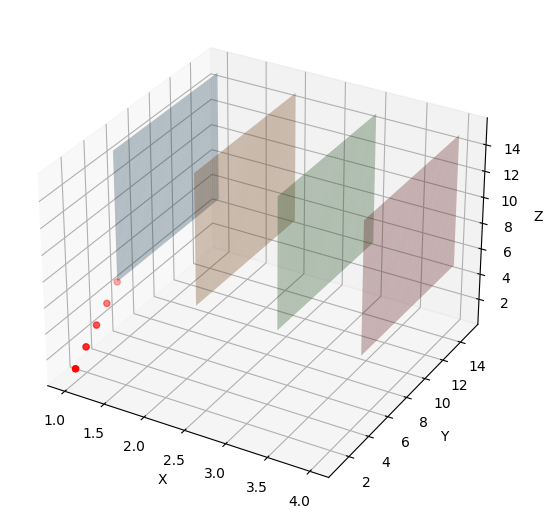

In [42]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
x = 1
y = np.linspace(5,15,100)
z = np.linspace(5,15,100)
Y,Z = np.meshgrid(y,z)
X = np.array([x]*Y.shape[0])

fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.plot_surface(X,Y,Z,alpha=0.3)

x = 2
X = np.array([x]*Y.shape[0])
ax.plot_surface(X,Y,Z,alpha=0.3)

x = 3
X = np.array([x]*Y.shape[0])
ax.plot_surface(X,Y,Z,alpha=0.3)

x = 4
X = np.array([x]*Y.shape[0])
ax.plot_surface(X,Y,Z,alpha=0.3)

x=[1,1,1,1,1]
y=[1,2,3,4,5]
z=[1,2,3,4,5]
ax.scatter(x,y,z,color='red') # plot the point (2,3,4) on the figure
plt.show()

In [40]:
net1_05

array([[11.,  6., 11.],
       [10.,  9.,  8.],
       [12., 10., 11.]])

In [ ]:
x = 